Various necessary imports

In [2]:
from pyscf import gto,dft,scf
import matplotlib.pyplot as plt
import pickle
import numpy as np
import jax.numpy as jnp
from ase import Atoms
from ase.io import read
import xcquinox as xce
import equinox as eqx
import os, optax, jax, argparse
import faulthandler
import pandas as pd
faulthandler.enable()
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


Definition of used functions

In [3]:
def get_mol(atoms, basis='6-311++G**'):
    '''
    Generates a pyscf.gto.Mole object, given an ASE atoms object

    :param atoms: ase.Atoms object containing the atomic information for the given molecule
    :type atoms: ase.Atoms
    :param basis: Basis with which to generate the various characteristics of the molecule, defaults to '6-311++G**'
    :type basis: str, optional
    :return: The pyscf mole object to use in further characteristic generation (i.e., getting the density)
    :rtype: pyscf.gto.Mole
    '''
    pos = atoms.positions
    spec = atoms.get_chemical_symbols()
    mol_input = [[s, p] for s, p in zip(spec, pos)]
    try:
        mol = gto.Mole(atom=mol_input, basis=atoms.info.get('basis',basis),spin=atoms.info.get('spin',0))
    except Exception:
        mol = gto.Mole(atom=mol_input, basis=atoms.info.get('basis','STO-3G'),spin=atoms.info.get('spin',0))
    return mol 

def get_rhos(rho, spin):
    '''
    Returns a partition of the density array produced by an MGGA PySCF calculation

    :param rho: The multi-dimensional "density" array produced in a PySCF calculation
    :type rho: np.array
    :param spin: The 'spin' of the system, used in polarizing the returned density arrays
    :type spin: int
    :return: A list of the decomposed density arrays
    :rtype: list of np.array
    '''
    rho0 = rho[0,0]
    drho = rho[0,1:4] + rho[1:4,0]
    tau = 0.5*(rho[1,1] + rho[2,2] + rho[3,3])

    if spin != 0:
        rho0_a = rho0[0]
        rho0_b = rho0[1]
        gamma_a, gamma_b = jnp.einsum('ij,ij->j',drho[:,0],drho[:,0]), jnp.einsum('ij,ij->j',drho[:,1],drho[:,1])              
        gamma_ab = jnp.einsum('ij,ij->j',drho[:,0],drho[:,1])
        tau_a, tau_b = tau
    else:
        rho0_a = rho0_b = rho0*0.5
        gamma_a=gamma_b=gamma_ab= jnp.einsum('ij,ij->j',drho[:],drho[:])*0.25
        tau_a = tau_b = tau*0.5
    return rho0_a, rho0_b, gamma_a, gamma_b, gamma_ab, tau_a, tau_b
    
def get_data_synth(xcmodel, xc_func, n=100):
    def get_rho(s, a):
        c0 = 2*(3*np.pi**2)**(1/3)
        c1 = 3/10*(3*np.pi**2)**(2/3)
        gamma = c0*s
        tau = c1*a+c0**2*s**2/8
        rho = np.zeros([len(a),6])
        rho[:, 1] = gamma
        rho[:,-1] = tau
        rho[:, 0] = 1
        return rho
    
    s_grid = jnp.concatenate([[0],jnp.exp(jnp.linspace(-10,4,n))])
    rho = []
    for s in s_grid:
        if 'MGGA' in xc_func:
            a_grid = jnp.concatenate([jnp.exp(jnp.linspace(jnp.log((s/100)+1e-8),8,n))])
        else:
            a_grid = jnp.array([0])
        rho.append(get_rho(s, a_grid))
        
    rho = jnp.concatenate(rho)
    
    fxc =  dft.numint.libxc.eval_xc(xc_func,rho.T, spin=0)[0]/dft.numint.libxc.eval_xc('LDA_X',rho.T, spin=0)[0] -1
 
    rho = jnp.asarray(rho)
    
    tdrho = xcmodel.get_descriptors(rho[:,0]/2,rho[:,0]/2,(rho[:,1]/2)**2,(rho[:,1]/2)**2,(rho[:,1]/2)**2,rho[:,5]/2,rho[:,5]/2, spin_scaling=True, mf=mf, dm=dm)
    


    tFxc = jnp.array(fxc)
    return tdrho[0], tFxc

def get_data(mol, xcmodel, xc_func, localnet=None, xorc=None):
    '''
    Gets the exchange or correlation energy density on the grid, given a reference XC functional to use (or a network to evaluate)

    :param mol: The molecule to get the energy density for
    :type mol: pyscf.gto.Mole
    :param xcmodel: the xcquinox network to use in generating the descriptors for network evaluation
    :type xcmodel: xcquinox exchange or correlation network
    :param xc_func: The reference XC functional that was targeted in pre-training, PBE0 or SCAN
    :type xc_func: str
    :param localnet: The MLP portion of the xcmodel network, defaults to None
    :type localnet: , optional
    :param xorc: 'x' for exchange network, 'c' for correlation network, defaults to None
    :type xorc: str, optional
    :return: A tuple of the molecule's network descriptors and the reference functional's energy density on the grid
    :rtype: tuple of arrays
    '''
    print('mol: ', mol.atom)
    try:
        mf = scf.UKS(mol)
    except:
        mf = dft.RKS(mol)
    mf.xc = 'PBE'
    mf.grids.level = 1
    mf.kernel()
    ao = mf._numint.eval_ao(mol, mf.grids.coords, deriv=2)
    dm = mf.make_rdm1()
    if len(dm.shape) == 2:
        #artificially spin-polarize
        dm = np.array([0.5*dm, 0.5*dm])
    print('New DM shape: {}'.format(dm.shape))
    print('ao.shape', ao.shape)

    #depending on the x or c type, choose the generation of the exchange or correlation density
    if xorc == 'x':
        print('Exchange contribution only')
        xc_func = xc_func+','
        if xc_func.lower() == 'pbe0,':
            print('PBE0 detected. changing xc_func to be combination of HF and PBE')
            xc_func = '0.25*HF + 0.75*PBE,'
        print(xc_func)
    elif xorc == 'c':
        print('Correlation contribution only')
        xc_func = ','+xc_func
        if xc_func.lower() == ',pbe0':
            print('PBE0 detected. Changing correlation to be just PBE')
            xc_func = ',pbe'
        print(xc_func)
    if localnet.spin_scaling:
        print('spin scaling')
        rho_alpha = mf._numint.eval_rho(mol, ao, dm[0], xctype='metaGGA',hermi=True)
        rho_beta = mf._numint.eval_rho(mol, ao, dm[1], xctype='metaGGA',hermi=True)
        fxc_a =  mf._numint.eval_xc(xc_func,(rho_alpha,rho_alpha*0), spin=1)[0]
        fxc_b =  mf._numint.eval_xc(xc_func,(rho_beta*0,rho_beta), spin=1)[0]
        print('fxc with xc_func = {} = {}'.format(fxc_a, xc_func))
        print(f'rho_a.shape={rho_alpha.shape}, rho_b.shape={rho_beta.shape}')
        print(f'fxc_a.shape={fxc_a.shape}, fxc_b.shape={fxc_b.shape}')

        if mol.spin != 0 and sum(mol.nelec)>1:
            print('mol.spin != 0 and sum(mol.nelec) > 1')
            rho = jnp.concatenate([rho_alpha, rho_beta], axis=-1)
            fxc = jnp.concatenate([fxc_a, fxc_b])
            print(f'rho.shape={rho.shape}, fxc.shape={fxc.shape}')
        else:
            print('NOT (mol.spin != 0 and sum(mol.nelec) > 1)')
            rho = rho_alpha
            fxc = fxc_a
            print(f'rho.shape={rho.shape}, fxc.shape={fxc.shape}')
    else:    
        print('no spin scaling')
        rho_alpha = mf._numint.eval_rho(mol, ao, dm[0], xctype='metaGGA',hermi=True)
        rho_beta = mf._numint.eval_rho(mol, ao, dm[1], xctype='metaGGA',hermi=True)
        exc = mf._numint.eval_xc(xc_func,(rho_alpha,rho_beta), spin=1)[0]
        print('exc with xc_func = {} = {}'.format(exc, xc_func))
        fxc = exc
        rho = jnp.stack([rho_alpha,rho_beta], axis=-1)
    
    dm = jnp.array(mf.make_rdm1())
    print('get_data, dm shape = {}'.format(dm.shape))
    ao_eval = jnp.array(mf._numint.eval_ao(mol, mf.grids.coords, deriv=1))
    print(f'ao_eval.shape={ao_eval.shape}')
    rho = jnp.einsum('xij,yik,...jk->xy...i', ao_eval, ao_eval, dm)        
    rho0 = rho[0,0]

    print('rho shape', rho.shape)
    if dm.ndim == 3:
        rho_filt = (jnp.sum(rho0,axis=0) > 1e-6)
    else:
        rho_filt = (rho0 > 1e-6)
    print('rho_filt shape:', rho_filt.shape)

    
    mf.converged=True
    tdrho = xcmodel.get_descriptors(*get_rhos(rho, spin=1), spin_scaling=localnet.spin_scaling, mf=mf, dm=dm)
    print(f'get descriptors tdrho.shape={tdrho.shape}')
    if localnet.spin_scaling:
        if mol.spin != 0 and sum(mol.nelec) > 1:
            print('mol.spin != 0 and sum(mol.nelec) > 1')
            #tdrho not returned in a spin-polarized form regardless,
            #but the enhancement factors sampled as polarized, so double
            if len(tdrho.shape) == 3:
                print('concatenating spin channels along axis=0')
                tdrho = jnp.concatenate([tdrho[0],tdrho[1]], axis=0)
            else:
                print('concatenating along axis=0')
                tdrho = jnp.concatenate([tdrho, tdrho], axis=0)
            rho_filt = jnp.concatenate([rho_filt]*2)
            print(f'tdrho.shape={tdrho.shape}')
            print(f'rho_filt.shape={rho_filt.shape}')
        else:
            #spin == 0 or hydrogen
            tdrho = tdrho[0]
            
    try:
        tdrho = tdrho[rho_filt]
        tFxc = jnp.array(fxc)[rho_filt]
    except:
        tdrho = tdrho[:, rho_filt, :]
        tFxc = jnp.array(fxc)[rho_filt]
    return tdrho, tFxc
level_dict = {'GGA':2, 'MGGA':3, 'NONLOCAL':4}

x_lob_level_dict = {'GGA': 1.804, 'MGGA': 1.174, 'NONLOCAL': 1.174}

class PT_E_Loss(eqx.Module):
    '''
    A loss module to use in getting the individual network e_xc predictions.
    '''
    def __call__(self, model, inp, ref):
        if model.spin_scaling and len(inp.shape) == 3:
            #spin scaling shape = (2, N, len(self.use))
            pred = jax.vmap(jax.vmap(model.net), in_axes=1)(inp)[:, 0]
        else:
            pred = jax.vmap(model.net)(inp)[:, 0]

        err = pred-ref

        return jnp.mean(jnp.square(err))

def get_model_info(xcdir, model_dir, tlogf = 'ptlog.dat'):
    '''
    Given a top-level directory (which must end with /{target xc functional}), and model directory, returns the values needed to re-create the network

    Model directories MUST have the following format, where 'x' denotes an optional portion of the directory name

    xorc_depth_nodes_'lrspecifier'_'usespecifier'_level,
    where xorc is a string, either 'x' or 'c' to denote the network type
    depth is an integer, indicating the number of hidden layers
    nodes is an integer, indicating the number of nodes per hidden layer
    'lrspecifier', an optional flag, is a string that just categorizes the network as having had a non-default training schedule
    'usespecifer', an option flag, is a string that categorizes the network as having used a different subset of descriptors
    level is a string, i.e. 'gga' or 'mgga' or 'nl' to denote the "level" of the network

    :param xcdir: The top-level directory, ending with the XC functional that was used to train against
    :type xcdir: str
    :param model_dir: A directory whose structure is as delineated above.
    :type model_dir: str
    :param tlogf: The log file used in pre-training, defaults to 'ptlog.dat'
    :type tlogf: str, optional
    :return: A tuple of (refxc, xorc, int(depth), int(nodes), ruse, int(rinp), rlevel.upper(), xcf)
    :rtype: tuple
    '''
    refxc = xcdir.split('/')[-1]
    nd_split = model_dir.split('_')
    
    def_mgga_x_use = [1, 2]
    def_mgga_c_use = []
    def_mgga_x_inp = 2
    def_mgga_c_inp = 4
    def_nl_x_use = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
    def_nl_x_inp = len(def_nl_x_use)
    def_nl_c_use = []
    def_nl_c_inp = 16
    
    use2_nl_x_use = [1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    use2_nl_c_use = [0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    use2_nl_x_inp = len(use2_nl_x_use)
    use2_nl_c_inp = len(use2_nl_c_use)
    
    if len(nd_split) == 4:
        #xorc_depth_nodes_level    
        xorc, depth, nodes, level = nd_split
        lr2 = ''
        use = ''
    elif len(nd_split) == 5:
        #xorc_depth_nodes_level_lr2, just denotes a different learning rate schedule used    
        xorc, depth, nodes, level, lr2 = nd_split
        use = ''
    elif len(nd_split) == 6:
        #xorc_depth_nodes_level_lr2_use2, just denotes a different learning rate schedule used    
        xorc, depth, nodes, level, lr2, use = nd_split

    if xorc == 'x':
        if level == 'mgga':
            rinp = def_mgga_x_inp
            ruse = def_mgga_x_use
        elif level == 'nl':
            if not use:
                rinp = def_nl_x_inp
                ruse = def_nl_x_use
            else:
                rinp = use2_nl_x_inp
                ruse = use2_nl_x_use
    elif xorc == 'c':
        if level == 'mgga':
            rinp = def_mgga_c_inp
            ruse = def_mgga_c_use
        elif level == 'nl':
            if not use:
                rinp = def_nl_c_inp
                ruse = def_nl_c_use
            else:
                rinp = use2_nl_c_inp
                ruse = use2_nl_c_use
    try:
        xcs = sorted([i for i in os.listdir(os.path.join(xcdir,model_dir)) if 'xc.eqx' in i],
                 key = lambda x: int(x.split('.')[-1]))
    except:
        xcs = sorted([i for i in os.listdir(os.path.join(xcdir,model_dir)) if 'xc.eqx' in i])
    if not xcs:
        print('No networks in directory')
        return
    if tlogf:
        try:
            loss = pd.read_csv(os.path.join(xcdir, model_dir, 'ptlog.dat'), delimiter='\t')
            epoch_min = loss[loss['Loss'] == loss['Loss'].min()]['#Epoch'].values[0]
            xcf = [i for i in xcs if int(i.split('.')[-1]) == epoch_min][0]
        except:
            if not xcs:
                print('No networks in directory')
                xcf = ''
            else:
                xcf = xcs[-1]
    else:
        selind = -1
        xcf = xcs[selind]
        
    if level == 'nl':
        rlevel = 'nonlocal'.upper()
    else:
        rlevel = level.upper()
    return (refxc, xorc, int(depth), int(nodes), ruse, int(rinp), rlevel.upper(), xcf)

def gen_network_model(xorc, depth, nodes, ninp, use, level='MGGA', ptpath = None, genverbose=False,
                     ueg_limit = None, spin_scaling = None):
    '''
    Creates the network structure to validate against

    :param xorc: Whether the network validated is and exchange ('x') or correlation ('c') network
    :type xorc: str
    :param depth: The number of hidden layers in the generated network
    :type depth: int
    :param nodes: The number of nodes in a layer
    :type nodes: int
    :param ninp: The number of outputs for the model
    :type ninp: int
    :param use: A list of integers instructing the model which descriptors to use
    :type use: list of ints
    :param level: The "rung" of Jacob's ladder being used, defaults to 'MGGA'
    :type level: str, optional
    :param ptpath: The path to the pre-trained model whose network weights are to be loaded, defaults to None
    :type ptpath: str, optional
    :param genverbose: If flagged, the resulting network will be "verbose" and print a lot of typically extraneous information, defaults to False
    :type genverbose: bool, optional
    :return: The resulting xcquinox network
    :rtype: xcquinox.xc.eXC network
    '''
    level_dict = {'GGA':2, 'MGGA':3, 'NONLOCAL':4, 'NL':4}
    x_lob_level_dict = {'GGA': 1.804, 'MGGA': 1.174, 'NONLOCAL': 1.174, 'NL':1.174}
    ueg_limit = ueg_limit if ueg_limit is not None else True
    if xorc == 'x':
        ss = spin_scaling if spin_scaling is not None else True
        net = xce.net.eX(n_input = ninp,
                         n_hidden = nodes,
                         depth = depth,
                         use = use,
                         ueg_limit = ueg_limit,
                         lob=x_lob_level_dict[level],
                         spin_scaling=ss)
    elif xorc == 'c':
        ss = spin_scaling if spin_scaling is not None else False
        net = xce.net.eC(n_input = ninp,
                         n_hidden = nodes,
                         depth = depth,
                         use = use,
                         ueg_limit = ueg_limit,
                         spin_scaling=ss)

    if ptpath:
        print('Attempting to deserialize network from {}'.format(ptpath))
        net = eqx.tree_deserialise_leaves(ptpath, net)

    xc = xce.xc.eXC(grid_models=[net], heg_mult=True, level=level_dict[level], verbose=genverbose)
    return xc, net

In [4]:
#A dictionary containing ground-state spin values for single atoms,
# as PySCF doesn't even try to guess this and assume 0 if not otherwise specified
spins = {
    'Al': 1,
    'B' : 1,
    'Li': 1,
    'Na': 1,
    'Si': 2 ,
    'Be':0,
    'C': 2,
    'Cl': 1,
    'F': 1,
    'H': 1,
    'N': 3,
    'O': 2,
    'P': 3,
    'S': 2
}

#the location of the g297 trajectory file, within the xcquinox package subdirectories
g297_path = '../scripts/script_data/haunschild_g2/g2_97.traj'
g297 = read(g297_path, ':')
ng297 = len(g297)
inds = np.arange(0, ng297)
#the selected molecules from the g297 dataset that were used in pre-training
pt_selection = [2, 113, 25, 18, 11, 17, 114, 121, 101, 0, 20, 26, 29, 67, 28, 110, 125, 10, 115, 89, 105, 50]

#set a random seed for validation selection
np.random.seed(seed=92017)

SIZE = 30
SIZE = 0

if SIZE:
    #if we specify a certain size for the validation set, the random seed is used in selecting that random subset
    val_selection = [i for i in np.random.choice(inds, size=SIZE) if i not in pt_selection]
else:
    #otherwise, just use the molecules not pre-trained on
    val_selection = [i for i in inds if i not in pt_selection]
#lists of the pre-training molecules and the validation molecules
pt_atoms = [g297[s] for s in pt_selection]
val_atoms = [g297[s] for s in val_selection]

# for idx, at in enumerate(val_atoms):
#     print(idx, at, at.info)

#generate the mole objects for the validation atoms and print the info
mols = [get_mol(atoms) for atoms in val_atoms]
# mols = [i for i in mols if len(i.atom) < 8]
for idx, i in enumerate(mols):
    print(idx, i.atom, len(i.atom))


0 [['C', array([ 0.      ,  0.      , -1.120678])], ['S', array([0.      , 0.      , 0.420254])]] 2
1 [['F', array([0.      , 0.      , 0.091946])], ['H', array([ 0.      ,  0.      , -0.827512])]] 2
2 [['P', array([0.      , 0.      , 0.947658])], ['P', array([ 0.      ,  0.      , -0.947658])]] 2
3 [['S', array([0.      , 0.      , 0.956078])], ['S', array([ 0.      ,  0.      , -0.956078])]] 2
4 [['S', array([0.      , 0.      , 0.079416])], ['H', array([ 0.      ,  0.      , -1.270651])]] 2
5 [['O', array([ 0.      ,  0.      , -0.997879])], ['S', array([0.     , 0.     , 0.49894])]] 2
6 [['C', array([ 0.013445, -0.731846,  0.      ])], ['C', array([0.013445, 0.477327, 0.      ])], ['H', array([-0.161343  ,  1.52711101,  0.        ])]] 3
7 [['C', array([0., 0., 0.])], ['F', array([0.762931, 0.762931, 0.762931])], ['F', array([-0.762931, -0.762931,  0.762931])], ['F', array([-0.762931,  0.762931, -0.762931])], ['F', array([ 0.762931, -0.762931, -0.762931])]] 5
8 [['S', array([0.    

In [10]:

#the top-level directories under which the pre-trained networks are contained 
pbe0d = '/home/awills/Documents/Research/xcquinox_pt/pbe0'
scand = '/home/awills/Documents/Research/xcquinox_pt/scan'
pbe0d2 = '/home/awills/Documents/Research2/xcquinox_pt/pbe0'
scand2 = '/home/awills/Documents/Research2/xcquinox_pt/scan'

#this generates the list of networks generated, assuming they are the only directories with underscores in them in the subdirectories
pbe0nets = sorted([i for i in os.listdir(pbe0d) if '_' in i and os.path.isdir(os.path.join(pbe0d, i))])
scannets = sorted([i for i in os.listdir(scand) if '_' in i and os.path.isdir(os.path.join(scand, i))])

#set up empty dictionary
val_dct = {'PBE0': {},
           'SCAN': {}}

#set up dictionaries that have the location of the various networks 
refxcps = {'PBE0':pbe0d,
           'SCAN':scand}
refxcps2 = {'PBE0':pbe0d2,
           'SCAN':scand2}

#populate the validation dictionaries with the directories of the pre-trained networks as sub-directories, with empty lists for losses
val_dct['PBE0'] = {'x': {'mgga': {k : [] for k in pbe0nets if 'mgga' in k and 'x' in k},
                         'nl': {k : [] for k in pbe0nets if 'nl' in k and 'x' in k},
                        },
                   'c': {'mgga': {k : [] for k in pbe0nets if 'mgga' in k and 'c' in k},
                         'nl': {k : [] for k in pbe0nets if 'nl' in k and 'c' in k}
                        },
                  }
val_dct['SCAN'] = {'x': {'mgga': {k : [] for k in scannets if 'mgga' in k and 'x' in k},
                         'nl': {k : [] for k in scannets if 'nl' in k and 'x' in k},
                        },
                   'c': {'mgga': {k : [] for k in scannets if 'mgga' in k and 'c' in k},
                         'nl': {k : [] for k in scannets if 'nl' in k and 'c' in k}
                        },
                  }

In [11]:
refxcps

{'PBE0': '/home/awills/Documents/Research/xcquinox_pt/pbe0',
 'SCAN': '/home/awills/Documents/Research/xcquinox_pt/scan'}

# Evaluation of Validation Set

In [5]:
#create empty dictionary for the calculated densities on the grid
calc_dct = {}

#loop over the reference XC functionals in val_dct, PBE0 and SCAN
for krefxc in val_dct.keys():
    #select the sub-directory from val_dct, and create a sub-directory in calc_dct using this reference XC functional
    krefdct = val_dct[krefxc]
    calc_dct[krefxc] = {}
    for kxorc in krefdct.keys():
        #loops over the 'x' or 'c' values in the val_dct sub-dictionary, and again creates an empty dictionary to hold the results
        krefxcdct = krefdct[kxorc]
        calc_dct[krefxc][kxorc] = {}
        for klevel in krefxcdct.keys():
            #loop over the 'mgga' or 'nl' levels in the val_dct subdictionary
            krxcldct = krefxcdct[klevel]
            #the networks included in this reference XC -> x/c -> level
            knets = sorted(list(krxcldct.keys()))
            for knetidx, knet in enumerate(knets): 
                #loop over the list indices and network directories
                if knetidx == 0:
                    #if first attempt, print stats and generate the reference data
                    print(krefxc, kxorc, klevel, knet)
                    tup = get_model_info(refxcps[krefxc], knet)
                    try:
                        refxc, xorc, depth, nodes, ruse, rinp, level, xcf = tup
                        print(tup)
                    except Exception as e:
                        print("Exception raise: ", e)
                        print('no networks found')
                        continue
                    #create the network to generate the descriptors for saving
                    xc, net = gen_network_model(xorc, depth, nodes, rinp, ruse, level, ptpath = os.path.join(refxcps[krefxc], knet, xcf))
                
                    #DO GET_DATA GENERATION HERE
                    #data generated only depends on get_descriptors, determined by level, not use
                    data = []
                    calcs = []
                    rejects = []
                    for idx, mol in enumerate(mols):
                        if len(mol.atom) <= 9:
                            #due to memory constraints, only validate on the molecules with 9 or less constituent atoms
                            print('----------------------------')
                            print(f'-----{idx}/{len(mols)}-----')
                            print(f'Calculating {mol.atom}')
                            try:
                                data.append(get_data(mol, xcmodel=xc, xc_func=krefxc, localnet=net))
                                calcs.append(mol.atom)
                            except Exception as e:
                                print("Exception raised: ", e)
                                rejects.append(mol.atom)
                                continue
                        else:
                            rejects.append(mol.atom)
            #save this combo's descriptors and energy densities to a file for later use
            with open(os.path.join(refxcps2[krefxc], f'{krefxc}_{kxorc}_{klevel}.data.pkl'), 'wb') as f:
                pickle.dump(data, f)

            #for this XC -> x/c -> level, create the dictionary with the calculated values and rejected values, and an empty one for losses
            calc_dct[krefxc][kxorc][klevel] = {'calcs': calcs,
                                              'rejects': rejects,
                                              'calc_losses': {}}
            #separate the results in data to the descriptors and energy densities on the grid
            tdrhos = [i[0] for i in data]
            tfxcs = [i[1] for i in data]
            for knetidx, knet in enumerate(knets): 
                #repeat the loop, now over all the networks, to predict energy densities on the grid
                print(krefxc, kxorc, klevel, knet)
                tup = get_model_info(refxcps[krefxc], knet)
                try:
                    refxc, xorc, depth, nodes, ruse, rinp, level, xcf = tup
                    print(tup)
                except Exception as e:
                    print("Exception raise: ", e)
                    print('no networks found')
                    continue
                xc, net = gen_network_model(xorc, depth, nodes, rinp, ruse, level, ptpath = os.path.join(refxcps[krefxc], knet, xcf))
                losses = []
                #loop over the molecule descriptors
                for idx, dat in enumerate(tdrhos):
                    #reference energy density and the descriptors
                    this_tFxc = tfxcs[idx]
                    this_tdrho = dat
                    if ruse:
                        #if there is a specified 'use' for the network, only select those descriptors as inputs
                        if net.spin_scaling:
                            if len(this_tdrho.shape) == 3:
                                inp = this_tdrho[:, :, ruse]
                            else:
                                inp = this_tdrho[:, ruse]
                        else:
                            inp = this_tdrho[:, ruse]
                    else:
                        #otherwise, no subsetting necessary
                        inp = this_tdrho
                    # print(f'inp[0].shape = {inp[0].shape}')
                    #generate the validation loss
                    loss = PT_E_Loss()(net, inp, this_tFxc)
                    losses.append(loss)
                val_dct[krefxc][kxorc][klevel][knet] = losses
                calc_dct[krefxc][kxorc][klevel]['calc_losses'][knet] = losses
            with open(os.path.join(refxcps2[krefxc], 'valdct.pkl'), 'wb') as f:
                pickle.dump(val_dct, f)
            with open(os.path.join(refxcps2[krefxc], 'calcdct.pkl'), 'wb') as f:
                pickle.dump(calc_dct, f)

PBE0 x mgga x_3_16_mgga
('pbe0', 'x', 3, 16, [1, 2], 2, 'MGGA', 'xc.eqx.2450')
----------------------------
-----0/126-----
Calculating [['C', array([ 0.      ,  0.      , -1.120678])], ['S', array([0.      , 0.      , 0.420254])]]
mol:  [['C', array([ 0.      ,  0.      , -1.120678])], ['S', array([0.      , 0.      , 0.420254])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f98c910> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -436.013526549182  <S^2> = 3.1086245e-13  2S+1 = 1
New DM shape: (2, 52, 52)
ao.shape (10, 11280, 52)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35083401  0.35256766  0.35296701 ... -0.1052276  -0.1052276
 -0.1052276 ] = PBE0
rho_a.shape=(6, 11280), rho_b.shape=(6, 11280)
fxc_a.shape=(11280,), fxc_b.shape=(11280,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 11280), fxc.shape=(11280,)
get_data, dm shape = (2, 52, 52)
ao_eval.shape=(4, 11280, 52)
rho shape (4, 4, 2, 11280)
rho_filt shape: (11280,)
get descriptors tdrho.shape=(2, 11280, 3)
----------------------------
-----1/126-----
Calculating [['F', array([0.      , 0.      , 0.091946])], ['H', array([ 0.      ,  0.      , -0.827512])]]
mol:  [['F', array([0.      , 0.      , 0.091946])], ['H', array([ 0.      ,  0.      , -0.827512])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f98e200> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -100.383523163202  <S^2> = 3.4638958e-14  2S+1 = 1
New DM shape: (2, 29, 29)
ao.shape (10, 7512, 29)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35298611  0.35297754  0.35299982 ... -0.12740057 -0.12740057
 -0.12740057] = PBE0
rho_a.shape=(6, 7512), rho_b.shape=(6, 7512)
fxc_a.shape=(7512,), fxc_b.shape=(7512,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 7512), fxc.shape=(7512,)
get_data, dm shape = (2, 29, 29)
ao_eval.shape=(4, 7512, 29)
rho shape (4, 4, 2, 7512)
rho_filt shape: (7512,)
get descriptors tdrho.shape=(2, 7512, 3)
----------------------------
-----2/126-----
Calculating [['P', array([0.      , 0.      , 0.947658])], ['P', array([ 0.      ,  0.      , -0.947658])]]
mol:  [['P', array([0.      , 0.      , 0.947658])], ['P', array([ 0.      ,  0.      , -0.947658])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f98e2c0> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -682.392471889731  <S^2> = 9.4146912e-13  2S+1 = 1
New DM shape: (2, 60, 60)
ao.shape (10, 12528, 60)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35297204  0.3529528   0.3529528  ...  0.35289992 -0.18296367
 -0.18296367] = PBE0
rho_a.shape=(6, 12528), rho_b.shape=(6, 12528)
fxc_a.shape=(12528,), fxc_b.shape=(12528,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 12528), fxc.shape=(12528,)
get_data, dm shape = (2, 60, 60)
ao_eval.shape=(4, 12528, 60)
rho shape (4, 4, 2, 12528)
rho_filt shape: (12528,)
get descriptors tdrho.shape=(2, 12528, 3)
----------------------------
-----3/126-----
Calculating [['S', array([0.      , 0.      , 0.956078])], ['S', array([ 0.      ,  0.      , -0.956078])]]
mol:  [['S', array([0.      , 0.      , 0.956078])], ['S', array([ 0.      ,  0.      , -0.956078])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f98c7f0> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -796.038534625598  <S^2> = 1.0025275  2S+1 = 2.2383275
New DM shape: (2, 60, 60)
ao.shape (10, 12520, 60)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35298945  0.35298181  0.35298275 ...  0.34565938 -0.18336272
 -0.18336272] = PBE0
rho_a.shape=(6, 12520), rho_b.shape=(6, 12520)
fxc_a.shape=(12520,), fxc_b.shape=(12520,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 12520), fxc.shape=(12520,)
get_data, dm shape = (2, 60, 60)
ao_eval.shape=(4, 12520, 60)
rho shape (4, 4, 2, 12520)
rho_filt shape: (12520,)
get descriptors tdrho.shape=(2, 12520, 3)
----------------------------
-----4/126-----
Calculating [['S', array([0.      , 0.      , 0.079416])], ['H', array([ 0.      ,  0.      , -1.270651])]]
mol:  [['S', array([0.      , 0.      , 0.079416])], ['H', array([ 0.      ,  0.      , -1.270651])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f98c5e0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f98c5e0> in RKS object of <class 'pyscf.dft.rks.RKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f98c580> in UKS object of <class 'pyscf.dft.uks.UKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----5/126-----
Calculating [['O', array([ 0.      ,  0.      , -0.997879])], ['S', array([0.     , 0.     , 0.49894])]]
mol:  [['O', array([ 0.      ,  0.      , -0.997879])], ['S', array([0.     , 0.     , 0.49894])]]
converged SCF energy = -473.138531539075  <S^2> = 1.002715  2S+1 = 2.238495
New DM shape: (2, 52, 52)
ao.shape (10, 11288, 52)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.3522526   0.35287315  0.35298985 ... -0.18020676 -0.18020676
 -0.18020676] = PBE0
rho_a.shape=(6, 11288), rho_b.shape=(6, 11288)
fxc_a.shape=(11288,), fxc_b.shape=(11288,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 11288), fxc.shape=(11288,)
get_data, dm shape = (2, 52, 52)
ao_eval.shape=(4, 11288, 52)
rho shape (4, 4, 2, 11288)
rho_filt shape: (11288,)
get descriptors tdrho.shape=(2, 11288, 3)
----------------------------
-----

Initialize <pyscf.gto.mole.Mole object at 0x7f1afd106d10> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f1afd106d10> in RKS object of <class 'pyscf.dft.rks.RKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f901630> in UKS object of <class 'pyscf.dft.uks.UKS'>


Exception raised:  Electron number 13 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----7/126-----
Calculating [['C', array([0., 0., 0.])], ['F', array([0.762931, 0.762931, 0.762931])], ['F', array([-0.762931, -0.762931,  0.762931])], ['F', array([-0.762931,  0.762931, -0.762931])], ['F', array([ 0.762931, -0.762931, -0.762931])]]
mol:  [['C', array([0., 0., 0.])], ['F', array([0.762931, 0.762931, 0.762931])], ['F', array([-0.762931, -0.762931,  0.762931])], ['F', array([-0.762931,  0.762931, -0.762931])], ['F', array([ 0.762931, -0.762931, -0.762931])]]
converged SCF energy = -437.217292208888  <S^2> = 4.131806e-12  2S+1 = 1
New DM shape: (2, 110, 110)
ao.shape (10, 24672, 110)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35291288  0.35299927  0.35299927 ...  0.3529978  -0.23463687
 -0.23463687] = PBE0
rho_a.shape=(6, 24672), rho_b.shape=(6, 24672)
fxc_a.shape=(24672,), fxc_b.shape=(24672,)
NOT (mol.spin !=

Initialize <pyscf.gto.mole.Mole object at 0x7f199f903790> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -834.140668049622  <S^2> = 1.7763568e-14  2S+1 = 1
New DM shape: (2, 82, 82)
ao.shape (10, 17752, 82)
spin scaling, indicates exchange network
fxc with xc_func = [0.35293857 0.35293857 0.35281786 ... 0.35293857 0.35293857 0.35281786] = PBE0
rho_a.shape=(6, 17752), rho_b.shape=(6, 17752)
fxc_a.shape=(17752,), fxc_b.shape=(17752,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 17752), fxc.shape=(17752,)
get_data, dm shape = (2, 82, 82)
ao_eval.shape=(4, 17752, 82)
rho shape (4, 4, 2, 17752)
rho_filt shape: (17752,)
get descriptors tdrho.shape=(2, 17752, 3)
----------------------------
-----9/126-----
Calculating [['F', array([ 0.      ,  1.098555, -0.264869])], ['O', array([0.      , 0.      , 0.595955])], ['F', array([ 0.      , -1.098555, -0.264869])]]
mol:  [['F', array([ 0.      ,  1.098555, -0.264869])], ['O', array([0.      , 0.      , 0.595955])], ['F', array([ 0.      , -1.098555, -0.264869])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f900460> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -274.505435878771  <S^2> = 1.0011547e-11  2S+1 = 1
New DM shape: (2, 66, 66)
ao.shape (10, 14720, 66)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.3529875   0.35299956  0.35225054 ... -0.1671265  -0.1671265
 -0.1671265 ] = PBE0
rho_a.shape=(6, 14720), rho_b.shape=(6, 14720)
fxc_a.shape=(14720,), fxc_b.shape=(14720,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 14720), fxc.shape=(14720,)
get_data, dm shape = (2, 66, 66)
ao_eval.shape=(4, 14720, 66)
rho shape (4, 4, 2, 14720)
rho_filt shape: (14720,)
get descriptors tdrho.shape=(2, 14720, 3)
----------------------------
-----10/126-----
Calculating [['Be', array([0.      , 0.      , 0.268761])], ['H', array([ 0.      ,  0.      , -1.075046])]]
mol:  [['Be', array([0.      , 0.      , 0.268761])], ['H', array([ 0.      ,  0.      , -1.075046])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f9014e0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9014e0> in RKS object of <class 'pyscf.dft.rks.RKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9014b0> in UKS object of <class 'pyscf.dft.uks.UKS'>


Exception raised:  Electron number 5 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----11/126-----
Calculating [['O', array([0.     , 0.     , 0.11884])], ['H', array([ 0.      ,  0.756681, -0.475361])], ['H', array([ 0.      , -0.756681, -0.475361])]]
mol:  [['O', array([0.     , 0.     , 0.11884])], ['H', array([ 0.      ,  0.756681, -0.475361])], ['H', array([ 0.      , -0.756681, -0.475361])]]
converged SCF energy = -76.3723908482221  <S^2> = 5.1159077e-13  2S+1 = 1
New DM shape: (2, 36, 36)
ao.shape (10, 9688, 36)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35295846  0.35299947  0.35299529 ... -0.10651225 -0.10651225
 -0.10651225] = PBE0
rho_a.shape=(6, 9688), rho_b.shape=(6, 9688)
fxc_a.shape=(9688,), fxc_b.shape=(9688,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 9688), fxc.shape=(9688,)
get_data, dm shape = (2, 36, 36)
ao_eval.shape=(4, 9688, 36)
rho shape (4, 4, 2, 9688)
rho_filt shape

Initialize <pyscf.gto.mole.Mole object at 0x7f199f901420> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -399.223724649003  <S^2> = 2.8581582e-12  2S+1 = 1
New DM shape: (2, 44, 44)
ao.shape (10, 10880, 44)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35291078  0.35299914  0.35196345 ... -0.21560889 -0.21560889
 -0.21560889] = PBE0
rho_a.shape=(6, 10880), rho_b.shape=(6, 10880)
fxc_a.shape=(10880,), fxc_b.shape=(10880,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 10880), fxc.shape=(10880,)
get_data, dm shape = (2, 44, 44)
ao_eval.shape=(4, 10880, 44)
rho shape (4, 4, 2, 10880)
rho_filt shape: (10880,)
get descriptors tdrho.shape=(2, 10880, 3)
----------------------------
-----13/126-----
Calculating [['C', array([0.062351, 0.5852  , 0.      ])], ['O', array([ 0.062351, -0.59101 ,  0.      ])], ['H', array([-0.872908,  1.21688 ,  0.      ])]]
mol:  [['C', array([0.062351, 0.5852  , 0.      ])], ['O', array([ 0.062351, -0.59101 ,  0.      ])], ['H', array([-0.872908,  1.21688 ,  0.      ])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f9013f0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9013f0> in RKS object of <class 'pyscf.dft.rks.RKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f901360> in UKS object of <class 'pyscf.dft.uks.UKS'>


Exception raised:  Electron number 15 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----14/126-----
Calculating [['N', array([ 0.      ,  0.      , -1.200105])], ['N', array([ 0.      ,  0.      , -0.072362])], ['O', array([0.      , 0.      , 1.113409])]]
mol:  [['N', array([ 0.      ,  0.      , -1.200105])], ['N', array([ 0.      ,  0.      , -0.072362])], ['O', array([0.      , 0.      , 1.113409])]]
converged SCF energy = -184.544866427315  <S^2> = 1.2332357e-10  2S+1 = 1
New DM shape: (2, 66, 66)
ao.shape (10, 14640, 66)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35255169  0.35294321  0.35299794 ... -0.17692761 -0.17692761
 -0.17692761] = PBE0
rho_a.shape=(6, 14640), rho_b.shape=(6, 14640)
fxc_a.shape=(14640,), fxc_b.shape=(14640,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 14640), fxc.shape=(14640,)
get_data, dm shape = (2, 66, 66)
ao_eval.shape=(4, 14640, 66)
rho shape (4, 4, 2, 14640

Initialize <pyscf.gto.mole.Mole object at 0x7f199f901330> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -353.882359915599  <S^2> = 1.3198331e-11  2S+1 = 1
New DM shape: (2, 88, 88)
ao.shape (10, 19592, 88)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35297994  0.35299879  0.35299997 ... -0.18675697 -0.18675697
 -0.18675697] = PBE0
rho_a.shape=(6, 19592), rho_b.shape=(6, 19592)
fxc_a.shape=(19592,), fxc_b.shape=(19592,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 19592), fxc.shape=(19592,)
get_data, dm shape = (2, 88, 88)
ao_eval.shape=(4, 19592, 88)
rho shape (4, 4, 2, 19592)
rho_filt shape: (19592,)
get descriptors tdrho.shape=(2, 19592, 3)
----------------------------
-----16/126-----
Calculating [['N', array([0.      , 0.      , 0.322871])], ['O', array([ 0.      ,  1.101927, -0.141256])], ['O', array([ 0.      , -1.101927, -0.141256])]]
mol:  [['N', array([0.      , 0.      , 0.322871])], ['O', array([ 0.      ,  1.101927, -0.141256])], ['O', array([ 0.      , -1.101927, -0.141256])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f9012d0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9012d0> in RKS object of <class 'pyscf.dft.rks.RKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f901270> in UKS object of <class 'pyscf.dft.uks.UKS'>


Exception raised:  Electron number 23 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----17/126-----
Calculating [['Li', array([0.        , 0.        , 1.36064001])], ['Li', array([ 0.        ,  0.        , -1.36064001])]]
mol:  [['Li', array([0.        , 0.        , 1.36064001])], ['Li', array([ 0.        ,  0.        , -1.36064001])]]
converged SCF energy = -14.9523634534861  <S^2> = 1.0205516e-09  2S+1 = 1
New DM shape: (2, 44, 44)
ao.shape (10, 9128, 44)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.34899908  0.34899908  0.34679985 ...  0.34679985 -0.14122617
 -0.14122617] = PBE0
rho_a.shape=(6, 9128), rho_b.shape=(6, 9128)
fxc_a.shape=(9128,), fxc_b.shape=(9128,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 9128), fxc.shape=(9128,)
get_data, dm shape = (2, 44, 44)
ao_eval.shape=(4, 9128, 44)
rho shape (4, 4, 2, 9128)
rho_filt shape: (9128,)
get descriptors tdrho.shape=(2, 9128, 3)
------------

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9011e0> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -640.63499398532  <S^2> = 1.1368684e-13  2S+1 = 1
New DM shape: (2, 96, 96)
ao.shape (10, 21304, 96)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35299634  0.35274096  0.35274588 ... -0.06042979 -0.06042979
 -0.06042979] = PBE0
rho_a.shape=(6, 21304), rho_b.shape=(6, 21304)
fxc_a.shape=(21304,), fxc_b.shape=(21304,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 21304), fxc.shape=(21304,)
get_data, dm shape = (2, 96, 96)
ao_eval.shape=(4, 21304, 96)
rho shape (4, 4, 2, 21304)
rho_filt shape: (21304,)
get descriptors tdrho.shape=(2, 21304, 3)
----------------------------
-----19/126-----
Calculating [['S', array([0.     , 0.     , 0.36486])], ['O', array([ 0.      ,  1.244376, -0.36486 ])], ['O', array([ 0.      , -1.244376, -0.36486 ])]]
mol:  [['S', array([0.     , 0.     , 0.36486])], ['O', array([ 0.      ,  1.244376, -0.36486 ])], ['O', array([ 0.      , -1.244376, -0.36486 ])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f901150> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -548.345273323684  <S^2> = 1.4019008e-11  2S+1 = 1
New DM shape: (2, 74, 74)
ao.shape (10, 16160, 74)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35297071  0.35260269  0.35293645 ... -0.08479101 -0.08479101
 -0.08479101] = PBE0
rho_a.shape=(6, 16160), rho_b.shape=(6, 16160)
fxc_a.shape=(16160,), fxc_b.shape=(16160,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 16160), fxc.shape=(16160,)
get_data, dm shape = (2, 74, 74)
ao_eval.shape=(4, 16160, 74)
rho shape (4, 4, 2, 16160)
rho_filt shape: (16160,)
get descriptors tdrho.shape=(2, 16160, 3)
----------------------------
-----20/126-----
Calculating [['Si', array([0.      , 0.      , 0.550118])], ['O', array([ 0.      ,  0.      , -0.962707])]]
mol:  [['Si', array([0.      , 0.      , 0.550118])], ['O', array([ 0.      ,  0.      , -0.962707])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f901390> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -364.529911631258  <S^2> = 1.0906831e-12  2S+1 = 1
New DM shape: (2, 52, 52)
ao.shape (10, 11264, 52)
spin scaling, indicates exchange network
fxc with xc_func = [0.35260209 0.35299905 0.3529536  ... 0.3529518  0.3529518  0.35117253] = PBE0
rho_a.shape=(6, 11264), rho_b.shape=(6, 11264)
fxc_a.shape=(11264,), fxc_b.shape=(11264,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 11264), fxc.shape=(11264,)
get_data, dm shape = (2, 52, 52)
ao_eval.shape=(4, 11264, 52)
rho shape (4, 4, 2, 11264)
rho_filt shape: (11264,)
get descriptors tdrho.shape=(2, 11264, 3)
----------------------------
-----22/126-----
Calculating [['C', array([0., 0., 0.])], ['C', array([0.      , 0.      , 1.301399])], ['C', array([ 0.      ,  0.      , -1.301399])], ['H', array([0.        , 0.925815  , 1.86943001])], ['H', array([ 0.        , -0.925815  ,  1.86943001])], ['H', array([ 0.925815  ,  0.        , -1.86943001])], ['H', array([-0.925815  ,  0.        , -1.86943001])]]
mol:  [

Initialize <pyscf.gto.mole.Mole object at 0x7f199f901240> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -116.527040748632  <S^2> = 1.5596413e-12  2S+1 = 1
New DM shape: (2, 94, 94)
ao.shape (10, 25296, 94)
spin scaling, indicates exchange network
fxc with xc_func = [0.35297477 0.35294849 0.35270638 ... 0.35270638 0.35299646 0.35299688] = PBE0
rho_a.shape=(6, 25296), rho_b.shape=(6, 25296)
fxc_a.shape=(25296,), fxc_b.shape=(25296,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 25296), fxc.shape=(25296,)
get_data, dm shape = (2, 94, 94)
ao_eval.shape=(4, 25296, 94)
rho shape (4, 4, 2, 25296)
rho_filt shape: (25296,)
get descriptors tdrho.shape=(2, 25296, 3)
----------------------------
-----23/126-----
Calculating [['C', array([ 0.04802 , -0.585566,  0.      ])], ['C', array([0.04802, 0.71997, 0.     ])], ['H', array([-0.877957, -1.168655,  0.      ])], ['H', array([ 0.967173, -1.16899 ,  0.      ])], ['H', array([-0.665462  ,  1.53122101,  0.        ])]]
mol:  [['C', array([ 0.04802 , -0.585566,  0.      ])], ['C', array([0.04802, 0.71997, 0.     ])], ['H

Initialize <pyscf.gto.mole.Mole object at 0x7f199f901300> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f901300> in RKS object of <class 'pyscf.dft.rks.RKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f901210> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f901210> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 15 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----24/126-----
Calculating [['C', array([-0.010978, -0.69308 ,  0.      ])], ['C', array([-0.010978,  0.794561,  0.      ])], ['H', array([ 1.0119 , -1.10836,  0.     ])], ['H', array([-0.50801 , -1.101851,  0.886769])], ['H', array([-0.50801 , -1.101851, -0.886769])], ['H', array([0.067929  , 1.35158901, 0.926421  ])], ['H', array([ 0.067929  ,  1.35158901, -0.926421  ])]]
mol:  [['C', array([-0.010978, -0.69308 ,  0.      ])], ['C', array([-0.010978,  0.794561,  0.      ])], ['H', array([ 1.0119 , -1.10836,  0.     ])], ['H', array([-0.50801 , -1.101851,  0.886769])], ['H', array([-0.50801 , -1.101851, -0.886769])], ['H', array([0.067929  , 1.35158901, 0.926421  ])], ['H', array([ 0.067929  ,  1.35158901, -0.926421  ])]]
Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
--------

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9012a0> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -1878.14149018999  <S^2> = 3.7161385e-12  2S+1 = 1
New DM shape: (2, 142, 142)
ao.shape (10, 29224, 142)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35289415  0.35299879  0.35299743 ...  0.35299996 -0.23464535
 -0.23464535] = PBE0
rho_a.shape=(6, 29224), rho_b.shape=(6, 29224)
fxc_a.shape=(29224,), fxc_b.shape=(29224,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 29224), fxc.shape=(29224,)
get_data, dm shape = (2, 142, 142)
ao_eval.shape=(4, 29224, 142)
rho shape (4, 4, 2, 29224)
rho_filt shape: (29224,)
get descriptors tdrho.shape=(2, 29224, 3)
----------------------------
-----26/126-----
Calculating [['C', array([-0.011187, -0.571196,  0.      ])], ['O', array([-0.011187,  0.790812,  0.      ])], ['H', array([ 1.059325, -0.867696,  0.      ])], ['H', array([-0.451351, -1.015813,  0.908578])], ['H', array([-0.451351, -1.015813, -0.908578])]]
mol:  [['C', array([-0.011187, -0.571196,  0.      ])], ['O', array([-0.011187,  0.790812

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9010c0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9010c0> in RKS object of <class 'pyscf.dft.rks.RKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f901060> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f901060> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----27/126-----
Calculating [['C', array([-0.004548,  1.110156,  0.      ])], ['S', array([-0.004548, -0.694097,  0.      ])], ['H', array([1.048852  , 1.41887801, 0.        ])], ['H', array([-0.474401  ,  1.51286801,  0.899782  ])], ['H', array([-0.474401  ,  1.51286801, -0.899782  ])]]
mol:  [['C', array([-0.004548,  1.110156,  0.      ])], ['S', array([-0.004548, -0.694097,  0.      ])], ['H', array([1.048852  , 1.41887801, 0.        ])], ['H', array([-0.474401  ,  1.51286801,  0.899782  ])], ['H', array([-0.474401  ,  1.51286801, -0.899782  ])]]
Exception raised:  Electron number 25 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----28/126-----
Calculating [['C', array([0.      , 0.      , 0.335993])], ['H', array([0.        , 0.        , 1.43140201])], ['F', array([ 0.     ,  1.250

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900fd0> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -338.022788865354  <S^2> = 6.0396133e-12  2S+1 = 1
New DM shape: (2, 95, 95)
ao.shape (10, 21976, 95)
spin scaling, indicates exchange network
fxc with xc_func = [0.35282224 0.35276271 0.35295689 ... 0.35299656 0.35299706 0.35298702] = PBE0
rho_a.shape=(6, 21976), rho_b.shape=(6, 21976)
fxc_a.shape=(21976,), fxc_b.shape=(21976,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 21976), fxc.shape=(21976,)
get_data, dm shape = (2, 95, 95)
ao_eval.shape=(4, 21976, 95)
rho shape (4, 4, 2, 21976)
rho_filt shape: (21976,)
get descriptors tdrho.shape=(2, 21976, 3)
----------------------------
-----29/126-----
Calculating [['O', array([0.      , 0.      , 1.315714])], ['C', array([0.      , 0.      , 0.140943])], ['F', array([ 0.      ,  1.060556, -0.631743])], ['F', array([ 0.      , -1.060556, -0.631743])]]
mol:  [['O', array([0.      , 0.      , 1.315714])], ['C', array([0.      , 0.      , 0.140943])], ['F', array([ 0.      ,  1.060556, -0.631743])], ['F', arr

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900fa0> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -312.817990698189  <S^2> = 2.0136781e-11  2S+1 = 1
New DM shape: (2, 88, 88)
ao.shape (10, 19824, 88)
spin scaling, indicates exchange network
fxc with xc_func = [0.35294133 0.35284838 0.35278321 ... 0.35299979 0.35293356 0.35299938] = PBE0
rho_a.shape=(6, 19824), rho_b.shape=(6, 19824)
fxc_a.shape=(19824,), fxc_b.shape=(19824,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 19824), fxc.shape=(19824,)
get_data, dm shape = (2, 88, 88)
ao_eval.shape=(4, 19824, 88)
rho shape (4, 4, 2, 19824)
rho_filt shape: (19824,)
get descriptors tdrho.shape=(2, 19824, 3)
----------------------------
-----30/126-----
Calculating [['Al', array([0., 0., 0.])], ['F', array([0.        , 1.63152501, 0.        ])], ['F', array([ 1.41294201, -0.815762  ,  0.        ])], ['F', array([-1.41294201, -0.815762  ,  0.        ])]]
mol:  [['Al', array([0., 0., 0.])], ['F', array([0.        , 1.63152501, 0.        ])], ['F', array([ 1.41294201, -0.815762  ,  0.        ])], ['F', array([

Initialize <pyscf.gto.mole.Mole object at 0x7f199f901120> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -541.856426344974  <S^2> = 4.2632564e-14  2S+1 = 1
New DM shape: (2, 96, 96)
ao.shape (10, 21240, 96)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35245512  0.35298717  0.35290892 ... -0.24175442 -0.24175442
 -0.24175442] = PBE0
rho_a.shape=(6, 21240), rho_b.shape=(6, 21240)
fxc_a.shape=(21240,), fxc_b.shape=(21240,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 21240), fxc.shape=(21240,)
get_data, dm shape = (2, 96, 96)
ao_eval.shape=(4, 21240, 96)
rho shape (4, 4, 2, 21240)
rho_filt shape: (21240,)
get descriptors tdrho.shape=(2, 21240, 3)
----------------------------
-----31/126-----
Calculating [['O', array([0.      , 0.      , 0.674547])], ['C', array([ 0.      ,  0.      , -0.525413])], ['H', array([ 0.      ,  0.937109, -1.121947])], ['H', array([ 0.      , -0.937109, -1.121947])]]
mol:  [['O', array([0.      , 0.      , 0.674547])], ['C', array([ 0.      ,  0.      , -0.525413])], ['H', array([ 0.      ,  0.937109, -1.121947]

Initialize <pyscf.gto.mole.Mole object at 0x7f199f901180> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -114.407489675807  <S^2> = 4.5172754e-12  2S+1 = 1
New DM shape: (2, 58, 58)
ao.shape (10, 14456, 58)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35238394  0.35299253  0.35071231 ... -0.19517257 -0.19517257
 -0.19517257] = PBE0
rho_a.shape=(6, 14456), rho_b.shape=(6, 14456)
fxc_a.shape=(14456,), fxc_b.shape=(14456,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 14456), fxc.shape=(14456,)
get_data, dm shape = (2, 58, 58)
ao_eval.shape=(4, 14456, 58)
rho shape (4, 4, 2, 14456)
rho_filt shape: (14456,)
get descriptors tdrho.shape=(2, 14456, 3)
----------------------------
-----32/126-----
Calculating [['O', array([ 0.      ,  0.722914, -0.058843])], ['O', array([ 0.      , -0.722914, -0.058843])], ['H', array([0.790147, 0.898341, 0.470745])], ['H', array([-0.790147, -0.898341,  0.470745])]]
mol:  [['O', array([ 0.      ,  0.722914, -0.058843])], ['O', array([ 0.      , -0.722914, -0.058843])], ['H', array([0.790147, 0.898341, 0.470745]

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9011b0> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -151.447680634902  <S^2> = 4.2259529e-12  2S+1 = 1
New DM shape: (2, 58, 58)
ao.shape (10, 14504, 58)
spin scaling, indicates exchange network
fxc with xc_func = [0.35298357 0.35299972 0.35299944 ... 0.35299904 0.35299902 0.35299902] = PBE0
rho_a.shape=(6, 14504), rho_b.shape=(6, 14504)
fxc_a.shape=(14504,), fxc_b.shape=(14504,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 14504), fxc.shape=(14504,)
get_data, dm shape = (2, 58, 58)
ao_eval.shape=(4, 14504, 58)
rho shape (4, 4, 2, 14504)
rho_filt shape: (14504,)
get descriptors tdrho.shape=(2, 14504, 3)
----------------------------
-----33/126-----
Calculating [['Cl', array([0.      , 0.      , 0.364879])], ['F', array([ 0.      ,  0.      , -1.261101])], ['F', array([0.        , 1.71258801, 0.285943  ])], ['F', array([ 0.        , -1.71258801,  0.285943  ])]]
mol:  [['Cl', array([0.      , 0.      , 0.364879])], ['F', array([ 0.      ,  0.      , -1.261101])], ['F', array([0.        , 1.71258801, 0.28

Initialize <pyscf.gto.mole.Mole object at 0x7f199f901030> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -759.154581398754  <S^2> = 1.0871304e-11  2S+1 = 1
New DM shape: (2, 96, 96)
ao.shape (10, 20960, 96)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35299741  0.35299821  0.35299524 ...  0.35299796 -0.07952738
 -0.07952738] = PBE0
rho_a.shape=(6, 20960), rho_b.shape=(6, 20960)
fxc_a.shape=(20960,), fxc_b.shape=(20960,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 20960), fxc.shape=(20960,)
get_data, dm shape = (2, 96, 96)
ao_eval.shape=(4, 20960, 96)
rho shape (4, 4, 2, 20960)
rho_filt shape: (20960,)
get descriptors tdrho.shape=(2, 20960, 3)
----------------------------
-----34/126-----
Calculating [['Cl', array([-0.52803 , -0.940814,  0.      ])], ['N', array([0.      , 0.976914, 0.      ])], ['O', array([1.122065, 1.14443 , 0.      ])]]
mol:  [['Cl', array([-0.52803 , -0.940814,  0.      ])], ['N', array([0.      , 0.976914, 0.      ])], ['O', array([1.122065, 1.14443 , 0.      ])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f9010f0> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -589.839575281361  <S^2> = 9.0714991e-11  2S+1 = 1
New DM shape: (2, 74, 74)
ao.shape (10, 15856, 74)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35090902  0.35242219  0.35293426 ...  0.35299973  0.3529999
 -0.17651746] = PBE0
rho_a.shape=(6, 15856), rho_b.shape=(6, 15856)
fxc_a.shape=(15856,), fxc_b.shape=(15856,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 15856), fxc.shape=(15856,)
get_data, dm shape = (2, 74, 74)
ao_eval.shape=(4, 15856, 74)
rho shape (4, 4, 2, 15856)
rho_filt shape: (15856,)
get descriptors tdrho.shape=(2, 15856, 3)
----------------------------
-----35/126-----
Calculating [['O', array([0.036355, 1.108377, 0.      ])], ['H', array([-0.908869,  1.317342,  0.      ])], ['Cl', array([ 0.036355, -0.59908 ,  0.      ])]]
mol:  [['O', array([0.036355, 1.108377, 0.      ])], ['H', array([-0.908869,  1.317342,  0.      ])], ['Cl', array([ 0.036355, -0.59908 ,  0.      ])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f901090> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -535.727665477252  <S^2> = 1.7463364e-11  2S+1 = 1
New DM shape: (2, 59, 59)
ao.shape (10, 13400, 59)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35298884  0.35296544  0.35299792 ... -0.18787723 -0.18787723
 -0.18787723] = PBE0
rho_a.shape=(6, 13400), rho_b.shape=(6, 13400)
fxc_a.shape=(13400,), fxc_b.shape=(13400,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 13400), fxc.shape=(13400,)
get_data, dm shape = (2, 59, 59)
ao_eval.shape=(4, 13400, 59)
rho shape (4, 4, 2, 13400)
rho_filt shape: (13400,)
get descriptors tdrho.shape=(2, 13400, 3)
----------------------------
-----36/126-----
Calculating [['Na', array([ 0.        ,  0.        , -1.43332101])], ['Cl', array([0.      , 0.      , 0.927443])]]
mol:  [['Na', array([ 0.        ,  0.        , -1.43332101])], ['Cl', array([0.      , 0.      , 0.927443])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f901000> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -622.263623249406  <S^2> = 1.0658141e-14  2S+1 = 1
New DM shape: (2, 60, 60)
ao.shape (10, 12032, 60)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.34979935  0.34952994  0.35034713 ... -0.16642742 -0.16642742
 -0.16642742] = PBE0
rho_a.shape=(6, 12032), rho_b.shape=(6, 12032)
fxc_a.shape=(12032,), fxc_b.shape=(12032,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 12032), fxc.shape=(12032,)
get_data, dm shape = (2, 60, 60)
ao_eval.shape=(4, 12032, 60)
rho shape (4, 4, 2, 12032)
rho_filt shape: (12032,)
get descriptors tdrho.shape=(2, 12032, 3)
----------------------------
-----37/126-----
Calculating [['Si', array([0., 0., 0.])], ['F', array([0.903433, 0.903433, 0.903433])], ['F', array([-0.903433, -0.903433,  0.903433])], ['F', array([-0.903433,  0.903433, -0.903433])], ['F', array([ 0.903433, -0.903433, -0.903433])]]
mol:  [['Si', array([0., 0., 0.])], ['F', array([0.903433, 0.903433, 0.903433])], ['F', array([-0.903433, -0.903433,  

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900f70> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -688.722536847617  <S^2> = 5.6274985e-12  2S+1 = 1
New DM shape: (2, 118, 118)
ao.shape (10, 26136, 118)
spin scaling, indicates exchange network
fxc with xc_func = [0.35215982 0.35290175 0.3529983  ... 0.3529999  0.3529916  0.3529999 ] = PBE0
rho_a.shape=(6, 26136), rho_b.shape=(6, 26136)
fxc_a.shape=(26136,), fxc_b.shape=(26136,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 26136), fxc.shape=(26136,)
get_data, dm shape = (2, 118, 118)
ao_eval.shape=(4, 26136, 118)
rho shape (4, 4, 2, 26136)
rho_filt shape: (26136,)
get descriptors tdrho.shape=(2, 26136, 3)
----------------------------
-----38/126-----
Calculating [['Si', array([0.      , 0.      , 0.080495])], ['H', array([ 0.        ,  1.41300701, -0.375646  ])], ['H', array([ 1.2237  , -0.706504, -0.375646])], ['H', array([-1.2237  , -0.706504, -0.375646])]]
mol:  [['Si', array([0.      , 0.      , 0.080495])], ['H', array([ 0.        ,  1.41300701, -0.375646  ])], ['H', array([ 1.2237  , -0.70650

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900f10> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900f10> in RKS object of <class 'pyscf.dft.rks.RKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900ee0> in UKS object of <class 'pyscf.dft.uks.UKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----40/126-----
Calculating [['N', array([ 0.      ,  0.718439, -0.079081])], ['N', array([ 0.      , -0.718439, -0.079081])], ['H', array([0.226483, 1.093757, 0.840735])], ['H', array([-0.949095,  1.011767, -0.287171])], ['H', array([-0.226483, -1.093757,  0.840735])], ['H', array([ 0.949095, -1.011767, -0.287171])]]
mol:  [['N', array([ 0.      ,  0.718439, -0.079081])], ['N', array([ 0.      , -0.718439, -0.079081])], ['H', array([0.226483, 1.093757, 0.840735])], ['H', array([-0.949095,  1.011767, -0.287171])], ['H', array([-0.226483, -1.093757,  0.840735])], ['H', array([ 0.949095, -1.011767, -0.287171])]]
converged SCF energy = -111.771511722115  <S^2> = 1.8493651e-11  2S+1 = 1
New DM shape: (2, 72, 72)
ao.shape (10, 18624, 72)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35297072  0.3529998   0.35299976 ... -0.18963017 

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900e80> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -189.625165692315  <S^2> = 9.8886233e-11  2S+1 = 1
New DM shape: (2, 80, 80)
ao.shape (10, 19184, 80)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35296475  0.3529993   0.35299915 ... -0.18795698 -0.18795698
 -0.18795698] = PBE0
rho_a.shape=(6, 19184), rho_b.shape=(6, 19184)
fxc_a.shape=(19184,), fxc_b.shape=(19184,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 19184), fxc.shape=(19184,)
get_data, dm shape = (2, 80, 80)
ao_eval.shape=(4, 19184, 80)
rho shape (4, 4, 2, 19184)
rho_filt shape: (19184,)
get descriptors tdrho.shape=(2, 19184, 3)
----------------------------
-----42/126-----
Calculating [['C', array([0.      , 0.      , 0.663594])], ['C', array([ 0.      ,  0.      , -0.663594])], ['H', array([0.      , 0.921289, 1.238166])], ['H', array([ 0.      , -0.921289,  1.238166])], ['H', array([ 0.      ,  0.921289, -1.238166])], ['H', array([ 0.      , -0.921289, -1.238166])]]
mol:  [['C', array([0.      , 0.      , 0.663594])],

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900e50> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -78.4927168567482  <S^2> = 6.1248784e-12  2S+1 = 1
New DM shape: (2, 72, 72)
ao.shape (10, 18704, 72)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35290323  0.35299885  0.35254462 ...  0.35299867 -0.19128132
 -0.19128132] = PBE0
rho_a.shape=(6, 18704), rho_b.shape=(6, 18704)
fxc_a.shape=(18704,), fxc_b.shape=(18704,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 18704), fxc.shape=(18704,)
get_data, dm shape = (2, 72, 72)
ao_eval.shape=(4, 18704, 72)
rho shape (4, 4, 2, 18704)
rho_filt shape: (18704,)
get descriptors tdrho.shape=(2, 18704, 3)
----------------------------
-----46/126-----
Calculating [['N', array([0.      , 0.      , 0.120516])], ['H', array([ 0.      ,  0.934507, -0.281205])], ['H', array([ 0.809307, -0.467254, -0.281205])], ['H', array([-0.809307, -0.467254, -0.281205])]]
mol:  [['N', array([0.      , 0.      , 0.120516])], ['H', array([ 0.      ,  0.934507, -0.281205])], ['H', array([ 0.809307, -0.467254, -0.281205]

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900dc0> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -56.5051118044788  <S^2> = 1.2953194e-11  2S+1 = 1
New DM shape: (2, 43, 43)
ao.shape (10, 11816, 43)
spin scaling, indicates exchange network
fxc with xc_func = [0.35298496 0.35240649 0.35289056 ... 0.35287644 0.35299787 0.35299554] = PBE0
rho_a.shape=(6, 11816), rho_b.shape=(6, 11816)
fxc_a.shape=(11816,), fxc_b.shape=(11816,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 11816), fxc.shape=(11816,)
get_data, dm shape = (2, 43, 43)
ao_eval.shape=(4, 11816, 43)
rho shape (4, 4, 2, 11816)
rho_filt shape: (11816,)
get descriptors tdrho.shape=(2, 11816, 3)
----------------------------
-----47/126-----
Calculating [['C', array([0.      , 0.      , 0.765018])], ['C', array([ 0.      ,  0.      , -0.765018])], ['H', array([0.      , 1.019544, 1.164042])], ['H', array([-0.882951, -0.509772,  1.164042])], ['H', array([ 0.882951, -0.509772,  1.164042])], ['H', array([ 0.      , -1.019544, -1.164042])], ['H', array([-0.882951,  0.509772, -1.164042])], ['H', arra

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900d90> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -79.7241963597816  <S^2> = 2.7871039e-12  2S+1 = 1
New DM shape: (2, 86, 86)
ao.shape (10, 25144, 86)
spin scaling, indicates exchange network
fxc with xc_func = [0.35298615 0.35296947 0.35290667 ... 0.35299823 0.35299771 0.35298903] = PBE0
rho_a.shape=(6, 25144), rho_b.shape=(6, 25144)
fxc_a.shape=(25144,), fxc_b.shape=(25144,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 25144), fxc.shape=(25144,)
get_data, dm shape = (2, 86, 86)
ao_eval.shape=(4, 25144, 86)
rho shape (4, 4, 2, 25144)
rho_filt shape: (25144,)
get descriptors tdrho.shape=(2, 25144, 3)
----------------------------
-----48/126-----
Calculating [['C', array([ 0.      ,  0.      , -0.327592])], ['C', array([0.      , 0.      , 1.158099])], ['F', array([ 0.      ,  1.248596, -0.783563])], ['F', array([ 1.081316, -0.624298, -0.783563])], ['F', array([-1.081316, -0.624298, -0.783563])], ['N', array([0.        , 0.        , 2.31045001])]]
mol:  [['C', array([ 0.      ,  0.      , -0.327592])

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900d60> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -430.162919787266  <S^2> = 4.5972115e-12  2S+1 = 1
New DM shape: (2, 132, 132)
ao.shape (10, 29320, 132)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35280035  0.35272914  0.35295307 ...  0.3529998  -0.18006029
 -0.18006029] = PBE0
rho_a.shape=(6, 29320), rho_b.shape=(6, 29320)
fxc_a.shape=(29320,), fxc_b.shape=(29320,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 29320), fxc.shape=(29320,)
get_data, dm shape = (2, 132, 132)
ao_eval.shape=(4, 29320, 132)
rho shape (4, 4, 2, 29320)
rho_filt shape: (29320,)
get descriptors tdrho.shape=(2, 29320, 3)
----------------------------
-----49/126-----
Calculating [['B', array([0., 0., 0.])], ['Cl', array([0.        , 1.75062101, 0.        ])], ['Cl', array([ 1.51608201, -0.87531   ,  0.        ])], ['Cl', array([-1.51608201, -0.87531   ,  0.        ])]]
mol:  [['B', array([0., 0., 0.])], ['Cl', array([0.        , 1.75062101, 0.        ])], ['Cl', array([ 1.51608201, -0.87531   ,  0.        ])

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900ca0> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -1405.01141832645  <S^2> = 1.6370905e-11  2S+1 = 1
New DM shape: (2, 112, 112)
ao.shape (10, 23336, 112)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35291045  0.35294594  0.35290366 ... -0.23228595 -0.23228595
 -0.23228595] = PBE0
rho_a.shape=(6, 23336), rho_b.shape=(6, 23336)
fxc_a.shape=(23336,), fxc_b.shape=(23336,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 23336), fxc.shape=(23336,)
get_data, dm shape = (2, 112, 112)
ao_eval.shape=(4, 23336, 112)
rho shape (4, 4, 2, 23336)
rho_filt shape: (23336,)
get descriptors tdrho.shape=(2, 23336, 3)
----------------------------
-----50/126-----
Calculating [['C', array([0.     , 0.     , 0.49611])], ['F', array([ 0.      ,  1.099786, -0.28882 ])], ['F', array([ 0.      , -1.099786, -0.28882 ])], ['H', array([-0.909099,  0.      ,  1.111055])], ['H', array([0.909099, 0.      , 1.111055])]]
mol:  [['C', array([0.     , 0.     , 0.49611])], ['F', array([ 0.      ,  1.099786, -0.28882 ])],

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900d30> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -238.822480433493  <S^2> = 3.8014036e-13  2S+1 = 1
New DM shape: (2, 80, 80)
ao.shape (10, 19336, 80)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35296443  0.35299848  0.35299997 ...  0.35299238  0.35299383
 -0.18484051] = PBE0
rho_a.shape=(6, 19336), rho_b.shape=(6, 19336)
fxc_a.shape=(19336,), fxc_b.shape=(19336,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 19336), fxc.shape=(19336,)
get_data, dm shape = (2, 80, 80)
ao_eval.shape=(4, 19336, 80)
rho shape (4, 4, 2, 19336)
rho_filt shape: (19336,)
get descriptors tdrho.shape=(2, 19336, 3)
----------------------------
-----51/126-----
Calculating [['C', array([-0.966228, -0.666765,  0.      ])], ['C', array([0.      , 0.501144, 0.      ])], ['H', array([-0.437281  , -1.62608501,  0.        ])], ['H', array([-1.61065401, -0.586754  ,  0.880087  ])], ['H', array([-1.61065401, -0.586754  , -0.880087  ])], ['O', array([1.181995, 0.474164, 0.      ])]]
mol:  [['C', array([-0.966228, -0.

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900bb0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900bb0> in RKS object of <class 'pyscf.dft.rks.RKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900b20> in UKS object of <class 'pyscf.dft.uks.UKS'>


Exception raised:  Electron number 23 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----52/126-----
Calculating [['C', array([ 0.      ,  0.      , -1.136712])], ['Cl', array([0.      , 0.      , 0.662145])], ['H', array([ 0.        ,  1.033698  , -1.47873101])], ['H', array([ 0.895209  , -0.516849  , -1.47873101])], ['H', array([-0.895209  , -0.516849  , -1.47873101])]]
mol:  [['C', array([ 0.      ,  0.      , -1.136712])], ['Cl', array([0.      , 0.      , 0.662145])], ['H', array([ 0.        ,  1.033698  , -1.47873101])], ['H', array([ 0.895209  , -0.516849  , -1.47873101])], ['H', array([-0.895209  , -0.516849  , -1.47873101])]]
converged SCF energy = -499.883513043106  <S^2> = 3.0695446e-12  2S+1 = 1
New DM shape: (2, 73, 73)
ao.shape (10, 17704, 73)
spin scaling, indicates exchange network
fxc with xc_func = [0.35096194 0.35270467 0.35299367 ... 0.35299625 0.35299993 0.35299995] = PBE0
rho_a.shape=(6, 17704), rho_b.shap

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900a00> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -438.486594321307  <S^2> = 5.595524e-13  2S+1 = 1
New DM shape: (2, 80, 80)
ao.shape (10, 19912, 80)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35298621  0.35297664  0.35299979 ... -0.18476214 -0.18476214
 -0.18476214] = PBE0
rho_a.shape=(6, 19912), rho_b.shape=(6, 19912)
fxc_a.shape=(19912,), fxc_b.shape=(19912,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 19912), fxc.shape=(19912,)
get_data, dm shape = (2, 80, 80)
ao_eval.shape=(4, 19912, 80)
rho shape (4, 4, 2, 19912)
rho_filt shape: (19912,)
get descriptors tdrho.shape=(2, 19912, 3)
----------------------------
-----54/126-----
Calculating [['C', array([0.      , 0.      , 0.456741])], ['H', array([0.        , 0.        , 1.54128501])], ['Cl', array([ 0.        ,  1.69673601, -0.083956  ])], ['Cl', array([ 1.46941601, -0.848368  , -0.083956  ])], ['Cl', array([-1.46941601, -0.848368  , -0.083956  ])]]
mol:  [['C', array([0.      , 0.      , 0.456741])], ['H', array([0.       

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900be0> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -1418.72829962327  <S^2> = 9.2512664e-12  2S+1 = 1
New DM shape: (2, 119, 119)
ao.shape (10, 25280, 119)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35299265  0.35299194  0.35075066 ... -0.18483658 -0.18483658
 -0.18483658] = PBE0
rho_a.shape=(6, 25280), rho_b.shape=(6, 25280)
fxc_a.shape=(25280,), fxc_b.shape=(25280,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 25280), fxc.shape=(25280,)
get_data, dm shape = (2, 119, 119)
ao_eval.shape=(4, 25280, 119)
rho shape (4, 4, 2, 25280)
rho_filt shape: (25280,)
get descriptors tdrho.shape=(2, 25280, 3)
----------------------------
-----55/126-----
Calculating [['C', array([ 0.683184,  0.028205, -0.073232])], ['O', array([-0.669747, -0.125312,  0.025041])], ['H', array([-1.090733,  0.734604, -0.069631])], ['H', array([1.120557, 0.986643, 0.193512])], ['H', array([ 1.229049, -0.887978,  0.115182])]]
mol:  [['C', array([ 0.683184,  0.028205, -0.073232])], ['O', array([-0.669747, -0.125312,  

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900cd0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900cd0> in RKS object of <class 'pyscf.dft.rks.RKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900d00> in UKS object of <class 'pyscf.dft.uks.UKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----56/126-----
Calculating [['O', array([0.      , 0.      , 1.157133])], ['C', array([0.      , 1.091878, 0.347301])], ['C', array([ 0.      , -1.091878,  0.347301])], ['C', array([ 0.      ,  0.717242, -0.957916])], ['C', array([ 0.      , -0.717242, -0.957916])], ['H', array([0.        , 2.04500101, 0.849519  ])], ['H', array([ 0.        , -2.04500101,  0.849519  ])], ['H', array([ 0.        ,  1.372828  , -1.81435801])], ['H', array([ 0.        , -1.372828  , -1.81435801])]]
mol:  [['O', array([0.      , 0.      , 1.157133])], ['C', array([0.      , 1.091878, 0.347301])], ['C', array([ 0.      , -1.091878,  0.347301])], ['C', array([ 0.      ,  0.717242, -0.957916])], ['C', array([ 0.      , -0.717242, -0.957916])], ['H', array([0.        , 2.04500101, 0.849519  ])], ['H', array([ 0.        , -2.04500101,  0.849519  ])], ['H', array([ 0.  

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900c40> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -511.298939257502  <S^2> = 2.8006042e-11  2S+1 = 1
New DM shape: (2, 74, 74)
ao.shape (10, 16168, 74)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.3525299   0.35289115  0.35299073 ... -0.19093586 -0.19093586
 -0.19093586] = PBE0
rho_a.shape=(6, 16168), rho_b.shape=(6, 16168)
fxc_a.shape=(16168,), fxc_b.shape=(16168,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 16168), fxc.shape=(16168,)
get_data, dm shape = (2, 74, 74)
ao_eval.shape=(4, 16168, 74)
rho shape (4, 4, 2, 16168)
rho_filt shape: (16168,)
get descriptors tdrho.shape=(2, 16168, 3)
----------------------------
-----60/126-----
Calculating [['C', array([1.52094301, 0.700733  , 0.        ])], ['C', array([0.      , 0.833742, 0.      ])], ['S', array([-0.758004, -0.845082,  0.      ])], ['H', array([-2.04429401, -0.448789  ,  0.        ])], ['H', array([-0.340014  ,  1.37274401,  0.887211  ])], ['H', array([-0.340014  ,  1.37274401, -0.887211  ])], ['H', array([1.98391001, 1.6

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900b80> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -477.754449509848  <S^2> = 2.3163693e-12  2S+1 = 1
New DM shape: (2, 116, 116)
ao.shape (10, 31464, 116)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35295099  0.3529742   0.35299961 ... -0.17986235 -0.17986235
 -0.17986235] = PBE0
rho_a.shape=(6, 31464), rho_b.shape=(6, 31464)
fxc_a.shape=(31464,), fxc_b.shape=(31464,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 31464), fxc.shape=(31464,)
get_data, dm shape = (2, 116, 116)
ao_eval.shape=(4, 31464, 116)
rho shape (4, 4, 2, 31464)
rho_filt shape: (31464,)
get descriptors tdrho.shape=(2, 31464, 3)
----------------------------
-----61/126-----
Calculating [['Si', array([0.      , 0.      , 1.177109])], ['Si', array([ 0.      ,  0.      , -1.177109])], ['H', array([0.        , 1.39142401, 1.69731701])], ['H', array([-1.205009  , -0.695712  ,  1.69731701])], ['H', array([ 1.205009  , -0.695712  ,  1.69731701])], ['H', array([ 0.        , -1.39142401, -1.69731701])], ['H', array([-1.2050

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900a30> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -582.269342987829  <S^2> = 5.2189364e-12  2S+1 = 1
New DM shape: (2, 102, 102)
ao.shape (10, 25552, 102)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35293752  0.35299865  0.35299862 ... -0.17317183 -0.17317183
 -0.17317183] = PBE0
rho_a.shape=(6, 25552), rho_b.shape=(6, 25552)
fxc_a.shape=(25552,), fxc_b.shape=(25552,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 25552), fxc.shape=(25552,)
get_data, dm shape = (2, 102, 102)
ao_eval.shape=(4, 25552, 102)
rho shape (4, 4, 2, 25552)
rho_filt shape: (25552,)
get descriptors tdrho.shape=(2, 25552, 3)
----------------------------
-----62/126-----
Calculating [['Si', array([0., 0., 0.])], ['Cl', array([1.178322, 1.178322, 1.178322])], ['Cl', array([-1.178322, -1.178322,  1.178322])], ['Cl', array([ 1.178322, -1.178322, -1.178322])], ['Cl', array([-1.178322,  1.178322, -1.178322])]]
mol:  [['Si', array([0., 0., 0.])], ['Cl', array([1.178322, 1.178322, 1.178322])], ['Cl', array([-1.178322, 

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900c10> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -2129.64253133578  <S^2> = 7.8159701e-14  2S+1 = 1
New DM shape: (2, 150, 150)
ao.shape (10, 30600, 150)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35161989  0.35297022  0.3529716  ... -0.24224629 -0.24224629
 -0.24224629] = PBE0
rho_a.shape=(6, 30600), rho_b.shape=(6, 30600)
fxc_a.shape=(30600,), fxc_b.shape=(30600,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 30600), fxc.shape=(30600,)
get_data, dm shape = (2, 150, 150)
ao_eval.shape=(4, 30600, 150)
rho shape (4, 4, 2, 30600)
rho_filt shape: (30600,)
get descriptors tdrho.shape=(2, 30600, 3)
----------------------------
-----64/126-----
Calculating [['C', array([ 0.      ,  0.      , -1.206954])], ['C', array([0.     , 0.     , 0.10139])], ['H', array([ 0.        ,  0.93834   , -1.74256101])], ['H', array([ 0.        , -0.93834   , -1.74256101])], ['O', array([0.      , 0.      , 1.264813])]]
mol:  [['C', array([ 0.      ,  0.      , -1.206954])], ['C', array([0.     , 0.     ,

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900a90> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -152.473050055716  <S^2> = 6.750156e-14  2S+1 = 1
New DM shape: (2, 80, 80)
ao.shape (10, 20416, 80)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35286006  0.35299678  0.35299489 ... -0.16082161 -0.16082161
 -0.16082161] = PBE0
rho_a.shape=(6, 20416), rho_b.shape=(6, 20416)
fxc_a.shape=(20416,), fxc_b.shape=(20416,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 20416), fxc.shape=(20416,)
get_data, dm shape = (2, 80, 80)
ao_eval.shape=(4, 20416, 80)
rho shape (4, 4, 2, 20416)
rho_filt shape: (20416,)
get descriptors tdrho.shape=(2, 20416, 3)
----------------------------
-----66/126-----
Calculating [['C', array([0.     , 0.15851, 0.     ])], ['O', array([0.194197  , 1.34624901, 0.        ])], ['O', array([-1.244808, -0.378335,  0.      ])], ['H', array([-1.85933101,  0.370832  ,  0.        ])], ['C', array([ 1.056857, -0.916496,  0.      ])], ['H', array([ 2.04396301, -0.456956  ,  0.        ])], ['H', array([ 0.939557  , -1.55463601,

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900af0> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -228.903882847109  <S^2> = 2.0524027e-11  2S+1 = 1
New DM shape: (2, 116, 116)
ao.shape (10, 30584, 116)
spin scaling, indicates exchange network
fxc with xc_func = [0.35299147 0.35296469 0.35299939 ... 0.3529991  0.35299907 0.35299521] = PBE0
rho_a.shape=(6, 30584), rho_b.shape=(6, 30584)
fxc_a.shape=(30584,), fxc_b.shape=(30584,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 30584), fxc.shape=(30584,)
get_data, dm shape = (2, 116, 116)
ao_eval.shape=(4, 30584, 116)
rho shape (4, 4, 2, 30584)
rho_filt shape: (30584,)
get descriptors tdrho.shape=(2, 30584, 3)
----------------------------
-----67/126-----
Calculating [['F', array([ 0.      ,  0.      , -1.074106])], ['Cl', array([0.      , 0.      , 0.568645])]]
mol:  [['F', array([ 0.      ,  0.      , -1.074106])], ['Cl', array([0.      , 0.      , 0.568645])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f9009d0> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -559.718492710851  <S^2> = 1.563194e-12  2S+1 = 1
New DM shape: (2, 52, 52)
ao.shape (10, 11160, 52)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35291632  0.35298794  0.35299935 ... -0.18798332 -0.18798332
 -0.18798332] = PBE0
rho_a.shape=(6, 11160), rho_b.shape=(6, 11160)
fxc_a.shape=(11160,), fxc_b.shape=(11160,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 11160), fxc.shape=(11160,)
get_data, dm shape = (2, 52, 52)
ao_eval.shape=(4, 11160, 52)
rho shape (4, 4, 2, 11160)
rho_filt shape: (11160,)
get descriptors tdrho.shape=(2, 11160, 3)
----------------------------
-----68/126-----
Calculating [['O', array([1.201796, 0.395401, 0.      ])], ['C', array([0.      , 0.461509, 0.      ])], ['H', array([-0.517195  ,  1.44924301,  0.        ])], ['C', array([-0.928407, -0.726346,  0.      ])], ['H', array([-0.361691  , -1.65874501,  0.        ])], ['H', array([-1.58251801, -0.682341  ,  0.879245  ])], ['H', array([-1.58251801, -0.682341

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9009a0> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -153.690544101803  <S^2> = 1.0519585e-11  2S+1 = 1
New DM shape: (2, 94, 94)
ao.shape (10, 23336, 94)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35285338  0.35299764  0.35299253 ... -0.18884489 -0.18884489
 -0.18884489] = PBE0
rho_a.shape=(6, 23336), rho_b.shape=(6, 23336)
fxc_a.shape=(23336,), fxc_b.shape=(23336,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 23336), fxc.shape=(23336,)
get_data, dm shape = (2, 94, 94)
ao_eval.shape=(4, 23336, 94)
rho shape (4, 4, 2, 23336)
rho_filt shape: (23336,)
get descriptors tdrho.shape=(2, 23336, 3)
----------------------------
-----69/126-----
Calculating [['C', array([ 0.      ,  0.733553, -0.370051])], ['O', array([0.      , 0.      , 0.852092])], ['C', array([ 0.      , -0.733553, -0.370051])], ['H', array([ 0.919613,  1.2722  , -0.59403 ])], ['H', array([-0.919613,  1.2722  , -0.59403 ])], ['H', array([-0.919613, -1.2722  , -0.59403 ])], ['H', array([ 0.919613, -1.2722  , -0.59403 ])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f900970> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -153.649151926441  <S^2> = 2.1316282e-14  2S+1 = 1
New DM shape: (2, 94, 94)
ao.shape (10, 25384, 94)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35296251  0.35290378  0.35290186 ... -0.18557237 -0.18557237
 -0.18557237] = PBE0
rho_a.shape=(6, 25384), rho_b.shape=(6, 25384)
fxc_a.shape=(25384,), fxc_b.shape=(25384,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 25384), fxc.shape=(25384,)
get_data, dm shape = (2, 94, 94)
ao_eval.shape=(4, 25384, 94)
rho shape (4, 4, 2, 25384)
rho_filt shape: (25384,)
get descriptors tdrho.shape=(2, 25384, 3)
----------------------------
-----70/126-----
Calculating [['N', array([ 0.      ,  0.      , -0.613988])], ['O', array([0.      , 0.      , 0.537239])]]
mol:  [['N', array([ 0.      ,  0.      , -0.613988])], ['O', array([0.      , 0.      , 0.537239])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f900940> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900940> in RKS object of <class 'pyscf.dft.rks.RKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900910> in UKS object of <class 'pyscf.dft.uks.UKS'>


Exception raised:  Electron number 15 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----71/126-----
Calculating [['N', array([0.      , 0.      , 0.130592])], ['H', array([ 0.      ,  0.      , -0.914141])]]
mol:  [['N', array([0.      , 0.      , 0.130592])], ['H', array([ 0.      ,  0.      , -0.914141])]]
converged SCF energy = -55.1459404681323  <S^2> = 1.0021992  2S+1 = 2.2380341
New DM shape: (2, 29, 29)
ao.shape (10, 7424, 29)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35293895  0.35289178  0.3529987  ...  0.35299994  0.35299994
 -0.10972491] = PBE0
rho_a.shape=(6, 7424), rho_b.shape=(6, 7424)
fxc_a.shape=(7424,), fxc_b.shape=(7424,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 7424), fxc.shape=(7424,)
get_data, dm shape = (2, 29, 29)
ao_eval.shape=(4, 7424, 29)
rho shape (4, 4, 2, 7424)
rho_filt shape: (7424,)
get descriptors tdrho.shape=(2, 7424, 3)
----------------------------
-----72

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9008e0> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -228.876563817768  <S^2> = 7.0812689e-11  2S+1 = 1
New DM shape: (2, 116, 116)
ao.shape (10, 27944, 116)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35292036  0.35299894  0.35299985 ... -0.15497983 -0.15497983
 -0.15497983] = PBE0
rho_a.shape=(6, 27944), rho_b.shape=(6, 27944)
fxc_a.shape=(27944,), fxc_b.shape=(27944,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 27944), fxc.shape=(27944,)
get_data, dm shape = (2, 116, 116)
ao_eval.shape=(4, 27944, 116)
rho shape (4, 4, 2, 27944)
rho_filt shape: (27944,)
get descriptors tdrho.shape=(2, 27944, 3)
----------------------------
-----74/126-----
Calculating [['C', array([0.051729, 0.703748, 0.      ])], ['N', array([ 0.051729, -0.760919,  0.      ])], ['H', array([-0.942656,  1.180134,  0.      ])], ['H', array([-0.457248, -1.102603,  0.809605])], ['H', array([-0.457248, -1.102603, -0.809605])], ['H', array([0.59234 , 1.064508, 0.881112])], ['H', array([ 0.59234 ,  1.064508, -0.881112])

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900880> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -95.757535008054  <S^2> = 7.7093887e-12  2S+1 = 1
New DM shape: (2, 79, 79)
ao.shape (10, 20680, 79)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35299211  0.35294716  0.35299891 ... -0.18854357 -0.18854357
 -0.18854357] = PBE0
rho_a.shape=(6, 20680), rho_b.shape=(6, 20680)
fxc_a.shape=(20680,), fxc_b.shape=(20680,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 20680), fxc.shape=(20680,)
get_data, dm shape = (2, 79, 79)
ao_eval.shape=(4, 20680, 79)
rho shape (4, 4, 2, 20680)
rho_filt shape: (20680,)
get descriptors tdrho.shape=(2, 20680, 3)
----------------------------
-----75/126-----
Calculating [['Cl', array([0.      , 0.      , 0.509641])], ['O', array([ 0.      ,  0.      , -1.082987])]]
mol:  [['Cl', array([0.      , 0.      , 0.509641])], ['O', array([ 0.      ,  0.      , -1.082987])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f900850> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900850> in RKS object of <class 'pyscf.dft.rks.RKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900820> in UKS object of <class 'pyscf.dft.uks.UKS'>


Exception raised:  Electron number 25 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----76/126-----
Calculating [['C', array([1.290275, 0.153563, 0.      ])], ['C', array([0.      , 0.473098, 0.      ])], ['H', array([ 1.62119901, -0.881602  ,  0.        ])], ['H', array([2.06834401, 0.909517  , 0.        ])], ['H', array([-0.28327   ,  1.52524401,  0.        ])], ['C', array([-1.135917, -0.506245,  0.      ])], ['H', array([-0.775995  , -1.53921201,  0.        ])], ['H', array([-1.77821301, -0.36822   ,  0.878743  ])], ['H', array([-1.77821301, -0.36822   , -0.878743  ])]]
mol:  [['C', array([1.290275, 0.153563, 0.      ])], ['C', array([0.      , 0.473098, 0.      ])], ['H', array([ 1.62119901, -0.881602  ,  0.        ])], ['H', array([2.06834401, 0.909517  , 0.        ])], ['H', array([-0.28327   ,  1.52524401,  0.        ])], ['C', array([-1.135917, -0.506245,  0.      ])], ['H', array([-0.775995  , -1.53921201,  0.       

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9007f0> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -116.52250893599  <S^2> = 9.1660013e-13  2S+1 = 1
New DM shape: (2, 94, 94)
ao.shape (10, 25296, 94)
spin scaling, indicates exchange network
fxc with xc_func = [0.35296097 0.35293034 0.35264503 ... 0.35299196 0.35277257 0.35299483] = PBE0
rho_a.shape=(6, 25296), rho_b.shape=(6, 25296)
fxc_a.shape=(25296,), fxc_b.shape=(25296,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 25296), fxc.shape=(25296,)
get_data, dm shape = (2, 94, 94)
ao_eval.shape=(4, 25296, 94)
rho shape (4, 4, 2, 25296)
rho_filt shape: (25296,)
get descriptors tdrho.shape=(2, 25296, 3)
----------------------------
-----79/126-----
Calculating [['Si', array([0.      , 0.      , 0.133252])], ['H', array([ 0.      ,  1.091384, -0.932763])], ['H', array([ 0.      , -1.091384, -0.932763])]]
mol:  [['Si', array([0.      , 0.      , 0.133252])], ['H', array([ 0.      ,  1.091384, -0.932763])], ['H', array([ 0.      , -1.091384, -0.932763])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f900790> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -290.457297827671  <S^2> = 7.8159701e-13  2S+1 = 1
New DM shape: (2, 44, 44)
ao.shape (10, 10832, 44)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35291934  0.35299946  0.35250137 ... -0.21825403 -0.21825403
 -0.21825403] = PBE0
rho_a.shape=(6, 10832), rho_b.shape=(6, 10832)
fxc_a.shape=(10832,), fxc_b.shape=(10832,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 10832), fxc.shape=(10832,)
get_data, dm shape = (2, 44, 44)
ao_eval.shape=(4, 10832, 44)
rho shape (4, 4, 2, 10832)
rho_filt shape: (10832,)
get descriptors tdrho.shape=(2, 10832, 3)
----------------------------
-----80/126-----
Calculating [['Si', array([0.      , 0.      , 0.095128])], ['H', array([ 0.      ,  1.276995, -0.665893])], ['H', array([ 0.      , -1.276995, -0.665893])]]
mol:  [['Si', array([0.      , 0.      , 0.095128])], ['H', array([ 0.      ,  1.276995, -0.665893])], ['H', array([ 0.      , -1.276995, -0.665893])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f900760> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -290.439154022971  <S^2> = 3.021583e-12  2S+1 = 1
New DM shape: (2, 44, 44)
ao.shape (10, 10848, 44)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35289302  0.3522838   0.35286097 ... -0.17059456 -0.17059456
 -0.17059456] = PBE0
rho_a.shape=(6, 10848), rho_b.shape=(6, 10848)
fxc_a.shape=(10848,), fxc_b.shape=(10848,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 10848), fxc.shape=(10848,)
get_data, dm shape = (2, 44, 44)
ao_eval.shape=(4, 10848, 44)
rho shape (4, 4, 2, 10848)
rho_filt shape: (10848,)
get descriptors tdrho.shape=(2, 10848, 3)
----------------------------
-----81/126-----
Calculating [['C', array([ 0.      ,  0.740747, -0.802554])], ['S', array([0.     , 0.     , 0.87127])], ['C', array([ 0.      , -0.740747, -0.802554])], ['H', array([ 0.914245,  1.256329, -1.077417])], ['H', array([-0.914245,  1.256329, -1.077417])], ['H', array([-0.914245, -1.256329, -1.077417])], ['H', array([ 0.914245, -1.256329, -1.077417])]]
mol:

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900730> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -476.535520444991  <S^2> = 5.0633275e-11  2S+1 = 1
New DM shape: (2, 102, 102)
ao.shape (10, 24448, 102)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35299493  0.35197758  0.35282785 ... -0.18079703 -0.18079703
 -0.18079703] = PBE0
rho_a.shape=(6, 24448), rho_b.shape=(6, 24448)
fxc_a.shape=(24448,), fxc_b.shape=(24448,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 24448), fxc.shape=(24448,)
get_data, dm shape = (2, 102, 102)
ao_eval.shape=(4, 24448, 102)
rho shape (4, 4, 2, 24448)
rho_filt shape: (24448,)
get descriptors tdrho.shape=(2, 24448, 3)
----------------------------
-----82/126-----
Calculating [['C', array([-1.32349e+00, -1.15900e-03, -3.38500e-03])], ['N', array([ 1.75974e-01,  1.10000e-05, -9.23900e-03])], ['O', array([ 0.730443, -1.08695 ,  0.00255 ])], ['O', array([0.728114, 1.088162, 0.002546])], ['H', array([-1.63505101,  0.009549  ,  1.042703  ])], ['H', array([-1.66266701,  0.900756  , -0.508149  ])], ['H', array([

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900700> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -244.840461246013  <S^2> = 1.6411761e-11  2S+1 = 1
New DM shape: (2, 109, 109)
ao.shape (10, 25792, 109)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35134776  0.35269283  0.35299334 ... -0.06874618 -0.06874618
 -0.06874618] = PBE0
rho_a.shape=(6, 25792), rho_b.shape=(6, 25792)
fxc_a.shape=(25792,), fxc_b.shape=(25792,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 25792), fxc.shape=(25792,)
get_data, dm shape = (2, 109, 109)
ao_eval.shape=(4, 25792, 109)
rho shape (4, 4, 2, 25792)
rho_filt shape: (25792,)
get descriptors tdrho.shape=(2, 25792, 3)
----------------------------
-----84/126-----
Calculating [['C', array([-1.37308701e+00, -2.96828000e-01, -5.79000000e-04])], ['C', array([ 0.081084,  0.154458, -0.007572])], ['O', array([0.413868, 1.321853, 0.004445])], ['N', array([ 0.994154, -0.865864, -0.02753 ])], ['H', array([ 1.96651501, -0.628043  ,  0.081557  ])], ['H', array([ 0.722765  , -1.82695601,  0.082985  ])], ['H', array([

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9006a0> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -209.036319268016  <S^2> = 3.2578384e-12  2S+1 = 1
New DM shape: (2, 123, 123)
ao.shape (10, 33048, 123)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35298732  0.35298519  0.35284251 ... -0.08254676 -0.08254676
 -0.08254676] = PBE0
rho_a.shape=(6, 33048), rho_b.shape=(6, 33048)
fxc_a.shape=(33048,), fxc_b.shape=(33048,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 33048), fxc.shape=(33048,)
get_data, dm shape = (2, 123, 123)
ao_eval.shape=(4, 33048, 123)
rho shape (4, 4, 2, 33048)
rho_filt shape: (33048,)
get descriptors tdrho.shape=(2, 33048, 3)
----------------------------
-----86/126-----
Calculating [['C', array([0.      , 0.187439, 0.      ])], ['O', array([0.172598  , 1.35977101, 0.        ])], ['F', array([-1.249462, -0.324212,  0.      ])], ['C', array([ 1.016674, -0.915681,  0.      ])], ['H', array([ 2.02085701, -0.494499  ,  0.        ])], ['H', array([ 0.871739  , -1.54815501,  0.880587  ])], ['H', array([ 0.871739  , -1

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900640> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -252.90550899425  <S^2> = 2.1138646e-11  2S+1 = 1
New DM shape: (2, 109, 109)
ao.shape (10, 26008, 109)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35299983  0.35299822  0.35299938 ... -0.07088555 -0.07088555
 -0.07088555] = PBE0
rho_a.shape=(6, 26008), rho_b.shape=(6, 26008)
fxc_a.shape=(26008,), fxc_b.shape=(26008,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 26008), fxc.shape=(26008,)
get_data, dm shape = (2, 109, 109)
ao_eval.shape=(4, 26008, 109)
rho shape (4, 4, 2, 26008)
rho_filt shape: (26008,)
get descriptors tdrho.shape=(2, 26008, 3)
----------------------------
-----87/126-----
Calculating [['C', array([0.     , 0.42637, 0.     ])], ['C', array([ 1.185551, -0.15742 ,  0.      ])], ['F', array([-1.145783, -0.258705,  0.      ])], ['H', array([-0.169799  ,  1.49891301,  0.        ])], ['H', array([ 1.288469, -1.235383,  0.      ])], ['H', array([2.08007201, 0.451115  , 0.        ])]]
mol:  [['C', array([0.     , 0.42637, 

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900610> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -177.678673936512  <S^2> = 2.4904878e-10  2S+1 = 1
New DM shape: (2, 87, 87)
ao.shape (10, 21400, 87)
spin scaling, indicates exchange network
fxc with xc_func = [0.35299555 0.35299997 0.35299998 ... 0.35295314 0.35299719 0.35299633] = PBE0
rho_a.shape=(6, 21400), rho_b.shape=(6, 21400)
fxc_a.shape=(21400,), fxc_b.shape=(21400,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 21400), fxc.shape=(21400,)
get_data, dm shape = (2, 87, 87)
ao_eval.shape=(4, 21400, 87)
rho shape (4, 4, 2, 21400)
rho_filt shape: (21400,)
get descriptors tdrho.shape=(2, 21400, 3)
----------------------------
-----88/126-----
Calculating [['N', array([0.        , 0.        , 1.84591101])], ['C', array([0.      , 0.      , 0.687868])], ['C', array([ 0.      ,  0.      , -0.687868])], ['N', array([ 0.        ,  0.        , -1.84591101])]]
mol:  [['N', array([0.        , 0.        , 1.84591101])], ['C', array([0.      , 0.      , 0.687868])], ['C', array([ 0.      ,  0.      , -0.68

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9005b0> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -185.494515866662  <S^2> = 5.3290705e-15  2S+1 = 1
New DM shape: (2, 88, 88)
ao.shape (10, 20600, 88)
spin scaling, indicates exchange network
fxc with xc_func = [0.35278172 0.35298241 0.35298241 ... 0.35298241 0.35296324 0.35278172] = PBE0
rho_a.shape=(6, 20600), rho_b.shape=(6, 20600)
fxc_a.shape=(20600,), fxc_b.shape=(20600,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 20600), fxc.shape=(20600,)
get_data, dm shape = (2, 88, 88)
ao_eval.shape=(4, 20600, 88)
rho shape (4, 4, 2, 20600)
rho_filt shape: (20600,)
get descriptors tdrho.shape=(2, 20600, 3)
----------------------------
-----89/126-----
Calculating [['C', array([0.      , 0.819538, 0.      ])], ['C', array([1.51059401, 0.673796  , 0.        ])], ['Cl', array([-0.824487, -0.798568,  0.      ])], ['H', array([-0.363181,  1.338553,  0.887659])], ['H', array([-0.363181,  1.338553, -0.887659])], ['H', array([1.97095801, 1.66854601, 0.        ])], ['H', array([1.85405501, 0.134999  , 0.886514  ])

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9005e0> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -539.154599830072  <S^2> = 3.0091485e-12  2S+1 = 1
New DM shape: (2, 109, 109)
ao.shape (10, 26480, 109)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35289988  0.3529934   0.35299998 ...  0.35299043  0.35297293
 -0.17920369] = PBE0
rho_a.shape=(6, 26480), rho_b.shape=(6, 26480)
fxc_a.shape=(26480,), fxc_b.shape=(26480,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 26480), fxc.shape=(26480,)
get_data, dm shape = (2, 109, 109)
ao_eval.shape=(4, 26480, 109)
rho shape (4, 4, 2, 26480)
rho_filt shape: (26480,)
get descriptors tdrho.shape=(2, 26480, 3)
----------------------------
-----90/126-----
Calculating [['C', array([0.      , 0.      , 0.105945])], ['H', array([ 0.      ,  0.994441, -0.317836])], ['H', array([ 0.      , -0.994441, -0.317836])]]
mol:  [['C', array([0.      , 0.      , 0.105945])], ['H', array([ 0.      ,  0.994441, -0.317836])], ['H', array([ 0.      , -0.994441, -0.317836])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f900580> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -39.080705905629  <S^2> = 1.0025857  2S+1 = 2.2383795
New DM shape: (2, 36, 36)
ao.shape (10, 9680, 36)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35282005  0.35299746  0.35299762 ...  0.35299605 -0.15265205
 -0.15265205] = PBE0
rho_a.shape=(6, 9680), rho_b.shape=(6, 9680)
fxc_a.shape=(9680,), fxc_b.shape=(9680,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 9680), fxc.shape=(9680,)
get_data, dm shape = (2, 36, 36)
ao_eval.shape=(4, 9680, 36)
rho shape (4, 4, 2, 9680)
rho_filt shape: (9680,)
get descriptors tdrho.shape=(2, 9680, 3)
----------------------------
-----91/126-----
Calculating [['O', array([0.      , 0.      , 0.108459])], ['H', array([ 0.      ,  0.      , -0.867674])]]
mol:  [['O', array([0.      , 0.      , 0.108459])], ['H', array([ 0.      ,  0.      , -0.867674])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f900550> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900550> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 9 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----92/126-----
Calculating [['C', array([0.      , 0.      , 0.161518])], ['H', array([ 0.      ,  0.      , -0.969108])]]
mol:  [['C', array([0.      , 0.      , 0.161518])], ['H', array([ 0.      ,  0.      , -0.969108])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f900520> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900520> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 7 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----94/126-----
Calculating [['C', array([0.      , 0.870152, 0.      ])], ['C', array([ 0.753573, -0.435076,  0.      ])], ['C', array([-0.753573, -0.435076,  0.      ])], ['H', array([0.        , 1.46087601, 0.909417  ])], ['H', array([ 0.        ,  1.46087601, -0.909417  ])], ['H', array([ 1.265156, -0.730438, -0.909417])], ['H', array([ 1.265156, -0.730438,  0.909417])], ['H', array([-1.265156, -0.730438,  0.909417])], ['H', array([-1.265156, -0.730438, -0.909417])]]
mol:  [['C', array([0.      , 0.870152, 0.      ])], ['C', array([ 0.753573, -0.435076,  0.      ])], ['C', array([-0.753573, -0.435076,  0.      ])], ['H', array([0.        , 1.46087601, 0.909417  ])], ['H', array([ 0.        ,  1.46087601, -0.909417  ])], ['H', array([ 1.265156, -0.730438, -0.909417])], ['H', array([ 1.265156, -0.730438,  0.909417])], ['H', array([-1.265156, -

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9004c0> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -117.756508144569  <S^2> = 5.4143356e-12  2S+1 = 1
New DM shape: (2, 108, 108)
ao.shape (10, 30264, 108)
spin scaling, indicates exchange network
fxc with xc_func = [0.35295972 0.35298456 0.35296007 ... 0.35299894 0.35299924 0.35298666] = PBE0
rho_a.shape=(6, 30264), rho_b.shape=(6, 30264)
fxc_a.shape=(30264,), fxc_b.shape=(30264,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 30264), fxc.shape=(30264,)
get_data, dm shape = (2, 108, 108)
ao_eval.shape=(4, 30264, 108)
rho shape (4, 4, 2, 30264)
rho_filt shape: (30264,)
get descriptors tdrho.shape=(2, 30264, 3)
----------------------------
-----95/126-----
Calculating [['C', array([0.      , 0.      , 0.860477])], ['C', array([ 0.      ,  0.645288, -0.50076 ])], ['C', array([ 0.      , -0.645288, -0.50076 ])], ['H', array([-0.911889  ,  0.        ,  1.46224101])], ['H', array([0.911889  , 0.        , 1.46224101])], ['H', array([ 0.        ,  1.57654301, -1.039113  ])], ['H', array([ 0.        , -1.576543

Initialize <pyscf.gto.mole.Mole object at 0x7f199f907f70> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -116.491407945108  <S^2> = 1.5525359e-12  2S+1 = 1
New DM shape: (2, 94, 94)
ao.shape (10, 23320, 94)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35287308  0.3529957   0.35299593 ... -0.1858673  -0.1858673
 -0.1858673 ] = PBE0
rho_a.shape=(6, 23320), rho_b.shape=(6, 23320)
fxc_a.shape=(23320,), fxc_b.shape=(23320,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 23320), fxc.shape=(23320,)
get_data, dm shape = (2, 94, 94)
ao_eval.shape=(4, 23320, 94)
rho shape (4, 4, 2, 23320)
rho_filt shape: (23320,)
get descriptors tdrho.shape=(2, 23320, 3)
----------------------------
-----96/126-----
Calculating [['C', array([0., 0., 0.])], ['H', array([0.      , 1.081308, 0.      ])], ['H', array([ 0.93644 , -0.540654,  0.      ])], ['H', array([-0.93644 , -0.540654,  0.      ])]]
mol:  [['C', array([0., 0., 0.])], ['H', array([0.      , 1.081308, 0.      ])], ['H', array([ 0.93644 , -0.540654,  0.      ])], ['H', array([-0.93644 , -0.540654,  0. 

Initialize <pyscf.gto.mole.Mole object at 0x7f199f907eb0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f907eb0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 9 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----97/126-----
Calculating [['P', array([0.     , 0.     , 0.11705])], ['H', array([ 0.      ,  1.022856, -0.877873])], ['H', array([ 0.      , -1.022856, -0.877873])]]
mol:  [['P', array([0.     , 0.     , 0.11705])], ['H', array([ 0.      ,  1.022856, -0.877873])], ['H', array([ 0.      , -1.022856, -0.877873])]]
Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----99/126-----
Calculating [['C', array([ 1.171087, -0.414472,  0.      ])], ['C', array([0.     , 0.55434, 0.     ])], ['O', array([-1.198183, -0.208957,  0.      ])], ['H', array([-1.94196401,  0.400372  ,  0.        ])], ['H', array([0.054372, 1.20686 , 0.886448])], ['H', array([ 0.054372,  1.20686 , -0.886448])], ['H', array([2.12079101, 0.128907  , 0.        ])], ['H', array([ 1.135683,

Initialize <pyscf.gto.mole.Mole object at 0x7f199f907ee0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f907ee0> in RKS object of <class 'pyscf.dft.rks.RKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f904190> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -154.891319891402  <S^2> = 7.1729289e-12  2S+1 = 1
New DM shape: (2, 108, 108)
ao.shape (10, 30352, 108)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.3529811   0.35299398  0.35297992 ... -0.18380721 -0.18380721
 -0.18380721] = PBE0
rho_a.shape=(6, 30352), rho_b.shape=(6, 30352)
fxc_a.shape=(30352,), fxc_b.shape=(30352,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 30352), fxc.shape=(30352,)
get_data, dm shape = (2, 108, 108)
ao_eval.shape=(4, 30352, 108)
rho shape (4, 4, 2, 30352)
rho_filt shape: (30352,)
get descriptors tdrho.shape=(2, 30352, 3)
----------------------------
-----101/126-----
Calculating [['N', array([0.      , 0.      , 0.144352])], ['H', array([ 0.      ,  0.800992, -0.505232])], ['H', array([ 0.      , -0.800992, -0.505232])]]
mol:  [['N', array([0.      , 0.      , 0.144352])], ['H', array([ 0.      ,  0.800992, -0.505232])], ['H', array([ 0.      , -0.800992, -0.505232])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f9042e0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9042e0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 9 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----102/126-----
Calculating [['C', array([0.      , 0.      , 0.661747])], ['C', array([ 0.      ,  0.      , -0.661747])], ['F', array([0.        , 1.098469  , 1.38337501])], ['F', array([ 0.        , -1.098469  ,  1.38337501])], ['F', array([ 0.        ,  1.098469  , -1.38337501])], ['F', array([ 0.        , -1.098469  , -1.38337501])]]
mol:  [['C', array([0.      , 0.      , 0.661747])], ['C', array([ 0.      ,  0.      , -0.661747])], ['F', array([0.        , 1.098469  , 1.38337501])], ['F', array([ 0.        , -1.098469  ,  1.38337501])], ['F', array([ 0.        ,  1.098469  , -1.38337501])], ['F', array([ 0.        , -1.098469  , -1.38337501])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f904310> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -475.212361905099  <S^2> = 7.3185902e-13  2S+1 = 1
New DM shape: (2, 132, 132)
ao.shape (10, 31440, 132)
spin scaling, indicates exchange network
fxc with xc_func = [0.35299379 0.35299026 0.35290595 ... 0.35299833 0.35298914 0.35276679] = PBE0
rho_a.shape=(6, 31440), rho_b.shape=(6, 31440)
fxc_a.shape=(31440,), fxc_b.shape=(31440,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 31440), fxc.shape=(31440,)
get_data, dm shape = (2, 132, 132)
ao_eval.shape=(4, 31440, 132)
rho shape (4, 4, 2, 31440)
rho_filt shape: (31440,)
get descriptors tdrho.shape=(2, 31440, 3)
----------------------------
-----103/126-----
Calculating [['C', array([-0.04652 ,  0.659015,  0.      ])], ['O', array([-0.04652 , -0.756253,  0.      ])], ['H', array([-1.092552,  0.977636,  0.      ])], ['H', array([ 0.868491, -1.050932,  0.      ])], ['H', array([0.43767 , 1.084612, 0.891768])], ['H', array([ 0.43767 ,  1.084612, -0.891768])]]
mol:  [['C', array([-0.04652 ,  0.659015,  0.    

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9042b0> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -115.619117764502  <S^2> = 2.1659119e-11  2S+1 = 1
New DM shape: (2, 72, 72)
ao.shape (10, 18664, 72)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35299298  0.3529999   0.35299982 ... -0.18955852 -0.18955852
 -0.18955852] = PBE0
rho_a.shape=(6, 18664), rho_b.shape=(6, 18664)
fxc_a.shape=(18664,), fxc_b.shape=(18664,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 18664), fxc.shape=(18664,)
get_data, dm shape = (2, 72, 72)
ao_eval.shape=(4, 18664, 72)
rho shape (4, 4, 2, 18664)
rho_filt shape: (18664,)
get descriptors tdrho.shape=(2, 18664, 3)
----------------------------
-----104/126-----
Calculating [['C', array([ 1.041076, -0.608079,  0.      ])], ['C', array([0.      , 0.511038, 0.      ])], ['O', array([-1.302955,  0.109235,  0.      ])], ['H', array([0.137252, 1.191914, 0.866386])], ['H', array([ 0.137252,  1.191914, -0.866386])], ['H', array([ 2.05645001, -0.197811  ,  0.        ])], ['H', array([ 0.923115, -1.238826,  0.885842]

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9041c0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9041c0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 25 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----105/126-----
Calculating [['C', array([ 0.        ,  1.38983701, -0.513055  ])], ['S', array([0.      , 0.      , 0.660315])], ['C', array([ 0.        , -1.38983701, -0.513055  ])], ['H', array([0.        , 2.30714201, 0.079212  ])], ['H', array([ 0.894215  ,  1.37460501, -1.141702  ])], ['H', array([-0.894215  ,  1.37460501, -1.141702  ])], ['H', array([ 0.        , -2.30714201,  0.079212  ])], ['H', array([-0.894215  , -1.37460501, -1.141702  ])], ['H', array([ 0.894215  , -1.37460501, -1.141702  ])]]
mol:  [['C', array([ 0.        ,  1.38983701, -0.513055  ])], ['S', array([0.      , 0.      , 0.660315])], ['C', array([ 0.        , -1.38983701, -0.513055  ])], ['H', array([0.        , 2.30714201, 0.079212  ])], ['H', array([ 0.894215  ,  1.37460501, -1.141702  ])], ['H', array([-0.894215  ,  1.37460501, -1.141702  ])], ['H', array([ 0.  

Initialize <pyscf.gto.mole.Mole object at 0x7f199f904280> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -477.752616662776  <S^2> = 8.5265128e-14  2S+1 = 1
New DM shape: (2, 116, 116)
ao.shape (10, 28728, 116)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35266535  0.35299551  0.35298309 ... -0.18257633 -0.18257633
 -0.18257633] = PBE0
rho_a.shape=(6, 28728), rho_b.shape=(6, 28728)
fxc_a.shape=(28728,), fxc_b.shape=(28728,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 28728), fxc.shape=(28728,)
get_data, dm shape = (2, 116, 116)
ao_eval.shape=(4, 28728, 116)
rho shape (4, 4, 2, 28728)
rho_filt shape: (28728,)
get descriptors tdrho.shape=(2, 28728, 3)
----------------------------
-----106/126-----
Calculating [['C', array([-0.038197, -0.396799,  0.741511])], ['N', array([-0.038197,  0.87418 ,  0.      ])], ['C', array([-0.038197, -0.396799, -0.741511])], ['H', array([0.897092, 1.271908, 0.      ])], ['H', array([-0.954917, -0.607022,  1.284923])], ['H', array([-0.954917, -0.607022, -1.284923])], ['H', array([ 0.869244, -0.707769,  1.2526

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9040d0> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -133.785956146917  <S^2> = 2.6467717e-13  2S+1 = 1
New DM shape: (2, 101, 101)
ao.shape (10, 27840, 101)
spin scaling, indicates exchange network
fxc with xc_func = [0.35296256 0.35291348 0.35290212 ... 0.35299697 0.3529954  0.35297189] = PBE0
rho_a.shape=(6, 27840), rho_b.shape=(6, 27840)
fxc_a.shape=(27840,), fxc_b.shape=(27840,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 27840), fxc.shape=(27840,)
get_data, dm shape = (2, 101, 101)
ao_eval.shape=(4, 27840, 101)
rho shape (4, 4, 2, 27840)
rho_filt shape: (27840,)
get descriptors tdrho.shape=(2, 27840, 3)
----------------------------
-----108/126-----
Calculating [['C', array([1.316351, 0.986885, 0.      ])], ['C', array([0.      , 0.769329, 0.      ])], ['C', array([-0.576292, -0.535278,  0.      ])], ['H', array([2.02995401, 0.171184  , 0.        ])], ['H', array([1.71180501, 1.99588601, 0.        ])], ['H', array([-0.7066    ,  1.59397901,  0.        ])], ['N', array([-1.06793   , -1.58380901,  

Initialize <pyscf.gto.mole.Mole object at 0x7f199f907f10> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -170.661177249295  <S^2> = 1.4370727e-11  2S+1 = 1
New DM shape: (2, 109, 109)
ao.shape (10, 27992, 109)
spin scaling, indicates exchange network
fxc with xc_func = [0.35227187 0.35294486 0.35287058 ... 0.35299839 0.35299806 0.35299828] = PBE0
rho_a.shape=(6, 27992), rho_b.shape=(6, 27992)
fxc_a.shape=(27992,), fxc_b.shape=(27992,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 27992), fxc.shape=(27992,)
get_data, dm shape = (2, 109, 109)
ao_eval.shape=(4, 27992, 109)
rho shape (4, 4, 2, 27992)
rho_filt shape: (27992,)
get descriptors tdrho.shape=(2, 27992, 3)
----------------------------
-----110/126-----
Calculating [['S', array([0.      , 0.      , 1.192595])], ['C', array([ 0.      ,  1.240149, -0.008548])], ['C', array([ 0.      , -1.240149, -0.008548])], ['C', array([ 0.      ,  0.712983, -1.268357])], ['C', array([ 0.      , -0.712983, -1.268357])], ['H', array([0.        , 2.27785701, 0.287851  ])], ['H', array([ 0.        , -2.27785701,  0.2878

Initialize <pyscf.gto.mole.Mole object at 0x7f199f904160> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -552.684097151218  <S^2> = 1.4033219e-12  2S+1 = 1
New DM shape: (2, 146, 146)
ao.shape (10, 36736, 146)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35297223  0.35291211  0.3529905  ... -0.16503864 -0.16503864
 -0.16503864] = PBE0
rho_a.shape=(6, 36736), rho_b.shape=(6, 36736)
fxc_a.shape=(36736,), fxc_b.shape=(36736,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 36736), fxc.shape=(36736,)
get_data, dm shape = (2, 146, 146)
ao_eval.shape=(4, 36736, 146)
rho shape (4, 4, 2, 36736)
rho_filt shape: (36736,)
get descriptors tdrho.shape=(2, 36736, 3)
----------------------------
-----111/126-----
Calculating [['B', array([0., 0., 0.])], ['F', array([0.      , 1.308815, 0.      ])], ['F', array([ 1.133467, -0.654408,  0.      ])], ['F', array([-1.133467, -0.654408,  0.      ])]]
mol:  [['B', array([0., 0., 0.])], ['F', array([0.      , 1.308815, 0.      ])], ['F', array([ 1.133467, -0.654408,  0.      ])], ['F', array([-1.133467, -0.6544

Initialize <pyscf.gto.mole.Mole object at 0x7f199f904340> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -324.336275765116  <S^2> = 1.9433344e-12  2S+1 = 1
New DM shape: (2, 88, 88)
ao.shape (10, 20024, 88)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35286838  0.35299584  0.35299316 ... -0.23228325 -0.23228325
 -0.23228325] = PBE0
rho_a.shape=(6, 20024), rho_b.shape=(6, 20024)
fxc_a.shape=(20024,), fxc_b.shape=(20024,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 20024), fxc.shape=(20024,)
get_data, dm shape = (2, 88, 88)
ao_eval.shape=(4, 20024, 88)
rho shape (4, 4, 2, 20024)
rho_filt shape: (20024,)
get descriptors tdrho.shape=(2, 20024, 3)
----------------------------
-----112/126-----
Calculating [['C', array([0.     , 0.     , 0.67179])], ['C', array([ 0.     ,  0.     , -0.67179])], ['Cl', array([0.        , 1.45451301, 1.59706601])], ['Cl', array([ 0.        , -1.45451301,  1.59706601])], ['Cl', array([ 0.        , -1.45451301, -1.59706601])], ['Cl', array([ 0.        ,  1.45451301, -1.59706601])]]
mol:  [['C', array([0.     , 

Initialize <pyscf.gto.mole.Mole object at 0x7f199f904520> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -1916.19835984182  <S^2> = 1.4210855e-13  2S+1 = 1
New DM shape: (2, 164, 164)
ao.shape (10, 35504, 164)
spin scaling, indicates exchange network
fxc with xc_func = [0.35249238 0.35298102 0.35294762 ... 0.35298514 0.35298081 0.35293572] = PBE0
rho_a.shape=(6, 35504), rho_b.shape=(6, 35504)
fxc_a.shape=(35504,), fxc_b.shape=(35504,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 35504), fxc.shape=(35504,)
get_data, dm shape = (2, 164, 164)
ao_eval.shape=(4, 35504, 164)
rho shape (4, 4, 2, 35504)
rho_filt shape: (35504,)
get descriptors tdrho.shape=(2, 35504, 3)
----------------------------
-----115/126-----
Calculating [['C', array([-1.319773,  0.323264,  0.      ])], ['O', array([0.      , 0.886226, 0.      ])], ['H', array([-1.98878301,  1.182938  ,  0.        ])], ['H', array([-1.47994701, -0.292376  ,  0.889614  ])], ['H', array([-1.47994701, -0.292376  , -0.889614  ])], ['N', array([ 1.04264, -0.03814,  0.     ])], ['O', array([ 0.696105, -1.170075,

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9044c0> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -244.831377946099  <S^2> = 3.7882586e-11  2S+1 = 1
New DM shape: (2, 109, 109)
ao.shape (10, 25784, 109)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.3529955   0.35295843  0.35296827 ... -0.1376272  -0.1376272
 -0.1376272 ] = PBE0
rho_a.shape=(6, 25784), rho_b.shape=(6, 25784)
fxc_a.shape=(25784,), fxc_b.shape=(25784,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 25784), fxc.shape=(25784,)
get_data, dm shape = (2, 109, 109)
ao_eval.shape=(4, 25784, 109)
rho shape (4, 4, 2, 25784)
rho_filt shape: (25784,)
get descriptors tdrho.shape=(2, 25784, 3)
----------------------------
-----117/126-----
Calculating [['C', array([-0.326478,  0.68962 ,  0.      ])], ['C', array([ 0.326478, -0.68962 ,  0.      ])], ['O', array([0.326478  , 1.69929701, 0.        ])], ['H', array([-1.43605801,  0.666205  ,  0.        ])], ['O', array([-0.326478  , -1.69929701,  0.        ])], ['H', array([ 1.43605801, -0.666205  ,  0.        ])]]
mol:  [['C', array(

Initialize <pyscf.gto.mole.Mole object at 0x7f199f904490> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -227.642568850152  <S^2> = 6.4037664e-12  2S+1 = 1
New DM shape: (2, 102, 102)
ao.shape (10, 23928, 102)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35298925  0.35299381  0.35299993 ... -0.18755653 -0.18755653
 -0.18755653] = PBE0
rho_a.shape=(6, 23928), rho_b.shape=(6, 23928)
fxc_a.shape=(23928,), fxc_b.shape=(23928,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 23928), fxc.shape=(23928,)
get_data, dm shape = (2, 102, 102)
ao_eval.shape=(4, 23928, 102)
rho shape (4, 4, 2, 23928)
rho_filt shape: (23928,)
get descriptors tdrho.shape=(2, 23928, 3)
----------------------------
-----118/126-----
Calculating [['C', array([0.      , 0.546539, 0.      ])], ['C', array([1.49082701, 0.723151  , 0.        ])], ['Cl', array([-0.457945, -1.228485,  0.      ])], ['O', array([-0.839942  ,  1.37572301,  0.        ])], ['H', array([1.72674101, 1.78837201, 0.        ])], ['H', array([1.91645101, 0.235969  , 0.881023  ])], ['H', array([ 1.91645101, 

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9043d0> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -613.143509729623  <S^2> = 1.2782664e-11  2S+1 = 1
New DM shape: (2, 117, 117)
ao.shape (10, 27088, 117)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35288416  0.35299262  0.3529933  ... -0.18599241 -0.18599241
 -0.18599241] = PBE0
rho_a.shape=(6, 27088), rho_b.shape=(6, 27088)
fxc_a.shape=(27088,), fxc_b.shape=(27088,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 27088), fxc.shape=(27088,)
get_data, dm shape = (2, 117, 117)
ao_eval.shape=(4, 27088, 117)
rho shape (4, 4, 2, 27088)
rho_filt shape: (27088,)
get descriptors tdrho.shape=(2, 27088, 3)
----------------------------
-----119/126-----
Calculating [['C', array([ 0.      ,  0.      , -0.629705])], ['N', array([0.      , 0.      , 0.539747])]]
mol:  [['C', array([ 0.      ,  0.      , -0.629705])], ['N', array([0.      , 0.      , 0.539747])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f9043a0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9043a0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 13 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----121/126-----
Calculating [['C', array([0.      , 0.763812, 0.      ])], ['C', array([1.293467, 1.044723, 0.      ])], ['Cl', array([-0.626081, -0.865349,  0.      ])], ['H', array([-0.789043  ,  1.50465501,  0.        ])], ['H', array([2.05549701, 0.275045  , 0.        ])], ['H', array([1.61612701, 2.08003201, 0.        ])]]
mol:  [['C', array([0.      , 0.763812, 0.      ])], ['C', array([1.293467, 1.044723, 0.      ])], ['Cl', array([-0.626081, -0.865349,  0.      ])], ['H', array([-0.789043  ,  1.50465501,  0.        ])], ['H', array([2.05549701, 0.275045  , 0.        ])], ['H', array([1.61612701, 2.08003201, 0.        ])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f904610> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -537.9255580877  <S^2> = 4.106937e-12  2S+1 = 1
New DM shape: (2, 95, 95)
ao.shape (10, 22496, 95)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35135488  0.35233435  0.35290577 ... -0.18302101 -0.18302101
 -0.18302101] = PBE0
rho_a.shape=(6, 22496), rho_b.shape=(6, 22496)
fxc_a.shape=(22496,), fxc_b.shape=(22496,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 22496), fxc.shape=(22496,)
get_data, dm shape = (2, 95, 95)
ao_eval.shape=(4, 22496, 95)
rho shape (4, 4, 2, 22496)
rho_filt shape: (22496,)
get descriptors tdrho.shape=(2, 22496, 3)
----------------------------
-----122/126-----
Calculating [['O', array([ 0.      ,  1.075722, -0.21567 ])], ['O', array([0.     , 0.     , 0.43134])], ['O', array([ 0.      , -1.075722, -0.21567 ])]]
mol:  [['O', array([ 0.      ,  1.075722, -0.21567 ])], ['O', array([0.     , 0.     , 0.43134])], ['O', array([ 0.      , -1.075722, -0.21567 ])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f9045e0> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -225.291515863513  <S^2> = 9.2867936e-12  2S+1 = 1
New DM shape: (2, 66, 66)
ao.shape (10, 14704, 66)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35295383  0.35292439  0.35299474 ... -0.19196269 -0.19196269
 -0.19196269] = PBE0
rho_a.shape=(6, 14704), rho_b.shape=(6, 14704)
fxc_a.shape=(14704,), fxc_b.shape=(14704,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 14704), fxc.shape=(14704,)
get_data, dm shape = (2, 66, 66)
ao_eval.shape=(4, 14704, 66)
rho shape (4, 4, 2, 14704)
rho_filt shape: (14704,)
get descriptors tdrho.shape=(2, 14704, 3)
----------------------------
-----123/126-----
Calculating [['C', array([ 0.     ,  0.     , -1.17663])], ['C', array([0.      , 0.      , 0.280315])], ['N', array([0.        , 0.        , 1.43533301])], ['H', array([ 0.        ,  1.025243  , -1.55648201])], ['H', array([ 0.887886  , -0.512621  , -1.55648201])], ['H', array([-0.887886  , -0.512621  , -1.55648201])]]
mol:  [['C', array([ 0.     , 

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9045b0> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -132.621954010566  <S^2> = 6.2676975e-11  2S+1 = 1
New DM shape: (2, 87, 87)
ao.shape (10, 22872, 87)
spin scaling, indicates exchange network
fxc with xc_func = [0.35276707 0.35299351 0.35299579 ... 0.35299995 0.35299986 0.35299987] = PBE0
rho_a.shape=(6, 22872), rho_b.shape=(6, 22872)
fxc_a.shape=(22872,), fxc_b.shape=(22872,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 22872), fxc.shape=(22872,)
get_data, dm shape = (2, 87, 87)
ao_eval.shape=(4, 22872, 87)
rho shape (4, 4, 2, 22872)
rho_filt shape: (22872,)
get descriptors tdrho.shape=(2, 22872, 3)
----------------------------
-----124/126-----
Calculating [['C', array([0.      , 0.      , 0.769005])], ['Cl', array([ 0.        ,  1.48857001, -0.216701  ])], ['Cl', array([ 0.        , -1.48857001, -0.216701  ])], ['H', array([-0.900326  ,  0.        ,  1.37690301])], ['H', array([0.900326  , 0.        , 1.37690301])]]
mol:  [['C', array([0.      , 0.      , 0.769005])], ['Cl', array([ 0.        ,  

Initialize <pyscf.gto.mole.Mole object at 0x7f199f904640> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -959.307683207227  <S^2> = 2.0641266e-12  2S+1 = 1
New DM shape: (2, 96, 96)
ao.shape (10, 21496, 96)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35289599  0.35299313  0.35291176 ... -0.16909219 -0.16909219
 -0.16909219] = PBE0
rho_a.shape=(6, 21496), rho_b.shape=(6, 21496)
fxc_a.shape=(21496,), fxc_b.shape=(21496,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 21496), fxc.shape=(21496,)
get_data, dm shape = (2, 96, 96)
ao_eval.shape=(4, 21496, 96)
rho shape (4, 4, 2, 21496)
rho_filt shape: (21496,)
get descriptors tdrho.shape=(2, 21496, 3)
----------------------------
-----125/126-----
Calculating [['C', array([ 0.      ,  1.168758, -0.193824])], ['O', array([0.      , 0.      , 0.587869])], ['C', array([ 0.      , -1.168758, -0.193824])], ['H', array([0.        , 2.02135801, 0.489859  ])], ['H', array([ 0.891493,  1.230745, -0.839195])], ['H', array([-0.891493,  1.230745, -0.839195])], ['H', array([ 0.        , -2.02135801,  0.489

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9046a0> in UKS object of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -154.87221351808  <S^2> = 9.9475983e-14  2S+1 = 1
New DM shape: (2, 108, 108)
ao.shape (10, 30352, 108)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35272477  0.3528914   0.35273147 ... -0.17624282 -0.17624282
 -0.17624282] = PBE0
rho_a.shape=(6, 30352), rho_b.shape=(6, 30352)
fxc_a.shape=(30352,), fxc_b.shape=(30352,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 30352), fxc.shape=(30352,)
get_data, dm shape = (2, 108, 108)
ao_eval.shape=(4, 30352, 108)
rho shape (4, 4, 2, 30352)
rho_filt shape: (30352,)
get descriptors tdrho.shape=(2, 30352, 3)
PBE0 x mgga x_3_16_mgga
('pbe0', 'x', 3, 16, [1, 2], 2, 'MGGA', 'xc.eqx.2450')
PBE0 x mgga x_3_16_mgga_lr2
('pbe0', 'x', 3, 16, [1, 2], 2, 'MGGA', 'xc.eqx.8190')
PBE0 x mgga x_3_32_mgga
('pbe0', 'x', 3, 32, [1, 2], 2, 'MGGA', 'xc.eqx.2179')
PBE0 x mgga x_3_32_mgga_lr2
('pbe0', 'x', 3, 32, [1, 2], 2, 'MGGA', 'xc.eqx.9248')
PBE0 x mgga x_4_16_mgga
('pbe0', 'x', 4, 16, [1, 2], 2, 'MGGA', 'xc.eq

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(11280, 16)
----------------------------
-----1/126-----
Calculating [['F', array([0.      , 0.      , 0.091946])], ['H', array([ 0.      ,  0.      , -0.827512])]]
mol:  [['F', array([0.      , 0.      , 0.091946])], ['H', array([ 0.      ,  0.      , -0.827512])]]
converged SCF energy = -100.383523163202  <S^2> = 3.1086245e-14  2S+1 = 1
New DM shape: (2, 29, 29)
ao.shape (10, 7512, 29)
no spin scaling, indicates correlation network
exc with xc_func = [-5.99365101e-04 -7.32501445e-04 -9.04023067e-05 ... -1.81283751e+00
 -1.81283751e+00 -1.81283751e+00] = PBE0
get_data, dm shape = (2, 29, 29)
ao_eval.shape=(4, 7512, 29)
rho shape (4, 4, 2, 7512)
rho_filt shape: (7512,)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(7512, 16)
----------------------------
-----2/126-----
Calculating [['P', array([0.      , 0.      , 0.947658])], ['P', array([ 0.      ,  0.      , -0.947658])]]
mol:  [['P', array([0.      , 0.      , 0.947658])], ['P', array([ 0.      ,  0.      , -0.947658])]]
converged SCF energy = -682.392471889731  <S^2> = 9.5745634e-13  2S+1 = 1
New DM shape: (2, 60, 60)
ao.shape (10, 12528, 60)
no spin scaling, indicates correlation network
exc with xc_func = [-0.00097767 -0.00119365 -0.00119365 ... -0.00159786 -0.36854854
 -0.36854854] = PBE0
get_data, dm shape = (2, 60, 60)
ao_eval.shape=(4, 12528, 60)
rho shape (4, 4, 2, 12528)
rho_filt shape: (12528,)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(12528, 16)
----------------------------
-----3/126-----
Calculating [['S', array([0.      , 0.      , 0.956078])], ['S', array([ 0.      ,  0.      , -0.956078])]]
mol:  [['S', array([0.      , 0.      , 0.956078])], ['S', array([ 0.      ,  0.      , -0.956078])]]
converged SCF energy = -796.038534628171  <S^2> = 1.0025275  2S+1 = 2.2383275
New DM shape: (2, 60, 60)
ao.shape (10, 12520, 60)
no spin scaling, indicates correlation network
exc with xc_func = [-0.000646   -0.0008098  -0.0008024  ... -0.0038843  -0.37188408
 -0.37188408] = PBE0
get_data, dm shape = (2, 60, 60)
ao_eval.shape=(4, 12520, 60)
rho shape (4, 4, 2, 12520)
rho_filt shape: (12520,)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(12520, 16)
----------------------------
-----4/126-----
Calculating [['S', array([0.      , 0.      , 0.079416])], ['H', array([ 0.      ,  0.      , -1.270651])]]
mol:  [['S', array([0.      , 0.      , 0.079416])], ['H', array([ 0.      ,  0.      , -1.270651])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f98c5e0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f98c5e0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----5/126-----
Calculating [['O', array([ 0.      ,  0.      , -0.997879])], ['S', array([0.     , 0.     , 0.49894])]]
mol:  [['O', array([ 0.      ,  0.      , -0.997879])], ['S', array([0.     , 0.     , 0.49894])]]
converged SCF energy = -473.138531771471  <S^2> = 1.0027151  2S+1 = 2.2384951
New DM shape: (2, 52, 52)
ao.shape (10, 11288, 52)
no spin scaling, indicates correlation network
exc with xc_func = [-0.00496856 -0.00217462 -0.00065405 ... -0.43018494 -0.43018494
 -0.43018494] = PBE0
get_data, dm shape = (2, 52, 52)
ao_eval.shape=(4, 11288, 52)
rho shape (4, 4, 2, 11288)
rho_filt shape: (11288,)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(11288, 16)
----------------------------
-----6/126-----
Calculating [['C', array([ 0.013445, -0.731846,  0.      ])], ['C', array([0.013445, 0.477327, 0.      ])], ['H', array([-0.161343  ,  1.52711101,  0.        ])]]
mol:  [['C', array([ 0.013445, -0.731846,  0.      ])], ['C', array([0.013445, 0.477327, 0.      ])], ['H', array([-0.161343  ,  1.52711101,  0.        ])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f1afd106d10> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f1afd106d10> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 13 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----7/126-----
Calculating [['C', array([0., 0., 0.])], ['F', array([0.762931, 0.762931, 0.762931])], ['F', array([-0.762931, -0.762931,  0.762931])], ['F', array([-0.762931,  0.762931, -0.762931])], ['F', array([ 0.762931, -0.762931, -0.762931])]]
mol:  [['C', array([0., 0., 0.])], ['F', array([0.762931, 0.762931, 0.762931])], ['F', array([-0.762931, -0.762931,  0.762931])], ['F', array([-0.762931,  0.762931, -0.762931])], ['F', array([ 0.762931, -0.762931, -0.762931])]]
converged SCF energy = -437.217292208888  <S^2> = 4.1282533e-12  2S+1 = 1
New DM shape: (2, 110, 110)
ao.shape (10, 24672, 110)
no spin scaling, indicates correlation network
exc with xc_func = [-1.81782888e-03 -2.19689199e-04 -2.19692653e-04 ... -3.61892080e-04
 -2.84265937e+00 -2.84265937e+00] = PBE0
get_data, dm shape = (2, 110, 110)
ao_eval.shape=(4, 24672, 110)
rho shape 

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(24672, 16)
----------------------------
-----8/126-----
Calculating [['S', array([0.        , 0.        , 1.55605501])], ['C', array([0., 0., 0.])], ['S', array([ 0.        ,  0.        , -1.55605501])]]
mol:  [['S', array([0.        , 0.        , 1.55605501])], ['C', array([0., 0., 0.])], ['S', array([ 0.        ,  0.        , -1.55605501])]]
converged SCF energy = -834.140668049622  <S^2> = 2.8421709e-14  2S+1 = 1
New DM shape: (2, 82, 82)
ao.shape (10, 17752, 82)
no spin scaling, indicates correlation network
exc with xc_func = [-0.00143657 -0.00143657 -0.00214737 ... -0.00143657 -0.00143657
 -0.00214737] = PBE0
get_data, dm shape = (2, 82, 82)
ao_eval.shape=(4, 17752, 82)
rho shape (4, 4, 2, 17752)
rho_filt shape: (17752,)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(17752, 16)
----------------------------
-----9/126-----
Calculating [['F', array([ 0.      ,  1.098555, -0.264869])], ['O', array([0.      , 0.      , 0.595955])], ['F', array([ 0.      , -1.098555, -0.264869])]]
mol:  [['F', array([ 0.      ,  1.098555, -0.264869])], ['O', array([0.      , 0.      , 0.595955])], ['F', array([ 0.      , -1.098555, -0.264869])]]
converged SCF energy = -274.505435878771  <S^2> = 1.00151e-11  2S+1 = 1
New DM shape: (2, 66, 66)
ao.shape (10, 14720, 66)
no spin scaling, indicates correlation network
exc with xc_func = [-1.22991346e-03 -2.73292355e-04 -7.07828992e-03 ... -3.96492718e-01
 -3.96492718e-01 -3.96492718e-01] = PBE0
get_data, dm shape = (2, 66, 66)
ao_eval.shape=(4, 14720, 66)
rho shape (4, 4, 2, 14720)
rho_filt shape: (14720,)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(14720, 16)
----------------------------
-----10/126-----
Calculating [['Be', array([0.      , 0.      , 0.268761])], ['H', array([ 0.      ,  0.      , -1.075046])]]
mol:  [['Be', array([0.      , 0.      , 0.268761])], ['H', array([ 0.      ,  0.      , -1.075046])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f9014e0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9014e0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 5 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----11/126-----
Calculating [['O', array([0.     , 0.     , 0.11884])], ['H', array([ 0.      ,  0.756681, -0.475361])], ['H', array([ 0.      , -0.756681, -0.475361])]]
mol:  [['O', array([0.     , 0.     , 0.11884])], ['H', array([ 0.      ,  0.756681, -0.475361])], ['H', array([ 0.      , -0.756681, -0.475361])]]
converged SCF energy = -76.3723908482221  <S^2> = 5.1603166e-13  2S+1 = 1
New DM shape: (2, 36, 36)
ao.shape (10, 9688, 36)
no spin scaling, indicates correlation network
exc with xc_func = [-1.02606792e-03 -1.49829583e-04 -3.94019019e-04 ... -1.43350076e+00
 -1.43350076e+00 -1.43350076e+00] = PBE0
get_data, dm shape = (2, 36, 36)
ao_eval.shape=(4, 9688, 36)
rho shape (4, 4, 2, 9688)
rho_filt shape: (9688,)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(9688, 16)
----------------------------
-----12/126-----
Calculating [['S', array([0.      , 0.      , 0.103444])], ['H', array([ 0.      ,  0.971148, -0.827552])], ['H', array([ 0.      , -0.971148, -0.827552])]]
mol:  [['S', array([0.      , 0.      , 0.103444])], ['H', array([ 0.      ,  0.971148, -0.827552])], ['H', array([ 0.      , -0.971148, -0.827552])]]
converged SCF energy = -399.223724649004  <S^2> = 2.8599345e-12  2S+1 = 1
New DM shape: (2, 44, 44)
ao.shape (10, 10880, 44)
no spin scaling, indicates correlation network
exc with xc_func = [-1.34527049e-03 -1.96530334e-04 -2.79452630e-03 ... -1.76417681e+00
 -1.76417681e+00 -1.76417681e+00] = PBE0
get_data, dm shape = (2, 44, 44)
ao_eval.shape=(4, 10880, 44)
rho shape (4, 4, 2, 10880)
rho_filt shape: (10880,)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(10880, 16)
----------------------------
-----13/126-----
Calculating [['C', array([0.062351, 0.5852  , 0.      ])], ['O', array([ 0.062351, -0.59101 ,  0.      ])], ['H', array([-0.872908,  1.21688 ,  0.      ])]]
mol:  [['C', array([0.062351, 0.5852  , 0.      ])], ['O', array([ 0.062351, -0.59101 ,  0.      ])], ['H', array([-0.872908,  1.21688 ,  0.      ])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f9013f0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9013f0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 15 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----14/126-----
Calculating [['N', array([ 0.      ,  0.      , -1.200105])], ['N', array([ 0.      ,  0.      , -0.072362])], ['O', array([0.      , 0.      , 1.113409])]]
mol:  [['N', array([ 0.      ,  0.      , -1.200105])], ['N', array([ 0.      ,  0.      , -0.072362])], ['O', array([0.      , 0.      , 1.113409])]]
converged SCF energy = -184.544866427315  <S^2> = 1.2331824e-10  2S+1 = 1
New DM shape: (2, 66, 66)
ao.shape (10, 14640, 66)
no spin scaling, indicates correlation network
exc with xc_func = [-4.28424061e-03 -1.79500700e-03 -4.16545219e-04 ... -1.93961599e+00
 -1.93961599e+00 -1.93961599e+00] = PBE0
get_data, dm shape = (2, 66, 66)
ao_eval.shape=(4, 14640, 66)
rho shape (4, 4, 2, 14640)
rho_filt shape: (14640,)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(14640, 16)
----------------------------
-----15/126-----
Calculating [['N', array([0.      , 0.      , 0.481681])], ['F', array([ 0.      ,  1.231668, -0.12488 ])], ['F', array([ 1.066656, -0.615834, -0.12488 ])], ['F', array([-1.066656, -0.615834, -0.12488 ])]]
mol:  [['N', array([0.      , 0.      , 0.481681])], ['F', array([ 0.      ,  1.231668, -0.12488 ])], ['F', array([ 1.066656, -0.615834, -0.12488 ])], ['F', array([-1.066656, -0.615834, -0.12488 ])]]
converged SCF energy = -353.882359915598  <S^2> = 1.3201884e-11  2S+1 = 1
New DM shape: (2, 88, 88)
ao.shape (10, 19592, 88)
no spin scaling, indicates correlation network
exc with xc_func = [-1.37503793e-03 -3.78290565e-04 -6.05128772e-05 ... -4.33521465e-01
 -4.33521465e-01 -4.33521465e-01] = PBE0
get_data, dm shape = (2, 88, 88)
ao_eval.shape=(4, 19592, 88)
rho shape (4, 4, 2, 19592)
rho_filt shape: (19592,)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(19592, 16)
----------------------------
-----16/126-----
Calculating [['N', array([0.      , 0.      , 0.322871])], ['O', array([ 0.      ,  1.101927, -0.141256])], ['O', array([ 0.      , -1.101927, -0.141256])]]
mol:  [['N', array([0.      , 0.      , 0.322871])], ['O', array([ 0.      ,  1.101927, -0.141256])], ['O', array([ 0.      , -1.101927, -0.141256])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f9012d0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9012d0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 23 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----17/126-----
Calculating [['Li', array([0.        , 0.        , 1.36064001])], ['Li', array([ 0.        ,  0.        , -1.36064001])]]
mol:  [['Li', array([0.        , 0.        , 1.36064001])], ['Li', array([ 0.        ,  0.        , -1.36064001])]]
converged SCF energy = -14.9523634534861  <S^2> = 1.0205525e-09  2S+1 = 1
New DM shape: (2, 44, 44)
ao.shape (10, 9128, 44)
no spin scaling, indicates correlation network
exc with xc_func = [-0.00728512 -0.00728512 -0.00900735 ... -0.00900735 -0.17066189
 -0.17066189] = PBE0
get_data, dm shape = (2, 44, 44)
ao_eval.shape=(4, 9128, 44)
rho shape (4, 4, 2, 9128)
rho_filt shape: (9128,)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(9128, 16)
----------------------------
-----18/126-----
Calculating [['P', array([0.     , 0.     , 0.49986])], ['F', array([ 0.        ,  1.37100501, -0.2777    ])], ['F', array([ 1.187325, -0.685502, -0.2777  ])], ['F', array([-1.187325, -0.685502, -0.2777  ])]]
mol:  [['P', array([0.     , 0.     , 0.49986])], ['F', array([ 0.        ,  1.37100501, -0.2777    ])], ['F', array([ 1.187325, -0.685502, -0.2777  ])], ['F', array([-1.187325, -0.685502, -0.2777  ])]]
converged SCF energy = -640.634993985319  <S^2> = 1.0658141e-13  2S+1 = 1
New DM shape: (2, 96, 96)
ao.shape (10, 21304, 96)
no spin scaling, indicates correlation network
exc with xc_func = [-4.01015515e-04 -3.04877446e-03 -3.03980795e-03 ... -4.42777000e-01
 -4.42777000e-01 -4.42777000e-01] = PBE0
get_data, dm shape = (2, 96, 96)
ao_eval.shape=(4, 21304, 96)
rho shape (4, 4, 2, 21304)
rho_filt shape: (21304,)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(21304, 16)
----------------------------
-----19/126-----
Calculating [['S', array([0.     , 0.     , 0.36486])], ['O', array([ 0.      ,  1.244376, -0.36486 ])], ['O', array([ 0.      , -1.244376, -0.36486 ])]]
mol:  [['S', array([0.     , 0.     , 0.36486])], ['O', array([ 0.      ,  1.244376, -0.36486 ])], ['O', array([ 0.      , -1.244376, -0.36486 ])]]
converged SCF energy = -548.345273323685  <S^2> = 1.4022561e-11  2S+1 = 1
New DM shape: (2, 74, 74)
ao.shape (10, 16160, 74)
no spin scaling, indicates correlation network
exc with xc_func = [-0.00118898 -0.00415529 -0.0017722  ... -0.68994991 -0.68994991
 -0.68994991] = PBE0
get_data, dm shape = (2, 74, 74)
ao_eval.shape=(4, 16160, 74)
rho shape (4, 4, 2, 16160)
rho_filt shape: (16160,)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(16160, 16)
----------------------------
-----20/126-----
Calculating [['Si', array([0.      , 0.      , 0.550118])], ['O', array([ 0.      ,  0.      , -0.962707])]]
mol:  [['Si', array([0.      , 0.      , 0.550118])], ['O', array([ 0.      ,  0.      , -0.962707])]]
converged SCF energy = -364.529911631258  <S^2> = 1.0906831e-12  2S+1 = 1
New DM shape: (2, 52, 52)
ao.shape (10, 11264, 52)
no spin scaling, indicates correlation network
exc with xc_func = [-0.00422977 -0.00020571 -0.00135924 ... -0.00122013 -0.00122013
 -0.00678992] = PBE0
get_data, dm shape = (2, 52, 52)
ao_eval.shape=(4, 11264, 52)
rho shape (4, 4, 2, 11264)
rho_filt shape: (11264,)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(11264, 16)
----------------------------
-----22/126-----
Calculating [['C', array([0., 0., 0.])], ['C', array([0.      , 0.      , 1.301399])], ['C', array([ 0.      ,  0.      , -1.301399])], ['H', array([0.        , 0.925815  , 1.86943001])], ['H', array([ 0.        , -0.925815  ,  1.86943001])], ['H', array([ 0.925815  ,  0.        , -1.86943001])], ['H', array([-0.925815  ,  0.        , -1.86943001])]]
mol:  [['C', array([0., 0., 0.])], ['C', array([0.      , 0.      , 1.301399])], ['C', array([ 0.      ,  0.      , -1.301399])], ['H', array([0.        , 0.925815  , 1.86943001])], ['H', array([ 0.        , -0.925815  ,  1.86943001])], ['H', array([ 0.925815  ,  0.        , -1.86943001])], ['H', array([-0.925815  ,  0.        , -1.86943001])]]
converged SCF energy = -116.527040748632  <S^2> = 1.5614177e-12  2S+1 = 1
New DM shape: (2, 94, 94)
ao.shape (10, 25296, 94)
no spin scaling, indicates correlation network
exc with xc_func = [-0.00086626 -0.0011641

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(25296, 16)
----------------------------
-----23/126-----
Calculating [['C', array([ 0.04802 , -0.585566,  0.      ])], ['C', array([0.04802, 0.71997, 0.     ])], ['H', array([-0.877957, -1.168655,  0.      ])], ['H', array([ 0.967173, -1.16899 ,  0.      ])], ['H', array([-0.665462  ,  1.53122101,  0.        ])]]
mol:  [['C', array([ 0.04802 , -0.585566,  0.      ])], ['C', array([0.04802, 0.71997, 0.     ])], ['H', array([-0.877957, -1.168655,  0.      ])], ['H', array([ 0.967173, -1.16899 ,  0.      ])], ['H', array([-0.665462  ,  1.53122101,  0.        ])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f901300> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f901300> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 15 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----24/126-----
Calculating [['C', array([-0.010978, -0.69308 ,  0.      ])], ['C', array([-0.010978,  0.794561,  0.      ])], ['H', array([ 1.0119 , -1.10836,  0.     ])], ['H', array([-0.50801 , -1.101851,  0.886769])], ['H', array([-0.50801 , -1.101851, -0.886769])], ['H', array([0.067929  , 1.35158901, 0.926421  ])], ['H', array([ 0.067929  ,  1.35158901, -0.926421  ])]]
mol:  [['C', array([-0.010978, -0.69308 ,  0.      ])], ['C', array([-0.010978,  0.794561,  0.      ])], ['H', array([ 1.0119 , -1.10836,  0.     ])], ['H', array([-0.50801 , -1.101851,  0.886769])], ['H', array([-0.50801 , -1.101851, -0.886769])], ['H', array([0.067929  , 1.35158901, 0.926421  ])], ['H', array([ 0.067929  ,  1.35158901, -0.926421  ])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f901210> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f901210> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----25/126-----
Calculating [['C', array([0., 0., 0.])], ['Cl', array([1.030124, 1.030124, 1.030124])], ['Cl', array([-1.030124, -1.030124,  1.030124])], ['Cl', array([-1.030124,  1.030124, -1.030124])], ['Cl', array([ 1.030124, -1.030124, -1.030124])]]
mol:  [['C', array([0., 0., 0.])], ['Cl', array([1.030124, 1.030124, 1.030124])], ['Cl', array([-1.030124, -1.030124,  1.030124])], ['Cl', array([-1.030124,  1.030124, -1.030124])], ['Cl', array([ 1.030124, -1.030124, -1.030124])]]
converged SCF energy = -1878.14149018998  <S^2> = 3.6877168e-12  2S+1 = 1
New DM shape: (2, 142, 142)
ao.shape (10, 29224, 142)
no spin scaling, indicates correlation network
exc with xc_func = [-1.72014924e-03 -2.59090456e-04 -3.91440771e-04 ... -5.73756456e-05
 -2.84470685e+00 -2.84470685e+00] = PBE0
get_data, dm shape = (2, 142, 142)
ao_eval.shape=(4, 29224, 142)
r

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(29224, 16)
----------------------------
-----26/126-----
Calculating [['C', array([-0.011187, -0.571196,  0.      ])], ['O', array([-0.011187,  0.790812,  0.      ])], ['H', array([ 1.059325, -0.867696,  0.      ])], ['H', array([-0.451351, -1.015813,  0.908578])], ['H', array([-0.451351, -1.015813, -0.908578])]]
mol:  [['C', array([-0.011187, -0.571196,  0.      ])], ['O', array([-0.011187,  0.790812,  0.      ])], ['H', array([ 1.059325, -0.867696,  0.      ])], ['H', array([-0.451351, -1.015813,  0.908578])], ['H', array([-0.451351, -1.015813, -0.908578])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f9010c0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9010c0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----27/126-----
Calculating [['C', array([-0.004548,  1.110156,  0.      ])], ['S', array([-0.004548, -0.694097,  0.      ])], ['H', array([1.048852  , 1.41887801, 0.        ])], ['H', array([-0.474401  ,  1.51286801,  0.899782  ])], ['H', array([-0.474401  ,  1.51286801, -0.899782  ])]]
mol:  [['C', array([-0.004548,  1.110156,  0.      ])], ['S', array([-0.004548, -0.694097,  0.      ])], ['H', array([1.048852  , 1.41887801, 0.        ])], ['H', array([-0.474401  ,  1.51286801,  0.899782  ])], ['H', array([-0.474401  ,  1.51286801, -0.899782  ])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f901060> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f901060> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 25 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----28/126-----
Calculating [['C', array([0.      , 0.      , 0.335993])], ['H', array([0.        , 0.        , 1.43140201])], ['F', array([ 0.     ,  1.25037, -0.12768])], ['F', array([ 1.082852, -0.625185, -0.12768 ])], ['F', array([-1.082852, -0.625185, -0.12768 ])]]
mol:  [['C', array([0.      , 0.      , 0.335993])], ['H', array([0.        , 0.        , 1.43140201])], ['F', array([ 0.     ,  1.25037, -0.12768])], ['F', array([ 1.082852, -0.625185, -0.12768 ])], ['F', array([-1.082852, -0.625185, -0.12768 ])]]
converged SCF energy = -338.022788865354  <S^2> = 6.0360605e-12  2S+1 = 1
New DM shape: (2, 95, 95)
ao.shape (10, 21976, 95)
no spin scaling, indicates correlation network
exc with xc_func = [-0.00255541 -0.00292727 -0.0013481  ... -0.00035193 -0.00032845
 -0.00061046] = PBE0
get_data, dm shape = (2, 95, 95)
ao_eval.shape=(4, 21976, 9

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(21976, 16)
----------------------------
-----29/126-----
Calculating [['O', array([0.      , 0.      , 1.315714])], ['C', array([0.      , 0.      , 0.140943])], ['F', array([ 0.      ,  1.060556, -0.631743])], ['F', array([ 0.      , -1.060556, -0.631743])]]
mol:  [['O', array([0.      , 0.      , 1.315714])], ['C', array([0.      , 0.      , 0.140943])], ['F', array([ 0.      ,  1.060556, -0.631743])], ['F', array([ 0.      , -1.060556, -0.631743])]]
converged SCF energy = -312.817990698189  <S^2> = 2.014211e-11  2S+1 = 1
New DM shape: (2, 88, 88)
ao.shape (10, 19824, 88)
no spin scaling, indicates correlation network
exc with xc_func = [-0.00152257 -0.0024238  -0.00287804 ... -0.0001242  -0.00164712
 -0.00020123] = PBE0
get_data, dm shape = (2, 88, 88)
ao_eval.shape=(4, 19824, 88)
rho shape (4, 4, 2, 19824)
rho_filt shape: (19824,)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(19824, 16)
----------------------------
-----30/126-----
Calculating [['Al', array([0., 0., 0.])], ['F', array([0.        , 1.63152501, 0.        ])], ['F', array([ 1.41294201, -0.815762  ,  0.        ])], ['F', array([-1.41294201, -0.815762  ,  0.        ])]]
mol:  [['Al', array([0., 0., 0.])], ['F', array([0.        , 1.63152501, 0.        ])], ['F', array([ 1.41294201, -0.815762  ,  0.        ])], ['F', array([-1.41294201, -0.815762  ,  0.        ])]]
converged SCF energy = -541.856426344973  <S^2> = 6.3948846e-14  2S+1 = 1
New DM shape: (2, 96, 96)
ao.shape (10, 21240, 96)
no spin scaling, indicates correlation network
exc with xc_func = [-2.40977629e-03 -6.36353315e-04 -1.39941118e-03 ... -6.26852254e+00
 -6.26852254e+00 -6.26852254e+00] = PBE0
get_data, dm shape = (2, 96, 96)
ao_eval.shape=(4, 21240, 96)
rho shape (4, 4, 2, 21240)
rho_filt shape: (21240,)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(21240, 16)
----------------------------
-----31/126-----
Calculating [['O', array([0.      , 0.      , 0.674547])], ['C', array([ 0.      ,  0.      , -0.525413])], ['H', array([ 0.      ,  0.937109, -1.121947])], ['H', array([ 0.      , -0.937109, -1.121947])]]
mol:  [['O', array([0.      , 0.      , 0.674547])], ['C', array([ 0.      ,  0.      , -0.525413])], ['H', array([ 0.      ,  0.937109, -1.121947])], ['H', array([ 0.      , -0.937109, -1.121947])]]
converged SCF energy = -114.407489675807  <S^2> = 4.525269e-12  2S+1 = 1
New DM shape: (2, 58, 58)
ao.shape (10, 14456, 58)
no spin scaling, indicates correlation network
exc with xc_func = [-0.0030138  -0.00050907 -0.00526976 ... -0.48773053 -0.48773053
 -0.48773053] = PBE0
get_data, dm shape = (2, 58, 58)
ao_eval.shape=(4, 14456, 58)
rho shape (4, 4, 2, 14456)
rho_filt shape: (14456,)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(14456, 16)
----------------------------
-----32/126-----
Calculating [['O', array([ 0.      ,  0.722914, -0.058843])], ['O', array([ 0.      , -0.722914, -0.058843])], ['H', array([0.790147, 0.898341, 0.470745])], ['H', array([-0.790147, -0.898341,  0.470745])]]
mol:  [['O', array([ 0.      ,  0.722914, -0.058843])], ['O', array([ 0.      , -0.722914, -0.058843])], ['H', array([0.790147, 0.898341, 0.470745])], ['H', array([-0.790147, -0.898341,  0.470745])]]
converged SCF energy = -151.447680634902  <S^2> = 4.2135184e-12  2S+1 = 1
New DM shape: (2, 58, 58)
ao.shape (10, 14504, 58)
no spin scaling, indicates correlation network
exc with xc_func = [-0.00068535 -0.00011494 -0.00015711 ... -0.00019949 -0.00020147
 -0.00020137] = PBE0
get_data, dm shape = (2, 58, 58)
ao_eval.shape=(4, 14504, 58)
rho shape (4, 4, 2, 14504)
rho_filt shape: (14504,)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(14504, 16)
----------------------------
-----33/126-----
Calculating [['Cl', array([0.      , 0.      , 0.364879])], ['F', array([ 0.      ,  0.      , -1.261101])], ['F', array([0.        , 1.71258801, 0.285943  ])], ['F', array([ 0.        , -1.71258801,  0.285943  ])]]
mol:  [['Cl', array([0.      , 0.      , 0.364879])], ['F', array([ 0.      ,  0.      , -1.261101])], ['F', array([0.        , 1.71258801, 0.285943  ])], ['F', array([ 0.        , -1.71258801,  0.285943  ])]]
converged SCF energy = -759.154581398755  <S^2> = 1.0849988e-11  2S+1 = 1
New DM shape: (2, 96, 96)
ao.shape (10, 20960, 96)
no spin scaling, indicates correlation network
exc with xc_func = [-4.16466459e-04 -3.50897864e-04 -5.46450593e-04 ... -3.65832584e-04
 -6.62732367e-01 -6.62732367e-01] = PBE0
get_data, dm shape = (2, 96, 96)
ao_eval.shape=(4, 20960, 96)
rho shape (4, 4, 2, 20960)
rho_filt shape: (20960,)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(20960, 16)
----------------------------
-----34/126-----
Calculating [['Cl', array([-0.52803 , -0.940814,  0.      ])], ['N', array([0.      , 0.976914, 0.      ])], ['O', array([1.122065, 1.14443 , 0.      ])]]
mol:  [['Cl', array([-0.52803 , -0.940814,  0.      ])], ['N', array([0.      , 0.976914, 0.      ])], ['O', array([1.122065, 1.14443 , 0.      ])]]
converged SCF energy = -589.839575281361  <S^2> = 9.0709662e-11  2S+1 = 1
New DM shape: (2, 74, 74)
ao.shape (10, 15856, 74)
no spin scaling, indicates correlation network
exc with xc_func = [-3.45655883e-03 -2.74114949e-03 -1.49678998e-03 ... -1.73150599e-04
 -1.10574290e-04 -3.08307586e-01] = PBE0
get_data, dm shape = (2, 74, 74)
ao_eval.shape=(4, 15856, 74)
rho shape (4, 4, 2, 15856)
rho_filt shape: (15856,)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(15856, 16)
----------------------------
-----35/126-----
Calculating [['O', array([0.036355, 1.108377, 0.      ])], ['H', array([-0.908869,  1.317342,  0.      ])], ['Cl', array([ 0.036355, -0.59908 ,  0.      ])]]
mol:  [['O', array([0.036355, 1.108377, 0.      ])], ['H', array([-0.908869,  1.317342,  0.      ])], ['Cl', array([ 0.036355, -0.59908 ,  0.      ])]]
converged SCF energy = -535.727665477252  <S^2> = 1.7463364e-11  2S+1 = 1
New DM shape: (2, 59, 59)
ao.shape (10, 13400, 59)
no spin scaling, indicates correlation network
exc with xc_func = [-6.75139570e-04 -1.04749483e-03 -3.33982594e-04 ... -4.01933353e-01
 -4.01933353e-01 -4.01933353e-01] = PBE0
get_data, dm shape = (2, 59, 59)
ao_eval.shape=(4, 13400, 59)
rho shape (4, 4, 2, 13400)
rho_filt shape: (13400,)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(13400, 16)
----------------------------
-----36/126-----
Calculating [['Na', array([ 0.        ,  0.        , -1.43332101])], ['Cl', array([0.      , 0.      , 0.927443])]]
mol:  [['Na', array([ 0.        ,  0.        , -1.43332101])], ['Cl', array([0.      , 0.      , 0.927443])]]
converged SCF energy = -622.263623249406  <S^2> = 0  2S+1 = 1
New DM shape: (2, 60, 60)
ao.shape (10, 12032, 60)
no spin scaling, indicates correlation network
exc with xc_func = [-0.00623005 -0.00433107 -0.00309808 ... -0.32096703 -0.32096703
 -0.32096703] = PBE0
get_data, dm shape = (2, 60, 60)
ao_eval.shape=(4, 12032, 60)
rho shape (4, 4, 2, 12032)
rho_filt shape: (12032,)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(12032, 16)
----------------------------
-----37/126-----
Calculating [['Si', array([0., 0., 0.])], ['F', array([0.903433, 0.903433, 0.903433])], ['F', array([-0.903433, -0.903433,  0.903433])], ['F', array([-0.903433,  0.903433, -0.903433])], ['F', array([ 0.903433, -0.903433, -0.903433])]]
mol:  [['Si', array([0., 0., 0.])], ['F', array([0.903433, 0.903433, 0.903433])], ['F', array([-0.903433, -0.903433,  0.903433])], ['F', array([-0.903433,  0.903433, -0.903433])], ['F', array([ 0.903433, -0.903433, -0.903433])]]
converged SCF energy = -688.722536847617  <S^2> = 5.6310512e-12  2S+1 = 1
New DM shape: (2, 118, 118)
ao.shape (10, 26136, 118)
no spin scaling, indicates correlation network
exc with xc_func = [-2.36024162e-03 -1.33601641e-03 -2.65329393e-04 ... -7.46140499e-05
 -5.26827740e-04 -7.46140499e-05] = PBE0
get_data, dm shape = (2, 118, 118)
ao_eval.shape=(4, 26136, 118)
rho shape (4, 4, 2, 26136)
rho_filt shape: (26136,)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(26136, 16)
----------------------------
-----38/126-----
Calculating [['Si', array([0.      , 0.      , 0.080495])], ['H', array([ 0.        ,  1.41300701, -0.375646  ])], ['H', array([ 1.2237  , -0.706504, -0.375646])], ['H', array([-1.2237  , -0.706504, -0.375646])]]
mol:  [['Si', array([0.      , 0.      , 0.080495])], ['H', array([ 0.        ,  1.41300701, -0.375646  ])], ['H', array([ 1.2237  , -0.706504, -0.375646])], ['H', array([-1.2237  , -0.706504, -0.375646])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f900f10> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900f10> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----40/126-----
Calculating [['N', array([ 0.      ,  0.718439, -0.079081])], ['N', array([ 0.      , -0.718439, -0.079081])], ['H', array([0.226483, 1.093757, 0.840735])], ['H', array([-0.949095,  1.011767, -0.287171])], ['H', array([-0.226483, -1.093757,  0.840735])], ['H', array([ 0.949095, -1.011767, -0.287171])]]
mol:  [['N', array([ 0.      ,  0.718439, -0.079081])], ['N', array([ 0.      , -0.718439, -0.079081])], ['H', array([0.226483, 1.093757, 0.840735])], ['H', array([-0.949095,  1.011767, -0.287171])], ['H', array([-0.226483, -1.093757,  0.840735])], ['H', array([ 0.949095, -1.011767, -0.287171])]]
converged SCF energy = -111.771511722115  <S^2> = 1.849898e-11  2S+1 = 1
New DM shape: (2, 72, 72)
ao.shape (10, 18624, 72)
no spin scaling, indicates correlation network
exc with xc_func = [-1.37956630e-03 -1.17257093e-04 -1.24391569e-04

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(18624, 16)
----------------------------
-----41/126-----
Calculating [['O', array([-1.029332, -0.445176,  0.      ])], ['C', array([0.     , 0.41975, 0.     ])], ['O', array([1.159211, 0.11656 , 0.      ])], ['H', array([-0.646185, -1.337139,  0.      ])], ['H', array([-0.39285   ,  1.44756601,  0.        ])]]
mol:  [['O', array([-1.029332, -0.445176,  0.      ])], ['C', array([0.     , 0.41975, 0.     ])], ['O', array([1.159211, 0.11656 , 0.      ])], ['H', array([-0.646185, -1.337139,  0.      ])], ['H', array([-0.39285   ,  1.44756601,  0.        ])]]
converged SCF energy = -189.625165692314  <S^2> = 9.8893338e-11  2S+1 = 1
New DM shape: (2, 80, 80)
ao.shape (10, 19184, 80)
no spin scaling, indicates correlation network
exc with xc_func = [-8.12418463e-04 -1.70844637e-04 -1.89755388e-04 ... -4.09849631e-01
 -4.09849631e-01 -4.09849631e-01] = PBE0
get_data, dm shape = (2, 80, 80)
ao_eval.shape=(4, 19184, 80)
rho shape (4, 4, 2, 19184)
rho_filt shape: (191

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(19184, 16)
----------------------------
-----42/126-----
Calculating [['C', array([0.      , 0.      , 0.663594])], ['C', array([ 0.      ,  0.      , -0.663594])], ['H', array([0.      , 0.921289, 1.238166])], ['H', array([ 0.      , -0.921289,  1.238166])], ['H', array([ 0.      ,  0.921289, -1.238166])], ['H', array([ 0.      , -0.921289, -1.238166])]]
mol:  [['C', array([0.      , 0.      , 0.663594])], ['C', array([ 0.      ,  0.      , -0.663594])], ['H', array([0.      , 0.921289, 1.238166])], ['H', array([ 0.      , -0.921289,  1.238166])], ['H', array([ 0.      ,  0.921289, -1.238166])], ['H', array([ 0.      , -0.921289, -1.238166])]]
converged SCF energy = -78.4927168567485  <S^2> = 6.1275429e-12  2S+1 = 1
New DM shape: (2, 72, 72)
ao.shape (10, 18704, 72)
no spin scaling, indicates correlation network
exc with xc_func = [-1.70884405e-03 -2.44862884e-04 -3.44984145e-03 ... -2.61390717e-04
 -4.49181247e-01 -4.49181247e-01] = PBE0
get_data, dm shap

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(18704, 16)
----------------------------
-----46/126-----
Calculating [['N', array([0.      , 0.      , 0.120516])], ['H', array([ 0.      ,  0.934507, -0.281205])], ['H', array([ 0.809307, -0.467254, -0.281205])], ['H', array([-0.809307, -0.467254, -0.281205])]]
mol:  [['N', array([0.      , 0.      , 0.120516])], ['H', array([ 0.      ,  0.934507, -0.281205])], ['H', array([ 0.809307, -0.467254, -0.281205])], ['H', array([-0.809307, -0.467254, -0.281205])]]
converged SCF energy = -56.505111804479  <S^2> = 1.2949641e-11  2S+1 = 1
New DM shape: (2, 43, 43)
ao.shape (10, 11816, 43)
no spin scaling, indicates correlation network
exc with xc_func = [-0.00066289 -0.00232005 -0.0013456  ... -0.00205424 -0.00031537
 -0.00045198] = PBE0
get_data, dm shape = (2, 43, 43)
ao_eval.shape=(4, 11816, 43)
rho shape (4, 4, 2, 11816)
rho_filt shape: (11816,)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(11816, 16)
----------------------------
-----47/126-----
Calculating [['C', array([0.      , 0.      , 0.765018])], ['C', array([ 0.      ,  0.      , -0.765018])], ['H', array([0.      , 1.019544, 1.164042])], ['H', array([-0.882951, -0.509772,  1.164042])], ['H', array([ 0.882951, -0.509772,  1.164042])], ['H', array([ 0.      , -1.019544, -1.164042])], ['H', array([-0.882951,  0.509772, -1.164042])], ['H', array([ 0.882951,  0.509772, -1.164042])]]
mol:  [['C', array([0.      , 0.      , 0.765018])], ['C', array([ 0.      ,  0.      , -0.765018])], ['H', array([0.      , 1.019544, 1.164042])], ['H', array([-0.882951, -0.509772,  1.164042])], ['H', array([ 0.882951, -0.509772,  1.164042])], ['H', array([ 0.      , -1.019544, -1.164042])], ['H', array([-0.882951,  0.509772, -1.164042])], ['H', array([ 0.882951,  0.509772, -1.164042])]]
converged SCF energy = -79.7241963597821  <S^2> = 2.7817748e-12  2S+1 = 1
New DM shape: (2, 86, 86)
ao.shape (10, 25144, 8

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(25144, 16)
----------------------------
-----48/126-----
Calculating [['C', array([ 0.      ,  0.      , -0.327592])], ['C', array([0.      , 0.      , 1.158099])], ['F', array([ 0.      ,  1.248596, -0.783563])], ['F', array([ 1.081316, -0.624298, -0.783563])], ['F', array([-1.081316, -0.624298, -0.783563])], ['N', array([0.        , 0.        , 2.31045001])]]
mol:  [['C', array([ 0.      ,  0.      , -0.327592])], ['C', array([0.      , 0.      , 1.158099])], ['F', array([ 0.      ,  1.248596, -0.783563])], ['F', array([ 1.081316, -0.624298, -0.783563])], ['F', array([-1.081316, -0.624298, -0.783563])], ['N', array([0.        , 0.        , 2.31045001])]]
converged SCF energy = -430.162919787265  <S^2> = 4.5758952e-12  2S+1 = 1
New DM shape: (2, 132, 132)
ao.shape (10, 29320, 132)
no spin scaling, indicates correlation network
exc with xc_func = [-2.72110669e-03 -3.12515004e-03 -1.42798109e-03 ... -1.18960983e-04
 -4.74427084e-01 -4.74427084e-01] = PBE0
ge

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(29320, 16)
----------------------------
-----49/126-----
Calculating [['B', array([0., 0., 0.])], ['Cl', array([0.        , 1.75062101, 0.        ])], ['Cl', array([ 1.51608201, -0.87531   ,  0.        ])], ['Cl', array([-1.51608201, -0.87531   ,  0.        ])]]
mol:  [['B', array([0., 0., 0.])], ['Cl', array([0.        , 1.75062101, 0.        ])], ['Cl', array([ 1.51608201, -0.87531   ,  0.        ])], ['Cl', array([-1.51608201, -0.87531   ,  0.        ])]]
converged SCF energy = -1405.01141832645  <S^2> = 1.6356694e-11  2S+1 = 1
New DM shape: (2, 112, 112)
ao.shape (10, 23336, 112)
no spin scaling, indicates correlation network
exc with xc_func = [-1.51591693e-03 -1.21750195e-03 -1.56720553e-03 ... -2.35960702e+00
 -2.35960702e+00 -2.35960702e+00] = PBE0
get_data, dm shape = (2, 112, 112)
ao_eval.shape=(4, 23336, 112)
rho shape (4, 4, 2, 23336)
rho_filt shape: (23336,)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(23336, 16)
----------------------------
-----50/126-----
Calculating [['C', array([0.     , 0.     , 0.49611])], ['F', array([ 0.      ,  1.099786, -0.28882 ])], ['F', array([ 0.      , -1.099786, -0.28882 ])], ['H', array([-0.909099,  0.      ,  1.111055])], ['H', array([0.909099, 0.      , 1.111055])]]
mol:  [['C', array([0.     , 0.     , 0.49611])], ['F', array([ 0.      ,  1.099786, -0.28882 ])], ['F', array([ 0.      , -1.099786, -0.28882 ])], ['H', array([-0.909099,  0.      ,  1.111055])], ['H', array([0.909099, 0.      , 1.111055])]]
converged SCF energy = -238.822480433493  <S^2> = 3.8014036e-13  2S+1 = 1
New DM shape: (2, 80, 80)
ao.shape (10, 19336, 80)
no spin scaling, indicates correlation network
exc with xc_func = [-1.35849699e-03 -2.97947818e-04 -3.69098277e-05 ... -5.19554999e-04
 -4.56091422e-04 -3.73000182e-01] = PBE0
get_data, dm shape = (2, 80, 80)
ao_eval.shape=(4, 19336, 80)
rho shape (4, 4, 2, 19336)
rho_filt shape: (19336,)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(19336, 16)
----------------------------
-----51/126-----
Calculating [['C', array([-0.966228, -0.666765,  0.      ])], ['C', array([0.      , 0.501144, 0.      ])], ['H', array([-0.437281  , -1.62608501,  0.        ])], ['H', array([-1.61065401, -0.586754  ,  0.880087  ])], ['H', array([-1.61065401, -0.586754  , -0.880087  ])], ['O', array([1.181995, 0.474164, 0.      ])]]
mol:  [['C', array([-0.966228, -0.666765,  0.      ])], ['C', array([0.      , 0.501144, 0.      ])], ['H', array([-0.437281  , -1.62608501,  0.        ])], ['H', array([-1.61065401, -0.586754  ,  0.880087  ])], ['H', array([-1.61065401, -0.586754  , -0.880087  ])], ['O', array([1.181995, 0.474164, 0.      ])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f900bb0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900bb0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 23 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----52/126-----
Calculating [['C', array([ 0.      ,  0.      , -1.136712])], ['Cl', array([0.      , 0.      , 0.662145])], ['H', array([ 0.        ,  1.033698  , -1.47873101])], ['H', array([ 0.895209  , -0.516849  , -1.47873101])], ['H', array([-0.895209  , -0.516849  , -1.47873101])]]
mol:  [['C', array([ 0.      ,  0.      , -1.136712])], ['Cl', array([0.      , 0.      , 0.662145])], ['H', array([ 0.        ,  1.033698  , -1.47873101])], ['H', array([ 0.895209  , -0.516849  , -1.47873101])], ['H', array([-0.895209  , -0.516849  , -1.47873101])]]
converged SCF energy = -499.883513043107  <S^2> = 3.071321e-12  2S+1 = 1
New DM shape: (2, 73, 73)
ao.shape (10, 17704, 73)
no spin scaling, indicates correlation network
exc with xc_func = [-4.53202870e-03 -2.35125222e-03 -4.90831472e-04 ... -4.40236463e-04
 -5.84428076e-05 -5.06102857e-05] = PBE

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(17704, 16)
----------------------------
-----53/126-----
Calculating [['C', array([-0.047962,  1.160518,  0.      ])], ['S', array([-0.047962, -0.668872,  0.      ])], ['H', array([ 1.28755 , -0.835304,  0.      ])], ['H', array([-1.09696   ,  1.46177401,  0.        ])], ['H', array([0.432291  , 1.55619201, 0.89578   ])], ['H', array([ 0.432291  ,  1.55619201, -0.89578   ])]]
mol:  [['C', array([-0.047962,  1.160518,  0.      ])], ['S', array([-0.047962, -0.668872,  0.      ])], ['H', array([ 1.28755 , -0.835304,  0.      ])], ['H', array([-1.09696   ,  1.46177401,  0.        ])], ['H', array([0.432291  , 1.55619201, 0.89578   ])], ['H', array([ 0.432291  ,  1.55619201, -0.89578   ])]]
converged SCF energy = -438.486594321306  <S^2> = 5.5244698e-13  2S+1 = 1
New DM shape: (2, 80, 80)
ao.shape (10, 19912, 80)
no spin scaling, indicates correlation network
exc with xc_func = [-7.10776892e-04 -8.39667717e-04 -1.13133221e-04 ... -3.79276035e-01
 -3.79276035e-01

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(19912, 16)
----------------------------
-----54/126-----
Calculating [['C', array([0.      , 0.      , 0.456741])], ['H', array([0.        , 0.        , 1.54128501])], ['Cl', array([ 0.        ,  1.69673601, -0.083956  ])], ['Cl', array([ 1.46941601, -0.848368  , -0.083956  ])], ['Cl', array([-1.46941601, -0.848368  , -0.083956  ])]]
mol:  [['C', array([0.      , 0.      , 0.456741])], ['H', array([0.        , 0.        , 1.54128501])], ['Cl', array([ 0.        ,  1.69673601, -0.083956  ])], ['Cl', array([ 1.46941601, -0.848368  , -0.083956  ])], ['Cl', array([-1.46941601, -0.848368  , -0.083956  ])]]
converged SCF energy = -1418.72829962327  <S^2> = 9.2548191e-12  2S+1 = 1
New DM shape: (2, 119, 119)
ao.shape (10, 25280, 119)
no spin scaling, indicates correlation network
exc with xc_func = [-0.00061673 -0.00065163 -0.00522314 ... -0.38832439 -0.38832439
 -0.38832439] = PBE0
get_data, dm shape = (2, 119, 119)
ao_eval.shape=(4, 25280, 119)
rho shape (4, 4, 

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(25280, 16)
----------------------------
-----55/126-----
Calculating [['C', array([ 0.683184,  0.028205, -0.073232])], ['O', array([-0.669747, -0.125312,  0.025041])], ['H', array([-1.090733,  0.734604, -0.069631])], ['H', array([1.120557, 0.986643, 0.193512])], ['H', array([ 1.229049, -0.887978,  0.115182])]]
mol:  [['C', array([ 0.683184,  0.028205, -0.073232])], ['O', array([-0.669747, -0.125312,  0.025041])], ['H', array([-1.090733,  0.734604, -0.069631])], ['H', array([1.120557, 0.986643, 0.193512])], ['H', array([ 1.229049, -0.887978,  0.115182])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f900cd0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900cd0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----56/126-----
Calculating [['O', array([0.      , 0.      , 1.157133])], ['C', array([0.      , 1.091878, 0.347301])], ['C', array([ 0.      , -1.091878,  0.347301])], ['C', array([ 0.      ,  0.717242, -0.957916])], ['C', array([ 0.      , -0.717242, -0.957916])], ['H', array([0.        , 2.04500101, 0.849519  ])], ['H', array([ 0.        , -2.04500101,  0.849519  ])], ['H', array([ 0.        ,  1.372828  , -1.81435801])], ['H', array([ 0.        , -1.372828  , -1.81435801])]]
mol:  [['O', array([0.      , 0.      , 1.157133])], ['C', array([0.      , 1.091878, 0.347301])], ['C', array([ 0.      , -1.091878,  0.347301])], ['C', array([ 0.      ,  0.717242, -0.957916])], ['C', array([ 0.      , -0.717242, -0.957916])], ['H', array([0.        , 2.04500101, 0.849519  ])], ['H', array([ 0.        , -2.04500101,  0.849519  ])], ['H', array([ 0.  

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(35624, 16)
----------------------------
-----59/126-----
Calculating [['O', array([ 0.        ,  0.        , -1.68468701])], ['C', array([ 0.      ,  0.      , -0.527033])], ['S', array([0.      , 0.      , 1.039981])]]
mol:  [['O', array([ 0.        ,  0.        , -1.68468701])], ['C', array([ 0.      ,  0.      , -0.527033])], ['S', array([0.      , 0.      , 1.039981])]]
converged SCF energy = -511.298939257502  <S^2> = 2.8000713e-11  2S+1 = 1
New DM shape: (2, 74, 74)
ao.shape (10, 16168, 74)
no spin scaling, indicates correlation network
exc with xc_func = [-0.00410328 -0.00196088 -0.00065395 ... -0.43656155 -0.43656155
 -0.43656155] = PBE0
get_data, dm shape = (2, 74, 74)
ao_eval.shape=(4, 16168, 74)
rho shape (4, 4, 2, 16168)
rho_filt shape: (16168,)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(16168, 16)
----------------------------
-----60/126-----
Calculating [['C', array([1.52094301, 0.700733  , 0.        ])], ['C', array([0.      , 0.833742, 0.      ])], ['S', array([-0.758004, -0.845082,  0.      ])], ['H', array([-2.04429401, -0.448789  ,  0.        ])], ['H', array([-0.340014  ,  1.37274401,  0.887211  ])], ['H', array([-0.340014  ,  1.37274401, -0.887211  ])], ['H', array([1.98391001, 1.69247401, 0.        ])], ['H', array([1.87141401, 0.162639  , 0.885735  ])], ['H', array([ 1.87141401,  0.162639  , -0.885735  ])]]
mol:  [['C', array([1.52094301, 0.700733  , 0.        ])], ['C', array([0.      , 0.833742, 0.      ])], ['S', array([-0.758004, -0.845082,  0.      ])], ['H', array([-2.04429401, -0.448789  ,  0.        ])], ['H', array([-0.340014  ,  1.37274401,  0.887211  ])], ['H', array([-0.340014  ,  1.37274401, -0.887211  ])], ['H', array([1.98391001, 1.69247401, 0.        ])], ['H', array([1.87141401, 0.162639  , 0.885735  ])], ['H', a

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(31464, 16)
----------------------------
-----61/126-----
Calculating [['Si', array([0.      , 0.      , 1.177109])], ['Si', array([ 0.      ,  0.      , -1.177109])], ['H', array([0.        , 1.39142401, 1.69731701])], ['H', array([-1.205009  , -0.695712  ,  1.69731701])], ['H', array([ 1.205009  , -0.695712  ,  1.69731701])], ['H', array([ 0.        , -1.39142401, -1.69731701])], ['H', array([-1.205009  ,  0.695712  , -1.69731701])], ['H', array([ 1.205009  ,  0.695712  , -1.69731701])]]
mol:  [['Si', array([0.      , 0.      , 1.177109])], ['Si', array([ 0.      ,  0.      , -1.177109])], ['H', array([0.        , 1.39142401, 1.69731701])], ['H', array([-1.205009  , -0.695712  ,  1.69731701])], ['H', array([ 1.205009  , -0.695712  ,  1.69731701])], ['H', array([ 0.        , -1.39142401, -1.69731701])], ['H', array([-1.205009  ,  0.695712  , -1.69731701])], ['H', array([ 1.205009  ,  0.695712  , -1.69731701])]]
converged SCF energy = -582.269342987827  <S^2

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(25552, 16)
----------------------------
-----62/126-----
Calculating [['Si', array([0., 0., 0.])], ['Cl', array([1.178322, 1.178322, 1.178322])], ['Cl', array([-1.178322, -1.178322,  1.178322])], ['Cl', array([ 1.178322, -1.178322, -1.178322])], ['Cl', array([-1.178322,  1.178322, -1.178322])]]
mol:  [['Si', array([0., 0., 0.])], ['Cl', array([1.178322, 1.178322, 1.178322])], ['Cl', array([-1.178322, -1.178322,  1.178322])], ['Cl', array([ 1.178322, -1.178322, -1.178322])], ['Cl', array([-1.178322,  1.178322, -1.178322])]]
converged SCF energy = -2129.64253133579  <S^2> = 7.8159701e-14  2S+1 = 1
New DM shape: (2, 150, 150)
ao.shape (10, 30600, 150)
no spin scaling, indicates correlation network
exc with xc_func = [-4.53794707e-03 -1.03988166e-03 -9.97348501e-04 ... -6.76284217e+00
 -6.76284217e+00 -6.76284217e+00] = PBE0
get_data, dm shape = (2, 150, 150)
ao_eval.shape=(4, 30600, 150)
rho shape (4, 4, 2, 30600)
rho_filt shape: (30600,)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(30600, 16)
----------------------------
-----64/126-----
Calculating [['C', array([ 0.      ,  0.      , -1.206954])], ['C', array([0.     , 0.     , 0.10139])], ['H', array([ 0.        ,  0.93834   , -1.74256101])], ['H', array([ 0.        , -0.93834   , -1.74256101])], ['O', array([0.      , 0.      , 1.264813])]]
mol:  [['C', array([ 0.      ,  0.      , -1.206954])], ['C', array([0.     , 0.     , 0.10139])], ['H', array([ 0.        ,  0.93834   , -1.74256101])], ['H', array([ 0.        , -0.93834   , -1.74256101])], ['O', array([0.      , 0.      , 1.264813])]]
converged SCF energy = -152.473050055716  <S^2> = 7.6383344e-14  2S+1 = 1
New DM shape: (2, 80, 80)
ao.shape (10, 20416, 80)
no spin scaling, indicates correlation network
exc with xc_func = [-2.06445166e-03 -3.58656055e-04 -4.16153258e-04 ... -1.49465415e+00
 -1.49465415e+00 -1.49465415e+00] = PBE0
get_data, dm shape = (2, 80, 80)
ao_eval.shape=(4, 20416, 80)
rho shape (4, 4, 2, 20416)
rho_filt

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(20416, 16)
----------------------------
-----66/126-----
Calculating [['C', array([0.     , 0.15851, 0.     ])], ['O', array([0.194197  , 1.34624901, 0.        ])], ['O', array([-1.244808, -0.378335,  0.      ])], ['H', array([-1.85933101,  0.370832  ,  0.        ])], ['C', array([ 1.056857, -0.916496,  0.      ])], ['H', array([ 2.04396301, -0.456956  ,  0.        ])], ['H', array([ 0.939557  , -1.55463601,  0.88048   ])], ['H', array([ 0.939557  , -1.55463601, -0.88048   ])]]
mol:  [['C', array([0.     , 0.15851, 0.     ])], ['O', array([0.194197  , 1.34624901, 0.        ])], ['O', array([-1.244808, -0.378335,  0.      ])], ['H', array([-1.85933101,  0.370832  ,  0.        ])], ['C', array([ 1.056857, -0.916496,  0.      ])], ['H', array([ 2.04396301, -0.456956  ,  0.        ])], ['H', array([ 0.939557  , -1.55463601,  0.88048   ])], ['H', array([ 0.939557  , -1.55463601, -0.88048   ])]]
converged SCF energy = -228.903882847109  <S^2> = 2.0520474e-11  2S+

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(30584, 16)
----------------------------
-----67/126-----
Calculating [['F', array([ 0.      ,  0.      , -1.074106])], ['Cl', array([0.      , 0.      , 0.568645])]]
mol:  [['F', array([ 0.      ,  0.      , -1.074106])], ['Cl', array([0.      , 0.      , 0.568645])]]
converged SCF energy = -559.718492710852  <S^2> = 1.5667467e-12  2S+1 = 1
New DM shape: (2, 52, 52)
ao.shape (10, 11160, 52)
no spin scaling, indicates correlation network
exc with xc_func = [-2.35111316e-03 -8.71770705e-04 -2.15666483e-04 ... -4.00436632e-01
 -4.00436632e-01 -4.00436632e-01] = PBE0
get_data, dm shape = (2, 52, 52)
ao_eval.shape=(4, 11160, 52)
rho shape (4, 4, 2, 11160)
rho_filt shape: (11160,)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(11160, 16)
----------------------------
-----68/126-----
Calculating [['O', array([1.201796, 0.395401, 0.      ])], ['C', array([0.      , 0.461509, 0.      ])], ['H', array([-0.517195  ,  1.44924301,  0.        ])], ['C', array([-0.928407, -0.726346,  0.      ])], ['H', array([-0.361691  , -1.65874501,  0.        ])], ['H', array([-1.58251801, -0.682341  ,  0.879245  ])], ['H', array([-1.58251801, -0.682341  , -0.879245  ])]]
mol:  [['O', array([1.201796, 0.395401, 0.      ])], ['C', array([0.      , 0.461509, 0.      ])], ['H', array([-0.517195  ,  1.44924301,  0.        ])], ['C', array([-0.928407, -0.726346,  0.      ])], ['H', array([-0.361691  , -1.65874501,  0.        ])], ['H', array([-1.58251801, -0.682341  ,  0.879245  ])], ['H', array([-1.58251801, -0.682341  , -0.879245  ])]]
converged SCF energy = -153.690544101803  <S^2> = 1.0533796e-11  2S+1 = 1
New DM shape: (2, 94, 94)
ao.shape (10, 23336, 94)
no spin scaling, indicates correlation network


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(23336, 16)
----------------------------
-----69/126-----
Calculating [['C', array([ 0.      ,  0.733553, -0.370051])], ['O', array([0.      , 0.      , 0.852092])], ['C', array([ 0.      , -0.733553, -0.370051])], ['H', array([ 0.919613,  1.2722  , -0.59403 ])], ['H', array([-0.919613,  1.2722  , -0.59403 ])], ['H', array([-0.919613, -1.2722  , -0.59403 ])], ['H', array([ 0.919613, -1.2722  , -0.59403 ])]]
mol:  [['C', array([ 0.      ,  0.733553, -0.370051])], ['O', array([0.      , 0.      , 0.852092])], ['C', array([ 0.      , -0.733553, -0.370051])], ['H', array([ 0.919613,  1.2722  , -0.59403 ])], ['H', array([-0.919613,  1.2722  , -0.59403 ])], ['H', array([-0.919613, -1.2722  , -0.59403 ])], ['H', array([ 0.919613, -1.2722  , -0.59403 ])]]
converged SCF energy = -153.649151926441  <S^2> = 1.4210855e-14  2S+1 = 1
New DM shape: (2, 94, 94)
ao.shape (10, 25384, 94)
no spin scaling, indicates correlation network
exc with xc_func = [-0.00100093 -0.0015310

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(25384, 16)
----------------------------
-----70/126-----
Calculating [['N', array([ 0.      ,  0.      , -0.613988])], ['O', array([0.      , 0.      , 0.537239])]]
mol:  [['N', array([ 0.      ,  0.      , -0.613988])], ['O', array([0.      , 0.      , 0.537239])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f900940> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900940> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 15 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----71/126-----
Calculating [['N', array([0.      , 0.      , 0.130592])], ['H', array([ 0.      ,  0.      , -0.914141])]]
mol:  [['N', array([0.      , 0.      , 0.130592])], ['H', array([ 0.      ,  0.      , -0.914141])]]
converged SCF energy = -55.1459404885581  <S^2> = 1.0021992  2S+1 = 2.2380342
New DM shape: (2, 29, 29)
ao.shape (10, 7424, 29)
no spin scaling, indicates correlation network
exc with xc_func = [-1.29494992e-03 -1.63316105e-03 -2.35460505e-04 ... -5.85188696e-05
 -5.85494930e-05 -1.29791396e+00] = PBE0
get_data, dm shape = (2, 29, 29)
ao_eval.shape=(4, 7424, 29)
rho shape (4, 4, 2, 7424)
rho_filt shape: (7424,)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(7424, 16)
----------------------------
-----72/126-----
Calculating [['C', array([-0.929739, -0.091813,  0.      ])], ['O', array([-0.71989 , -1.273355,  0.      ])], ['O', array([0.     , 0.87186, 0.     ])], ['H', array([-1.92500001,  0.378834  ,  0.        ])], ['C', array([1.36072501, 0.410374  , 0.        ])], ['H', array([1.97763301, 1.30841   , 0.        ])], ['H', array([ 1.56028701, -0.193325  ,  0.888662  ])], ['H', array([ 1.56028701, -0.193325  , -0.888662  ])]]
mol:  [['C', array([-0.929739, -0.091813,  0.      ])], ['O', array([-0.71989 , -1.273355,  0.      ])], ['O', array([0.     , 0.87186, 0.     ])], ['H', array([-1.92500001,  0.378834  ,  0.        ])], ['C', array([1.36072501, 0.410374  , 0.        ])], ['H', array([1.97763301, 1.30841   , 0.        ])], ['H', array([ 1.56028701, -0.193325  ,  0.888662  ])], ['H', array([ 1.56028701, -0.193325  , -0.888662  ])]]
converged SCF energy = -228.876563817768  <S^2> = 7.0823347e-11  2S+1 = 1
N

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(27944, 16)
----------------------------
-----74/126-----
Calculating [['C', array([0.051729, 0.703748, 0.      ])], ['N', array([ 0.051729, -0.760919,  0.      ])], ['H', array([-0.942656,  1.180134,  0.      ])], ['H', array([-0.457248, -1.102603,  0.809605])], ['H', array([-0.457248, -1.102603, -0.809605])], ['H', array([0.59234 , 1.064508, 0.881112])], ['H', array([ 0.59234 ,  1.064508, -0.881112])]]
mol:  [['C', array([0.051729, 0.703748, 0.      ])], ['N', array([ 0.051729, -0.760919,  0.      ])], ['H', array([-0.942656,  1.180134,  0.      ])], ['H', array([-0.457248, -1.102603,  0.809605])], ['H', array([-0.457248, -1.102603, -0.809605])], ['H', array([0.59234 , 1.064508, 0.881112])], ['H', array([ 0.59234 ,  1.064508, -0.881112])]]
converged SCF energy = -95.7575350080541  <S^2> = 7.7164941e-12  2S+1 = 1
New DM shape: (2, 79, 79)
ao.shape (10, 20680, 79)
no spin scaling, indicates correlation network
exc with xc_func = [-4.93699378e-04 -1.10365680e

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(20680, 16)
----------------------------
-----75/126-----
Calculating [['Cl', array([0.      , 0.      , 0.509641])], ['O', array([ 0.      ,  0.      , -1.082987])]]
mol:  [['Cl', array([0.      , 0.      , 0.509641])], ['O', array([ 0.      ,  0.      , -1.082987])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f900850> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900850> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 25 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----76/126-----
Calculating [['C', array([1.290275, 0.153563, 0.      ])], ['C', array([0.      , 0.473098, 0.      ])], ['H', array([ 1.62119901, -0.881602  ,  0.        ])], ['H', array([2.06834401, 0.909517  , 0.        ])], ['H', array([-0.28327   ,  1.52524401,  0.        ])], ['C', array([-1.135917, -0.506245,  0.      ])], ['H', array([-0.775995  , -1.53921201,  0.        ])], ['H', array([-1.77821301, -0.36822   ,  0.878743  ])], ['H', array([-1.77821301, -0.36822   , -0.878743  ])]]
mol:  [['C', array([1.290275, 0.153563, 0.      ])], ['C', array([0.      , 0.473098, 0.      ])], ['H', array([ 1.62119901, -0.881602  ,  0.        ])], ['H', array([2.06834401, 0.909517  , 0.        ])], ['H', array([-0.28327   ,  1.52524401,  0.        ])], ['C', array([-1.135917, -0.506245,  0.      ])], ['H', array([-0.775995  , -1.53921201,  0.       

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(30264, 16)
----------------------------
-----77/126-----
Calculating [['C', array([0.     , 0.     , 0.21868])], ['C', array([0.        , 0.        , 1.42013901])], ['C', array([ 0.      ,  0.      , -1.236283])], ['H', array([0.        , 0.        , 2.48160401])], ['H', array([ 0.        ,  1.021177  , -1.63227401])], ['H', array([ 0.884365  , -0.510589  , -1.63227401])], ['H', array([-0.884365  , -0.510589  , -1.63227401])]]
mol:  [['C', array([0.     , 0.     , 0.21868])], ['C', array([0.        , 0.        , 1.42013901])], ['C', array([ 0.      ,  0.      , -1.236283])], ['H', array([0.        , 0.        , 2.48160401])], ['H', array([ 0.        ,  1.021177  , -1.63227401])], ['H', array([ 0.884365  , -0.510589  , -1.63227401])], ['H', array([-0.884365  , -0.510589  , -1.63227401])]]
converged SCF energy = -116.52250893599  <S^2> = 9.219292e-13  2S+1 = 1
New DM shape: (2, 94, 94)
ao.shape (10, 25296, 94)
no spin scaling, indicates correlation network
ex

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(10832, 16)
----------------------------
-----80/126-----
Calculating [['Si', array([0.      , 0.      , 0.095128])], ['H', array([ 0.      ,  1.276995, -0.665893])], ['H', array([ 0.      , -1.276995, -0.665893])]]
mol:  [['Si', array([0.      , 0.      , 0.095128])], ['H', array([ 0.      ,  1.276995, -0.665893])], ['H', array([ 0.      , -1.276995, -0.665893])]]
converged SCF energy = -290.43915402297  <S^2> = 3.0198066e-12  2S+1 = 1
New DM shape: (2, 44, 44)
ao.shape (10, 10848, 44)
no spin scaling, indicates correlation network
exc with xc_func = [-1.70025689e-03 -4.64485220e-03 -1.88159673e-03 ... -1.79970540e+00
 -1.79970540e+00 -1.79970540e+00] = PBE0
get_data, dm shape = (2, 44, 44)
ao_eval.shape=(4, 10848, 44)
rho shape (4, 4, 2, 10848)
rho_filt shape: (10848,)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(10848, 16)
----------------------------
-----81/126-----
Calculating [['C', array([ 0.      ,  0.740747, -0.802554])], ['S', array([0.     , 0.     , 0.87127])], ['C', array([ 0.      , -0.740747, -0.802554])], ['H', array([ 0.914245,  1.256329, -1.077417])], ['H', array([-0.914245,  1.256329, -1.077417])], ['H', array([-0.914245, -1.256329, -1.077417])], ['H', array([ 0.914245, -1.256329, -1.077417])]]
mol:  [['C', array([ 0.      ,  0.740747, -0.802554])], ['S', array([0.     , 0.     , 0.87127])], ['C', array([ 0.      , -0.740747, -0.802554])], ['H', array([ 0.914245,  1.256329, -1.077417])], ['H', array([-0.914245,  1.256329, -1.077417])], ['H', array([-0.914245, -1.256329, -1.077417])], ['H', array([ 0.914245, -1.256329, -1.077417])]]
converged SCF energy = -476.53552044499  <S^2> = 5.0631499e-11  2S+1 = 1
New DM shape: (2, 102, 102)
ao.shape (10, 24448, 102)
no spin scaling, indicates correlation network
exc with xc_func = [-0.00042598 -0.00360513 -0

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(24448, 16)
----------------------------
-----82/126-----
Calculating [['C', array([-1.32349e+00, -1.15900e-03, -3.38500e-03])], ['N', array([ 1.75974e-01,  1.10000e-05, -9.23900e-03])], ['O', array([ 0.730443, -1.08695 ,  0.00255 ])], ['O', array([0.728114, 1.088162, 0.002546])], ['H', array([-1.63505101,  0.009549  ,  1.042703  ])], ['H', array([-1.66266701,  0.900756  , -0.508149  ])], ['H', array([-1.66161301, -0.91312   , -0.490342  ])]]
mol:  [['C', array([-1.32349e+00, -1.15900e-03, -3.38500e-03])], ['N', array([ 1.75974e-01,  1.10000e-05, -9.23900e-03])], ['O', array([ 0.730443, -1.08695 ,  0.00255 ])], ['O', array([0.728114, 1.088162, 0.002546])], ['H', array([-1.63505101,  0.009549  ,  1.042703  ])], ['H', array([-1.66266701,  0.900756  , -0.508149  ])], ['H', array([-1.66161301, -0.91312   , -0.490342  ])]]
converged SCF energy = -244.840461246013  <S^2> = 1.6406432e-11  2S+1 = 1
New DM shape: (2, 109, 109)
ao.shape (10, 25792, 109)
no spin scalin

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(25792, 16)
----------------------------
-----84/126-----
Calculating [['C', array([-1.37308701e+00, -2.96828000e-01, -5.79000000e-04])], ['C', array([ 0.081084,  0.154458, -0.007572])], ['O', array([0.413868, 1.321853, 0.004445])], ['N', array([ 0.994154, -0.865864, -0.02753 ])], ['H', array([ 1.96651501, -0.628043  ,  0.081557  ])], ['H', array([ 0.722765  , -1.82695601,  0.082985  ])], ['H', array([-1.54181901, -1.15593   , -0.656595  ])], ['H', array([-1.66569301, -0.585133  ,  1.015093  ])], ['H', array([-1.99977801,  0.53651   , -0.316987  ])]]
mol:  [['C', array([-1.37308701e+00, -2.96828000e-01, -5.79000000e-04])], ['C', array([ 0.081084,  0.154458, -0.007572])], ['O', array([0.413868, 1.321853, 0.004445])], ['N', array([ 0.994154, -0.865864, -0.02753 ])], ['H', array([ 1.96651501, -0.628043  ,  0.081557  ])], ['H', array([ 0.722765  , -1.82695601,  0.082985  ])], ['H', array([-1.54181901, -1.15593   , -0.656595  ])], ['H', array([-1.66569301, -0.585

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(33048, 16)
----------------------------
-----86/126-----
Calculating [['C', array([0.      , 0.187439, 0.      ])], ['O', array([0.172598  , 1.35977101, 0.        ])], ['F', array([-1.249462, -0.324212,  0.      ])], ['C', array([ 1.016674, -0.915681,  0.      ])], ['H', array([ 2.02085701, -0.494499  ,  0.        ])], ['H', array([ 0.871739  , -1.54815501,  0.880587  ])], ['H', array([ 0.871739  , -1.54815501, -0.880587  ])]]
mol:  [['C', array([0.      , 0.187439, 0.      ])], ['O', array([0.172598  , 1.35977101, 0.        ])], ['F', array([-1.249462, -0.324212,  0.      ])], ['C', array([ 1.016674, -0.915681,  0.      ])], ['H', array([ 2.02085701, -0.494499  ,  0.        ])], ['H', array([ 0.871739  , -1.54815501,  0.880587  ])], ['H', array([ 0.871739  , -1.54815501, -0.880587  ])]]
converged SCF energy = -252.90550899425  <S^2> = 2.1143975e-11  2S+1 = 1
New DM shape: (2, 109, 109)
ao.shape (10, 26008, 109)
no spin scaling, indicates correlation networ

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(26008, 16)
----------------------------
-----87/126-----
Calculating [['C', array([0.     , 0.42637, 0.     ])], ['C', array([ 1.185551, -0.15742 ,  0.      ])], ['F', array([-1.145783, -0.258705,  0.      ])], ['H', array([-0.169799  ,  1.49891301,  0.        ])], ['H', array([ 1.288469, -1.235383,  0.      ])], ['H', array([2.08007201, 0.451115  , 0.        ])]]
mol:  [['C', array([0.     , 0.42637, 0.     ])], ['C', array([ 1.185551, -0.15742 ,  0.      ])], ['F', array([-1.145783, -0.258705,  0.      ])], ['H', array([-0.169799  ,  1.49891301,  0.        ])], ['H', array([ 1.288469, -1.235383,  0.      ])], ['H', array([2.08007201, 0.451115  , 0.        ])]]
converged SCF energy = -177.678673936513  <S^2> = 2.4905411e-10  2S+1 = 1
New DM shape: (2, 87, 87)
ao.shape (10, 21400, 87)
no spin scaling, indicates correlation network
exc with xc_func = [-4.64589649e-04 -4.81191092e-05 -3.85644895e-05 ... -1.02882051e-03
 -3.17637833e-04 -3.74708520e-04] = PBE0

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(21400, 16)
----------------------------
-----88/126-----
Calculating [['N', array([0.        , 0.        , 1.84591101])], ['C', array([0.      , 0.      , 0.687868])], ['C', array([ 0.      ,  0.      , -0.687868])], ['N', array([ 0.        ,  0.        , -1.84591101])]]
mol:  [['N', array([0.        , 0.        , 1.84591101])], ['C', array([0.      , 0.      , 0.687868])], ['C', array([ 0.      ,  0.      , -0.687868])], ['N', array([ 0.        ,  0.        , -1.84591101])]]
converged SCF energy = -185.494515866661  <S^2> = 7.1054274e-15  2S+1 = 1
New DM shape: (2, 88, 88)
ao.shape (10, 20600, 88)
no spin scaling, indicates correlation network
exc with xc_func = [-0.00256394 -0.00088174 -0.00088174 ... -0.00088174 -0.00121165
 -0.00256394] = PBE0
get_data, dm shape = (2, 88, 88)
ao_eval.shape=(4, 20600, 88)
rho shape (4, 4, 2, 20600)
rho_filt shape: (20600,)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(20600, 16)
----------------------------
-----89/126-----
Calculating [['C', array([0.      , 0.819538, 0.      ])], ['C', array([1.51059401, 0.673796  , 0.        ])], ['Cl', array([-0.824487, -0.798568,  0.      ])], ['H', array([-0.363181,  1.338553,  0.887659])], ['H', array([-0.363181,  1.338553, -0.887659])], ['H', array([1.97095801, 1.66854601, 0.        ])], ['H', array([1.85405501, 0.134999  , 0.886514  ])], ['H', array([ 1.85405501,  0.134999  , -0.886514  ])]]
mol:  [['C', array([0.      , 0.819538, 0.      ])], ['C', array([1.51059401, 0.673796  , 0.        ])], ['Cl', array([-0.824487, -0.798568,  0.      ])], ['H', array([-0.363181,  1.338553,  0.887659])], ['H', array([-0.363181,  1.338553, -0.887659])], ['H', array([1.97095801, 1.66854601, 0.        ])], ['H', array([1.85405501, 0.134999  , 0.886514  ])], ['H', array([ 1.85405501,  0.134999  , -0.886514  ])]]
converged SCF energy = -539.154599830071  <S^2> = 3.0127012e-12  2S+1 = 1
New DM sha

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(26480, 16)
----------------------------
-----90/126-----
Calculating [['C', array([0.      , 0.      , 0.105945])], ['H', array([ 0.      ,  0.994441, -0.317836])], ['H', array([ 0.      , -0.994441, -0.317836])]]
mol:  [['C', array([0.      , 0.      , 0.105945])], ['H', array([ 0.      ,  0.994441, -0.317836])], ['H', array([ 0.      , -0.994441, -0.317836])]]
converged SCF energy = -39.0859690002067  <S^2> = 0.91981277  2S+1 = 2.1631577
New DM shape: (2, 36, 36)
ao.shape (10, 9680, 36)
no spin scaling, indicates correlation network
exc with xc_func = [-2.44251050e-03 -3.79229443e-04 -3.31479787e-04 ... -6.33279274e-04
 -1.45516042e+00 -1.45516042e+00] = PBE0
get_data, dm shape = (2, 36, 36)
ao_eval.shape=(4, 9680, 36)
rho shape (4, 4, 2, 9680)
rho_filt shape: (9680,)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(9680, 16)
----------------------------
-----91/126-----
Calculating [['O', array([0.      , 0.      , 0.108459])], ['H', array([ 0.      ,  0.      , -0.867674])]]
mol:  [['O', array([0.      , 0.      , 0.108459])], ['H', array([ 0.      ,  0.      , -0.867674])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f900550> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900550> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 9 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----92/126-----
Calculating [['C', array([0.      , 0.      , 0.161518])], ['H', array([ 0.      ,  0.      , -0.969108])]]
mol:  [['C', array([0.      , 0.      , 0.161518])], ['H', array([ 0.      ,  0.      , -0.969108])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f900520> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900520> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 7 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----94/126-----
Calculating [['C', array([0.      , 0.870152, 0.      ])], ['C', array([ 0.753573, -0.435076,  0.      ])], ['C', array([-0.753573, -0.435076,  0.      ])], ['H', array([0.        , 1.46087601, 0.909417  ])], ['H', array([ 0.        ,  1.46087601, -0.909417  ])], ['H', array([ 1.265156, -0.730438, -0.909417])], ['H', array([ 1.265156, -0.730438,  0.909417])], ['H', array([-1.265156, -0.730438,  0.909417])], ['H', array([-1.265156, -0.730438, -0.909417])]]
mol:  [['C', array([0.      , 0.870152, 0.      ])], ['C', array([ 0.753573, -0.435076,  0.      ])], ['C', array([-0.753573, -0.435076,  0.      ])], ['H', array([0.        , 1.46087601, 0.909417  ])], ['H', array([ 0.        ,  1.46087601, -0.909417  ])], ['H', array([ 1.265156, -0.730438, -0.909417])], ['H', array([ 1.265156, -0.730438,  0.909417])], ['H', array([-1.265156, -

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(23320, 16)
----------------------------
-----96/126-----
Calculating [['C', array([0., 0., 0.])], ['H', array([0.      , 1.081308, 0.      ])], ['H', array([ 0.93644 , -0.540654,  0.      ])], ['H', array([-0.93644 , -0.540654,  0.      ])]]
mol:  [['C', array([0., 0., 0.])], ['H', array([0.      , 1.081308, 0.      ])], ['H', array([ 0.93644 , -0.540654,  0.      ])], ['H', array([-0.93644 , -0.540654,  0.      ])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f907eb0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f907eb0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 9 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----97/126-----
Calculating [['P', array([0.     , 0.     , 0.11705])], ['H', array([ 0.      ,  1.022856, -0.877873])], ['H', array([ 0.      , -1.022856, -0.877873])]]
mol:  [['P', array([0.     , 0.     , 0.11705])], ['H', array([ 0.      ,  1.022856, -0.877873])], ['H', array([ 0.      , -1.022856, -0.877873])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f907ee0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f907ee0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----99/126-----
Calculating [['C', array([ 1.171087, -0.414472,  0.      ])], ['C', array([0.     , 0.55434, 0.     ])], ['O', array([-1.198183, -0.208957,  0.      ])], ['H', array([-1.94196401,  0.400372  ,  0.        ])], ['H', array([0.054372, 1.20686 , 0.886448])], ['H', array([ 0.054372,  1.20686 , -0.886448])], ['H', array([2.12079101, 0.128907  , 0.        ])], ['H', array([ 1.135683, -1.055279,  0.885832])], ['H', array([ 1.135683, -1.055279, -0.885832])]]
mol:  [['C', array([ 1.171087, -0.414472,  0.      ])], ['C', array([0.     , 0.55434, 0.     ])], ['O', array([-1.198183, -0.208957,  0.      ])], ['H', array([-1.94196401,  0.400372  ,  0.        ])], ['H', array([0.054372, 1.20686 , 0.886448])], ['H', array([ 0.054372,  1.20686 , -0.886448])], ['H', array([2.12079101, 0.128907  , 0.        ])], ['H', array([ 1.135683, -1.055279,  

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(30352, 16)
----------------------------
-----101/126-----
Calculating [['N', array([0.      , 0.      , 0.144352])], ['H', array([ 0.      ,  0.800992, -0.505232])], ['H', array([ 0.      , -0.800992, -0.505232])]]
mol:  [['N', array([0.      , 0.      , 0.144352])], ['H', array([ 0.      ,  0.800992, -0.505232])], ['H', array([ 0.      , -0.800992, -0.505232])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f9042e0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9042e0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 9 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----102/126-----
Calculating [['C', array([0.      , 0.      , 0.661747])], ['C', array([ 0.      ,  0.      , -0.661747])], ['F', array([0.        , 1.098469  , 1.38337501])], ['F', array([ 0.        , -1.098469  ,  1.38337501])], ['F', array([ 0.        ,  1.098469  , -1.38337501])], ['F', array([ 0.        , -1.098469  , -1.38337501])]]
mol:  [['C', array([0.      , 0.      , 0.661747])], ['C', array([ 0.      ,  0.      , -0.661747])], ['F', array([0.        , 1.098469  , 1.38337501])], ['F', array([ 0.        , -1.098469  ,  1.38337501])], ['F', array([ 0.        ,  1.098469  , -1.38337501])], ['F', array([ 0.        , -1.098469  , -1.38337501])]]
converged SCF energy = -475.212361905101  <S^2> = 7.3896445e-13  2S+1 = 1
New DM shape: (2, 132, 132)
ao.shape (10, 31440, 132)
no spin scaling, indicates correlation network
exc with xc_func = [-

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(31440, 16)
----------------------------
-----103/126-----
Calculating [['C', array([-0.04652 ,  0.659015,  0.      ])], ['O', array([-0.04652 , -0.756253,  0.      ])], ['H', array([-1.092552,  0.977636,  0.      ])], ['H', array([ 0.868491, -1.050932,  0.      ])], ['H', array([0.43767 , 1.084612, 0.891768])], ['H', array([ 0.43767 ,  1.084612, -0.891768])]]
mol:  [['C', array([-0.04652 ,  0.659015,  0.      ])], ['O', array([-0.04652 , -0.756253,  0.      ])], ['H', array([-1.092552,  0.977636,  0.      ])], ['H', array([ 0.868491, -1.050932,  0.      ])], ['H', array([0.43767 , 1.084612, 0.891768])], ['H', array([ 0.43767 ,  1.084612, -0.891768])]]
converged SCF energy = -115.619117764502  <S^2> = 2.1652014e-11  2S+1 = 1
New DM shape: (2, 72, 72)
ao.shape (10, 18664, 72)
no spin scaling, indicates correlation network
exc with xc_func = [-4.24610022e-04 -7.12282900e-05 -9.30287945e-05 ... -4.21267783e-01
 -4.21267783e-01 -4.21267783e-01] = PBE0
get_data, 

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(18664, 16)
----------------------------
-----104/126-----
Calculating [['C', array([ 1.041076, -0.608079,  0.      ])], ['C', array([0.      , 0.511038, 0.      ])], ['O', array([-1.302955,  0.109235,  0.      ])], ['H', array([0.137252, 1.191914, 0.866386])], ['H', array([ 0.137252,  1.191914, -0.866386])], ['H', array([ 2.05645001, -0.197811  ,  0.        ])], ['H', array([ 0.923115, -1.238826,  0.885842])], ['H', array([ 0.923115, -1.238826, -0.885842])]]
mol:  [['C', array([ 1.041076, -0.608079,  0.      ])], ['C', array([0.      , 0.511038, 0.      ])], ['O', array([-1.302955,  0.109235,  0.      ])], ['H', array([0.137252, 1.191914, 0.866386])], ['H', array([ 0.137252,  1.191914, -0.866386])], ['H', array([ 2.05645001, -0.197811  ,  0.        ])], ['H', array([ 0.923115, -1.238826,  0.885842])], ['H', array([ 0.923115, -1.238826, -0.885842])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f9041c0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9041c0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 25 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----105/126-----
Calculating [['C', array([ 0.        ,  1.38983701, -0.513055  ])], ['S', array([0.      , 0.      , 0.660315])], ['C', array([ 0.        , -1.38983701, -0.513055  ])], ['H', array([0.        , 2.30714201, 0.079212  ])], ['H', array([ 0.894215  ,  1.37460501, -1.141702  ])], ['H', array([-0.894215  ,  1.37460501, -1.141702  ])], ['H', array([ 0.        , -2.30714201,  0.079212  ])], ['H', array([-0.894215  , -1.37460501, -1.141702  ])], ['H', array([ 0.894215  , -1.37460501, -1.141702  ])]]
mol:  [['C', array([ 0.        ,  1.38983701, -0.513055  ])], ['S', array([0.      , 0.      , 0.660315])], ['C', array([ 0.        , -1.38983701, -0.513055  ])], ['H', array([0.        , 2.30714201, 0.079212  ])], ['H', array([ 0.894215  ,  1.37460501, -1.141702  ])], ['H', array([-0.894215  ,  1.37460501, -1.141702  ])], ['H', array([ 0.  

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(28728, 16)
----------------------------
-----106/126-----
Calculating [['C', array([-0.038197, -0.396799,  0.741511])], ['N', array([-0.038197,  0.87418 ,  0.      ])], ['C', array([-0.038197, -0.396799, -0.741511])], ['H', array([0.897092, 1.271908, 0.      ])], ['H', array([-0.954917, -0.607022,  1.284923])], ['H', array([-0.954917, -0.607022, -1.284923])], ['H', array([ 0.869244, -0.707769,  1.252647])], ['H', array([ 0.869244, -0.707769, -1.252647])]]
mol:  [['C', array([-0.038197, -0.396799,  0.741511])], ['N', array([-0.038197,  0.87418 ,  0.      ])], ['C', array([-0.038197, -0.396799, -0.741511])], ['H', array([0.897092, 1.271908, 0.      ])], ['H', array([-0.954917, -0.607022,  1.284923])], ['H', array([-0.954917, -0.607022, -1.284923])], ['H', array([ 0.869244, -0.707769,  1.252647])], ['H', array([ 0.869244, -0.707769, -1.252647])]]
converged SCF energy = -133.785956146917  <S^2> = 2.6645353e-13  2S+1 = 1
New DM shape: (2, 101, 101)
ao.shape (10,

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(27840, 16)
----------------------------
-----108/126-----
Calculating [['C', array([1.316351, 0.986885, 0.      ])], ['C', array([0.      , 0.769329, 0.      ])], ['C', array([-0.576292, -0.535278,  0.      ])], ['H', array([2.02995401, 0.171184  , 0.        ])], ['H', array([1.71180501, 1.99588601, 0.        ])], ['H', array([-0.7066    ,  1.59397901,  0.        ])], ['N', array([-1.06793   , -1.58380901,  0.        ])]]
mol:  [['C', array([1.316351, 0.986885, 0.      ])], ['C', array([0.      , 0.769329, 0.      ])], ['C', array([-0.576292, -0.535278,  0.      ])], ['H', array([2.02995401, 0.171184  , 0.        ])], ['H', array([1.71180501, 1.99588601, 0.        ])], ['H', array([-0.7066    ,  1.59397901,  0.        ])], ['N', array([-1.06793   , -1.58380901,  0.        ])]]
converged SCF energy = -170.661177249296  <S^2> = 1.4367174e-11  2S+1 = 1
New DM shape: (2, 109, 109)
ao.shape (10, 27992, 109)
no spin scaling, indicates correlation network
exc with

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(27992, 16)
----------------------------
-----110/126-----
Calculating [['S', array([0.      , 0.      , 1.192595])], ['C', array([ 0.      ,  1.240149, -0.008548])], ['C', array([ 0.      , -1.240149, -0.008548])], ['C', array([ 0.      ,  0.712983, -1.268357])], ['C', array([ 0.      , -0.712983, -1.268357])], ['H', array([0.        , 2.27785701, 0.287851  ])], ['H', array([ 0.        , -2.27785701,  0.287851  ])], ['H', array([ 0.        ,  1.316512  , -2.16718301])], ['H', array([ 0.        , -1.316512  , -2.16718301])]]
mol:  [['S', array([0.      , 0.      , 1.192595])], ['C', array([ 0.      ,  1.240149, -0.008548])], ['C', array([ 0.      , -1.240149, -0.008548])], ['C', array([ 0.      ,  0.712983, -1.268357])], ['C', array([ 0.      , -0.712983, -1.268357])], ['H', array([0.        , 2.27785701, 0.287851  ])], ['H', array([ 0.        , -2.27785701,  0.287851  ])], ['H', array([ 0.        ,  1.316512  , -2.16718301])], ['H', array([ 0.        , -1.3

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(36736, 16)
----------------------------
-----111/126-----
Calculating [['B', array([0., 0., 0.])], ['F', array([0.      , 1.308815, 0.      ])], ['F', array([ 1.133467, -0.654408,  0.      ])], ['F', array([-1.133467, -0.654408,  0.      ])]]
mol:  [['B', array([0., 0., 0.])], ['F', array([0.      , 1.308815, 0.      ])], ['F', array([ 1.133467, -0.654408,  0.      ])], ['F', array([-1.133467, -0.654408,  0.      ])]]
converged SCF energy = -324.336275765114  <S^2> = 1.9433344e-12  2S+1 = 1
New DM shape: (2, 88, 88)
ao.shape (10, 20024, 88)
no spin scaling, indicates correlation network
exc with xc_func = [-1.69699472e-03 -3.70814878e-04 -4.61823803e-04 ... -2.35913448e+00
 -2.35913448e+00 -2.35913448e+00] = PBE0
get_data, dm shape = (2, 88, 88)
ao_eval.shape=(4, 20024, 88)
rho shape (4, 4, 2, 20024)
rho_filt shape: (20024,)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(20024, 16)
----------------------------
-----112/126-----
Calculating [['C', array([0.     , 0.     , 0.67179])], ['C', array([ 0.     ,  0.     , -0.67179])], ['Cl', array([0.        , 1.45451301, 1.59706601])], ['Cl', array([ 0.        , -1.45451301,  1.59706601])], ['Cl', array([ 0.        , -1.45451301, -1.59706601])], ['Cl', array([ 0.        ,  1.45451301, -1.59706601])]]
mol:  [['C', array([0.     , 0.     , 0.67179])], ['C', array([ 0.     ,  0.     , -0.67179])], ['Cl', array([0.        , 1.45451301, 1.59706601])], ['Cl', array([ 0.        , -1.45451301,  1.59706601])], ['Cl', array([ 0.        , -1.45451301, -1.59706601])], ['Cl', array([ 0.        ,  1.45451301, -1.59706601])]]
converged SCF energy = -1916.19835984182  <S^2> = 1.2789769e-13  2S+1 = 1
New DM shape: (2, 164, 164)
ao.shape (10, 35504, 164)
no spin scaling, indicates correlation network
exc with xc_func = [-0.0032925  -0.00092021 -0.00141114 ... -0.00082998 -0.00093963
 -0.00152285] 

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(35504, 16)
----------------------------
-----115/126-----
Calculating [['C', array([-1.319773,  0.323264,  0.      ])], ['O', array([0.      , 0.886226, 0.      ])], ['H', array([-1.98878301,  1.182938  ,  0.        ])], ['H', array([-1.47994701, -0.292376  ,  0.889614  ])], ['H', array([-1.47994701, -0.292376  , -0.889614  ])], ['N', array([ 1.04264, -0.03814,  0.     ])], ['O', array([ 0.696105, -1.170075,  0.      ])]]
mol:  [['C', array([-1.319773,  0.323264,  0.      ])], ['O', array([0.      , 0.886226, 0.      ])], ['H', array([-1.98878301,  1.182938  ,  0.        ])], ['H', array([-1.47994701, -0.292376  ,  0.889614  ])], ['H', array([-1.47994701, -0.292376  , -0.889614  ])], ['N', array([ 1.04264, -0.03814,  0.     ])], ['O', array([ 0.696105, -1.170075,  0.      ])]]
converged SCF energy = -244.831377946099  <S^2> = 3.7879033e-11  2S+1 = 1
New DM shape: (2, 109, 109)
ao.shape (10, 25784, 109)
no spin scaling, indicates correlation network
exc with

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(25784, 16)
----------------------------
-----117/126-----
Calculating [['C', array([-0.326478,  0.68962 ,  0.      ])], ['C', array([ 0.326478, -0.68962 ,  0.      ])], ['O', array([0.326478  , 1.69929701, 0.        ])], ['H', array([-1.43605801,  0.666205  ,  0.        ])], ['O', array([-0.326478  , -1.69929701,  0.        ])], ['H', array([ 1.43605801, -0.666205  ,  0.        ])]]
mol:  [['C', array([-0.326478,  0.68962 ,  0.      ])], ['C', array([ 0.326478, -0.68962 ,  0.      ])], ['O', array([0.326478  , 1.69929701, 0.        ])], ['H', array([-1.43605801,  0.666205  ,  0.        ])], ['O', array([-0.326478  , -1.69929701,  0.        ])], ['H', array([ 1.43605801, -0.666205  ,  0.        ])]]
converged SCF energy = -227.642568850152  <S^2> = 6.4073191e-12  2S+1 = 1
New DM shape: (2, 102, 102)
ao.shape (10, 23928, 102)
no spin scaling, indicates correlation network
exc with xc_func = [-6.73795299e-04 -5.19843181e-04 -6.66125745e-05 ... -4.09973761e-01


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(23928, 16)
----------------------------
-----118/126-----
Calculating [['C', array([0.      , 0.546539, 0.      ])], ['C', array([1.49082701, 0.723151  , 0.        ])], ['Cl', array([-0.457945, -1.228485,  0.      ])], ['O', array([-0.839942  ,  1.37572301,  0.        ])], ['H', array([1.72674101, 1.78837201, 0.        ])], ['H', array([1.91645101, 0.235969  , 0.881023  ])], ['H', array([ 1.91645101,  0.235969  , -0.881023  ])]]
mol:  [['C', array([0.      , 0.546539, 0.      ])], ['C', array([1.49082701, 0.723151  , 0.        ])], ['Cl', array([-0.457945, -1.228485,  0.      ])], ['O', array([-0.839942  ,  1.37572301,  0.        ])], ['H', array([1.72674101, 1.78837201, 0.        ])], ['H', array([1.91645101, 0.235969  , 0.881023  ])], ['H', array([ 1.91645101,  0.235969  , -0.881023  ])]]
converged SCF energy = -613.143509729623  <S^2> = 1.2775558e-11  2S+1 = 1
New DM shape: (2, 117, 117)
ao.shape (10, 27088, 117)
no spin scaling, indicates correlation ne

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(27088, 16)
----------------------------
-----119/126-----
Calculating [['C', array([ 0.      ,  0.      , -0.629705])], ['N', array([0.      , 0.      , 0.539747])]]
mol:  [['C', array([ 0.      ,  0.      , -0.629705])], ['N', array([0.      , 0.      , 0.539747])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f9043a0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9043a0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 13 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----121/126-----
Calculating [['C', array([0.      , 0.763812, 0.      ])], ['C', array([1.293467, 1.044723, 0.      ])], ['Cl', array([-0.626081, -0.865349,  0.      ])], ['H', array([-0.789043  ,  1.50465501,  0.        ])], ['H', array([2.05549701, 0.275045  , 0.        ])], ['H', array([1.61612701, 2.08003201, 0.        ])]]
mol:  [['C', array([0.      , 0.763812, 0.      ])], ['C', array([1.293467, 1.044723, 0.      ])], ['Cl', array([-0.626081, -0.865349,  0.      ])], ['H', array([-0.789043  ,  1.50465501,  0.        ])], ['H', array([2.05549701, 0.275045  , 0.        ])], ['H', array([1.61612701, 2.08003201, 0.        ])]]
converged SCF energy = -537.925558087699  <S^2> = 4.1140424e-12  2S+1 = 1
New DM shape: (2, 95, 95)
ao.shape (10, 22496, 95)
no spin scaling, indicates correlation network
exc with xc_func = [-0.00397457 -0.00300487 -

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(22496, 16)
----------------------------
-----122/126-----
Calculating [['O', array([ 0.      ,  1.075722, -0.21567 ])], ['O', array([0.     , 0.     , 0.43134])], ['O', array([ 0.      , -1.075722, -0.21567 ])]]
mol:  [['O', array([ 0.      ,  1.075722, -0.21567 ])], ['O', array([0.     , 0.     , 0.43134])], ['O', array([ 0.      , -1.075722, -0.21567 ])]]
converged SCF energy = -225.291515863512  <S^2> = 9.2725827e-12  2S+1 = 1
New DM shape: (2, 66, 66)
ao.shape (10, 14704, 66)
no spin scaling, indicates correlation network
exc with xc_func = [-0.00189574 -0.00234169 -0.00073149 ... -0.52444543 -0.52444543
 -0.52444543] = PBE0
get_data, dm shape = (2, 66, 66)
ao_eval.shape=(4, 14704, 66)
rho shape (4, 4, 2, 14704)
rho_filt shape: (14704,)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(14704, 16)
----------------------------
-----123/126-----
Calculating [['C', array([ 0.     ,  0.     , -1.17663])], ['C', array([0.      , 0.      , 0.280315])], ['N', array([0.        , 0.        , 1.43533301])], ['H', array([ 0.        ,  1.025243  , -1.55648201])], ['H', array([ 0.887886  , -0.512621  , -1.55648201])], ['H', array([-0.887886  , -0.512621  , -1.55648201])]]
mol:  [['C', array([ 0.     ,  0.     , -1.17663])], ['C', array([0.      , 0.      , 0.280315])], ['N', array([0.        , 0.        , 1.43533301])], ['H', array([ 0.        ,  1.025243  , -1.55648201])], ['H', array([ 0.887886  , -0.512621  , -1.55648201])], ['H', array([-0.887886  , -0.512621  , -1.55648201])]]
converged SCF energy = -132.621954010566  <S^2> = 6.2680527e-11  2S+1 = 1
New DM shape: (2, 87, 87)
ao.shape (10, 22872, 87)
no spin scaling, indicates correlation network
exc with xc_func = [-2.17151386e-03 -4.75638831e-04 -3.91699092e-04 ... -6.32152753e-05
 -1.00698771e-0

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(22872, 16)
----------------------------
-----124/126-----
Calculating [['C', array([0.      , 0.      , 0.769005])], ['Cl', array([ 0.        ,  1.48857001, -0.216701  ])], ['Cl', array([ 0.        , -1.48857001, -0.216701  ])], ['H', array([-0.900326  ,  0.        ,  1.37690301])], ['H', array([0.900326  , 0.        , 1.37690301])]]
mol:  [['C', array([0.      , 0.      , 0.769005])], ['Cl', array([ 0.        ,  1.48857001, -0.216701  ])], ['Cl', array([ 0.        , -1.48857001, -0.216701  ])], ['H', array([-0.900326  ,  0.        ,  1.37690301])], ['H', array([0.900326  , 0.        , 1.37690301])]]
converged SCF energy = -959.307683207227  <S^2> = 2.0641266e-12  2S+1 = 1
New DM shape: (2, 96, 96)
ao.shape (10, 21496, 96)
no spin scaling, indicates correlation network
exc with xc_func = [-0.00179105 -0.00059081 -0.00165719 ... -0.30593888 -0.30593888
 -0.30593888] = PBE0
get_data, dm shape = (2, 96, 96)
ao_eval.shape=(4, 21496, 96)
rho shape (4, 4, 2, 2149

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(21496, 16)
----------------------------
-----125/126-----
Calculating [['C', array([ 0.      ,  1.168758, -0.193824])], ['O', array([0.      , 0.      , 0.587869])], ['C', array([ 0.      , -1.168758, -0.193824])], ['H', array([0.        , 2.02135801, 0.489859  ])], ['H', array([ 0.891493,  1.230745, -0.839195])], ['H', array([-0.891493,  1.230745, -0.839195])], ['H', array([ 0.        , -2.02135801,  0.489859  ])], ['H', array([-0.891493, -1.230745, -0.839195])], ['H', array([ 0.891493, -1.230745, -0.839195])]]
mol:  [['C', array([ 0.      ,  1.168758, -0.193824])], ['O', array([0.      , 0.      , 0.587869])], ['C', array([ 0.      , -1.168758, -0.193824])], ['H', array([0.        , 2.02135801, 0.489859  ])], ['H', array([ 0.891493,  1.230745, -0.839195])], ['H', array([-0.891493,  1.230745, -0.839195])], ['H', array([ 0.        , -2.02135801,  0.489859  ])], ['H', array([-0.891493, -1.230745, -0.839195])], ['H', array([ 0.891493, -1.230745, -0.839195])]]

Initialize <pyscf.gto.mole.Mole object at 0x7f199f98c5e0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f98c5e0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----5/126-----
Calculating [['O', array([ 0.      ,  0.      , -0.997879])], ['S', array([0.     , 0.     , 0.49894])]]
mol:  [['O', array([ 0.      ,  0.      , -0.997879])], ['S', array([0.     , 0.     , 0.49894])]]
converged SCF energy = -473.13853177793  <S^2> = 1.002715  2S+1 = 2.2384951
New DM shape: (2, 52, 52)
ao.shape (10, 11288, 52)
no spin scaling, indicates correlation network
exc with xc_func = [-0.00496284 -0.0021724  -0.00065355 ... -0.43018477 -0.43018477
 -0.43018477] = PBE0
get_data, dm shape = (2, 52, 52)
ao_eval.shape=(4, 11288, 52)
rho shape (4, 4, 2, 11288)
rho_filt shape: (11288,)
get descriptors tdrho.shape=(11288, 4)
----------------------------
-----6/126-----
Calculating [['C', array([ 0.013445, -0.731846,  0.      ])], ['C', array([0.013445, 0.477327, 0.      ])], ['H', array([-0.161343  ,  1.52711101,  0.        ])

Initialize <pyscf.gto.mole.Mole object at 0x7f1afd106d10> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f1afd106d10> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 13 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----7/126-----
Calculating [['C', array([0., 0., 0.])], ['F', array([0.762931, 0.762931, 0.762931])], ['F', array([-0.762931, -0.762931,  0.762931])], ['F', array([-0.762931,  0.762931, -0.762931])], ['F', array([ 0.762931, -0.762931, -0.762931])]]
mol:  [['C', array([0., 0., 0.])], ['F', array([0.762931, 0.762931, 0.762931])], ['F', array([-0.762931, -0.762931,  0.762931])], ['F', array([-0.762931,  0.762931, -0.762931])], ['F', array([ 0.762931, -0.762931, -0.762931])]]
converged SCF energy = -437.217292208885  <S^2> = 4.1211479e-12  2S+1 = 1
New DM shape: (2, 110, 110)
ao.shape (10, 24672, 110)
no spin scaling, indicates correlation network
exc with xc_func = [-1.81782888e-03 -2.19689199e-04 -2.19692653e-04 ... -3.61892080e-04
 -2.84265937e+00 -2.84265937e+00] = PBE0
get_data, dm shape = (2, 110, 110)
ao_eval.shape=(4, 24672, 110)
rho shape 

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9014e0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9014e0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 5 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----11/126-----
Calculating [['O', array([0.     , 0.     , 0.11884])], ['H', array([ 0.      ,  0.756681, -0.475361])], ['H', array([ 0.      , -0.756681, -0.475361])]]
mol:  [['O', array([0.     , 0.     , 0.11884])], ['H', array([ 0.      ,  0.756681, -0.475361])], ['H', array([ 0.      , -0.756681, -0.475361])]]
converged SCF energy = -76.3723908482222  <S^2> = 5.1336713e-13  2S+1 = 1
New DM shape: (2, 36, 36)
ao.shape (10, 9688, 36)
no spin scaling, indicates correlation network
exc with xc_func = [-1.02606792e-03 -1.49829583e-04 -3.94019019e-04 ... -1.43350076e+00
 -1.43350076e+00 -1.43350076e+00] = PBE0
get_data, dm shape = (2, 36, 36)
ao_eval.shape=(4, 9688, 36)
rho shape (4, 4, 2, 9688)
rho_filt shape: (9688,)
get descriptors tdrho.shape=(9688, 4)
----------------------------
-----12/126-----
Calculating [['S', array([0.      , 0.      

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9013f0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9013f0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 15 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----14/126-----
Calculating [['N', array([ 0.      ,  0.      , -1.200105])], ['N', array([ 0.      ,  0.      , -0.072362])], ['O', array([0.      , 0.      , 1.113409])]]
mol:  [['N', array([ 0.      ,  0.      , -1.200105])], ['N', array([ 0.      ,  0.      , -0.072362])], ['O', array([0.      , 0.      , 1.113409])]]
converged SCF energy = -184.544866427315  <S^2> = 1.2332713e-10  2S+1 = 1
New DM shape: (2, 66, 66)
ao.shape (10, 14640, 66)
no spin scaling, indicates correlation network
exc with xc_func = [-4.28424061e-03 -1.79500700e-03 -4.16545219e-04 ... -1.93961599e+00
 -1.93961599e+00 -1.93961599e+00] = PBE0
get_data, dm shape = (2, 66, 66)
ao_eval.shape=(4, 14640, 66)
rho shape (4, 4, 2, 14640)
rho_filt shape: (14640,)
get descriptors tdrho.shape=(14640, 4)
----------------------------
-----15/126-----
Calculating [['N', array([0.    

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9012d0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9012d0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 23 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----17/126-----
Calculating [['Li', array([0.        , 0.        , 1.36064001])], ['Li', array([ 0.        ,  0.        , -1.36064001])]]
mol:  [['Li', array([0.        , 0.        , 1.36064001])], ['Li', array([ 0.        ,  0.        , -1.36064001])]]
converged SCF energy = -14.9523634534861  <S^2> = 1.0205499e-09  2S+1 = 1
New DM shape: (2, 44, 44)
ao.shape (10, 9128, 44)
no spin scaling, indicates correlation network
exc with xc_func = [-0.00728512 -0.00728512 -0.00900735 ... -0.00900735 -0.17066189
 -0.17066189] = PBE0
get_data, dm shape = (2, 44, 44)
ao_eval.shape=(4, 9128, 44)
rho shape (4, 4, 2, 9128)
rho_filt shape: (9128,)
get descriptors tdrho.shape=(9128, 4)
----------------------------
-----18/126-----
Calculating [['P', array([0.     , 0.     , 0.49986])], ['F', array([ 0.        ,  1.37100501, -0.2777    ])], ['F', array([ 1.1873

Initialize <pyscf.gto.mole.Mole object at 0x7f199f901300> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f901300> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 15 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----24/126-----
Calculating [['C', array([-0.010978, -0.69308 ,  0.      ])], ['C', array([-0.010978,  0.794561,  0.      ])], ['H', array([ 1.0119 , -1.10836,  0.     ])], ['H', array([-0.50801 , -1.101851,  0.886769])], ['H', array([-0.50801 , -1.101851, -0.886769])], ['H', array([0.067929  , 1.35158901, 0.926421  ])], ['H', array([ 0.067929  ,  1.35158901, -0.926421  ])]]
mol:  [['C', array([-0.010978, -0.69308 ,  0.      ])], ['C', array([-0.010978,  0.794561,  0.      ])], ['H', array([ 1.0119 , -1.10836,  0.     ])], ['H', array([-0.50801 , -1.101851,  0.886769])], ['H', array([-0.50801 , -1.101851, -0.886769])], ['H', array([0.067929  , 1.35158901, 0.926421  ])], ['H', array([ 0.067929  ,  1.35158901, -0.926421  ])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f901210> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f901210> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----25/126-----
Calculating [['C', array([0., 0., 0.])], ['Cl', array([1.030124, 1.030124, 1.030124])], ['Cl', array([-1.030124, -1.030124,  1.030124])], ['Cl', array([-1.030124,  1.030124, -1.030124])], ['Cl', array([ 1.030124, -1.030124, -1.030124])]]
mol:  [['C', array([0., 0., 0.])], ['Cl', array([1.030124, 1.030124, 1.030124])], ['Cl', array([-1.030124, -1.030124,  1.030124])], ['Cl', array([-1.030124,  1.030124, -1.030124])], ['Cl', array([ 1.030124, -1.030124, -1.030124])]]
converged SCF energy = -1878.14149018998  <S^2> = 3.6735059e-12  2S+1 = 1
New DM shape: (2, 142, 142)
ao.shape (10, 29224, 142)
no spin scaling, indicates correlation network
exc with xc_func = [-1.72014924e-03 -2.59090456e-04 -3.91440771e-04 ... -5.73756456e-05
 -2.84470685e+00 -2.84470685e+00] = PBE0
get_data, dm shape = (2, 142, 142)
ao_eval.shape=(4, 29224, 142)
r

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9010c0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9010c0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----27/126-----
Calculating [['C', array([-0.004548,  1.110156,  0.      ])], ['S', array([-0.004548, -0.694097,  0.      ])], ['H', array([1.048852  , 1.41887801, 0.        ])], ['H', array([-0.474401  ,  1.51286801,  0.899782  ])], ['H', array([-0.474401  ,  1.51286801, -0.899782  ])]]
mol:  [['C', array([-0.004548,  1.110156,  0.      ])], ['S', array([-0.004548, -0.694097,  0.      ])], ['H', array([1.048852  , 1.41887801, 0.        ])], ['H', array([-0.474401  ,  1.51286801,  0.899782  ])], ['H', array([-0.474401  ,  1.51286801, -0.899782  ])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f901060> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f901060> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 25 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----28/126-----
Calculating [['C', array([0.      , 0.      , 0.335993])], ['H', array([0.        , 0.        , 1.43140201])], ['F', array([ 0.     ,  1.25037, -0.12768])], ['F', array([ 1.082852, -0.625185, -0.12768 ])], ['F', array([-1.082852, -0.625185, -0.12768 ])]]
mol:  [['C', array([0.      , 0.      , 0.335993])], ['H', array([0.        , 0.        , 1.43140201])], ['F', array([ 0.     ,  1.25037, -0.12768])], ['F', array([ 1.082852, -0.625185, -0.12768 ])], ['F', array([-1.082852, -0.625185, -0.12768 ])]]
converged SCF energy = -338.022788865354  <S^2> = 6.0289551e-12  2S+1 = 1
New DM shape: (2, 95, 95)
ao.shape (10, 21976, 95)
no spin scaling, indicates correlation network
exc with xc_func = [-0.00255541 -0.00292727 -0.0013481  ... -0.00035193 -0.00032845
 -0.00061046] = PBE0
get_data, dm shape = (2, 95, 95)
ao_eval.shape=(4, 21976, 9

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900f10> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900f10> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----40/126-----
Calculating [['N', array([ 0.      ,  0.718439, -0.079081])], ['N', array([ 0.      , -0.718439, -0.079081])], ['H', array([0.226483, 1.093757, 0.840735])], ['H', array([-0.949095,  1.011767, -0.287171])], ['H', array([-0.226483, -1.093757,  0.840735])], ['H', array([ 0.949095, -1.011767, -0.287171])]]
mol:  [['N', array([ 0.      ,  0.718439, -0.079081])], ['N', array([ 0.      , -0.718439, -0.079081])], ['H', array([0.226483, 1.093757, 0.840735])], ['H', array([-0.949095,  1.011767, -0.287171])], ['H', array([-0.226483, -1.093757,  0.840735])], ['H', array([ 0.949095, -1.011767, -0.287171])]]
converged SCF energy = -111.771511722115  <S^2> = 1.8488322e-11  2S+1 = 1
New DM shape: (2, 72, 72)
ao.shape (10, 18624, 72)
no spin scaling, indicates correlation network
exc with xc_func = [-1.37956630e-03 -1.17257093e-04 -1.24391569e-0

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900bb0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900bb0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 23 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----52/126-----
Calculating [['C', array([ 0.      ,  0.      , -1.136712])], ['Cl', array([0.      , 0.      , 0.662145])], ['H', array([ 0.        ,  1.033698  , -1.47873101])], ['H', array([ 0.895209  , -0.516849  , -1.47873101])], ['H', array([-0.895209  , -0.516849  , -1.47873101])]]
mol:  [['C', array([ 0.      ,  0.      , -1.136712])], ['Cl', array([0.      , 0.      , 0.662145])], ['H', array([ 0.        ,  1.033698  , -1.47873101])], ['H', array([ 0.895209  , -0.516849  , -1.47873101])], ['H', array([-0.895209  , -0.516849  , -1.47873101])]]
converged SCF energy = -499.883513043104  <S^2> = 3.0677683e-12  2S+1 = 1
New DM shape: (2, 73, 73)
ao.shape (10, 17704, 73)
no spin scaling, indicates correlation network
exc with xc_func = [-4.53202870e-03 -2.35125222e-03 -4.90831472e-04 ... -4.40236463e-04
 -5.84428076e-05 -5.06102857e-05] = PB

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900cd0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900cd0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----56/126-----
Calculating [['O', array([0.      , 0.      , 1.157133])], ['C', array([0.      , 1.091878, 0.347301])], ['C', array([ 0.      , -1.091878,  0.347301])], ['C', array([ 0.      ,  0.717242, -0.957916])], ['C', array([ 0.      , -0.717242, -0.957916])], ['H', array([0.        , 2.04500101, 0.849519  ])], ['H', array([ 0.        , -2.04500101,  0.849519  ])], ['H', array([ 0.        ,  1.372828  , -1.81435801])], ['H', array([ 0.        , -1.372828  , -1.81435801])]]
mol:  [['O', array([0.      , 0.      , 1.157133])], ['C', array([0.      , 1.091878, 0.347301])], ['C', array([ 0.      , -1.091878,  0.347301])], ['C', array([ 0.      ,  0.717242, -0.957916])], ['C', array([ 0.      , -0.717242, -0.957916])], ['H', array([0.        , 2.04500101, 0.849519  ])], ['H', array([ 0.        , -2.04500101,  0.849519  ])], ['H', array([ 0.  

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900940> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900940> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 15 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----71/126-----
Calculating [['N', array([0.      , 0.      , 0.130592])], ['H', array([ 0.      ,  0.      , -0.914141])]]
mol:  [['N', array([0.      , 0.      , 0.130592])], ['H', array([ 0.      ,  0.      , -0.914141])]]
converged SCF energy = -55.1459408442168  <S^2> = 1.0021992  2S+1 = 2.2380341
New DM shape: (2, 29, 29)
ao.shape (10, 7424, 29)
no spin scaling, indicates correlation network
exc with xc_func = [-1.29551979e-03 -1.63328275e-03 -2.35471337e-04 ... -5.85286885e-05
 -5.85658237e-05 -1.29791395e+00] = PBE0
get_data, dm shape = (2, 29, 29)
ao_eval.shape=(4, 7424, 29)
rho shape (4, 4, 2, 7424)
rho_filt shape: (7424,)
get descriptors tdrho.shape=(7424, 4)
----------------------------
-----72/126-----
Calculating [['C', array([-0.929739, -0.091813,  0.      ])], ['O', array([-0.71989 , -1.273355,  0.      ])], ['O', array([0.     

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900850> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900850> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 25 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----76/126-----
Calculating [['C', array([1.290275, 0.153563, 0.      ])], ['C', array([0.      , 0.473098, 0.      ])], ['H', array([ 1.62119901, -0.881602  ,  0.        ])], ['H', array([2.06834401, 0.909517  , 0.        ])], ['H', array([-0.28327   ,  1.52524401,  0.        ])], ['C', array([-1.135917, -0.506245,  0.      ])], ['H', array([-0.775995  , -1.53921201,  0.        ])], ['H', array([-1.77821301, -0.36822   ,  0.878743  ])], ['H', array([-1.77821301, -0.36822   , -0.878743  ])]]
mol:  [['C', array([1.290275, 0.153563, 0.      ])], ['C', array([0.      , 0.473098, 0.      ])], ['H', array([ 1.62119901, -0.881602  ,  0.        ])], ['H', array([2.06834401, 0.909517  , 0.        ])], ['H', array([-0.28327   ,  1.52524401,  0.        ])], ['C', array([-1.135917, -0.506245,  0.      ])], ['H', array([-0.775995  , -1.53921201,  0.       

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900550> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900550> in RKS object of <class 'pyscf.dft.rks.RKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900520> in UKS object of <class 'pyscf.dft.uks.UKS'>


Exception raised:  Electron number 9 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----92/126-----
Calculating [['C', array([0.      , 0.      , 0.161518])], ['H', array([ 0.      ,  0.      , -0.969108])]]
mol:  [['C', array([0.      , 0.      , 0.161518])], ['H', array([ 0.      ,  0.      , -0.969108])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f900520> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 7 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----94/126-----
Calculating [['C', array([0.      , 0.870152, 0.      ])], ['C', array([ 0.753573, -0.435076,  0.      ])], ['C', array([-0.753573, -0.435076,  0.      ])], ['H', array([0.        , 1.46087601, 0.909417  ])], ['H', array([ 0.        ,  1.46087601, -0.909417  ])], ['H', array([ 1.265156, -0.730438, -0.909417])], ['H', array([ 1.265156, -0.730438,  0.909417])], ['H', array([-1.265156, -0.730438,  0.909417])], ['H', array([-1.265156, -0.730438, -0.909417])]]
mol:  [['C', array([0.      , 0.870152, 0.      ])], ['C', array([ 0.753573, -0.435076,  0.      ])], ['C', array([-0.753573, -0.435076,  0.      ])], ['H', array([0.        , 1.46087601, 0.909417  ])], ['H', array([ 0.        ,  1.46087601, -0.909417  ])], ['H', array([ 1.265156, -0.730438, -0.909417])], ['H', array([ 1.265156, -0.730438,  0.909417])], ['H', array([-1.265156, -

Initialize <pyscf.gto.mole.Mole object at 0x7f199f907eb0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f907eb0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 9 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----97/126-----
Calculating [['P', array([0.     , 0.     , 0.11705])], ['H', array([ 0.      ,  1.022856, -0.877873])], ['H', array([ 0.      , -1.022856, -0.877873])]]
mol:  [['P', array([0.     , 0.     , 0.11705])], ['H', array([ 0.      ,  1.022856, -0.877873])], ['H', array([ 0.      , -1.022856, -0.877873])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f907ee0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f907ee0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----99/126-----
Calculating [['C', array([ 1.171087, -0.414472,  0.      ])], ['C', array([0.     , 0.55434, 0.     ])], ['O', array([-1.198183, -0.208957,  0.      ])], ['H', array([-1.94196401,  0.400372  ,  0.        ])], ['H', array([0.054372, 1.20686 , 0.886448])], ['H', array([ 0.054372,  1.20686 , -0.886448])], ['H', array([2.12079101, 0.128907  , 0.        ])], ['H', array([ 1.135683, -1.055279,  0.885832])], ['H', array([ 1.135683, -1.055279, -0.885832])]]
mol:  [['C', array([ 1.171087, -0.414472,  0.      ])], ['C', array([0.     , 0.55434, 0.     ])], ['O', array([-1.198183, -0.208957,  0.      ])], ['H', array([-1.94196401,  0.400372  ,  0.        ])], ['H', array([0.054372, 1.20686 , 0.886448])], ['H', array([ 0.054372,  1.20686 , -0.886448])], ['H', array([2.12079101, 0.128907  , 0.        ])], ['H', array([ 1.135683, -1.055279,  

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9042e0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9042e0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 9 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----102/126-----
Calculating [['C', array([0.      , 0.      , 0.661747])], ['C', array([ 0.      ,  0.      , -0.661747])], ['F', array([0.        , 1.098469  , 1.38337501])], ['F', array([ 0.        , -1.098469  ,  1.38337501])], ['F', array([ 0.        ,  1.098469  , -1.38337501])], ['F', array([ 0.        , -1.098469  , -1.38337501])]]
mol:  [['C', array([0.      , 0.      , 0.661747])], ['C', array([ 0.      ,  0.      , -0.661747])], ['F', array([0.        , 1.098469  , 1.38337501])], ['F', array([ 0.        , -1.098469  ,  1.38337501])], ['F', array([ 0.        ,  1.098469  , -1.38337501])], ['F', array([ 0.        , -1.098469  , -1.38337501])]]
converged SCF energy = -475.2123619051  <S^2> = 7.3185902e-13  2S+1 = 1
New DM shape: (2, 132, 132)
ao.shape (10, 31440, 132)
no spin scaling, indicates correlation network
exc with xc_func = [-0.

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9041c0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9041c0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 25 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----105/126-----
Calculating [['C', array([ 0.        ,  1.38983701, -0.513055  ])], ['S', array([0.      , 0.      , 0.660315])], ['C', array([ 0.        , -1.38983701, -0.513055  ])], ['H', array([0.        , 2.30714201, 0.079212  ])], ['H', array([ 0.894215  ,  1.37460501, -1.141702  ])], ['H', array([-0.894215  ,  1.37460501, -1.141702  ])], ['H', array([ 0.        , -2.30714201,  0.079212  ])], ['H', array([-0.894215  , -1.37460501, -1.141702  ])], ['H', array([ 0.894215  , -1.37460501, -1.141702  ])]]
mol:  [['C', array([ 0.        ,  1.38983701, -0.513055  ])], ['S', array([0.      , 0.      , 0.660315])], ['C', array([ 0.        , -1.38983701, -0.513055  ])], ['H', array([0.        , 2.30714201, 0.079212  ])], ['H', array([ 0.894215  ,  1.37460501, -1.141702  ])], ['H', array([-0.894215  ,  1.37460501, -1.141702  ])], ['H', array([ 0.  

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9043a0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9043a0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 13 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----121/126-----
Calculating [['C', array([0.      , 0.763812, 0.      ])], ['C', array([1.293467, 1.044723, 0.      ])], ['Cl', array([-0.626081, -0.865349,  0.      ])], ['H', array([-0.789043  ,  1.50465501,  0.        ])], ['H', array([2.05549701, 0.275045  , 0.        ])], ['H', array([1.61612701, 2.08003201, 0.        ])]]
mol:  [['C', array([0.      , 0.763812, 0.      ])], ['C', array([1.293467, 1.044723, 0.      ])], ['Cl', array([-0.626081, -0.865349,  0.      ])], ['H', array([-0.789043  ,  1.50465501,  0.        ])], ['H', array([2.05549701, 0.275045  , 0.        ])], ['H', array([1.61612701, 2.08003201, 0.        ])]]
converged SCF energy = -537.925558087698  <S^2> = 4.106937e-12  2S+1 = 1
New DM shape: (2, 95, 95)
ao.shape (10, 22496, 95)
no spin scaling, indicates correlation network
exc with xc_func = [-0.00397457 -0.00300487 -0

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(11280, 16)
----------------------------
-----1/126-----
Calculating [['F', array([0.      , 0.      , 0.091946])], ['H', array([ 0.      ,  0.      , -0.827512])]]
mol:  [['F', array([0.      , 0.      , 0.091946])], ['H', array([ 0.      ,  0.      , -0.827512])]]
converged SCF energy = -100.383523163202  <S^2> = 3.4638958e-14  2S+1 = 1
New DM shape: (2, 29, 29)
ao.shape (10, 7512, 29)
no spin scaling, indicates correlation network
exc with xc_func = [-5.99365101e-04 -7.32501445e-04 -9.04023067e-05 ... -1.81283751e+00
 -1.81283751e+00 -1.81283751e+00] = PBE0
get_data, dm shape = (2, 29, 29)
ao_eval.shape=(4, 7512, 29)
rho shape (4, 4, 2, 7512)
rho_filt shape: (7512,)
get descriptors tdrho.shape=(7512, 16)
----------------------------
-----2/126-----
Calculating [['P', array([0.      , 0.      , 0.947658])], ['P', array([ 0.      ,  0.      , -0.947658])]]
mol:  [['P', array([0.      , 0.      , 0.947658])], ['P', array([ 0.      ,  0.      , -0.947658])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f98c5e0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f98c5e0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----5/126-----
Calculating [['O', array([ 0.      ,  0.      , -0.997879])], ['S', array([0.     , 0.     , 0.49894])]]
mol:  [['O', array([ 0.      ,  0.      , -0.997879])], ['S', array([0.     , 0.     , 0.49894])]]
converged SCF energy = -473.138531554258  <S^2> = 1.0027149  2S+1 = 2.238495
New DM shape: (2, 52, 52)
ao.shape (10, 11288, 52)
no spin scaling, indicates correlation network
exc with xc_func = [-0.00515239 -0.00224586 -0.00067004 ... -0.43018481 -0.43018481
 -0.43018481] = PBE0
get_data, dm shape = (2, 52, 52)
ao_eval.shape=(4, 11288, 52)
rho shape (4, 4, 2, 11288)
rho_filt shape: (11288,)
get descriptors tdrho.shape=(11288, 16)
----------------------------
-----6/126-----
Calculating [['C', array([ 0.013445, -0.731846,  0.      ])], ['C', array([0.013445, 0.477327, 0.      ])], ['H', array([-0.161343  ,  1.52711101,  0.        

Initialize <pyscf.gto.mole.Mole object at 0x7f1afd106d10> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f1afd106d10> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 13 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----7/126-----
Calculating [['C', array([0., 0., 0.])], ['F', array([0.762931, 0.762931, 0.762931])], ['F', array([-0.762931, -0.762931,  0.762931])], ['F', array([-0.762931,  0.762931, -0.762931])], ['F', array([ 0.762931, -0.762931, -0.762931])]]
mol:  [['C', array([0., 0., 0.])], ['F', array([0.762931, 0.762931, 0.762931])], ['F', array([-0.762931, -0.762931,  0.762931])], ['F', array([-0.762931,  0.762931, -0.762931])], ['F', array([ 0.762931, -0.762931, -0.762931])]]
converged SCF energy = -437.217292208886  <S^2> = 4.1175952e-12  2S+1 = 1
New DM shape: (2, 110, 110)
ao.shape (10, 24672, 110)
no spin scaling, indicates correlation network
exc with xc_func = [-1.81782888e-03 -2.19689199e-04 -2.19692653e-04 ... -3.61892080e-04
 -2.84265937e+00 -2.84265937e+00] = PBE0
get_data, dm shape = (2, 110, 110)
ao_eval.shape=(4, 24672, 110)
rho shape 

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9014e0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9014e0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 5 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----11/126-----
Calculating [['O', array([0.     , 0.     , 0.11884])], ['H', array([ 0.      ,  0.756681, -0.475361])], ['H', array([ 0.      , -0.756681, -0.475361])]]
mol:  [['O', array([0.     , 0.     , 0.11884])], ['H', array([ 0.      ,  0.756681, -0.475361])], ['H', array([ 0.      , -0.756681, -0.475361])]]
converged SCF energy = -76.3723908482221  <S^2> = 5.0803806e-13  2S+1 = 1
New DM shape: (2, 36, 36)
ao.shape (10, 9688, 36)
no spin scaling, indicates correlation network
exc with xc_func = [-1.02606792e-03 -1.49829583e-04 -3.94019019e-04 ... -1.43350076e+00
 -1.43350076e+00 -1.43350076e+00] = PBE0
get_data, dm shape = (2, 36, 36)
ao_eval.shape=(4, 9688, 36)
rho shape (4, 4, 2, 9688)
rho_filt shape: (9688,)
get descriptors tdrho.shape=(9688, 16)
----------------------------
-----12/126-----
Calculating [['S', array([0.      , 0.     

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9013f0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9013f0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 15 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----14/126-----
Calculating [['N', array([ 0.      ,  0.      , -1.200105])], ['N', array([ 0.      ,  0.      , -0.072362])], ['O', array([0.      , 0.      , 1.113409])]]
mol:  [['N', array([ 0.      ,  0.      , -1.200105])], ['N', array([ 0.      ,  0.      , -0.072362])], ['O', array([0.      , 0.      , 1.113409])]]
converged SCF energy = -184.544866427315  <S^2> = 1.2333246e-10  2S+1 = 1
New DM shape: (2, 66, 66)
ao.shape (10, 14640, 66)
no spin scaling, indicates correlation network
exc with xc_func = [-4.28424061e-03 -1.79500700e-03 -4.16545219e-04 ... -1.93961599e+00
 -1.93961599e+00 -1.93961599e+00] = PBE0
get_data, dm shape = (2, 66, 66)
ao_eval.shape=(4, 14640, 66)
rho shape (4, 4, 2, 14640)
rho_filt shape: (14640,)
get descriptors tdrho.shape=(14640, 16)
----------------------------
-----15/126-----
Calculating [['N', array([0.   

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9012d0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9012d0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 23 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----17/126-----
Calculating [['Li', array([0.        , 0.        , 1.36064001])], ['Li', array([ 0.        ,  0.        , -1.36064001])]]
mol:  [['Li', array([0.        , 0.        , 1.36064001])], ['Li', array([ 0.        ,  0.        , -1.36064001])]]
converged SCF energy = -14.9523634534861  <S^2> = 1.0205499e-09  2S+1 = 1
New DM shape: (2, 44, 44)
ao.shape (10, 9128, 44)
no spin scaling, indicates correlation network
exc with xc_func = [-0.00728512 -0.00728512 -0.00900735 ... -0.00900735 -0.17066189
 -0.17066189] = PBE0
get_data, dm shape = (2, 44, 44)
ao_eval.shape=(4, 9128, 44)
rho shape (4, 4, 2, 9128)
rho_filt shape: (9128,)
get descriptors tdrho.shape=(9128, 16)
----------------------------
-----18/126-----
Calculating [['P', array([0.     , 0.     , 0.49986])], ['F', array([ 0.        ,  1.37100501, -0.2777    ])], ['F', array([ 1.187

Initialize <pyscf.gto.mole.Mole object at 0x7f199f901300> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f901300> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 15 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----24/126-----
Calculating [['C', array([-0.010978, -0.69308 ,  0.      ])], ['C', array([-0.010978,  0.794561,  0.      ])], ['H', array([ 1.0119 , -1.10836,  0.     ])], ['H', array([-0.50801 , -1.101851,  0.886769])], ['H', array([-0.50801 , -1.101851, -0.886769])], ['H', array([0.067929  , 1.35158901, 0.926421  ])], ['H', array([ 0.067929  ,  1.35158901, -0.926421  ])]]
mol:  [['C', array([-0.010978, -0.69308 ,  0.      ])], ['C', array([-0.010978,  0.794561,  0.      ])], ['H', array([ 1.0119 , -1.10836,  0.     ])], ['H', array([-0.50801 , -1.101851,  0.886769])], ['H', array([-0.50801 , -1.101851, -0.886769])], ['H', array([0.067929  , 1.35158901, 0.926421  ])], ['H', array([ 0.067929  ,  1.35158901, -0.926421  ])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f901210> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f901210> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----25/126-----
Calculating [['C', array([0., 0., 0.])], ['Cl', array([1.030124, 1.030124, 1.030124])], ['Cl', array([-1.030124, -1.030124,  1.030124])], ['Cl', array([-1.030124,  1.030124, -1.030124])], ['Cl', array([ 1.030124, -1.030124, -1.030124])]]
mol:  [['C', array([0., 0., 0.])], ['Cl', array([1.030124, 1.030124, 1.030124])], ['Cl', array([-1.030124, -1.030124,  1.030124])], ['Cl', array([-1.030124,  1.030124, -1.030124])], ['Cl', array([ 1.030124, -1.030124, -1.030124])]]
converged SCF energy = -1878.14149018998  <S^2> = 3.6948222e-12  2S+1 = 1
New DM shape: (2, 142, 142)
ao.shape (10, 29224, 142)
no spin scaling, indicates correlation network
exc with xc_func = [-1.72014924e-03 -2.59090456e-04 -3.91440771e-04 ... -5.73756456e-05
 -2.84470685e+00 -2.84470685e+00] = PBE0
get_data, dm shape = (2, 142, 142)
ao_eval.shape=(4, 29224, 142)
r

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9010c0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9010c0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----27/126-----
Calculating [['C', array([-0.004548,  1.110156,  0.      ])], ['S', array([-0.004548, -0.694097,  0.      ])], ['H', array([1.048852  , 1.41887801, 0.        ])], ['H', array([-0.474401  ,  1.51286801,  0.899782  ])], ['H', array([-0.474401  ,  1.51286801, -0.899782  ])]]
mol:  [['C', array([-0.004548,  1.110156,  0.      ])], ['S', array([-0.004548, -0.694097,  0.      ])], ['H', array([1.048852  , 1.41887801, 0.        ])], ['H', array([-0.474401  ,  1.51286801,  0.899782  ])], ['H', array([-0.474401  ,  1.51286801, -0.899782  ])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f901060> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f901060> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 25 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----28/126-----
Calculating [['C', array([0.      , 0.      , 0.335993])], ['H', array([0.        , 0.        , 1.43140201])], ['F', array([ 0.     ,  1.25037, -0.12768])], ['F', array([ 1.082852, -0.625185, -0.12768 ])], ['F', array([-1.082852, -0.625185, -0.12768 ])]]
mol:  [['C', array([0.      , 0.      , 0.335993])], ['H', array([0.        , 0.        , 1.43140201])], ['F', array([ 0.     ,  1.25037, -0.12768])], ['F', array([ 1.082852, -0.625185, -0.12768 ])], ['F', array([-1.082852, -0.625185, -0.12768 ])]]
converged SCF energy = -338.022788865354  <S^2> = 6.0325078e-12  2S+1 = 1
New DM shape: (2, 95, 95)
ao.shape (10, 21976, 95)
no spin scaling, indicates correlation network
exc with xc_func = [-0.00255541 -0.00292727 -0.0013481  ... -0.00035193 -0.00032845
 -0.00061046] = PBE0
get_data, dm shape = (2, 95, 95)
ao_eval.shape=(4, 21976, 9

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900f10> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900f10> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----40/126-----
Calculating [['N', array([ 0.      ,  0.718439, -0.079081])], ['N', array([ 0.      , -0.718439, -0.079081])], ['H', array([0.226483, 1.093757, 0.840735])], ['H', array([-0.949095,  1.011767, -0.287171])], ['H', array([-0.226483, -1.093757,  0.840735])], ['H', array([ 0.949095, -1.011767, -0.287171])]]
mol:  [['N', array([ 0.      ,  0.718439, -0.079081])], ['N', array([ 0.      , -0.718439, -0.079081])], ['H', array([0.226483, 1.093757, 0.840735])], ['H', array([-0.949095,  1.011767, -0.287171])], ['H', array([-0.226483, -1.093757,  0.840735])], ['H', array([ 0.949095, -1.011767, -0.287171])]]
converged SCF energy = -111.771511722115  <S^2> = 1.8488322e-11  2S+1 = 1
New DM shape: (2, 72, 72)
ao.shape (10, 18624, 72)
no spin scaling, indicates correlation network
exc with xc_func = [-1.37956630e-03 -1.17257093e-04 -1.24391569e-0

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900bb0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900bb0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 23 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----52/126-----
Calculating [['C', array([ 0.      ,  0.      , -1.136712])], ['Cl', array([0.      , 0.      , 0.662145])], ['H', array([ 0.        ,  1.033698  , -1.47873101])], ['H', array([ 0.895209  , -0.516849  , -1.47873101])], ['H', array([-0.895209  , -0.516849  , -1.47873101])]]
mol:  [['C', array([ 0.      ,  0.      , -1.136712])], ['Cl', array([0.      , 0.      , 0.662145])], ['H', array([ 0.        ,  1.033698  , -1.47873101])], ['H', array([ 0.895209  , -0.516849  , -1.47873101])], ['H', array([-0.895209  , -0.516849  , -1.47873101])]]
converged SCF energy = -499.883513043104  <S^2> = 3.0659919e-12  2S+1 = 1
New DM shape: (2, 73, 73)
ao.shape (10, 17704, 73)
no spin scaling, indicates correlation network
exc with xc_func = [-4.53202870e-03 -2.35125222e-03 -4.90831472e-04 ... -4.40236463e-04
 -5.84428076e-05 -5.06102857e-05] = PB

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900cd0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900cd0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----56/126-----
Calculating [['O', array([0.      , 0.      , 1.157133])], ['C', array([0.      , 1.091878, 0.347301])], ['C', array([ 0.      , -1.091878,  0.347301])], ['C', array([ 0.      ,  0.717242, -0.957916])], ['C', array([ 0.      , -0.717242, -0.957916])], ['H', array([0.        , 2.04500101, 0.849519  ])], ['H', array([ 0.        , -2.04500101,  0.849519  ])], ['H', array([ 0.        ,  1.372828  , -1.81435801])], ['H', array([ 0.        , -1.372828  , -1.81435801])]]
mol:  [['O', array([0.      , 0.      , 1.157133])], ['C', array([0.      , 1.091878, 0.347301])], ['C', array([ 0.      , -1.091878,  0.347301])], ['C', array([ 0.      ,  0.717242, -0.957916])], ['C', array([ 0.      , -0.717242, -0.957916])], ['H', array([0.        , 2.04500101, 0.849519  ])], ['H', array([ 0.        , -2.04500101,  0.849519  ])], ['H', array([ 0.  

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900940> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900940> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 15 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----71/126-----
Calculating [['N', array([0.      , 0.      , 0.130592])], ['H', array([ 0.      ,  0.      , -0.914141])]]
mol:  [['N', array([0.      , 0.      , 0.130592])], ['H', array([ 0.      ,  0.      , -0.914141])]]
converged SCF energy = -55.1459407606403  <S^2> = 1.0021992  2S+1 = 2.2380341
New DM shape: (2, 29, 29)
ao.shape (10, 7424, 29)
no spin scaling, indicates correlation network
exc with xc_func = [-1.29559904e-03 -1.63330966e-03 -2.35474454e-04 ... -5.85662237e-05
 -5.85323176e-05 -1.29791395e+00] = PBE0
get_data, dm shape = (2, 29, 29)
ao_eval.shape=(4, 7424, 29)
rho shape (4, 4, 2, 7424)
rho_filt shape: (7424,)
get descriptors tdrho.shape=(7424, 16)
----------------------------
-----72/126-----
Calculating [['C', array([-0.929739, -0.091813,  0.      ])], ['O', array([-0.71989 , -1.273355,  0.      ])], ['O', array([0.    

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900850> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900850> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 25 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----76/126-----
Calculating [['C', array([1.290275, 0.153563, 0.      ])], ['C', array([0.      , 0.473098, 0.      ])], ['H', array([ 1.62119901, -0.881602  ,  0.        ])], ['H', array([2.06834401, 0.909517  , 0.        ])], ['H', array([-0.28327   ,  1.52524401,  0.        ])], ['C', array([-1.135917, -0.506245,  0.      ])], ['H', array([-0.775995  , -1.53921201,  0.        ])], ['H', array([-1.77821301, -0.36822   ,  0.878743  ])], ['H', array([-1.77821301, -0.36822   , -0.878743  ])]]
mol:  [['C', array([1.290275, 0.153563, 0.      ])], ['C', array([0.      , 0.473098, 0.      ])], ['H', array([ 1.62119901, -0.881602  ,  0.        ])], ['H', array([2.06834401, 0.909517  , 0.        ])], ['H', array([-0.28327   ,  1.52524401,  0.        ])], ['C', array([-1.135917, -0.506245,  0.      ])], ['H', array([-0.775995  , -1.53921201,  0.       

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900550> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900550> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 9 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----92/126-----
Calculating [['C', array([0.      , 0.      , 0.161518])], ['H', array([ 0.      ,  0.      , -0.969108])]]
mol:  [['C', array([0.      , 0.      , 0.161518])], ['H', array([ 0.      ,  0.      , -0.969108])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f900520> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900520> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 7 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----94/126-----
Calculating [['C', array([0.      , 0.870152, 0.      ])], ['C', array([ 0.753573, -0.435076,  0.      ])], ['C', array([-0.753573, -0.435076,  0.      ])], ['H', array([0.        , 1.46087601, 0.909417  ])], ['H', array([ 0.        ,  1.46087601, -0.909417  ])], ['H', array([ 1.265156, -0.730438, -0.909417])], ['H', array([ 1.265156, -0.730438,  0.909417])], ['H', array([-1.265156, -0.730438,  0.909417])], ['H', array([-1.265156, -0.730438, -0.909417])]]
mol:  [['C', array([0.      , 0.870152, 0.      ])], ['C', array([ 0.753573, -0.435076,  0.      ])], ['C', array([-0.753573, -0.435076,  0.      ])], ['H', array([0.        , 1.46087601, 0.909417  ])], ['H', array([ 0.        ,  1.46087601, -0.909417  ])], ['H', array([ 1.265156, -0.730438, -0.909417])], ['H', array([ 1.265156, -0.730438,  0.909417])], ['H', array([-1.265156, -

Initialize <pyscf.gto.mole.Mole object at 0x7f199f907eb0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f907eb0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 9 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----97/126-----
Calculating [['P', array([0.     , 0.     , 0.11705])], ['H', array([ 0.      ,  1.022856, -0.877873])], ['H', array([ 0.      , -1.022856, -0.877873])]]
mol:  [['P', array([0.     , 0.     , 0.11705])], ['H', array([ 0.      ,  1.022856, -0.877873])], ['H', array([ 0.      , -1.022856, -0.877873])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f907ee0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f907ee0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----99/126-----
Calculating [['C', array([ 1.171087, -0.414472,  0.      ])], ['C', array([0.     , 0.55434, 0.     ])], ['O', array([-1.198183, -0.208957,  0.      ])], ['H', array([-1.94196401,  0.400372  ,  0.        ])], ['H', array([0.054372, 1.20686 , 0.886448])], ['H', array([ 0.054372,  1.20686 , -0.886448])], ['H', array([2.12079101, 0.128907  , 0.        ])], ['H', array([ 1.135683, -1.055279,  0.885832])], ['H', array([ 1.135683, -1.055279, -0.885832])]]
mol:  [['C', array([ 1.171087, -0.414472,  0.      ])], ['C', array([0.     , 0.55434, 0.     ])], ['O', array([-1.198183, -0.208957,  0.      ])], ['H', array([-1.94196401,  0.400372  ,  0.        ])], ['H', array([0.054372, 1.20686 , 0.886448])], ['H', array([ 0.054372,  1.20686 , -0.886448])], ['H', array([2.12079101, 0.128907  , 0.        ])], ['H', array([ 1.135683, -1.055279,  

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9042e0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9042e0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 9 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----102/126-----
Calculating [['C', array([0.      , 0.      , 0.661747])], ['C', array([ 0.      ,  0.      , -0.661747])], ['F', array([0.        , 1.098469  , 1.38337501])], ['F', array([ 0.        , -1.098469  ,  1.38337501])], ['F', array([ 0.        ,  1.098469  , -1.38337501])], ['F', array([ 0.        , -1.098469  , -1.38337501])]]
mol:  [['C', array([0.      , 0.      , 0.661747])], ['C', array([ 0.      ,  0.      , -0.661747])], ['F', array([0.        , 1.098469  , 1.38337501])], ['F', array([ 0.        , -1.098469  ,  1.38337501])], ['F', array([ 0.        ,  1.098469  , -1.38337501])], ['F', array([ 0.        , -1.098469  , -1.38337501])]]
converged SCF energy = -475.212361905101  <S^2> = 7.3896445e-13  2S+1 = 1
New DM shape: (2, 132, 132)
ao.shape (10, 31440, 132)
no spin scaling, indicates correlation network
exc with xc_func = [-

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9041c0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9041c0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 25 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----105/126-----
Calculating [['C', array([ 0.        ,  1.38983701, -0.513055  ])], ['S', array([0.      , 0.      , 0.660315])], ['C', array([ 0.        , -1.38983701, -0.513055  ])], ['H', array([0.        , 2.30714201, 0.079212  ])], ['H', array([ 0.894215  ,  1.37460501, -1.141702  ])], ['H', array([-0.894215  ,  1.37460501, -1.141702  ])], ['H', array([ 0.        , -2.30714201,  0.079212  ])], ['H', array([-0.894215  , -1.37460501, -1.141702  ])], ['H', array([ 0.894215  , -1.37460501, -1.141702  ])]]
mol:  [['C', array([ 0.        ,  1.38983701, -0.513055  ])], ['S', array([0.      , 0.      , 0.660315])], ['C', array([ 0.        , -1.38983701, -0.513055  ])], ['H', array([0.        , 2.30714201, 0.079212  ])], ['H', array([ 0.894215  ,  1.37460501, -1.141702  ])], ['H', array([-0.894215  ,  1.37460501, -1.141702  ])], ['H', array([ 0.  

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9043a0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9043a0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 13 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----121/126-----
Calculating [['C', array([0.      , 0.763812, 0.      ])], ['C', array([1.293467, 1.044723, 0.      ])], ['Cl', array([-0.626081, -0.865349,  0.      ])], ['H', array([-0.789043  ,  1.50465501,  0.        ])], ['H', array([2.05549701, 0.275045  , 0.        ])], ['H', array([1.61612701, 2.08003201, 0.        ])]]
mol:  [['C', array([0.      , 0.763812, 0.      ])], ['C', array([1.293467, 1.044723, 0.      ])], ['Cl', array([-0.626081, -0.865349,  0.      ])], ['H', array([-0.789043  ,  1.50465501,  0.        ])], ['H', array([2.05549701, 0.275045  , 0.        ])], ['H', array([1.61612701, 2.08003201, 0.        ])]]
converged SCF energy = -537.925558087699  <S^2> = 4.0998316e-12  2S+1 = 1
New DM shape: (2, 95, 95)
ao.shape (10, 22496, 95)
no spin scaling, indicates correlation network
exc with xc_func = [-0.00397457 -0.00300487 -

Initialize <pyscf.gto.mole.Mole object at 0x7f199f98c5e0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f98c5e0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----5/126-----
Calculating [['O', array([ 0.      ,  0.      , -0.997879])], ['S', array([0.     , 0.     , 0.49894])]]
mol:  [['O', array([ 0.      ,  0.      , -0.997879])], ['S', array([0.     , 0.     , 0.49894])]]
converged SCF energy = -473.13853199872  <S^2> = 1.0027152  2S+1 = 2.2384952
New DM shape: (2, 52, 52)
ao.shape (10, 11288, 52)
spin scaling, indicates exchange network
fxc with xc_func = [-0.48976935 -0.63077065 -0.78185843 ... -0.0557318  -0.0557318
 -0.0557318 ] = SCAN
rho_a.shape=(6, 11288), rho_b.shape=(6, 11288)
fxc_a.shape=(11288,), fxc_b.shape=(11288,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 11288), fxc.shape=(11288,)
get_data, dm shape = (2, 52, 52)
ao_eval.shape=(4, 11288, 52)
rho shape (4, 4, 2, 11288)
rho_filt shape: (11288,)
get descriptors tdrho.shape=(2, 11288, 3)
----------------------------
-----

Initialize <pyscf.gto.mole.Mole object at 0x7f1afd106d10> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f1afd106d10> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 13 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----7/126-----
Calculating [['C', array([0., 0., 0.])], ['F', array([0.762931, 0.762931, 0.762931])], ['F', array([-0.762931, -0.762931,  0.762931])], ['F', array([-0.762931,  0.762931, -0.762931])], ['F', array([ 0.762931, -0.762931, -0.762931])]]
mol:  [['C', array([0., 0., 0.])], ['F', array([0.762931, 0.762931, 0.762931])], ['F', array([-0.762931, -0.762931,  0.762931])], ['F', array([-0.762931,  0.762931, -0.762931])], ['F', array([ 0.762931, -0.762931, -0.762931])]]
converged SCF energy = -437.217292208885  <S^2> = 4.1353587e-12  2S+1 = 1
New DM shape: (2, 110, 110)
ao.shape (10, 24672, 110)
spin scaling, indicates exchange network
fxc with xc_func = [-0.64037925 -0.87429001 -0.87429083 ... -0.83802767  0.17391469
  0.17391469] = SCAN
rho_a.shape=(6, 24672), rho_b.shape=(6, 24672)
fxc_a.shape=(24672,), fxc_b.shape=(24672,)
NOT (mol.spin !

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9014e0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9014e0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 5 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----11/126-----
Calculating [['O', array([0.     , 0.     , 0.11884])], ['H', array([ 0.      ,  0.756681, -0.475361])], ['H', array([ 0.      , -0.756681, -0.475361])]]
mol:  [['O', array([0.     , 0.     , 0.11884])], ['H', array([ 0.      ,  0.756681, -0.475361])], ['H', array([ 0.      , -0.756681, -0.475361])]]
converged SCF energy = -76.3723908482221  <S^2> = 5.0714988e-13  2S+1 = 1
New DM shape: (2, 36, 36)
ao.shape (10, 9688, 36)
spin scaling, indicates exchange network
fxc with xc_func = [-0.68940296 -0.88347944 -0.8068063  ...  0.12973494  0.12973494
  0.12973494] = SCAN
rho_a.shape=(6, 9688), rho_b.shape=(6, 9688)
fxc_a.shape=(9688,), fxc_b.shape=(9688,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 9688), fxc.shape=(9688,)
get_data, dm shape = (2, 36, 36)
ao_eval.shape=(4, 9688, 36)
rho shape (4, 4, 2, 9688)
rho_filt shape

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9013f0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9013f0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 15 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----14/126-----
Calculating [['N', array([ 0.      ,  0.      , -1.200105])], ['N', array([ 0.      ,  0.      , -0.072362])], ['O', array([0.      , 0.      , 1.113409])]]
mol:  [['N', array([ 0.      ,  0.      , -1.200105])], ['N', array([ 0.      ,  0.      , -0.072362])], ['O', array([0.      , 0.      , 1.113409])]]
converged SCF energy = -184.544866427315  <S^2> = 1.233289e-10  2S+1 = 1
New DM shape: (2, 66, 66)
ao.shape (10, 14640, 66)
spin scaling, indicates exchange network
fxc with xc_func = [-0.51069685 -0.67166749 -0.84078687 ...  0.16828953  0.16828953
  0.16828953] = SCAN
rho_a.shape=(6, 14640), rho_b.shape=(6, 14640)
fxc_a.shape=(14640,), fxc_b.shape=(14640,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 14640), fxc.shape=(14640,)
get_data, dm shape = (2, 66, 66)
ao_eval.shape=(4, 14640, 66)
rho shape (4, 4, 2, 14640)

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9012d0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9012d0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 23 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----17/126-----
Calculating [['Li', array([0.        , 0.        , 1.36064001])], ['Li', array([ 0.        ,  0.        , -1.36064001])]]
mol:  [['Li', array([0.        , 0.        , 1.36064001])], ['Li', array([ 0.        ,  0.        , -1.36064001])]]
converged SCF energy = -14.9523634534861  <S^2> = 1.0205499e-09  2S+1 = 1
New DM shape: (2, 44, 44)
ao.shape (10, 9128, 44)
spin scaling, indicates exchange network
fxc with xc_func = [-0.28737824 -0.28737824 -0.2204838  ... -0.2204838   0.17056129
  0.17056129] = SCAN
rho_a.shape=(6, 9128), rho_b.shape=(6, 9128)
fxc_a.shape=(9128,), fxc_b.shape=(9128,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 9128), fxc.shape=(9128,)
get_data, dm shape = (2, 44, 44)
ao_eval.shape=(4, 9128, 44)
rho shape (4, 4, 2, 9128)
rho_filt shape: (9128,)
get descriptors tdrho.shape=(2, 9128, 3)
------------

Initialize <pyscf.gto.mole.Mole object at 0x7f199f901300> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f901300> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 15 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----24/126-----
Calculating [['C', array([-0.010978, -0.69308 ,  0.      ])], ['C', array([-0.010978,  0.794561,  0.      ])], ['H', array([ 1.0119 , -1.10836,  0.     ])], ['H', array([-0.50801 , -1.101851,  0.886769])], ['H', array([-0.50801 , -1.101851, -0.886769])], ['H', array([0.067929  , 1.35158901, 0.926421  ])], ['H', array([ 0.067929  ,  1.35158901, -0.926421  ])]]
mol:  [['C', array([-0.010978, -0.69308 ,  0.      ])], ['C', array([-0.010978,  0.794561,  0.      ])], ['H', array([ 1.0119 , -1.10836,  0.     ])], ['H', array([-0.50801 , -1.101851,  0.886769])], ['H', array([-0.50801 , -1.101851, -0.886769])], ['H', array([0.067929  , 1.35158901, 0.926421  ])], ['H', array([ 0.067929  ,  1.35158901, -0.926421  ])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f901210> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f901210> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----25/126-----
Calculating [['C', array([0., 0., 0.])], ['Cl', array([1.030124, 1.030124, 1.030124])], ['Cl', array([-1.030124, -1.030124,  1.030124])], ['Cl', array([-1.030124,  1.030124, -1.030124])], ['Cl', array([ 1.030124, -1.030124, -1.030124])]]
mol:  [['C', array([0., 0., 0.])], ['Cl', array([1.030124, 1.030124, 1.030124])], ['Cl', array([-1.030124, -1.030124,  1.030124])], ['Cl', array([-1.030124,  1.030124, -1.030124])], ['Cl', array([ 1.030124, -1.030124, -1.030124])]]
converged SCF energy = -1878.14149018998  <S^2> = 3.6948222e-12  2S+1 = 1
New DM shape: (2, 142, 142)
ao.shape (10, 29224, 142)
spin scaling, indicates exchange network
fxc with xc_func = [-0.62479959 -0.85881677 -0.83220143 ... -0.93821955  0.17391906
  0.17391906] = SCAN
rho_a.shape=(6, 29224), rho_b.shape=(6, 29224)
fxc_a.shape=(29224,), fxc_b.shape=(29224,)
NOT (m

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9010c0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9010c0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----27/126-----
Calculating [['C', array([-0.004548,  1.110156,  0.      ])], ['S', array([-0.004548, -0.694097,  0.      ])], ['H', array([1.048852  , 1.41887801, 0.        ])], ['H', array([-0.474401  ,  1.51286801,  0.899782  ])], ['H', array([-0.474401  ,  1.51286801, -0.899782  ])]]
mol:  [['C', array([-0.004548,  1.110156,  0.      ])], ['S', array([-0.004548, -0.694097,  0.      ])], ['H', array([1.048852  , 1.41887801, 0.        ])], ['H', array([-0.474401  ,  1.51286801,  0.899782  ])], ['H', array([-0.474401  ,  1.51286801, -0.899782  ])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f901060> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f901060> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 25 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----28/126-----
Calculating [['C', array([0.      , 0.      , 0.335993])], ['H', array([0.        , 0.        , 1.43140201])], ['F', array([ 0.     ,  1.25037, -0.12768])], ['F', array([ 1.082852, -0.625185, -0.12768 ])], ['F', array([-1.082852, -0.625185, -0.12768 ])]]
mol:  [['C', array([0.      , 0.      , 0.335993])], ['H', array([0.        , 0.        , 1.43140201])], ['F', array([ 0.     ,  1.25037, -0.12768])], ['F', array([ 1.082852, -0.625185, -0.12768 ])], ['F', array([-1.082852, -0.625185, -0.12768 ])]]
converged SCF energy = -338.022788865354  <S^2> = 6.0289551e-12  2S+1 = 1
New DM shape: (2, 95, 95)
ao.shape (10, 21976, 95)
spin scaling, indicates exchange network
fxc with xc_func = [-0.58653185 -0.56326896 -0.68864547 ... -0.82007315 -0.82644956
 -0.75794521] = SCAN
rho_a.shape=(6, 21976), rho_b.shape=(6, 21976)
fxc_a.shape=(21976

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900f10> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900f10> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----40/126-----
Calculating [['N', array([ 0.      ,  0.718439, -0.079081])], ['N', array([ 0.      , -0.718439, -0.079081])], ['H', array([0.226483, 1.093757, 0.840735])], ['H', array([-0.949095,  1.011767, -0.287171])], ['H', array([-0.226483, -1.093757,  0.840735])], ['H', array([ 0.949095, -1.011767, -0.287171])]]
mol:  [['N', array([ 0.      ,  0.718439, -0.079081])], ['N', array([ 0.      , -0.718439, -0.079081])], ['H', array([0.226483, 1.093757, 0.840735])], ['H', array([-0.949095,  1.011767, -0.287171])], ['H', array([-0.226483, -1.093757,  0.840735])], ['H', array([ 0.949095, -1.011767, -0.287171])]]
converged SCF energy = -111.771511722115  <S^2> = 1.8488322e-11  2S+1 = 1
New DM shape: (2, 72, 72)
ao.shape (10, 18624, 72)
spin scaling, indicates exchange network
fxc with xc_func = [-0.71407465 -0.90748258 -0.90311891 ...  0.14005246 

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900bb0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900bb0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 23 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----52/126-----
Calculating [['C', array([ 0.      ,  0.      , -1.136712])], ['Cl', array([0.      , 0.      , 0.662145])], ['H', array([ 0.        ,  1.033698  , -1.47873101])], ['H', array([ 0.895209  , -0.516849  , -1.47873101])], ['H', array([-0.895209  , -0.516849  , -1.47873101])]]
mol:  [['C', array([ 0.      ,  0.      , -1.136712])], ['Cl', array([0.      , 0.      , 0.662145])], ['H', array([ 0.        ,  1.033698  , -1.47873101])], ['H', array([ 0.895209  , -0.516849  , -1.47873101])], ['H', array([-0.895209  , -0.516849  , -1.47873101])]]
converged SCF energy = -499.883513043103  <S^2> = 3.0606628e-12  2S+1 = 1
New DM shape: (2, 73, 73)
ao.shape (10, 17704, 73)
spin scaling, indicates exchange network
fxc with xc_func = [-0.35468478 -0.54078343 -0.79381534 ... -0.81705028 -0.92914732
 -0.93498646] = SCAN
rho_a.shape=(6, 17704), rho

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900cd0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900cd0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----56/126-----
Calculating [['O', array([0.      , 0.      , 1.157133])], ['C', array([0.      , 1.091878, 0.347301])], ['C', array([ 0.      , -1.091878,  0.347301])], ['C', array([ 0.      ,  0.717242, -0.957916])], ['C', array([ 0.      , -0.717242, -0.957916])], ['H', array([0.        , 2.04500101, 0.849519  ])], ['H', array([ 0.        , -2.04500101,  0.849519  ])], ['H', array([ 0.        ,  1.372828  , -1.81435801])], ['H', array([ 0.        , -1.372828  , -1.81435801])]]
mol:  [['O', array([0.      , 0.      , 1.157133])], ['C', array([0.      , 1.091878, 0.347301])], ['C', array([ 0.      , -1.091878,  0.347301])], ['C', array([ 0.      ,  0.717242, -0.957916])], ['C', array([ 0.      , -0.717242, -0.957916])], ['H', array([0.        , 2.04500101, 0.849519  ])], ['H', array([ 0.        , -2.04500101,  0.849519  ])], ['H', array([ 0.  

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900940> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900940> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 15 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----71/126-----
Calculating [['N', array([0.      , 0.      , 0.130592])], ['H', array([ 0.      ,  0.      , -0.914141])]]
mol:  [['N', array([0.      , 0.      , 0.130592])], ['H', array([ 0.      ,  0.      , -0.914141])]]
converged SCF energy = -55.1459409630027  <S^2> = 1.0021994  2S+1 = 2.2380343
New DM shape: (2, 29, 29)
ao.shape (10, 7424, 29)
spin scaling, indicates exchange network
fxc with xc_func = [-0.66477704 -0.62287688 -0.85620226 ... -0.93026063 -0.93066141
  0.14374717] = SCAN
rho_a.shape=(6, 7424), rho_b.shape=(6, 7424)
fxc_a.shape=(7424,), fxc_b.shape=(7424,)
NOT (mol.spin != 0 and sum(mol.nelec) > 1)
rho.shape=(6, 7424), fxc.shape=(7424,)
get_data, dm shape = (2, 29, 29)
ao_eval.shape=(4, 7424, 29)
rho shape (4, 4, 2, 7424)
rho_filt shape: (7424,)
get descriptors tdrho.shape=(2, 7424, 3)
----------------------------
-----72

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900850> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900850> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 25 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----76/126-----
Calculating [['C', array([1.290275, 0.153563, 0.      ])], ['C', array([0.      , 0.473098, 0.      ])], ['H', array([ 1.62119901, -0.881602  ,  0.        ])], ['H', array([2.06834401, 0.909517  , 0.        ])], ['H', array([-0.28327   ,  1.52524401,  0.        ])], ['C', array([-1.135917, -0.506245,  0.      ])], ['H', array([-0.775995  , -1.53921201,  0.        ])], ['H', array([-1.77821301, -0.36822   ,  0.878743  ])], ['H', array([-1.77821301, -0.36822   , -0.878743  ])]]
mol:  [['C', array([1.290275, 0.153563, 0.      ])], ['C', array([0.      , 0.473098, 0.      ])], ['H', array([ 1.62119901, -0.881602  ,  0.        ])], ['H', array([2.06834401, 0.909517  , 0.        ])], ['H', array([-0.28327   ,  1.52524401,  0.        ])], ['C', array([-1.135917, -0.506245,  0.      ])], ['H', array([-0.775995  , -1.53921201,  0.       

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900550> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900550> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 9 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----92/126-----
Calculating [['C', array([0.      , 0.      , 0.161518])], ['H', array([ 0.      ,  0.      , -0.969108])]]
mol:  [['C', array([0.      , 0.      , 0.161518])], ['H', array([ 0.      ,  0.      , -0.969108])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f900520> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900520> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 7 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----94/126-----
Calculating [['C', array([0.      , 0.870152, 0.      ])], ['C', array([ 0.753573, -0.435076,  0.      ])], ['C', array([-0.753573, -0.435076,  0.      ])], ['H', array([0.        , 1.46087601, 0.909417  ])], ['H', array([ 0.        ,  1.46087601, -0.909417  ])], ['H', array([ 1.265156, -0.730438, -0.909417])], ['H', array([ 1.265156, -0.730438,  0.909417])], ['H', array([-1.265156, -0.730438,  0.909417])], ['H', array([-1.265156, -0.730438, -0.909417])]]
mol:  [['C', array([0.      , 0.870152, 0.      ])], ['C', array([ 0.753573, -0.435076,  0.      ])], ['C', array([-0.753573, -0.435076,  0.      ])], ['H', array([0.        , 1.46087601, 0.909417  ])], ['H', array([ 0.        ,  1.46087601, -0.909417  ])], ['H', array([ 1.265156, -0.730438, -0.909417])], ['H', array([ 1.265156, -0.730438,  0.909417])], ['H', array([-1.265156, -

Initialize <pyscf.gto.mole.Mole object at 0x7f199f907eb0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f907eb0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 9 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----97/126-----
Calculating [['P', array([0.     , 0.     , 0.11705])], ['H', array([ 0.      ,  1.022856, -0.877873])], ['H', array([ 0.      , -1.022856, -0.877873])]]
mol:  [['P', array([0.     , 0.     , 0.11705])], ['H', array([ 0.      ,  1.022856, -0.877873])], ['H', array([ 0.      , -1.022856, -0.877873])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f907ee0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f907ee0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----99/126-----
Calculating [['C', array([ 1.171087, -0.414472,  0.      ])], ['C', array([0.     , 0.55434, 0.     ])], ['O', array([-1.198183, -0.208957,  0.      ])], ['H', array([-1.94196401,  0.400372  ,  0.        ])], ['H', array([0.054372, 1.20686 , 0.886448])], ['H', array([ 0.054372,  1.20686 , -0.886448])], ['H', array([2.12079101, 0.128907  , 0.        ])], ['H', array([ 1.135683, -1.055279,  0.885832])], ['H', array([ 1.135683, -1.055279, -0.885832])]]
mol:  [['C', array([ 1.171087, -0.414472,  0.      ])], ['C', array([0.     , 0.55434, 0.     ])], ['O', array([-1.198183, -0.208957,  0.      ])], ['H', array([-1.94196401,  0.400372  ,  0.        ])], ['H', array([0.054372, 1.20686 , 0.886448])], ['H', array([ 0.054372,  1.20686 , -0.886448])], ['H', array([2.12079101, 0.128907  , 0.        ])], ['H', array([ 1.135683, -1.055279,  

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9042e0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9042e0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 9 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----102/126-----
Calculating [['C', array([0.      , 0.      , 0.661747])], ['C', array([ 0.      ,  0.      , -0.661747])], ['F', array([0.        , 1.098469  , 1.38337501])], ['F', array([ 0.        , -1.098469  ,  1.38337501])], ['F', array([ 0.        ,  1.098469  , -1.38337501])], ['F', array([ 0.        , -1.098469  , -1.38337501])]]
mol:  [['C', array([0.      , 0.      , 0.661747])], ['C', array([ 0.      ,  0.      , -0.661747])], ['F', array([0.        , 1.098469  , 1.38337501])], ['F', array([ 0.        , -1.098469  ,  1.38337501])], ['F', array([ 0.        ,  1.098469  , -1.38337501])], ['F', array([ 0.        , -1.098469  , -1.38337501])]]
converged SCF energy = -475.212361905101  <S^2> = 7.3896445e-13  2S+1 = 1
New DM shape: (2, 132, 132)
ao.shape (10, 31440, 132)
spin scaling, indicates exchange network
fxc with xc_func = [-0.7951

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9041c0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9041c0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 25 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----105/126-----
Calculating [['C', array([ 0.        ,  1.38983701, -0.513055  ])], ['S', array([0.      , 0.      , 0.660315])], ['C', array([ 0.        , -1.38983701, -0.513055  ])], ['H', array([0.        , 2.30714201, 0.079212  ])], ['H', array([ 0.894215  ,  1.37460501, -1.141702  ])], ['H', array([-0.894215  ,  1.37460501, -1.141702  ])], ['H', array([ 0.        , -2.30714201,  0.079212  ])], ['H', array([-0.894215  , -1.37460501, -1.141702  ])], ['H', array([ 0.894215  , -1.37460501, -1.141702  ])]]
mol:  [['C', array([ 0.        ,  1.38983701, -0.513055  ])], ['S', array([0.      , 0.      , 0.660315])], ['C', array([ 0.        , -1.38983701, -0.513055  ])], ['H', array([0.        , 2.30714201, 0.079212  ])], ['H', array([ 0.894215  ,  1.37460501, -1.141702  ])], ['H', array([-0.894215  ,  1.37460501, -1.141702  ])], ['H', array([ 0.  

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9043a0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9043a0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 13 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----121/126-----
Calculating [['C', array([0.      , 0.763812, 0.      ])], ['C', array([1.293467, 1.044723, 0.      ])], ['Cl', array([-0.626081, -0.865349,  0.      ])], ['H', array([-0.789043  ,  1.50465501,  0.        ])], ['H', array([2.05549701, 0.275045  , 0.        ])], ['H', array([1.61612701, 2.08003201, 0.        ])]]
mol:  [['C', array([0.      , 0.763812, 0.      ])], ['C', array([1.293467, 1.044723, 0.      ])], ['Cl', array([-0.626081, -0.865349,  0.      ])], ['H', array([-0.789043  ,  1.50465501,  0.        ])], ['H', array([2.05549701, 0.275045  , 0.        ])], ['H', array([1.61612701, 2.08003201, 0.        ])]]
converged SCF energy = -537.925558087698  <S^2> = 4.1175952e-12  2S+1 = 1
New DM shape: (2, 95, 95)
ao.shape (10, 22496, 95)
spin scaling, indicates exchange network
fxc with xc_func = [-0.37542153 -0.46595572 -0.6337

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(11280, 16)
----------------------------
-----1/126-----
Calculating [['F', array([0.      , 0.      , 0.091946])], ['H', array([ 0.      ,  0.      , -0.827512])]]
mol:  [['F', array([0.      , 0.      , 0.091946])], ['H', array([ 0.      ,  0.      , -0.827512])]]
converged SCF energy = -100.383523163202  <S^2> = 3.4638958e-14  2S+1 = 1
New DM shape: (2, 29, 29)
ao.shape (10, 7512, 29)
no spin scaling, indicates correlation network
exc with xc_func = [-1.18407200e-04 -1.60674776e-04 -6.90623643e-06 ... -2.37867423e+00
 -2.37867423e+00 -2.37867423e+00] = SCAN
get_data, dm shape = (2, 29, 29)
ao_eval.shape=(4, 7512, 29)
rho shape (4, 4, 2, 7512)
rho_filt shape: (7512,)
get descriptors tdrho.shape=(7512, 16)
----------------------------
-----2/126-----
Calculating [['P', array([0.      , 0.      , 0.947658])], ['P', array([ 0.      ,  0.      , -0.947658])]]
mol:  [['P', array([0.      , 0.      , 0.947658])], ['P', array([ 0.      ,  0.      , -0.947658])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f98c5e0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f98c5e0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----5/126-----
Calculating [['O', array([ 0.      ,  0.      , -0.997879])], ['S', array([0.     , 0.     , 0.49894])]]
mol:  [['O', array([ 0.      ,  0.      , -0.997879])], ['S', array([0.     , 0.     , 0.49894])]]
converged SCF energy = -473.138531732727  <S^2> = 1.0027151  2S+1 = 2.2384951
New DM shape: (2, 52, 52)
ao.shape (10, 11288, 52)
no spin scaling, indicates correlation network
exc with xc_func = [-2.01633134e-03 -6.39709417e-04 -1.13801645e-04 ... -4.92922970e-01
 -4.92922970e-01 -4.92922970e-01] = SCAN
get_data, dm shape = (2, 52, 52)
ao_eval.shape=(4, 11288, 52)
rho shape (4, 4, 2, 11288)
rho_filt shape: (11288,)
get descriptors tdrho.shape=(11288, 16)
----------------------------
-----6/126-----
Calculating [['C', array([ 0.013445, -0.731846,  0.      ])], ['C', array([0.013445, 0.477327, 0.      ])], ['H', array([-0.161343  ,

Initialize <pyscf.gto.mole.Mole object at 0x7f1afd106d10> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f1afd106d10> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 13 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----7/126-----
Calculating [['C', array([0., 0., 0.])], ['F', array([0.762931, 0.762931, 0.762931])], ['F', array([-0.762931, -0.762931,  0.762931])], ['F', array([-0.762931,  0.762931, -0.762931])], ['F', array([ 0.762931, -0.762931, -0.762931])]]
mol:  [['C', array([0., 0., 0.])], ['F', array([0.762931, 0.762931, 0.762931])], ['F', array([-0.762931, -0.762931,  0.762931])], ['F', array([-0.762931,  0.762931, -0.762931])], ['F', array([ 0.762931, -0.762931, -0.762931])]]
converged SCF energy = -437.217292208886  <S^2> = 4.1353587e-12  2S+1 = 1
New DM shape: (2, 110, 110)
ao.shape (10, 24672, 110)
no spin scaling, indicates correlation network
exc with xc_func = [-5.24685591e-04 -2.21605049e-05 -2.21607087e-05 ... -4.70343930e-05
 -4.29793959e+00 -4.29793959e+00] = SCAN
get_data, dm shape = (2, 110, 110)
ao_eval.shape=(4, 24672, 110)
rho shape 

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9014e0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9014e0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 5 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----11/126-----
Calculating [['O', array([0.     , 0.     , 0.11884])], ['H', array([ 0.      ,  0.756681, -0.475361])], ['H', array([ 0.      , -0.756681, -0.475361])]]
mol:  [['O', array([0.     , 0.     , 0.11884])], ['H', array([ 0.      ,  0.756681, -0.475361])], ['H', array([ 0.      , -0.756681, -0.475361])]]
converged SCF energy = -76.372390848222  <S^2> = 5.1691984e-13  2S+1 = 1
New DM shape: (2, 36, 36)
ao.shape (10, 9688, 36)
no spin scaling, indicates correlation network
exc with xc_func = [-2.56113278e-04 -1.40152195e-05 -6.11307124e-05 ... -1.81681444e+00
 -1.81681444e+00 -1.81681444e+00] = SCAN
get_data, dm shape = (2, 36, 36)
ao_eval.shape=(4, 9688, 36)
rho shape (4, 4, 2, 9688)
rho_filt shape: (9688,)
get descriptors tdrho.shape=(9688, 16)
----------------------------
-----12/126-----
Calculating [['S', array([0.      , 0.      

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9013f0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9013f0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 15 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----14/126-----
Calculating [['N', array([ 0.      ,  0.      , -1.200105])], ['N', array([ 0.      ,  0.      , -0.072362])], ['O', array([0.      , 0.      , 1.113409])]]
mol:  [['N', array([ 0.      ,  0.      , -1.200105])], ['N', array([ 0.      ,  0.      , -0.072362])], ['O', array([0.      , 0.      , 1.113409])]]
converged SCF energy = -184.544866427314  <S^2> = 1.233218e-10  2S+1 = 1
New DM shape: (2, 66, 66)
ao.shape (10, 14640, 66)
no spin scaling, indicates correlation network
exc with xc_func = [-1.68037605e-03 -4.72462635e-04 -5.31896304e-05 ... -2.74016754e+00
 -2.74016754e+00 -2.74016754e+00] = SCAN
get_data, dm shape = (2, 66, 66)
ao_eval.shape=(4, 14640, 66)
rho shape (4, 4, 2, 14640)
rho_filt shape: (14640,)
get descriptors tdrho.shape=(14640, 16)
----------------------------
-----15/126-----
Calculating [['N', array([0.    

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9012d0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9012d0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 23 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----17/126-----
Calculating [['Li', array([0.        , 0.        , 1.36064001])], ['Li', array([ 0.        ,  0.        , -1.36064001])]]
mol:  [['Li', array([0.        , 0.        , 1.36064001])], ['Li', array([ 0.        ,  0.        , -1.36064001])]]
converged SCF energy = -14.9523634534861  <S^2> = 1.0205499e-09  2S+1 = 1
New DM shape: (2, 44, 44)
ao.shape (10, 9128, 44)
no spin scaling, indicates correlation network
exc with xc_func = [-0.00423763 -0.00423763 -0.00577579 ... -0.00577579 -0.22420934
 -0.22420934] = SCAN
get_data, dm shape = (2, 44, 44)
ao_eval.shape=(4, 9128, 44)
rho shape (4, 4, 2, 9128)
rho_filt shape: (9128,)
get descriptors tdrho.shape=(9128, 16)
----------------------------
-----18/126-----
Calculating [['P', array([0.     , 0.     , 0.49986])], ['F', array([ 0.        ,  1.37100501, -0.2777    ])], ['F', array([ 1.187

Initialize <pyscf.gto.mole.Mole object at 0x7f199f901300> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f901300> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 15 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----24/126-----
Calculating [['C', array([-0.010978, -0.69308 ,  0.      ])], ['C', array([-0.010978,  0.794561,  0.      ])], ['H', array([ 1.0119 , -1.10836,  0.     ])], ['H', array([-0.50801 , -1.101851,  0.886769])], ['H', array([-0.50801 , -1.101851, -0.886769])], ['H', array([0.067929  , 1.35158901, 0.926421  ])], ['H', array([ 0.067929  ,  1.35158901, -0.926421  ])]]
mol:  [['C', array([-0.010978, -0.69308 ,  0.      ])], ['C', array([-0.010978,  0.794561,  0.      ])], ['H', array([ 1.0119 , -1.10836,  0.     ])], ['H', array([-0.50801 , -1.101851,  0.886769])], ['H', array([-0.50801 , -1.101851, -0.886769])], ['H', array([0.067929  , 1.35158901, 0.926421  ])], ['H', array([ 0.067929  ,  1.35158901, -0.926421  ])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f901210> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f901210> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----25/126-----
Calculating [['C', array([0., 0., 0.])], ['Cl', array([1.030124, 1.030124, 1.030124])], ['Cl', array([-1.030124, -1.030124,  1.030124])], ['Cl', array([-1.030124,  1.030124, -1.030124])], ['Cl', array([ 1.030124, -1.030124, -1.030124])]]
mol:  [['C', array([0., 0., 0.])], ['Cl', array([1.030124, 1.030124, 1.030124])], ['Cl', array([-1.030124, -1.030124,  1.030124])], ['Cl', array([-1.030124,  1.030124, -1.030124])], ['Cl', array([ 1.030124, -1.030124, -1.030124])]]
converged SCF energy = -1878.14149018998  <S^2> = 3.6948222e-12  2S+1 = 1
New DM shape: (2, 142, 142)
ao.shape (10, 29224, 142)
no spin scaling, indicates correlation network
exc with xc_func = [-5.18512927e-04 -2.93558096e-05 -5.27035188e-05 ... -2.84396996e-06
 -4.30112665e+00 -4.30112665e+00] = SCAN
get_data, dm shape = (2, 142, 142)
ao_eval.shape=(4, 29224, 142)
r

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9010c0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9010c0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----27/126-----
Calculating [['C', array([-0.004548,  1.110156,  0.      ])], ['S', array([-0.004548, -0.694097,  0.      ])], ['H', array([1.048852  , 1.41887801, 0.        ])], ['H', array([-0.474401  ,  1.51286801,  0.899782  ])], ['H', array([-0.474401  ,  1.51286801, -0.899782  ])]]
mol:  [['C', array([-0.004548,  1.110156,  0.      ])], ['S', array([-0.004548, -0.694097,  0.      ])], ['H', array([1.048852  , 1.41887801, 0.        ])], ['H', array([-0.474401  ,  1.51286801,  0.899782  ])], ['H', array([-0.474401  ,  1.51286801, -0.899782  ])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f901060> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f901060> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 25 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----28/126-----
Calculating [['C', array([0.      , 0.      , 0.335993])], ['H', array([0.        , 0.        , 1.43140201])], ['F', array([ 0.     ,  1.25037, -0.12768])], ['F', array([ 1.082852, -0.625185, -0.12768 ])], ['F', array([-1.082852, -0.625185, -0.12768 ])]]
mol:  [['C', array([0.      , 0.      , 0.335993])], ['H', array([0.        , 0.        , 1.43140201])], ['F', array([ 0.     ,  1.25037, -0.12768])], ['F', array([ 1.082852, -0.625185, -0.12768 ])], ['F', array([-1.082852, -0.625185, -0.12768 ])]]
converged SCF energy = -338.022788865354  <S^2> = 6.0289551e-12  2S+1 = 1
New DM shape: (2, 95, 95)
ao.shape (10, 21976, 95)
no spin scaling, indicates correlation network
exc with xc_func = [-8.47853467e-04 -1.02580118e-03 -3.36844440e-04 ... -5.08439612e-05
 -4.57682691e-05 -1.18700726e-04] = SCAN
get_data, dm shape = (2, 95, 95)
ao

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900f10> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900f10> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----40/126-----
Calculating [['N', array([ 0.      ,  0.718439, -0.079081])], ['N', array([ 0.      , -0.718439, -0.079081])], ['H', array([0.226483, 1.093757, 0.840735])], ['H', array([-0.949095,  1.011767, -0.287171])], ['H', array([-0.226483, -1.093757,  0.840735])], ['H', array([ 0.949095, -1.011767, -0.287171])]]
mol:  [['N', array([ 0.      ,  0.718439, -0.079081])], ['N', array([ 0.      , -0.718439, -0.079081])], ['H', array([0.226483, 1.093757, 0.840735])], ['H', array([-0.949095,  1.011767, -0.287171])], ['H', array([-0.226483, -1.093757,  0.840735])], ['H', array([ 0.949095, -1.011767, -0.287171])]]
converged SCF energy = -111.771511722115  <S^2> = 1.8488322e-11  2S+1 = 1
New DM shape: (2, 72, 72)
ao.shape (10, 18624, 72)
no spin scaling, indicates correlation network
exc with xc_func = [-3.16206518e-04 -8.70600577e-06 -9.67169996e-0

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900bb0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900bb0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 23 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----52/126-----
Calculating [['C', array([ 0.      ,  0.      , -1.136712])], ['Cl', array([0.      , 0.      , 0.662145])], ['H', array([ 0.        ,  1.033698  , -1.47873101])], ['H', array([ 0.895209  , -0.516849  , -1.47873101])], ['H', array([-0.895209  , -0.516849  , -1.47873101])]]
mol:  [['C', array([ 0.      ,  0.      , -1.136712])], ['Cl', array([0.      , 0.      , 0.662145])], ['H', array([ 0.        ,  1.033698  , -1.47873101])], ['H', array([ 0.895209  , -0.516849  , -1.47873101])], ['H', array([-0.895209  , -0.516849  , -1.47873101])]]
converged SCF energy = -499.883513043104  <S^2> = 3.0659919e-12  2S+1 = 1
New DM shape: (2, 73, 73)
ao.shape (10, 17704, 73)
no spin scaling, indicates correlation network
exc with xc_func = [-2.36523454e-03 -8.69003567e-04 -8.12573200e-05 ... -6.46361727e-05
 -3.32320896e-06 -2.63964803e-06] = SC

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900cd0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900cd0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----56/126-----
Calculating [['O', array([0.      , 0.      , 1.157133])], ['C', array([0.      , 1.091878, 0.347301])], ['C', array([ 0.      , -1.091878,  0.347301])], ['C', array([ 0.      ,  0.717242, -0.957916])], ['C', array([ 0.      , -0.717242, -0.957916])], ['H', array([0.        , 2.04500101, 0.849519  ])], ['H', array([ 0.        , -2.04500101,  0.849519  ])], ['H', array([ 0.        ,  1.372828  , -1.81435801])], ['H', array([ 0.        , -1.372828  , -1.81435801])]]
mol:  [['O', array([0.      , 0.      , 1.157133])], ['C', array([0.      , 1.091878, 0.347301])], ['C', array([ 0.      , -1.091878,  0.347301])], ['C', array([ 0.      ,  0.717242, -0.957916])], ['C', array([ 0.      , -0.717242, -0.957916])], ['H', array([0.        , 2.04500101, 0.849519  ])], ['H', array([ 0.        , -2.04500101,  0.849519  ])], ['H', array([ 0.  

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900940> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900940> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 15 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----71/126-----
Calculating [['N', array([0.      , 0.      , 0.130592])], ['H', array([ 0.      ,  0.      , -0.914141])]]
mol:  [['N', array([0.      , 0.      , 0.130592])], ['H', array([ 0.      ,  0.      , -0.914141])]]
converged SCF energy = -55.1459407606403  <S^2> = 1.0021992  2S+1 = 2.2380341
New DM shape: (2, 29, 29)
ao.shape (10, 7424, 29)
no spin scaling, indicates correlation network
exc with xc_func = [-3.51165072e-04 -4.96284063e-04 -2.71902700e-05 ... -3.28077592e-06
 -3.27897919e-06 -1.67089941e+00] = SCAN
get_data, dm shape = (2, 29, 29)
ao_eval.shape=(4, 7424, 29)
rho shape (4, 4, 2, 7424)
rho_filt shape: (7424,)
get descriptors tdrho.shape=(7424, 16)
----------------------------
-----72/126-----
Calculating [['C', array([-0.929739, -0.091813,  0.      ])], ['O', array([-0.71989 , -1.273355,  0.      ])], ['O', array([0.    

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900850> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900850> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 25 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----76/126-----
Calculating [['C', array([1.290275, 0.153563, 0.      ])], ['C', array([0.      , 0.473098, 0.      ])], ['H', array([ 1.62119901, -0.881602  ,  0.        ])], ['H', array([2.06834401, 0.909517  , 0.        ])], ['H', array([-0.28327   ,  1.52524401,  0.        ])], ['C', array([-1.135917, -0.506245,  0.      ])], ['H', array([-0.775995  , -1.53921201,  0.        ])], ['H', array([-1.77821301, -0.36822   ,  0.878743  ])], ['H', array([-1.77821301, -0.36822   , -0.878743  ])]]
mol:  [['C', array([1.290275, 0.153563, 0.      ])], ['C', array([0.      , 0.473098, 0.      ])], ['H', array([ 1.62119901, -0.881602  ,  0.        ])], ['H', array([2.06834401, 0.909517  , 0.        ])], ['H', array([-0.28327   ,  1.52524401,  0.        ])], ['C', array([-1.135917, -0.506245,  0.      ])], ['H', array([-0.775995  , -1.53921201,  0.       

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900550> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900550> in RKS object of <class 'pyscf.dft.rks.RKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900520> in UKS object of <class 'pyscf.dft.uks.UKS'>


Exception raised:  Electron number 9 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----92/126-----
Calculating [['C', array([0.      , 0.      , 0.161518])], ['H', array([ 0.      ,  0.      , -0.969108])]]
mol:  [['C', array([0.      , 0.      , 0.161518])], ['H', array([ 0.      ,  0.      , -0.969108])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f900520> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 7 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----94/126-----
Calculating [['C', array([0.      , 0.870152, 0.      ])], ['C', array([ 0.753573, -0.435076,  0.      ])], ['C', array([-0.753573, -0.435076,  0.      ])], ['H', array([0.        , 1.46087601, 0.909417  ])], ['H', array([ 0.        ,  1.46087601, -0.909417  ])], ['H', array([ 1.265156, -0.730438, -0.909417])], ['H', array([ 1.265156, -0.730438,  0.909417])], ['H', array([-1.265156, -0.730438,  0.909417])], ['H', array([-1.265156, -0.730438, -0.909417])]]
mol:  [['C', array([0.      , 0.870152, 0.      ])], ['C', array([ 0.753573, -0.435076,  0.      ])], ['C', array([-0.753573, -0.435076,  0.      ])], ['H', array([0.        , 1.46087601, 0.909417  ])], ['H', array([ 0.        ,  1.46087601, -0.909417  ])], ['H', array([ 1.265156, -0.730438, -0.909417])], ['H', array([ 1.265156, -0.730438,  0.909417])], ['H', array([-1.265156, -

Initialize <pyscf.gto.mole.Mole object at 0x7f199f907eb0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f907eb0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 9 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----97/126-----
Calculating [['P', array([0.     , 0.     , 0.11705])], ['H', array([ 0.      ,  1.022856, -0.877873])], ['H', array([ 0.      , -1.022856, -0.877873])]]
mol:  [['P', array([0.     , 0.     , 0.11705])], ['H', array([ 0.      ,  1.022856, -0.877873])], ['H', array([ 0.      , -1.022856, -0.877873])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f907ee0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f907ee0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----99/126-----
Calculating [['C', array([ 1.171087, -0.414472,  0.      ])], ['C', array([0.     , 0.55434, 0.     ])], ['O', array([-1.198183, -0.208957,  0.      ])], ['H', array([-1.94196401,  0.400372  ,  0.        ])], ['H', array([0.054372, 1.20686 , 0.886448])], ['H', array([ 0.054372,  1.20686 , -0.886448])], ['H', array([2.12079101, 0.128907  , 0.        ])], ['H', array([ 1.135683, -1.055279,  0.885832])], ['H', array([ 1.135683, -1.055279, -0.885832])]]
mol:  [['C', array([ 1.171087, -0.414472,  0.      ])], ['C', array([0.     , 0.55434, 0.     ])], ['O', array([-1.198183, -0.208957,  0.      ])], ['H', array([-1.94196401,  0.400372  ,  0.        ])], ['H', array([0.054372, 1.20686 , 0.886448])], ['H', array([ 0.054372,  1.20686 , -0.886448])], ['H', array([2.12079101, 0.128907  , 0.        ])], ['H', array([ 1.135683, -1.055279,  

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9042e0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9042e0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 9 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----102/126-----
Calculating [['C', array([0.      , 0.      , 0.661747])], ['C', array([ 0.      ,  0.      , -0.661747])], ['F', array([0.        , 1.098469  , 1.38337501])], ['F', array([ 0.        , -1.098469  ,  1.38337501])], ['F', array([ 0.        ,  1.098469  , -1.38337501])], ['F', array([ 0.        , -1.098469  , -1.38337501])]]
mol:  [['C', array([0.      , 0.      , 0.661747])], ['C', array([ 0.      ,  0.      , -0.661747])], ['F', array([0.        , 1.098469  , 1.38337501])], ['F', array([ 0.        , -1.098469  ,  1.38337501])], ['F', array([ 0.        ,  1.098469  , -1.38337501])], ['F', array([ 0.        , -1.098469  , -1.38337501])]]
converged SCF energy = -475.212361905101  <S^2> = 7.3896445e-13  2S+1 = 1
New DM shape: (2, 132, 132)
ao.shape (10, 31440, 132)
no spin scaling, indicates correlation network
exc with xc_func = [-

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9041c0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9041c0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 25 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----105/126-----
Calculating [['C', array([ 0.        ,  1.38983701, -0.513055  ])], ['S', array([0.      , 0.      , 0.660315])], ['C', array([ 0.        , -1.38983701, -0.513055  ])], ['H', array([0.        , 2.30714201, 0.079212  ])], ['H', array([ 0.894215  ,  1.37460501, -1.141702  ])], ['H', array([-0.894215  ,  1.37460501, -1.141702  ])], ['H', array([ 0.        , -2.30714201,  0.079212  ])], ['H', array([-0.894215  , -1.37460501, -1.141702  ])], ['H', array([ 0.894215  , -1.37460501, -1.141702  ])]]
mol:  [['C', array([ 0.        ,  1.38983701, -0.513055  ])], ['S', array([0.      , 0.      , 0.660315])], ['C', array([ 0.        , -1.38983701, -0.513055  ])], ['H', array([0.        , 2.30714201, 0.079212  ])], ['H', array([ 0.894215  ,  1.37460501, -1.141702  ])], ['H', array([-0.894215  ,  1.37460501, -1.141702  ])], ['H', array([ 0.  

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9043a0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9043a0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 13 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----121/126-----
Calculating [['C', array([0.      , 0.763812, 0.      ])], ['C', array([1.293467, 1.044723, 0.      ])], ['Cl', array([-0.626081, -0.865349,  0.      ])], ['H', array([-0.789043  ,  1.50465501,  0.        ])], ['H', array([2.05549701, 0.275045  , 0.        ])], ['H', array([1.61612701, 2.08003201, 0.        ])]]
mol:  [['C', array([0.      , 0.763812, 0.      ])], ['C', array([1.293467, 1.044723, 0.      ])], ['Cl', array([-0.626081, -0.865349,  0.      ])], ['H', array([-0.789043  ,  1.50465501,  0.        ])], ['H', array([2.05549701, 0.275045  , 0.        ])], ['H', array([1.61612701, 2.08003201, 0.        ])]]
converged SCF energy = -537.925558087699  <S^2> = 4.0980552e-12  2S+1 = 1
New DM shape: (2, 95, 95)
ao.shape (10, 22496, 95)
no spin scaling, indicates correlation network
exc with xc_func = [-0.00200713 -0.00129366 -

Initialize <pyscf.gto.mole.Mole object at 0x7f199f98c5e0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f98c5e0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----5/126-----
Calculating [['O', array([ 0.      ,  0.      , -0.997879])], ['S', array([0.     , 0.     , 0.49894])]]
mol:  [['O', array([ 0.      ,  0.      , -0.997879])], ['S', array([0.     , 0.     , 0.49894])]]
converged SCF energy = -473.13853191105  <S^2> = 1.0027151  2S+1 = 2.2384951
New DM shape: (2, 52, 52)
ao.shape (10, 11288, 52)
no spin scaling, indicates correlation network
exc with xc_func = [-1.95862788e-03 -6.23199241e-04 -1.11500152e-04 ... -4.92922760e-01
 -4.92922760e-01 -4.92922760e-01] = SCAN
get_data, dm shape = (2, 52, 52)
ao_eval.shape=(4, 11288, 52)
rho shape (4, 4, 2, 11288)
rho_filt shape: (11288,)
get descriptors tdrho.shape=(11288, 4)
----------------------------
-----6/126-----
Calculating [['C', array([ 0.013445, -0.731846,  0.      ])], ['C', array([0.013445, 0.477327, 0.      ])], ['H', array([-0.161343  ,  

Initialize <pyscf.gto.mole.Mole object at 0x7f1afd106d10> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f1afd106d10> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 13 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----7/126-----
Calculating [['C', array([0., 0., 0.])], ['F', array([0.762931, 0.762931, 0.762931])], ['F', array([-0.762931, -0.762931,  0.762931])], ['F', array([-0.762931,  0.762931, -0.762931])], ['F', array([ 0.762931, -0.762931, -0.762931])]]
mol:  [['C', array([0., 0., 0.])], ['F', array([0.762931, 0.762931, 0.762931])], ['F', array([-0.762931, -0.762931,  0.762931])], ['F', array([-0.762931,  0.762931, -0.762931])], ['F', array([ 0.762931, -0.762931, -0.762931])]]
converged SCF energy = -437.217292208886  <S^2> = 4.1353587e-12  2S+1 = 1
New DM shape: (2, 110, 110)
ao.shape (10, 24672, 110)
no spin scaling, indicates correlation network
exc with xc_func = [-5.24685591e-04 -2.21605049e-05 -2.21607087e-05 ... -4.70343930e-05
 -4.29793959e+00 -4.29793959e+00] = SCAN
get_data, dm shape = (2, 110, 110)
ao_eval.shape=(4, 24672, 110)
rho shape 

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9014e0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9014e0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 5 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----11/126-----
Calculating [['O', array([0.     , 0.     , 0.11884])], ['H', array([ 0.      ,  0.756681, -0.475361])], ['H', array([ 0.      , -0.756681, -0.475361])]]
mol:  [['O', array([0.     , 0.     , 0.11884])], ['H', array([ 0.      ,  0.756681, -0.475361])], ['H', array([ 0.      , -0.756681, -0.475361])]]
converged SCF energy = -76.3723908482221  <S^2> = 5.186962e-13  2S+1 = 1
New DM shape: (2, 36, 36)
ao.shape (10, 9688, 36)
no spin scaling, indicates correlation network
exc with xc_func = [-2.56113278e-04 -1.40152195e-05 -6.11307124e-05 ... -1.81681444e+00
 -1.81681444e+00 -1.81681444e+00] = SCAN
get_data, dm shape = (2, 36, 36)
ao_eval.shape=(4, 9688, 36)
rho shape (4, 4, 2, 9688)
rho_filt shape: (9688,)
get descriptors tdrho.shape=(9688, 4)
----------------------------
-----12/126-----
Calculating [['S', array([0.      , 0.      ,

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9013f0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9013f0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 15 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----14/126-----
Calculating [['N', array([ 0.      ,  0.      , -1.200105])], ['N', array([ 0.      ,  0.      , -0.072362])], ['O', array([0.      , 0.      , 1.113409])]]
mol:  [['N', array([ 0.      ,  0.      , -1.200105])], ['N', array([ 0.      ,  0.      , -0.072362])], ['O', array([0.      , 0.      , 1.113409])]]
converged SCF energy = -184.544866427315  <S^2> = 1.233289e-10  2S+1 = 1
New DM shape: (2, 66, 66)
ao.shape (10, 14640, 66)
no spin scaling, indicates correlation network
exc with xc_func = [-1.68037605e-03 -4.72462635e-04 -5.31896304e-05 ... -2.74016754e+00
 -2.74016754e+00 -2.74016754e+00] = SCAN
get_data, dm shape = (2, 66, 66)
ao_eval.shape=(4, 14640, 66)
rho shape (4, 4, 2, 14640)
rho_filt shape: (14640,)
get descriptors tdrho.shape=(14640, 4)
----------------------------
-----15/126-----
Calculating [['N', array([0.     

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9012d0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9012d0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 23 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----17/126-----
Calculating [['Li', array([0.        , 0.        , 1.36064001])], ['Li', array([ 0.        ,  0.        , -1.36064001])]]
mol:  [['Li', array([0.        , 0.        , 1.36064001])], ['Li', array([ 0.        ,  0.        , -1.36064001])]]
converged SCF energy = -14.9523634534861  <S^2> = 1.0205499e-09  2S+1 = 1
New DM shape: (2, 44, 44)
ao.shape (10, 9128, 44)
no spin scaling, indicates correlation network
exc with xc_func = [-0.00423763 -0.00423763 -0.00577579 ... -0.00577579 -0.22420934
 -0.22420934] = SCAN
get_data, dm shape = (2, 44, 44)
ao_eval.shape=(4, 9128, 44)
rho shape (4, 4, 2, 9128)
rho_filt shape: (9128,)
get descriptors tdrho.shape=(9128, 4)
----------------------------
-----18/126-----
Calculating [['P', array([0.     , 0.     , 0.49986])], ['F', array([ 0.        ,  1.37100501, -0.2777    ])], ['F', array([ 1.1873

Initialize <pyscf.gto.mole.Mole object at 0x7f199f901300> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f901300> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 15 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----24/126-----
Calculating [['C', array([-0.010978, -0.69308 ,  0.      ])], ['C', array([-0.010978,  0.794561,  0.      ])], ['H', array([ 1.0119 , -1.10836,  0.     ])], ['H', array([-0.50801 , -1.101851,  0.886769])], ['H', array([-0.50801 , -1.101851, -0.886769])], ['H', array([0.067929  , 1.35158901, 0.926421  ])], ['H', array([ 0.067929  ,  1.35158901, -0.926421  ])]]
mol:  [['C', array([-0.010978, -0.69308 ,  0.      ])], ['C', array([-0.010978,  0.794561,  0.      ])], ['H', array([ 1.0119 , -1.10836,  0.     ])], ['H', array([-0.50801 , -1.101851,  0.886769])], ['H', array([-0.50801 , -1.101851, -0.886769])], ['H', array([0.067929  , 1.35158901, 0.926421  ])], ['H', array([ 0.067929  ,  1.35158901, -0.926421  ])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f901210> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f901210> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----25/126-----
Calculating [['C', array([0., 0., 0.])], ['Cl', array([1.030124, 1.030124, 1.030124])], ['Cl', array([-1.030124, -1.030124,  1.030124])], ['Cl', array([-1.030124,  1.030124, -1.030124])], ['Cl', array([ 1.030124, -1.030124, -1.030124])]]
mol:  [['C', array([0., 0., 0.])], ['Cl', array([1.030124, 1.030124, 1.030124])], ['Cl', array([-1.030124, -1.030124,  1.030124])], ['Cl', array([-1.030124,  1.030124, -1.030124])], ['Cl', array([ 1.030124, -1.030124, -1.030124])]]
converged SCF energy = -1878.14149018998  <S^2> = 3.6735059e-12  2S+1 = 1
New DM shape: (2, 142, 142)
ao.shape (10, 29224, 142)
no spin scaling, indicates correlation network
exc with xc_func = [-5.18512927e-04 -2.93558096e-05 -5.27035187e-05 ... -2.84396996e-06
 -4.30112665e+00 -4.30112665e+00] = SCAN
get_data, dm shape = (2, 142, 142)
ao_eval.shape=(4, 29224, 142)
r

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9010c0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9010c0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----27/126-----
Calculating [['C', array([-0.004548,  1.110156,  0.      ])], ['S', array([-0.004548, -0.694097,  0.      ])], ['H', array([1.048852  , 1.41887801, 0.        ])], ['H', array([-0.474401  ,  1.51286801,  0.899782  ])], ['H', array([-0.474401  ,  1.51286801, -0.899782  ])]]
mol:  [['C', array([-0.004548,  1.110156,  0.      ])], ['S', array([-0.004548, -0.694097,  0.      ])], ['H', array([1.048852  , 1.41887801, 0.        ])], ['H', array([-0.474401  ,  1.51286801,  0.899782  ])], ['H', array([-0.474401  ,  1.51286801, -0.899782  ])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f901060> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f901060> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 25 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----28/126-----
Calculating [['C', array([0.      , 0.      , 0.335993])], ['H', array([0.        , 0.        , 1.43140201])], ['F', array([ 0.     ,  1.25037, -0.12768])], ['F', array([ 1.082852, -0.625185, -0.12768 ])], ['F', array([-1.082852, -0.625185, -0.12768 ])]]
mol:  [['C', array([0.      , 0.      , 0.335993])], ['H', array([0.        , 0.        , 1.43140201])], ['F', array([ 0.     ,  1.25037, -0.12768])], ['F', array([ 1.082852, -0.625185, -0.12768 ])], ['F', array([-1.082852, -0.625185, -0.12768 ])]]
converged SCF energy = -338.022788865353  <S^2> = 6.0396133e-12  2S+1 = 1
New DM shape: (2, 95, 95)
ao.shape (10, 21976, 95)
no spin scaling, indicates correlation network
exc with xc_func = [-8.47853467e-04 -1.02580118e-03 -3.36844440e-04 ... -5.08439612e-05
 -4.57682691e-05 -1.18700726e-04] = SCAN
get_data, dm shape = (2, 95, 95)
ao

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900f10> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900f10> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----40/126-----
Calculating [['N', array([ 0.      ,  0.718439, -0.079081])], ['N', array([ 0.      , -0.718439, -0.079081])], ['H', array([0.226483, 1.093757, 0.840735])], ['H', array([-0.949095,  1.011767, -0.287171])], ['H', array([-0.226483, -1.093757,  0.840735])], ['H', array([ 0.949095, -1.011767, -0.287171])]]
mol:  [['N', array([ 0.      ,  0.718439, -0.079081])], ['N', array([ 0.      , -0.718439, -0.079081])], ['H', array([0.226483, 1.093757, 0.840735])], ['H', array([-0.949095,  1.011767, -0.287171])], ['H', array([-0.226483, -1.093757,  0.840735])], ['H', array([ 0.949095, -1.011767, -0.287171])]]
converged SCF energy = -111.771511722115  <S^2> = 1.8488322e-11  2S+1 = 1
New DM shape: (2, 72, 72)
ao.shape (10, 18624, 72)
no spin scaling, indicates correlation network
exc with xc_func = [-3.16206518e-04 -8.70600577e-06 -9.67169996e-0

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900bb0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900bb0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 23 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----52/126-----
Calculating [['C', array([ 0.      ,  0.      , -1.136712])], ['Cl', array([0.      , 0.      , 0.662145])], ['H', array([ 0.        ,  1.033698  , -1.47873101])], ['H', array([ 0.895209  , -0.516849  , -1.47873101])], ['H', array([-0.895209  , -0.516849  , -1.47873101])]]
mol:  [['C', array([ 0.      ,  0.      , -1.136712])], ['Cl', array([0.      , 0.      , 0.662145])], ['H', array([ 0.        ,  1.033698  , -1.47873101])], ['H', array([ 0.895209  , -0.516849  , -1.47873101])], ['H', array([-0.895209  , -0.516849  , -1.47873101])]]
converged SCF energy = -499.883513043104  <S^2> = 3.0677683e-12  2S+1 = 1
New DM shape: (2, 73, 73)
ao.shape (10, 17704, 73)
no spin scaling, indicates correlation network
exc with xc_func = [-2.36523454e-03 -8.69003567e-04 -8.12573200e-05 ... -6.46361727e-05
 -3.32320896e-06 -2.63964803e-06] = SC

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900cd0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900cd0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----56/126-----
Calculating [['O', array([0.      , 0.      , 1.157133])], ['C', array([0.      , 1.091878, 0.347301])], ['C', array([ 0.      , -1.091878,  0.347301])], ['C', array([ 0.      ,  0.717242, -0.957916])], ['C', array([ 0.      , -0.717242, -0.957916])], ['H', array([0.        , 2.04500101, 0.849519  ])], ['H', array([ 0.        , -2.04500101,  0.849519  ])], ['H', array([ 0.        ,  1.372828  , -1.81435801])], ['H', array([ 0.        , -1.372828  , -1.81435801])]]
mol:  [['O', array([0.      , 0.      , 1.157133])], ['C', array([0.      , 1.091878, 0.347301])], ['C', array([ 0.      , -1.091878,  0.347301])], ['C', array([ 0.      ,  0.717242, -0.957916])], ['C', array([ 0.      , -0.717242, -0.957916])], ['H', array([0.        , 2.04500101, 0.849519  ])], ['H', array([ 0.        , -2.04500101,  0.849519  ])], ['H', array([ 0.  

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900940> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900940> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 15 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----71/126-----
Calculating [['N', array([0.      , 0.      , 0.130592])], ['H', array([ 0.      ,  0.      , -0.914141])]]
mol:  [['N', array([0.      , 0.      , 0.130592])], ['H', array([ 0.      ,  0.      , -0.914141])]]
converged SCF energy = -55.1459411339019  <S^2> = 1.0021994  2S+1 = 2.2380343
New DM shape: (2, 29, 29)
ao.shape (10, 7424, 29)
no spin scaling, indicates correlation network
exc with xc_func = [-3.51227697e-04 -4.96365167e-04 -2.71968320e-05 ... -3.27953469e-06
 -3.28082134e-06 -1.67089939e+00] = SCAN
get_data, dm shape = (2, 29, 29)
ao_eval.shape=(4, 7424, 29)
rho shape (4, 4, 2, 7424)
rho_filt shape: (7424,)
get descriptors tdrho.shape=(7424, 4)
----------------------------
-----72/126-----
Calculating [['C', array([-0.929739, -0.091813,  0.      ])], ['O', array([-0.71989 , -1.273355,  0.      ])], ['O', array([0.     

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900850> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900850> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 25 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----76/126-----
Calculating [['C', array([1.290275, 0.153563, 0.      ])], ['C', array([0.      , 0.473098, 0.      ])], ['H', array([ 1.62119901, -0.881602  ,  0.        ])], ['H', array([2.06834401, 0.909517  , 0.        ])], ['H', array([-0.28327   ,  1.52524401,  0.        ])], ['C', array([-1.135917, -0.506245,  0.      ])], ['H', array([-0.775995  , -1.53921201,  0.        ])], ['H', array([-1.77821301, -0.36822   ,  0.878743  ])], ['H', array([-1.77821301, -0.36822   , -0.878743  ])]]
mol:  [['C', array([1.290275, 0.153563, 0.      ])], ['C', array([0.      , 0.473098, 0.      ])], ['H', array([ 1.62119901, -0.881602  ,  0.        ])], ['H', array([2.06834401, 0.909517  , 0.        ])], ['H', array([-0.28327   ,  1.52524401,  0.        ])], ['C', array([-1.135917, -0.506245,  0.      ])], ['H', array([-0.775995  , -1.53921201,  0.       

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900550> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900550> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 9 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----92/126-----
Calculating [['C', array([0.      , 0.      , 0.161518])], ['H', array([ 0.      ,  0.      , -0.969108])]]
mol:  [['C', array([0.      , 0.      , 0.161518])], ['H', array([ 0.      ,  0.      , -0.969108])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f900520> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900520> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 7 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----94/126-----
Calculating [['C', array([0.      , 0.870152, 0.      ])], ['C', array([ 0.753573, -0.435076,  0.      ])], ['C', array([-0.753573, -0.435076,  0.      ])], ['H', array([0.        , 1.46087601, 0.909417  ])], ['H', array([ 0.        ,  1.46087601, -0.909417  ])], ['H', array([ 1.265156, -0.730438, -0.909417])], ['H', array([ 1.265156, -0.730438,  0.909417])], ['H', array([-1.265156, -0.730438,  0.909417])], ['H', array([-1.265156, -0.730438, -0.909417])]]
mol:  [['C', array([0.      , 0.870152, 0.      ])], ['C', array([ 0.753573, -0.435076,  0.      ])], ['C', array([-0.753573, -0.435076,  0.      ])], ['H', array([0.        , 1.46087601, 0.909417  ])], ['H', array([ 0.        ,  1.46087601, -0.909417  ])], ['H', array([ 1.265156, -0.730438, -0.909417])], ['H', array([ 1.265156, -0.730438,  0.909417])], ['H', array([-1.265156, -

Initialize <pyscf.gto.mole.Mole object at 0x7f199f907eb0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f907eb0> in RKS object of <class 'pyscf.dft.rks.RKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f907ee0> in UKS object of <class 'pyscf.dft.uks.UKS'>


Exception raised:  Electron number 9 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----97/126-----
Calculating [['P', array([0.     , 0.     , 0.11705])], ['H', array([ 0.      ,  1.022856, -0.877873])], ['H', array([ 0.      , -1.022856, -0.877873])]]
mol:  [['P', array([0.     , 0.     , 0.11705])], ['H', array([ 0.      ,  1.022856, -0.877873])], ['H', array([ 0.      , -1.022856, -0.877873])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f907ee0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----99/126-----
Calculating [['C', array([ 1.171087, -0.414472,  0.      ])], ['C', array([0.     , 0.55434, 0.     ])], ['O', array([-1.198183, -0.208957,  0.      ])], ['H', array([-1.94196401,  0.400372  ,  0.        ])], ['H', array([0.054372, 1.20686 , 0.886448])], ['H', array([ 0.054372,  1.20686 , -0.886448])], ['H', array([2.12079101, 0.128907  , 0.        ])], ['H', array([ 1.135683, -1.055279,  0.885832])], ['H', array([ 1.135683, -1.055279, -0.885832])]]
mol:  [['C', array([ 1.171087, -0.414472,  0.      ])], ['C', array([0.     , 0.55434, 0.     ])], ['O', array([-1.198183, -0.208957,  0.      ])], ['H', array([-1.94196401,  0.400372  ,  0.        ])], ['H', array([0.054372, 1.20686 , 0.886448])], ['H', array([ 0.054372,  1.20686 , -0.886448])], ['H', array([2.12079101, 0.128907  , 0.        ])], ['H', array([ 1.135683, -1.055279,  

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9042e0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9042e0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 9 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----102/126-----
Calculating [['C', array([0.      , 0.      , 0.661747])], ['C', array([ 0.      ,  0.      , -0.661747])], ['F', array([0.        , 1.098469  , 1.38337501])], ['F', array([ 0.        , -1.098469  ,  1.38337501])], ['F', array([ 0.        ,  1.098469  , -1.38337501])], ['F', array([ 0.        , -1.098469  , -1.38337501])]]
mol:  [['C', array([0.      , 0.      , 0.661747])], ['C', array([ 0.      ,  0.      , -0.661747])], ['F', array([0.        , 1.098469  , 1.38337501])], ['F', array([ 0.        , -1.098469  ,  1.38337501])], ['F', array([ 0.        ,  1.098469  , -1.38337501])], ['F', array([ 0.        , -1.098469  , -1.38337501])]]
converged SCF energy = -475.212361905101  <S^2> = 7.283063e-13  2S+1 = 1
New DM shape: (2, 132, 132)
ao.shape (10, 31440, 132)
no spin scaling, indicates correlation network
exc with xc_func = [-9

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9041c0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9041c0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 25 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----105/126-----
Calculating [['C', array([ 0.        ,  1.38983701, -0.513055  ])], ['S', array([0.      , 0.      , 0.660315])], ['C', array([ 0.        , -1.38983701, -0.513055  ])], ['H', array([0.        , 2.30714201, 0.079212  ])], ['H', array([ 0.894215  ,  1.37460501, -1.141702  ])], ['H', array([-0.894215  ,  1.37460501, -1.141702  ])], ['H', array([ 0.        , -2.30714201,  0.079212  ])], ['H', array([-0.894215  , -1.37460501, -1.141702  ])], ['H', array([ 0.894215  , -1.37460501, -1.141702  ])]]
mol:  [['C', array([ 0.        ,  1.38983701, -0.513055  ])], ['S', array([0.      , 0.      , 0.660315])], ['C', array([ 0.        , -1.38983701, -0.513055  ])], ['H', array([0.        , 2.30714201, 0.079212  ])], ['H', array([ 0.894215  ,  1.37460501, -1.141702  ])], ['H', array([-0.894215  ,  1.37460501, -1.141702  ])], ['H', array([ 0.  

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9043a0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9043a0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 13 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----121/126-----
Calculating [['C', array([0.      , 0.763812, 0.      ])], ['C', array([1.293467, 1.044723, 0.      ])], ['Cl', array([-0.626081, -0.865349,  0.      ])], ['H', array([-0.789043  ,  1.50465501,  0.        ])], ['H', array([2.05549701, 0.275045  , 0.        ])], ['H', array([1.61612701, 2.08003201, 0.        ])]]
mol:  [['C', array([0.      , 0.763812, 0.      ])], ['C', array([1.293467, 1.044723, 0.      ])], ['Cl', array([-0.626081, -0.865349,  0.      ])], ['H', array([-0.789043  ,  1.50465501,  0.        ])], ['H', array([2.05549701, 0.275045  , 0.        ])], ['H', array([1.61612701, 2.08003201, 0.        ])]]
converged SCF energy = -537.925558087699  <S^2> = 4.1158188e-12  2S+1 = 1
New DM shape: (2, 95, 95)
ao.shape (10, 22496, 95)
no spin scaling, indicates correlation network
exc with xc_func = [-0.00200713 -0.00129366 -

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


get descriptors tdrho.shape=(11280, 16)
----------------------------
-----1/126-----
Calculating [['F', array([0.      , 0.      , 0.091946])], ['H', array([ 0.      ,  0.      , -0.827512])]]
mol:  [['F', array([0.      , 0.      , 0.091946])], ['H', array([ 0.      ,  0.      , -0.827512])]]
converged SCF energy = -100.383523163202  <S^2> = 3.4638958e-14  2S+1 = 1
New DM shape: (2, 29, 29)
ao.shape (10, 7512, 29)
no spin scaling, indicates correlation network
exc with xc_func = [-1.18407200e-04 -1.60674776e-04 -6.90623643e-06 ... -2.37867423e+00
 -2.37867423e+00 -2.37867423e+00] = SCAN
get_data, dm shape = (2, 29, 29)
ao_eval.shape=(4, 7512, 29)
rho shape (4, 4, 2, 7512)
rho_filt shape: (7512,)
get descriptors tdrho.shape=(7512, 16)
----------------------------
-----2/126-----
Calculating [['P', array([0.      , 0.      , 0.947658])], ['P', array([ 0.      ,  0.      , -0.947658])]]
mol:  [['P', array([0.      , 0.      , 0.947658])], ['P', array([ 0.      ,  0.      , -0.947658])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f98c5e0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f98c5e0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----5/126-----
Calculating [['O', array([ 0.      ,  0.      , -0.997879])], ['S', array([0.     , 0.     , 0.49894])]]
mol:  [['O', array([ 0.      ,  0.      , -0.997879])], ['S', array([0.     , 0.     , 0.49894])]]
converged SCF energy = -473.138531850707  <S^2> = 1.0027152  2S+1 = 2.2384952
New DM shape: (2, 52, 52)
ao.shape (10, 11288, 52)
no spin scaling, indicates correlation network
exc with xc_func = [-1.97850016e-03 -6.28890051e-04 -1.12294640e-04 ... -4.92922760e-01
 -4.92922760e-01 -4.92922760e-01] = SCAN
get_data, dm shape = (2, 52, 52)
ao_eval.shape=(4, 11288, 52)
rho shape (4, 4, 2, 11288)
rho_filt shape: (11288,)
get descriptors tdrho.shape=(11288, 16)
----------------------------
-----6/126-----
Calculating [['C', array([ 0.013445, -0.731846,  0.      ])], ['C', array([0.013445, 0.477327, 0.      ])], ['H', array([-0.161343  ,

Initialize <pyscf.gto.mole.Mole object at 0x7f1afd106d10> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f1afd106d10> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 13 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----7/126-----
Calculating [['C', array([0., 0., 0.])], ['F', array([0.762931, 0.762931, 0.762931])], ['F', array([-0.762931, -0.762931,  0.762931])], ['F', array([-0.762931,  0.762931, -0.762931])], ['F', array([ 0.762931, -0.762931, -0.762931])]]
mol:  [['C', array([0., 0., 0.])], ['F', array([0.762931, 0.762931, 0.762931])], ['F', array([-0.762931, -0.762931,  0.762931])], ['F', array([-0.762931,  0.762931, -0.762931])], ['F', array([ 0.762931, -0.762931, -0.762931])]]
converged SCF energy = -437.217292208886  <S^2> = 4.131806e-12  2S+1 = 1
New DM shape: (2, 110, 110)
ao.shape (10, 24672, 110)
no spin scaling, indicates correlation network
exc with xc_func = [-5.24685591e-04 -2.21605049e-05 -2.21607087e-05 ... -4.70343930e-05
 -4.29793959e+00 -4.29793959e+00] = SCAN
get_data, dm shape = (2, 110, 110)
ao_eval.shape=(4, 24672, 110)
rho shape (

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9014e0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9014e0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 5 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----11/126-----
Calculating [['O', array([0.     , 0.     , 0.11884])], ['H', array([ 0.      ,  0.756681, -0.475361])], ['H', array([ 0.      , -0.756681, -0.475361])]]
mol:  [['O', array([0.     , 0.     , 0.11884])], ['H', array([ 0.      ,  0.756681, -0.475361])], ['H', array([ 0.      , -0.756681, -0.475361])]]
converged SCF energy = -76.3723908482222  <S^2> = 5.0892623e-13  2S+1 = 1
New DM shape: (2, 36, 36)
ao.shape (10, 9688, 36)
no spin scaling, indicates correlation network
exc with xc_func = [-2.56113278e-04 -1.40152195e-05 -6.11307124e-05 ... -1.81681444e+00
 -1.81681444e+00 -1.81681444e+00] = SCAN
get_data, dm shape = (2, 36, 36)
ao_eval.shape=(4, 9688, 36)
rho shape (4, 4, 2, 9688)
rho_filt shape: (9688,)
get descriptors tdrho.shape=(9688, 16)
----------------------------
-----12/126-----
Calculating [['S', array([0.      , 0.     

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9013f0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9013f0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 15 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----14/126-----
Calculating [['N', array([ 0.      ,  0.      , -1.200105])], ['N', array([ 0.      ,  0.      , -0.072362])], ['O', array([0.      , 0.      , 1.113409])]]
mol:  [['N', array([ 0.      ,  0.      , -1.200105])], ['N', array([ 0.      ,  0.      , -0.072362])], ['O', array([0.      , 0.      , 1.113409])]]
converged SCF energy = -184.544866427315  <S^2> = 1.2331647e-10  2S+1 = 1
New DM shape: (2, 66, 66)
ao.shape (10, 14640, 66)
no spin scaling, indicates correlation network
exc with xc_func = [-1.68037605e-03 -4.72462635e-04 -5.31896304e-05 ... -2.74016754e+00
 -2.74016754e+00 -2.74016754e+00] = SCAN
get_data, dm shape = (2, 66, 66)
ao_eval.shape=(4, 14640, 66)
rho shape (4, 4, 2, 14640)
rho_filt shape: (14640,)
get descriptors tdrho.shape=(14640, 16)
----------------------------
-----15/126-----
Calculating [['N', array([0.   

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9012d0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9012d0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 23 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----17/126-----
Calculating [['Li', array([0.        , 0.        , 1.36064001])], ['Li', array([ 0.        ,  0.        , -1.36064001])]]
mol:  [['Li', array([0.        , 0.        , 1.36064001])], ['Li', array([ 0.        ,  0.        , -1.36064001])]]
converged SCF energy = -14.9523634534861  <S^2> = 1.0205499e-09  2S+1 = 1
New DM shape: (2, 44, 44)
ao.shape (10, 9128, 44)
no spin scaling, indicates correlation network
exc with xc_func = [-0.00423763 -0.00423763 -0.00577579 ... -0.00577579 -0.22420934
 -0.22420934] = SCAN
get_data, dm shape = (2, 44, 44)
ao_eval.shape=(4, 9128, 44)
rho shape (4, 4, 2, 9128)
rho_filt shape: (9128,)
get descriptors tdrho.shape=(9128, 16)
----------------------------
-----18/126-----
Calculating [['P', array([0.     , 0.     , 0.49986])], ['F', array([ 0.        ,  1.37100501, -0.2777    ])], ['F', array([ 1.187

Initialize <pyscf.gto.mole.Mole object at 0x7f199f901300> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f901300> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 15 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----24/126-----
Calculating [['C', array([-0.010978, -0.69308 ,  0.      ])], ['C', array([-0.010978,  0.794561,  0.      ])], ['H', array([ 1.0119 , -1.10836,  0.     ])], ['H', array([-0.50801 , -1.101851,  0.886769])], ['H', array([-0.50801 , -1.101851, -0.886769])], ['H', array([0.067929  , 1.35158901, 0.926421  ])], ['H', array([ 0.067929  ,  1.35158901, -0.926421  ])]]
mol:  [['C', array([-0.010978, -0.69308 ,  0.      ])], ['C', array([-0.010978,  0.794561,  0.      ])], ['H', array([ 1.0119 , -1.10836,  0.     ])], ['H', array([-0.50801 , -1.101851,  0.886769])], ['H', array([-0.50801 , -1.101851, -0.886769])], ['H', array([0.067929  , 1.35158901, 0.926421  ])], ['H', array([ 0.067929  ,  1.35158901, -0.926421  ])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f901210> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f901210> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----25/126-----
Calculating [['C', array([0., 0., 0.])], ['Cl', array([1.030124, 1.030124, 1.030124])], ['Cl', array([-1.030124, -1.030124,  1.030124])], ['Cl', array([-1.030124,  1.030124, -1.030124])], ['Cl', array([ 1.030124, -1.030124, -1.030124])]]
mol:  [['C', array([0., 0., 0.])], ['Cl', array([1.030124, 1.030124, 1.030124])], ['Cl', array([-1.030124, -1.030124,  1.030124])], ['Cl', array([-1.030124,  1.030124, -1.030124])], ['Cl', array([ 1.030124, -1.030124, -1.030124])]]
converged SCF energy = -1878.14149018998  <S^2> = 3.6877168e-12  2S+1 = 1
New DM shape: (2, 142, 142)
ao.shape (10, 29224, 142)
no spin scaling, indicates correlation network
exc with xc_func = [-5.18512927e-04 -2.93558097e-05 -5.27035188e-05 ... -2.84396996e-06
 -4.30112665e+00 -4.30112665e+00] = SCAN
get_data, dm shape = (2, 142, 142)
ao_eval.shape=(4, 29224, 142)
r

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9010c0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9010c0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----27/126-----
Calculating [['C', array([-0.004548,  1.110156,  0.      ])], ['S', array([-0.004548, -0.694097,  0.      ])], ['H', array([1.048852  , 1.41887801, 0.        ])], ['H', array([-0.474401  ,  1.51286801,  0.899782  ])], ['H', array([-0.474401  ,  1.51286801, -0.899782  ])]]
mol:  [['C', array([-0.004548,  1.110156,  0.      ])], ['S', array([-0.004548, -0.694097,  0.      ])], ['H', array([1.048852  , 1.41887801, 0.        ])], ['H', array([-0.474401  ,  1.51286801,  0.899782  ])], ['H', array([-0.474401  ,  1.51286801, -0.899782  ])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f901060> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f901060> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 25 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----28/126-----
Calculating [['C', array([0.      , 0.      , 0.335993])], ['H', array([0.        , 0.        , 1.43140201])], ['F', array([ 0.     ,  1.25037, -0.12768])], ['F', array([ 1.082852, -0.625185, -0.12768 ])], ['F', array([-1.082852, -0.625185, -0.12768 ])]]
mol:  [['C', array([0.      , 0.      , 0.335993])], ['H', array([0.        , 0.        , 1.43140201])], ['F', array([ 0.     ,  1.25037, -0.12768])], ['F', array([ 1.082852, -0.625185, -0.12768 ])], ['F', array([-1.082852, -0.625185, -0.12768 ])]]
converged SCF energy = -338.022788865355  <S^2> = 6.0396133e-12  2S+1 = 1
New DM shape: (2, 95, 95)
ao.shape (10, 21976, 95)
no spin scaling, indicates correlation network
exc with xc_func = [-8.47853467e-04 -1.02580118e-03 -3.36844440e-04 ... -5.08439612e-05
 -4.57682691e-05 -1.18700726e-04] = SCAN
get_data, dm shape = (2, 95, 95)
ao

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900f10> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900f10> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----40/126-----
Calculating [['N', array([ 0.      ,  0.718439, -0.079081])], ['N', array([ 0.      , -0.718439, -0.079081])], ['H', array([0.226483, 1.093757, 0.840735])], ['H', array([-0.949095,  1.011767, -0.287171])], ['H', array([-0.226483, -1.093757,  0.840735])], ['H', array([ 0.949095, -1.011767, -0.287171])]]
mol:  [['N', array([ 0.      ,  0.718439, -0.079081])], ['N', array([ 0.      , -0.718439, -0.079081])], ['H', array([0.226483, 1.093757, 0.840735])], ['H', array([-0.949095,  1.011767, -0.287171])], ['H', array([-0.226483, -1.093757,  0.840735])], ['H', array([ 0.949095, -1.011767, -0.287171])]]
converged SCF energy = -111.771511722115  <S^2> = 1.8488322e-11  2S+1 = 1
New DM shape: (2, 72, 72)
ao.shape (10, 18624, 72)
no spin scaling, indicates correlation network
exc with xc_func = [-3.16206518e-04 -8.70600577e-06 -9.67169996e-0

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900bb0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900bb0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 23 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----52/126-----
Calculating [['C', array([ 0.      ,  0.      , -1.136712])], ['Cl', array([0.      , 0.      , 0.662145])], ['H', array([ 0.        ,  1.033698  , -1.47873101])], ['H', array([ 0.895209  , -0.516849  , -1.47873101])], ['H', array([-0.895209  , -0.516849  , -1.47873101])]]
mol:  [['C', array([ 0.      ,  0.      , -1.136712])], ['Cl', array([0.      , 0.      , 0.662145])], ['H', array([ 0.        ,  1.033698  , -1.47873101])], ['H', array([ 0.895209  , -0.516849  , -1.47873101])], ['H', array([-0.895209  , -0.516849  , -1.47873101])]]
converged SCF energy = -499.883513043104  <S^2> = 3.0677683e-12  2S+1 = 1
New DM shape: (2, 73, 73)
ao.shape (10, 17704, 73)
no spin scaling, indicates correlation network
exc with xc_func = [-2.36523454e-03 -8.69003567e-04 -8.12573200e-05 ... -6.46361727e-05
 -3.32320896e-06 -2.63964803e-06] = SC

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900cd0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900cd0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----56/126-----
Calculating [['O', array([0.      , 0.      , 1.157133])], ['C', array([0.      , 1.091878, 0.347301])], ['C', array([ 0.      , -1.091878,  0.347301])], ['C', array([ 0.      ,  0.717242, -0.957916])], ['C', array([ 0.      , -0.717242, -0.957916])], ['H', array([0.        , 2.04500101, 0.849519  ])], ['H', array([ 0.        , -2.04500101,  0.849519  ])], ['H', array([ 0.        ,  1.372828  , -1.81435801])], ['H', array([ 0.        , -1.372828  , -1.81435801])]]
mol:  [['O', array([0.      , 0.      , 1.157133])], ['C', array([0.      , 1.091878, 0.347301])], ['C', array([ 0.      , -1.091878,  0.347301])], ['C', array([ 0.      ,  0.717242, -0.957916])], ['C', array([ 0.      , -0.717242, -0.957916])], ['H', array([0.        , 2.04500101, 0.849519  ])], ['H', array([ 0.        , -2.04500101,  0.849519  ])], ['H', array([ 0.  

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900940> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900940> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 15 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----71/126-----
Calculating [['N', array([0.      , 0.      , 0.130592])], ['H', array([ 0.      ,  0.      , -0.914141])]]
mol:  [['N', array([0.      , 0.      , 0.130592])], ['H', array([ 0.      ,  0.      , -0.914141])]]
converged SCF energy = -55.1459406008671  <S^2> = 1.0021993  2S+1 = 2.2380342
New DM shape: (2, 29, 29)
ao.shape (10, 7424, 29)
no spin scaling, indicates correlation network
exc with xc_func = [-3.50967531e-04 -4.96122285e-04 -2.71836337e-05 ... -3.27817937e-06
 -3.27970341e-06 -1.67089938e+00] = SCAN
get_data, dm shape = (2, 29, 29)
ao_eval.shape=(4, 7424, 29)
rho shape (4, 4, 2, 7424)
rho_filt shape: (7424,)
get descriptors tdrho.shape=(7424, 16)
----------------------------
-----72/126-----
Calculating [['C', array([-0.929739, -0.091813,  0.      ])], ['O', array([-0.71989 , -1.273355,  0.      ])], ['O', array([0.    

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900850> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900850> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 25 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----76/126-----
Calculating [['C', array([1.290275, 0.153563, 0.      ])], ['C', array([0.      , 0.473098, 0.      ])], ['H', array([ 1.62119901, -0.881602  ,  0.        ])], ['H', array([2.06834401, 0.909517  , 0.        ])], ['H', array([-0.28327   ,  1.52524401,  0.        ])], ['C', array([-1.135917, -0.506245,  0.      ])], ['H', array([-0.775995  , -1.53921201,  0.        ])], ['H', array([-1.77821301, -0.36822   ,  0.878743  ])], ['H', array([-1.77821301, -0.36822   , -0.878743  ])]]
mol:  [['C', array([1.290275, 0.153563, 0.      ])], ['C', array([0.      , 0.473098, 0.      ])], ['H', array([ 1.62119901, -0.881602  ,  0.        ])], ['H', array([2.06834401, 0.909517  , 0.        ])], ['H', array([-0.28327   ,  1.52524401,  0.        ])], ['C', array([-1.135917, -0.506245,  0.      ])], ['H', array([-0.775995  , -1.53921201,  0.       

Initialize <pyscf.gto.mole.Mole object at 0x7f199f900550> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900550> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 9 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----92/126-----
Calculating [['C', array([0.      , 0.      , 0.161518])], ['H', array([ 0.      ,  0.      , -0.969108])]]
mol:  [['C', array([0.      , 0.      , 0.161518])], ['H', array([ 0.      ,  0.      , -0.969108])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f199f900520> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f900520> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 7 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----94/126-----
Calculating [['C', array([0.      , 0.870152, 0.      ])], ['C', array([ 0.753573, -0.435076,  0.      ])], ['C', array([-0.753573, -0.435076,  0.      ])], ['H', array([0.        , 1.46087601, 0.909417  ])], ['H', array([ 0.        ,  1.46087601, -0.909417  ])], ['H', array([ 1.265156, -0.730438, -0.909417])], ['H', array([ 1.265156, -0.730438,  0.909417])], ['H', array([-1.265156, -0.730438,  0.909417])], ['H', array([-1.265156, -0.730438, -0.909417])]]
mol:  [['C', array([0.      , 0.870152, 0.      ])], ['C', array([ 0.753573, -0.435076,  0.      ])], ['C', array([-0.753573, -0.435076,  0.      ])], ['H', array([0.        , 1.46087601, 0.909417  ])], ['H', array([ 0.        ,  1.46087601, -0.909417  ])], ['H', array([ 1.265156, -0.730438, -0.909417])], ['H', array([ 1.265156, -0.730438,  0.909417])], ['H', array([-1.265156, -

Initialize <pyscf.gto.mole.Mole object at 0x7f199f907eb0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f907eb0> in RKS object of <class 'pyscf.dft.rks.RKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f907ee0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f907ee0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 9 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----97/126-----
Calculating [['P', array([0.     , 0.     , 0.11705])], ['H', array([ 0.      ,  1.022856, -0.877873])], ['H', array([ 0.      , -1.022856, -0.877873])]]
mol:  [['P', array([0.     , 0.     , 0.11705])], ['H', array([ 0.      ,  1.022856, -0.877873])], ['H', array([ 0.      , -1.022856, -0.877873])]]
Exception raised:  Electron number 17 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----99/126-----
Calculating [['C', array([ 1.171087, -0.414472,  0.      ])], ['C', array([0.     , 0.55434, 0.     ])], ['O', array([-1.198183, -0.208957,  0.      ])], ['H', array([-1.94196401,  0.400372  ,  0.        ])], ['H', array([0.054372, 1.20686 , 0.886448])], ['H', array([ 0.054372,  1.20686 , -0.886448])], ['H', array([2.12079101, 0.128907  , 0.        ])], ['H', array([ 1.135683,

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9042e0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9042e0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 9 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----102/126-----
Calculating [['C', array([0.      , 0.      , 0.661747])], ['C', array([ 0.      ,  0.      , -0.661747])], ['F', array([0.        , 1.098469  , 1.38337501])], ['F', array([ 0.        , -1.098469  ,  1.38337501])], ['F', array([ 0.        ,  1.098469  , -1.38337501])], ['F', array([ 0.        , -1.098469  , -1.38337501])]]
mol:  [['C', array([0.      , 0.      , 0.661747])], ['C', array([ 0.      ,  0.      , -0.661747])], ['F', array([0.        , 1.098469  , 1.38337501])], ['F', array([ 0.        , -1.098469  ,  1.38337501])], ['F', array([ 0.        ,  1.098469  , -1.38337501])], ['F', array([ 0.        , -1.098469  , -1.38337501])]]
converged SCF energy = -475.212361905101  <S^2> = 7.3185902e-13  2S+1 = 1
New DM shape: (2, 132, 132)
ao.shape (10, 31440, 132)
no spin scaling, indicates correlation network
exc with xc_func = [-

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9041c0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9041c0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 25 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----105/126-----
Calculating [['C', array([ 0.        ,  1.38983701, -0.513055  ])], ['S', array([0.      , 0.      , 0.660315])], ['C', array([ 0.        , -1.38983701, -0.513055  ])], ['H', array([0.        , 2.30714201, 0.079212  ])], ['H', array([ 0.894215  ,  1.37460501, -1.141702  ])], ['H', array([-0.894215  ,  1.37460501, -1.141702  ])], ['H', array([ 0.        , -2.30714201,  0.079212  ])], ['H', array([-0.894215  , -1.37460501, -1.141702  ])], ['H', array([ 0.894215  , -1.37460501, -1.141702  ])]]
mol:  [['C', array([ 0.        ,  1.38983701, -0.513055  ])], ['S', array([0.      , 0.      , 0.660315])], ['C', array([ 0.        , -1.38983701, -0.513055  ])], ['H', array([0.        , 2.30714201, 0.079212  ])], ['H', array([ 0.894215  ,  1.37460501, -1.141702  ])], ['H', array([-0.894215  ,  1.37460501, -1.141702  ])], ['H', array([ 0.  

Initialize <pyscf.gto.mole.Mole object at 0x7f199f9043a0> in UKS object of <class 'pyscf.dft.uks.UKS'>
Initialize <pyscf.gto.mole.Mole object at 0x7f199f9043a0> in RKS object of <class 'pyscf.dft.rks.RKS'>


Exception raised:  Electron number 13 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1
----------------------------
-----121/126-----
Calculating [['C', array([0.      , 0.763812, 0.      ])], ['C', array([1.293467, 1.044723, 0.      ])], ['Cl', array([-0.626081, -0.865349,  0.      ])], ['H', array([-0.789043  ,  1.50465501,  0.        ])], ['H', array([2.05549701, 0.275045  , 0.        ])], ['H', array([1.61612701, 2.08003201, 0.        ])]]
mol:  [['C', array([0.      , 0.763812, 0.      ])], ['C', array([1.293467, 1.044723, 0.      ])], ['Cl', array([-0.626081, -0.865349,  0.      ])], ['H', array([-0.789043  ,  1.50465501,  0.        ])], ['H', array([2.05549701, 0.275045  , 0.        ])], ['H', array([1.61612701, 2.08003201, 0.        ])]]
converged SCF energy = -537.925558087698  <S^2> = 4.1193715e-12  2S+1 = 1
New DM shape: (2, 95, 95)
ao.shape (10, 22496, 95)
no spin scaling, indicates correlation network
exc with xc_func = [-0.00200713 -0.00129366 -

NOTE: The above calculations are cumulative, such that each valdct.pkl or calcdct.pkl saved contain the values up-to and including that directory. The last network calculated will have the validation and calculation dictionaries for the full list of networks.

# Plotting of Validation Results

In [13]:
#Re-create the dictionary structures to be used
pbe0dv = '/home/awills/Documents/Research/xcquinox_pt/val/pbe0'
scandv = '/home/awills/Documents/Research/xcquinox_pt/val/scan'
pbe0d = '/home/awills/Documents/Research/xcquinox_pt/pbe0'
scand = '/home/awills/Documents/Research/xcquinox_pt/scan'

pbe0nets = sorted([i for i in os.listdir(pbe0d) if '_' in i and os.path.isdir(os.path.join(pbe0d, i))])
scannets = sorted([i for i in os.listdir(scand) if '_' in i and os.path.isdir(os.path.join(scand, i))])

val_dct = {'PBE0': {},
           'SCAN': {}}

refxcps = {'PBE0':pbe0d,
           'SCAN':scand}
refxcpsv = {'PBE0':pbe0dv,
           'SCAN':scandv}

val_dct['PBE0'] = {'x': {'mgga': {k : [] for k in pbe0nets if 'mgga' in k and 'x' in k},
                         'nl': {k : [] for k in pbe0nets if 'nl' in k and 'x' in k},
                        },
                   'c': {'mgga': {k : [] for k in pbe0nets if 'mgga' in k and 'c' in k},
                         'nl': {k : [] for k in pbe0nets if 'nl' in k and 'c' in k}
                        },
                  }
val_dct['SCAN'] = {'x': {'mgga': {k : [] for k in scannets if 'mgga' in k and 'x' in k},
                         'nl': {k : [] for k in scannets if 'nl' in k and 'x' in k},
                        },
                   'c': {'mgga': {k : [] for k in scannets if 'mgga' in k and 'c' in k},
                         'nl': {k : [] for k in scannets if 'nl' in k and 'c' in k}
                        },
                  }

In [19]:
#Loop over the various values and create  the sub-structures, but we only care about the calcdct and valdct saved in the final network,
#which happened to be c_4_32_nl_lr2_use2
for krefxc in val_dct.keys():
    krefdct = val_dct[krefxc]
    for kxorc in krefdct.keys():
        krefxcdct = krefdct[kxorc]
        for klevel in krefxcdct.keys():
            krxcldct = krefxcdct[klevel]
            #DO GET_DATA GENERATION HERE
            data = []
            calcs = []
            rejects = []
            for knet in krxcldct.keys():
                print(krefxc, kxorc, klevel, knet)
                if knet == 'c_4_32_nl_lr2_use2':
                    try:
                        with open(os.path.join(refxcpsv[krefxc],  'valdct.pkl'), 'rb') as f:
                            val_dct = pickle.load(f)
                    except:
                        continue
                    try:
                        with open(os.path.join(refxcpsv[krefxc],  'calcdct.pkl'), 'rb') as f:
                            calc_dct = pickle.load(f)
                    except:
                        continue

PBE0 x mgga x_3_16_mgga
PBE0 x mgga x_3_16_mgga_lr2
PBE0 x mgga x_3_32_mgga
PBE0 x mgga x_3_32_mgga_lr2
PBE0 x mgga x_4_16_mgga
PBE0 x mgga x_4_16_mgga_lr2
PBE0 x mgga x_4_32_mgga
PBE0 x mgga x_4_32_mgga_lr2
PBE0 x nl x_3_16_nl
PBE0 x nl x_3_16_nl_lr2
PBE0 x nl x_3_16_nl_lr2_use2
PBE0 x nl x_3_32_nl
PBE0 x nl x_3_32_nl_lr2
PBE0 x nl x_3_32_nl_lr2_use2
PBE0 x nl x_4_16_nl
PBE0 x nl x_4_16_nl_lr2
PBE0 x nl x_4_16_nl_lr2_use2
PBE0 x nl x_4_32_nl
PBE0 x nl x_4_32_nl_lr2
PBE0 x nl x_4_32_nl_lr2_use2
PBE0 c mgga c_3_16_mgga
PBE0 c mgga c_3_16_mgga_lr2
PBE0 c mgga c_3_32_mgga
PBE0 c mgga c_3_32_mgga_lr2
PBE0 c mgga c_4_16_mgga
PBE0 c mgga c_4_16_mgga_lr2
PBE0 c mgga c_4_32_mgga
PBE0 c mgga c_4_32_mgga_lr2
PBE0 c nl c_3_16_nl
PBE0 c nl c_3_16_nl_lr2
PBE0 c nl c_3_16_nl_lr2_use2
PBE0 c nl c_3_32_nl
PBE0 c nl c_3_32_nl_lr2
PBE0 c nl c_3_32_nl_lr2_use2
PBE0 c nl c_4_16_nl
PBE0 c nl c_4_16_nl_lr2
PBE0 c nl c_4_16_nl_lr2_use2
PBE0 c nl c_4_32_nl
PBE0 c nl c_4_32_nl_lr2
PBE0 c nl c_4_32_nl_lr2_use2


PBE0-x-mgga: NCalcs = 83/NRejects = 43
PBE0 x mgga x_3_16_mgga
PBE0 x mgga x_3_16_mgga_lr2
PBE0 x mgga x_3_32_mgga
PBE0 x mgga x_3_32_mgga_lr2
PBE0 x mgga x_4_16_mgga
PBE0 x mgga x_4_16_mgga_lr2
PBE0 x mgga x_4_32_mgga
PBE0 x mgga x_4_32_mgga_lr2
10 8
PBE0-x-nl: NCalcs = 83/NRejects = 43
PBE0 x nl x_3_16_nl
PBE0 x nl x_3_16_nl_lr2
PBE0 x nl x_3_16_nl_lr2_use2
PBE0 x nl x_3_32_nl
PBE0 x nl x_3_32_nl_lr2
PBE0 x nl x_3_32_nl_lr2_use2
PBE0 x nl x_4_16_nl
PBE0 x nl x_4_16_nl_lr2
PBE0 x nl x_4_16_nl_lr2_use2
PBE0 x nl x_4_32_nl
PBE0 x nl x_4_32_nl_lr2
PBE0 x nl x_4_32_nl_lr2_use2
14 12
PBE0-c-mgga: NCalcs = 83/NRejects = 43
PBE0 c mgga c_3_16_mgga
PBE0 c mgga c_3_16_mgga_lr2
PBE0 c mgga c_3_32_mgga
PBE0 c mgga c_3_32_mgga_lr2
PBE0 c mgga c_4_16_mgga
PBE0 c mgga c_4_16_mgga_lr2
PBE0 c mgga c_4_32_mgga
PBE0 c mgga c_4_32_mgga_lr2
10 8
PBE0-c-nl: NCalcs = 83/NRejects = 43
PBE0 c nl c_3_16_nl
PBE0 c nl c_3_16_nl_lr2
PBE0 c nl c_3_16_nl_lr2_use2
PBE0 c nl c_3_32_nl
PBE0 c nl c_3_32_nl_lr2
PBE0 c 

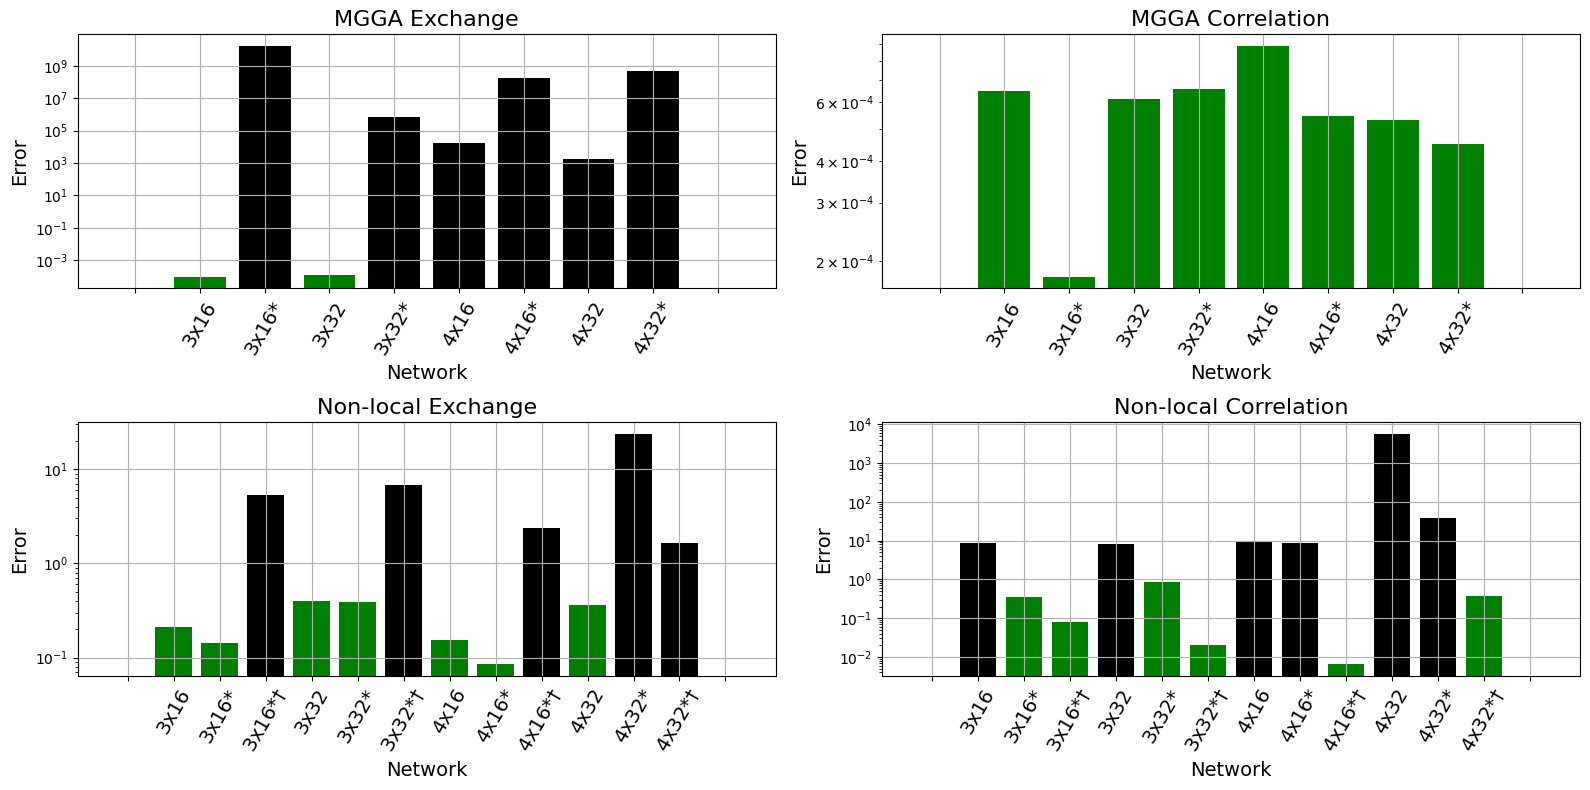

In [24]:
#this plots the losses of the given networks, labeling them based on their directory names
f = plt.figure(figsize=(16,8))

axxm = f.add_subplot(221)
axcm = f.add_subplot(222)
axxn = f.add_subplot(223)
axcn = f.add_subplot(224)
axs = [axxm, axcm, axxn, axcn]

axxm.set_title('MGGA Exchange', fontsize=16)
axcm.set_title('MGGA Correlation', fontsize=16)
axxn.set_title('Non-local Exchange', fontsize=16)
axcn.set_title('Non-local Correlation', fontsize=16)

for ax in axs:
    ax.grid()
    ax.set_xlabel('Network', fontsize=14)
    ax.set_ylabel('Error', fontsize=14)
    ax.set_yscale('log')
    # ax.set_ylim(0, 100)

PLOTXC = 'PBE0'

def get_label(net):
    nd_split = net.split('_')
    if len(nd_split) == 4:
        #xorc_depth_nodes_level    
        xorc, depth, nodes, level = nd_split
        lr2 = ''
        use = ''
    elif len(nd_split) == 5:
        #xorc_depth_nodes_level_lr2, just denotes a different learning rate schedule used    
        xorc, depth, nodes, level, lr2 = nd_split
        use = ''
    elif len(nd_split) == 6:
        #xorc_depth_nodes_level_lr2_use2, just denotes a different learning rate schedule used    
        xorc, depth, nodes, level, lr2, use = nd_split

    label = f'{depth}x{nodes}'
    if lr2:
        label+='*'
    if use:
        label+='$\dagger$'
    return label

#IMPORTANT: errors are MSE, NOT RMSE right now
for krefxc in val_dct.keys():
    if krefxc != PLOTXC:
        continue
    krefdct = val_dct[krefxc]
    for kxorc in krefdct.keys():
        krefxcdct = krefdct[kxorc]
        for klevel in krefxcdct.keys():
            krxcldct = krefxcdct[klevel]
            #DO GET_DATA GENERATION HERE
            data = []
            calcs = []
            rejects = []
            # tdrhos = [i[0] for i in data]
            # tfxcs = [i[1] for i in data]
            if kxorc == 'x':
                if klevel == 'mgga':
                    ax = axxm
                elif klevel == 'nl':
                    ax = axxn
            elif kxorc == 'c':
                if klevel == 'mgga':
                    ax = axcm
                elif klevel == 'nl':
                    ax = axcn
            knets = sorted(list(krxcldct.keys()))
            xs = np.arange(0, len(knets)+2)
            ax.set_xticks(xs)
            ax.set_xticklabels(['']+[get_label(i) for i in knets]+[''], fontsize=14, rotation=60)
            errors = []

            calcs = calc_dct[krefxc][kxorc][klevel]['calcs']
            rejects = calc_dct[krefxc][kxorc][klevel]['rejects']
            print(f'{krefxc}-{kxorc}-{klevel}: NCalcs = {len(calcs)}/NRejects = {len(rejects)}')
            for knet in knets:
                print(krefxc, kxorc, klevel, knet)
                #plot
                tup = get_model_info(refxcps[krefxc], knet)
                try:
                    errors.append(np.mean(krxcldct[knet]) ) 
                except:
                    errors.append(0)
            print(len(xs), len(errors))
            errors = np.array([0]+errors+[0])
            m1 = errors < 1
            ax.bar(xs[m1], errors[m1], facecolor='g')
            ax.bar(xs[~ m1], errors[~ m1], facecolor='k')
plt.tight_layout()

In [12]:
val_dct['PBE0']['x']['mgga']

{'x_3_16_mgga': [],
 'x_3_16_mgga_lr2': [],
 'x_3_32_mgga': [],
 'x_3_32_mgga_lr2': [],
 'x_4_16_mgga': [],
 'x_4_16_mgga_lr2': [],
 'x_4_32_mgga': [],
 'x_4_32_mgga_lr2': []}

# Evaluating Randomly Initialized Networks on PBE0/SCAN Energy Density References

In [39]:

#the top-level directories under which the pre-trained networks are contained 
d = '/home/awills/Documents/Research/xcquinox/scripts/script_data/ctests/ran'
pd2 = '/home/awills/Documents/Research2/xcquinox_pt/ctests/ran/pbe0'
sd2 = '/home/awills/Documents/Research2/xcquinox_pt/ctests/ran/scan'
#this generates the list of networks generated, assuming they are the only directories with underscores in them in the subdirectories
nets = sorted([i for i in os.listdir(d) if '_' in i and os.path.isdir(os.path.join(d, i))])

#set up empty dictionary
val_dct = {'PBE0': {},
           'SCAN': {}}
refxcps = {'PBE0':d,
           'SCAN':d}
refxcps2 = {'PBE0':pd2,
           'SCAN':sd2}

#populate the validation dictionaries with the directories of the pre-trained networks as sub-directories, with empty lists for losses
val_dct['PBE0'] = {'x': {'gga': {k : [] for k in nets if 'gga' in k and k[:2] == 'x_' and 'mgga' not in k},
                         'mgga': {k : [] for k in nets if 'mgga' in k and k[:2] == 'x_'},
                         'nl': {k : [] for k in nets if 'nl' in k and k[:2] == 'x_'},
                        },
                   'c': {'gga': {k : [] for k in nets if 'gga' in k and k[:2] == 'c_' and 'mgga' not in k},
                         'mgga': {k : [] for k in nets if 'mgga' in k and k[:2] == 'c_'},
                         'nl': {k : [] for k in nets if 'nl' in k and k[:2] == 'c_'},
                        },
                  }
val_dct['SCAN'] = {'x': {'gga': {k : [] for k in nets if 'gga' in k and k[:2] == 'x_' and 'mgga' not in k},
                         'mgga': {k : [] for k in nets if 'mgga' in k and k[:2] == 'x_'},
                         'nl': {k : [] for k in nets if 'nl' in k and k[:2] == 'x_'},
                        },
                   'c': {'gga': {k : [] for k in nets if 'gga' in k and k[:2] == 'c_' and 'mgga' not in k},
                         'mgga': {k : [] for k in nets if 'mgga' in k and k[:2] == 'c_'},
                         'nl': {k : [] for k in nets if 'nl' in k and k[:2] == 'c_'},
                        },
                  }

## Generate and save the descriptor/reference densities

In [1]:
#create empty dictionary for the calculated densities on the grid
calc_dct = {}
#loop over the reference XC functionals in val_dct, PBE0 and SCAN
for krefxc in val_dct.keys():
    #select the sub-directory from val_dct, and create a sub-directory in calc_dct using this reference XC functional
    krefdct = val_dct[krefxc]
    calc_dct[krefxc] = {}
    for kxorc in krefdct.keys():
        #loops over the 'x' or 'c' values in the val_dct sub-dictionary, and again creates an empty dictionary to hold the results
        krefxcdct = krefdct[kxorc]
        calc_dct[krefxc][kxorc] = {}
        for klevel in krefxcdct.keys():
            #loop over the 'mgga' or 'nl' levels in the val_dct subdictionary
            krxcldct = krefxcdct[klevel]
            #the networks included in this reference XC -> x/c -> level
            knets = sorted(list(krxcldct.keys()))
            for knetidx, knet in enumerate(knets): 
                #loop over the list indices and network directories
                if ('c0' in knet or 'c1' in knet) and ('nc0' not in knet and 'nc1' not in knet):
                    print('Constrained network...')
                    constr = True
                    ueg_limit = None
                    spin_scaling = None
                    cstr = 'c'
                elif 'nc0' in knet or 'nc1' in knet:
                    print('Unconstrained network...')
                    constr = False
                    ueg_limit = False
                    spin_scaling = False
                    cstr = 'nc'
                #if first attempt, print stats and generate the reference data
                thissave = True
                if os.path.exists(os.path.join(refxcps2[krefxc], f'{krefxc}_{kxorc}_{klevel}_{cstr}.data.pkl')):
                    print('Data file exists. loading in.')
                    thissave = False
                    with open(os.path.join(refxcps2[krefxc], f'{krefxc}_{kxorc}_{klevel}_{cstr}.data.pkl'), 'rb') as f:
                        data = pickle.load(f)
                else:
                    print('Data file does not yet exist. Creating...')
                    print(krefxc, kxorc, klevel, knet)
                    try:
                        tup = get_model_info(refxcps[krefxc], knet)
                    except:
                        with open(os.path.join(refxcps[krefxc], knet, 'network.config.pkl'), 'rb') as f:
                            tup = pickle.load(f)
                    print(tup)
                    try:
                        if type(tup) == tuple:
                            refxc, xorc, depth, nodes, ruse, rinp, level, xcf = tup
                        elif type(tup) == dict:
                            refxc = krefxc
                            xorc = knet.split('_')[0]
                            depth = tup['depth']
                            nodes = tup['nhidden']
                            ruse = tup['use']
                            rinp = tup['ninput']
                            level = knet.split('_')[-1].upper()
                            xcf = 'xc.eqx'
                    except Exception as e:
                        print("Exception raise: ", e)
                        print('no networks found')
                        continue
                    #create the network to generate the descriptors for saving
                    xc, net = gen_network_model(xorc, depth, nodes, rinp, ruse, level, 
                                                ptpath = os.path.join(refxcps[krefxc], knet, xcf), ueg_limit = ueg_limit, spin_scaling=spin_scaling)
                
                    #DO GET_DATA GENERATION HERE
                    #data generated only depends on get_descriptors, determined by level, not use
                    data = []
                    calcs = []
                    rejects = []
                    for idx, mol in enumerate(mols):
                        if len(mol.atom) <= 9:
                            #due to memory constraints, only validate on the molecules with 9 or less constituent atoms
                            print('----------------------------')
                            print(f'-----{idx}/{len(mols)}-----')
                            print(f'Calculating {mol.atom}')
                            try:
                                data.append(get_data(mol, xcmodel=xc, xc_func=krefxc, localnet=net))
                                calcs.append(mol.atom)
                            except Exception as e:
                                print("Exception raised: ", e)
                                rejects.append(mol.atom)
                                continue
                        else:
                            rejects.append(mol.atom)
                #save this combo's descriptors and energy densities to a file for later use
                if thissave:
                    with open(os.path.join(refxcps2[krefxc], f'{krefxc}_{kxorc}_{klevel}_{cstr}.data.pkl'), 'wb') as f:
                        pickle.dump(data, f)

NameError: name 'val_dct' is not defined

## Use generated and saved descriptors/references to get losses on the grid

In [73]:
#create empty dictionary for the calculated densities on the grid
calc_dct = {}
data = []
calcs = []
for idx, mol in enumerate(mols):
    if len(mol.atom) <= 9:
        #due to memory constraints, only validate on the molecules with 9 or less constituent atoms
        # print('----------------------------')
        # print(f'-----{idx}/{len(mols)}-----')
        # print(f'{mol.atom}')
        calcs.append(mol.atom)

#loop over the reference XC functionals in val_dct, PBE0 and SCAN
for krefxc in val_dct.keys():
    #select the sub-directory from val_dct, and create a sub-directory in calc_dct using this reference XC functional
    krefdct = val_dct[krefxc]
    calc_dct[krefxc] = {}
    for kxorc in krefdct.keys():
        #loops over the 'x' or 'c' values in the val_dct sub-dictionary, and again creates an empty dictionary to hold the results
        krefxcdct = krefdct[kxorc]
        calc_dct[krefxc][kxorc] = {}
        for klevel in krefxcdct.keys():
            #loop over the 'mgga' or 'nl' levels in the val_dct subdictionary
            krxcldct = krefxcdct[klevel]
            calc_dct[krefxc][kxorc][klevel] = {}
            #the networks included in this reference XC -> x/c -> level
            knets = sorted(list(krxcldct.keys()))
            for knetidx, knet in enumerate(knets): 
                #loop over the list indices and network directories
                if ('c0' in knet or 'c1' in knet) and ('nc0' not in knet and 'nc1' not in knet):
                    print('Constrained network...')
                    constr = True
                    ueg_limit = None
                    spin_scaling = None
                    cstr = 'c'
                elif 'nc0' in knet or 'nc1' in knet:
                    print('Unconstrained network...')
                    constr = False
                    ueg_limit = False
                    spin_scaling = False
                    cstr = 'nc'
                #read in the calculated reference dictionary
                try:
                    with open(os.path.join(refxcps2[krefxc], f'{krefxc}_{kxorc}_{klevel}_{cstr}.data.pkl'), 'rb') as f:
                        data = pickle.load(f)
                except:
                    raise
                print(krefxc, kxorc, klevel, knet)
                try:
                    tup = get_model_info(refxcps[krefxc], knet)
                except:
                    with open(os.path.join(refxcps[krefxc], knet, 'network.config.pkl'), 'rb') as f:
                        tup = pickle.load(f)
                print(tup)
                if type(tup) == tuple:
                    refxc, xorc, depth, nodes, ruse, rinp, level, xcf = tup
                elif type(tup) == dict:
                    refxc = krefxc
                    xorc = knet.split('_')[0]
                    depth = tup['depth']
                    nodes = tup['nhidden']
                    ruse = tup['use']
                    rinp = tup['ninput']
                    level = knet.split('_')[-1].upper()
                    xcf = 'xc.eqx'
                xc, net = gen_network_model(xorc, depth, nodes, rinp, ruse, level, 
                                                ptpath = os.path.join(refxcps[krefxc], knet, xcf), ueg_limit = ueg_limit, spin_scaling=spin_scaling)
                losses = []
                tdrhos = [i[0] for i in data]
                tfxcs = [i[1] for i in data]
                print(f'{krefxc} -- {knet} Validation beginning...')
                for idx, dat in enumerate(tdrhos):
                    if idx == 0:
                        print(f'Descriptor shape: {dat.shape}')
                    # print(f'{idx}/{len(tdrhos)}')
                    #reference energy density and the descriptors
                    this_tFxc = tfxcs[idx]
                    this_tdrho = dat
                    if ruse:
                        if idx == 0:
                            print('ruse is specified: {}'.format(ruse))
                        #if there is a specified 'use' for the network, only select those descriptors as inputs
                        if net.spin_scaling:
                            if len(this_tdrho.shape) == 3:
                                inp = this_tdrho[:, :, ruse]
                            else:
                                inp = this_tdrho[:, ruse]
                        else:
                            inp = this_tdrho[:, ruse]
                    else:
                        #otherwise, no subsetting necessary
                        inp = this_tdrho
                    # print(f'inp[0].shape = {inp[0].shape}')
                    #generate the validation loss
                    loss = PT_E_Loss()(net, inp, this_tFxc)
                    losses.append(loss)
                calc_dct[krefxc][kxorc][klevel][knet] = {'calcs':calcs, 'calc_losses':losses}
                val_dct[krefxc][kxorc][klevel][knet] = losses
                with open(os.path.join(refxcps2[krefxc], f'{krefxc}_{knet}.val_dct.pkl'), 'wb') as f:
                    pickle.dump(val_dct, f)
                with open(os.path.join(refxcps2[krefxc], f'{krefxc}_{knet}.calc_dct.pkl'), 'wb') as f:
                    pickle.dump(calc_dct, f)

Constrained network...
PBE0 x gga x_3_16_c0_gga
{'ninput': 1, 'depth': 3, 'nhidden': 16, 'use': [1], 'spin_scaling': True, 'ueg_limit': True, 'lob': 1.804, 'random_seed': 92017}
Attempting to deserialize network from /home/awills/Documents/Research/xcquinox/scripts/script_data/ctests/ran/x_3_16_c0_gga/xc.eqx
PBE0 -- x_3_16_c0_gga Validation beginning...
Descriptor shape: (10003, 2)
ruse is specified: [1]
Constrained network...
PBE0 x gga x_3_16_c1_gga
{'ninput': 1, 'depth': 3, 'nhidden': 16, 'use': [1], 'spin_scaling': True, 'ueg_limit': True, 'lob': 1.804, 'random_seed': 17920}
Attempting to deserialize network from /home/awills/Documents/Research/xcquinox/scripts/script_data/ctests/ran/x_3_16_c1_gga/xc.eqx
PBE0 -- x_3_16_c1_gga Validation beginning...
Descriptor shape: (10003, 2)
ruse is specified: [1]
Unconstrained network...
PBE0 x gga x_3_16_nc0_gga
{'ninput': 3, 'depth': 3, 'nhidden': 16, 'use': [], 'spin_scaling': False, 'ueg_limit': False, 'lob': 0, 'random_seed': 92017}
Attemp

pbe0 x
pbe0 c
scan x
scan c


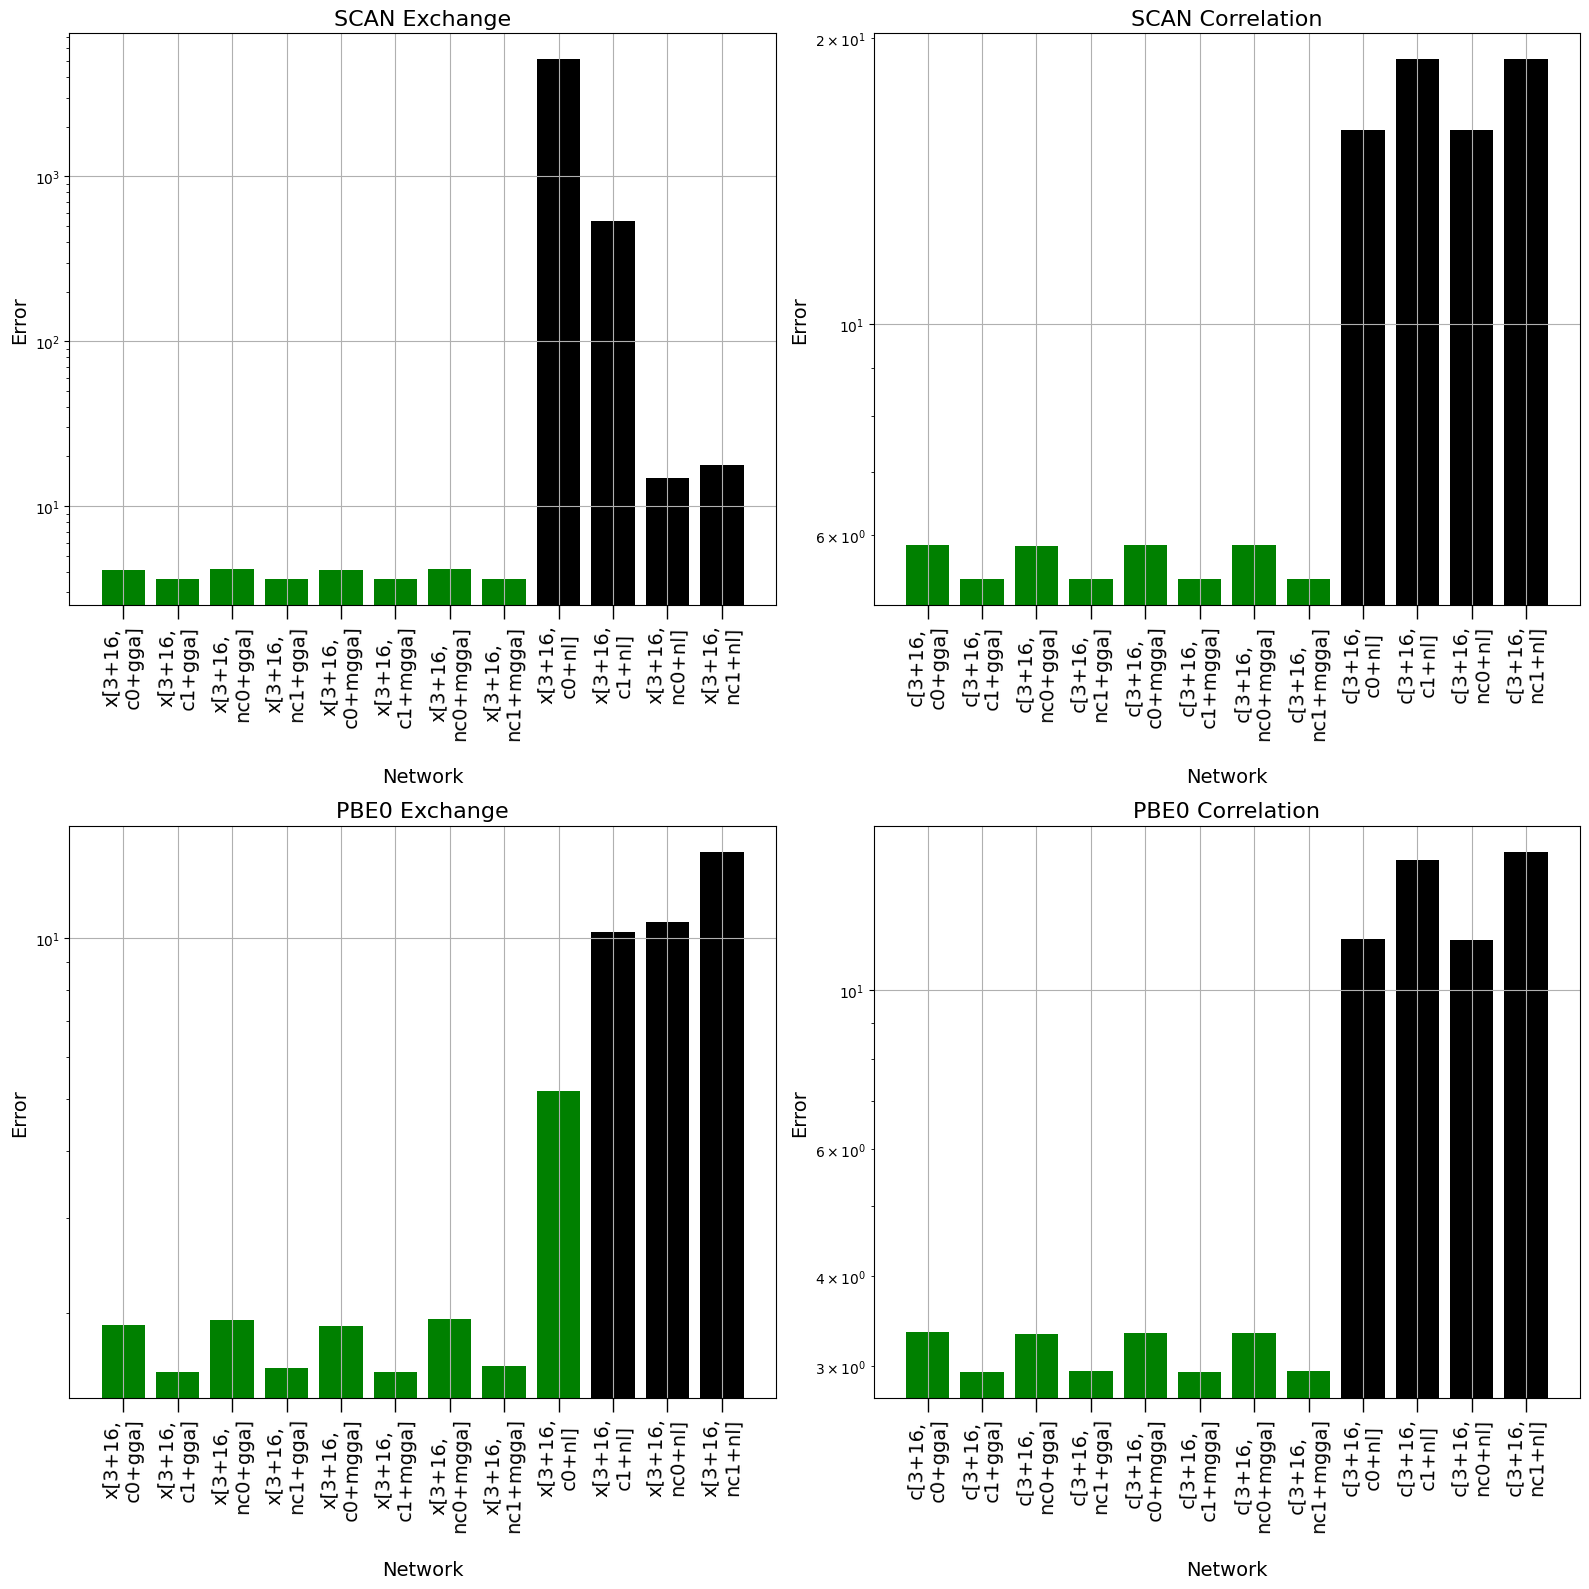

In [105]:
#this plots the losses of the given networks, labeling them based on their directory names
f = plt.figure(figsize=(16,16))

axsx = f.add_subplot(221)
axsc = f.add_subplot(222)
axpx = f.add_subplot(223)
axpc = f.add_subplot(224)
axs = [axsx, axsc, axpx, axpc]

axsx.set_title('SCAN Exchange', fontsize=16)
axsc.set_title('SCAN Correlation', fontsize=16)
axpx.set_title('PBE0 Exchange', fontsize=16)
axpc.set_title('PBE0 Correlation', fontsize=16)

axdct = {'scan': {'x':axsx, 'c':axsc}, 'pbe0':{'x':axpx, 'c':axpc}}

for ax in axs:
    ax.grid()
    ax.set_xlabel('Network', fontsize=14)
    ax.set_ylabel('Error', fontsize=14)
    ax.set_yscale('log')
    # ax.set_ylim(0, 100)

# def get_label(net):
#     nd_split = net.split('_')
#     if len(nd_split) == 4:
#         #xorc_depth_nodes_level    
#         xorc, depth, nodes, level = nd_split
#         lr2 = ''
#         use = ''
#     elif len(nd_split) == 5:
#         #xorc_depth_nodes_level_lr2, just denotes a different learning rate schedule used    
#         xorc, depth, nodes, level, lr2 = nd_split
#         use = ''
#     elif len(nd_split) == 6:
#         #xorc_depth_nodes_level_lr2_use2, just denotes a different learning rate schedule used    
#         xorc, depth, nodes, level, lr2, use = nd_split

#     label = f'{depth}x{nodes}'
#     if lr2:
#         label+='*'
#     if use:
#         label+='$\dagger$'
#     return label

#IMPORTANT: errors are MSE, NOT RMSE right now
for krefxc in val_dct.keys():
    krefdct = val_dct[krefxc]
    for kxorc in krefdct.keys():
        krefxcdct = krefdct[kxorc]
        print(krefxc.lower(), kxorc.lower())
        ax = axdct[krefxc.lower()][kxorc.lower()]
        ax.set_xticklabels([])
        errors = []
        xticklabs = []
        for klevel in krefxcdct.keys():
            krxcldct = krefxcdct[klevel]
            knets = sorted(list(krxcldct.keys()))
            xticklabs += ['{}[{}+{},\n{}+{}]'.format(*i.split('_')) for i in knets]
            for knet in knets:
                errors.append(np.mean(krxcldct[knet]) ) 
        xs = np.arange(0, len(xticklabs))
        ax.set_xticks(xs)
        # xticklabs = [''] + xticklabs + ['']
        ax.set_xticklabels(xticklabs, fontsize=14, rotation=89)
        errors = np.array(errors)
        # errors = np.array([0]+errors+[0])
        m1 = errors < 10
        ax.bar(xs[m1], errors[m1], facecolor='g')
        ax.bar(xs[~ m1], errors[~ m1], facecolor='k')
        ax.tick_params('x', length=10, width=1, which='major')
        ax.xaxis.labelpad = 20
plt.tight_layout()

# Plot Pre-trained Network Losses

In [5]:

#the top-level directories under which the pre-trained networks are contained 
pd = '/home/awills/Documents/Research/xcquinox/scripts/script_data/ctests/pt/pbe0'
sd = '/home/awills/Documents/Research/xcquinox/scripts/script_data/ctests/pt/scan'
#the top-level directories under which the .data.pkl files are contained
pd2 = '/home/awills/Documents/Research2/xcquinox_pt/ctests/ran/pbe0'
sd2 = '/home/awills/Documents/Research2/xcquinox_pt/ctests/ran/scan'

#this generates the list of networks generated, assuming they are the only directories with underscores in them in the subdirectories
pnets = sorted([i for i in os.listdir(pd) if '_' in i and os.path.isdir(os.path.join(pd, i))])
snets = sorted([i for i in os.listdir(sd) if '_' in i and os.path.isdir(os.path.join(sd, i))])

#set up empty dictionary
val_dct = {'PBE0': {},
           'SCAN': {}}

#these directories hold the pre-trained networks generated during pre-training
refxcps = {'PBE0':pd,
           'SCAN':sd}
#these directories hold the .data.pkl files used to generate the validation losses
refxcps2 = {'PBE0':pd2,
           'SCAN':sd2}

#populate the validation dictionaries with the directories of the pre-trained networks as sub-directories, with empty lists for losses
val_dct['PBE0'] = {'x': {'gga': {k : [] for k in pnets if 'gga' in k and k[:2] == 'x_' and 'mgga' not in k},
                         'mgga': {k : [] for k in pnets if 'mgga' in k and k[:2] == 'x_'},
                         'nl': {k : [] for k in pnets if 'nl' in k and k[:2] == 'x_'},
                        },
                   'c': {'gga': {k : [] for k in pnets if 'gga' in k and k[:2] == 'c_' and 'mgga' not in k},
                         'mgga': {k : [] for k in pnets if 'mgga' in k and k[:2] == 'c_'},
                         'nl': {k : [] for k in pnets if 'nl' in k and k[:2] == 'c_'},
                        },
                  }
val_dct['SCAN'] = {'x': {'gga': {k : [] for k in snets if 'gga' in k and k[:2] == 'x_' and 'mgga' not in k},
                         'mgga': {k : [] for k in snets if 'mgga' in k and k[:2] == 'x_'},
                         'nl': {k : [] for k in snets if 'nl' in k and k[:2] == 'x_'},
                        },
                   'c': {'gga': {k : [] for k in snets if 'gga' in k and k[:2] == 'c_' and 'mgga' not in k},
                         'mgga': {k : [] for k in snets if 'mgga' in k and k[:2] == 'c_'},
                         'nl': {k : [] for k in snets if 'nl' in k and k[:2] == 'c_'},
                        },
                  }

In [6]:
#create empty dictionary for the calculated densities on the grid
calc_dct = {}
data = []
calcs = []
for idx, mol in enumerate(mols):
    if len(mol.atom) <= 9:
        #due to memory constraints, only validate on the molecules with 9 or less constituent atoms
        # print('----------------------------')
        # print(f'-----{idx}/{len(mols)}-----')
        # print(f'{mol.atom}')
        calcs.append(mol.atom)

#loop over the reference XC functionals in val_dct, PBE0 and SCAN
for krefxc in val_dct.keys():
    #select the sub-directory from val_dct, and create a sub-directory in calc_dct using this reference XC functional
    krefdct = val_dct[krefxc]
    calc_dct[krefxc] = {}
    for kxorc in krefdct.keys():
        #loops over the 'x' or 'c' values in the val_dct sub-dictionary, and again creates an empty dictionary to hold the results
        krefxcdct = krefdct[kxorc]
        calc_dct[krefxc][kxorc] = {}
        for klevel in krefxcdct.keys():
            #loop over the 'mgga' or 'nl' levels in the val_dct subdictionary
            krxcldct = krefxcdct[klevel]
            calc_dct[krefxc][kxorc][klevel] = {}
            #the networks included in this reference XC -> x/c -> level
            knets = sorted(list(krxcldct.keys()))
            for knetidx, knet in enumerate(knets): 
                #loop over the list indices and network directories
                if ('c0' in knet or 'c1' in knet) and ('nc0' not in knet and 'nc1' not in knet):
                    print('Constrained network...')
                    constr = True
                    ueg_limit = None
                    spin_scaling = None
                    cstr = 'c'
                elif 'nc0' in knet or 'nc1' in knet:
                    print('Unconstrained network...')
                    constr = False
                    ueg_limit = False
                    spin_scaling = False
                    cstr = 'nc'
                #read in the calculated reference dictionary
                try:
                    with open(os.path.join(refxcps2[krefxc], f'{krefxc}_{kxorc}_{klevel}_{cstr}.data.pkl'), 'rb') as f:
                        data = pickle.load(f)
                except:
                    raise
                print(krefxc, kxorc, klevel, knet)
                try:
                    tup = get_model_info(refxcps[krefxc], knet)
                except:
                    with open(os.path.join(refxcps[krefxc], knet, 'network.config.pkl'), 'rb') as f:
                        tup = pickle.load(f)
                print(tup)
                if type(tup) == tuple:
                    refxc, xorc, depth, nodes, ruse, rinp, level, xcf = tup
                elif type(tup) == dict:
                    refxc = krefxc
                    xorc = knet.split('_')[0]
                    depth = tup['depth']
                    nodes = tup['nhidden']
                    ruse = tup['use']
                    rinp = tup['ninput']
                    level = knet.split('_')[-1].upper()
                    xcf = 'xc.eqx'
                #get last saved checkpoint
                xcfs = sorted([i for i in os.listdir(os.path.join(refxcps[krefxc], knet)) if xcf in i],
                              key=lambda x: int(x.split('.')[-1]))
                if len(xcfs) == 0:
                    #no pre-training data, skip
                    continue
                #select xcfs[-2] because the model update happens after loss is calculated, so index-1 is the network with the minimal loss
                xc, net = gen_network_model(xorc, depth, nodes, rinp, ruse, level, 
                                                ptpath = os.path.join(refxcps[krefxc], knet, xcfs[-2]), ueg_limit = ueg_limit, spin_scaling=spin_scaling)
                losses = []
                tdrhos = [i[0] for i in data]
                tfxcs = [i[1] for i in data]
                print(f'{krefxc} -- {knet} Validation beginning...')
                for idx, dat in enumerate(tdrhos):
                    if idx == 0:
                        print(f'Descriptor shape: {dat.shape}')
                    # print(f'{idx}/{len(tdrhos)}')
                    #reference energy density and the descriptors
                    this_tFxc = tfxcs[idx]
                    this_tdrho = dat
                    if ruse:
                        if idx == 0:
                            print('ruse is specified: {}'.format(ruse))
                        #if there is a specified 'use' for the network, only select those descriptors as inputs
                        if net.spin_scaling:
                            if len(this_tdrho.shape) == 3:
                                inp = this_tdrho[:, :, ruse]
                            else:
                                inp = this_tdrho[:, ruse]
                        else:
                            inp = this_tdrho[:, ruse]
                    else:
                        #otherwise, no subsetting necessary
                        inp = this_tdrho
                    # print(f'inp[0].shape = {inp[0].shape}')
                    #generate the validation loss
                    loss = PT_E_Loss()(net, inp, this_tFxc)
                    losses.append(loss)
                calc_dct[krefxc][kxorc][klevel][knet] = {'calcs':calcs, 'calc_losses':losses}
                val_dct[krefxc][kxorc][klevel][knet] = losses
                with open(os.path.join(refxcps2[krefxc], f'{krefxc}_{knet}.val_dct.pkl'), 'wb') as f:
                    pickle.dump(val_dct, f)
                with open(os.path.join(refxcps2[krefxc], f'{krefxc}_{knet}.calc_dct.pkl'), 'wb') as f:
                    pickle.dump(calc_dct, f)

Constrained network...
PBE0 x gga x_3_16_c0_gga
{'ninput': 1, 'depth': 3, 'nhidden': 16, 'use': [1], 'spin_scaling': True, 'ueg_limit': True, 'lob': 1.804, 'random_seed': 92017}
Attempting to deserialize network from /home/awills/Documents/Research/xcquinox/scripts/script_data/ctests/pt/pbe0/x_3_16_c0_gga/xc.eqx.1801
PBE0 -- x_3_16_c0_gga Validation beginning...
Descriptor shape: (10003, 2)
ruse is specified: [1]
Constrained network...
PBE0 x gga x_3_16_c1_gga
{'ninput': 1, 'depth': 3, 'nhidden': 16, 'use': [1], 'spin_scaling': True, 'ueg_limit': True, 'lob': 1.804, 'random_seed': 17920}
Attempting to deserialize network from /home/awills/Documents/Research/xcquinox/scripts/script_data/ctests/pt/pbe0/x_3_16_c1_gga/xc.eqx.1636
PBE0 -- x_3_16_c1_gga Validation beginning...
Descriptor shape: (10003, 2)
ruse is specified: [1]
Unconstrained network...
PBE0 x gga x_3_16_nc0_gga
{'ninput': 3, 'depth': 3, 'nhidden': 16, 'use': [], 'spin_scaling': False, 'ueg_limit': False, 'lob': 0, 'random_se

pbe0 x
pbe0 c
scan x
scan c


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


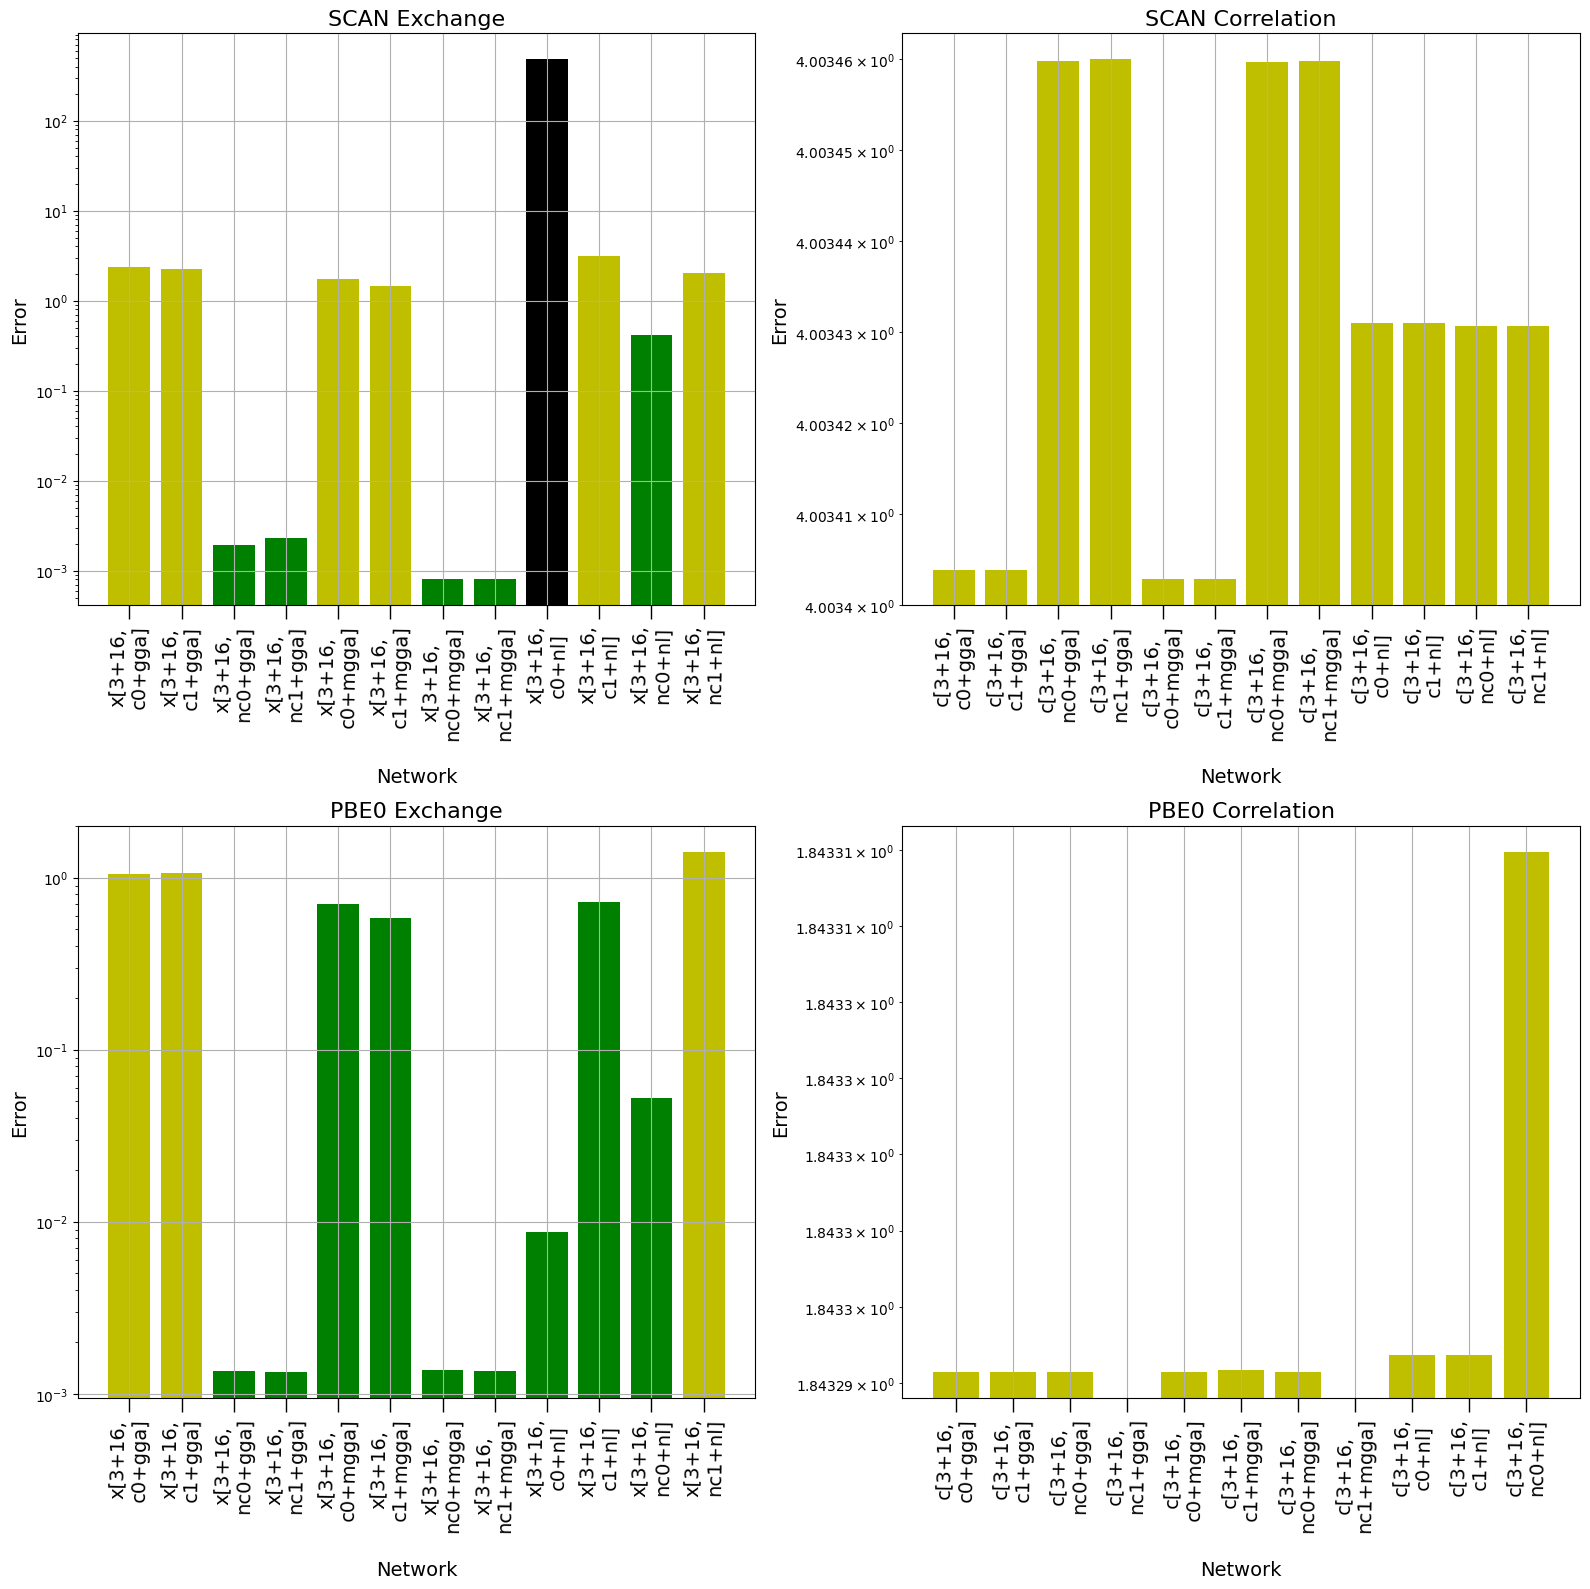

In [12]:
#this plots the losses of the given networks, labeling them based on their directory names
f = plt.figure(figsize=(16,16))

axsx = f.add_subplot(221)
axsc = f.add_subplot(222)
axpx = f.add_subplot(223)
axpc = f.add_subplot(224)
axs = [axsx, axsc, axpx, axpc]

axsx.set_title('SCAN Exchange', fontsize=16)
axsc.set_title('SCAN Correlation', fontsize=16)
axpx.set_title('PBE0 Exchange', fontsize=16)
axpc.set_title('PBE0 Correlation', fontsize=16)

axdct = {'scan': {'x':axsx, 'c':axsc}, 'pbe0':{'x':axpx, 'c':axpc}}

for ax in axs:
    ax.grid()
    ax.set_xlabel('Network', fontsize=14)
    ax.set_ylabel('Error', fontsize=14)
    ax.set_yscale('log')
    # ax.set_ylim(0, 100)

# def get_label(net):
#     nd_split = net.split('_')
#     if len(nd_split) == 4:
#         #xorc_depth_nodes_level    
#         xorc, depth, nodes, level = nd_split
#         lr2 = ''
#         use = ''
#     elif len(nd_split) == 5:
#         #xorc_depth_nodes_level_lr2, just denotes a different learning rate schedule used    
#         xorc, depth, nodes, level, lr2 = nd_split
#         use = ''
#     elif len(nd_split) == 6:
#         #xorc_depth_nodes_level_lr2_use2, just denotes a different learning rate schedule used    
#         xorc, depth, nodes, level, lr2, use = nd_split

#     label = f'{depth}x{nodes}'
#     if lr2:
#         label+='*'
#     if use:
#         label+='$\dagger$'
#     return label

#IMPORTANT: errors are MSE, NOT RMSE right now
for krefxc in val_dct.keys():
    krefdct = val_dct[krefxc]
    for kxorc in krefdct.keys():
        krefxcdct = krefdct[kxorc]
        print(krefxc.lower(), kxorc.lower())
        ax = axdct[krefxc.lower()][kxorc.lower()]
        ax.set_xticklabels([])
        errors = []
        xticklabs = []
        for klevel in krefxcdct.keys():
            krxcldct = krefxcdct[klevel]
            knets = sorted(list(krxcldct.keys()))
            xticklabs += ['{}[{}+{},\n{}+{}]'.format(*i.split('_')) for i in knets]
            for knet in knets:
                errors.append(np.mean(krxcldct[knet]) ) 
        xs = np.arange(0, len(xticklabs))
        ax.set_xticks(xs)
        # xticklabs = [''] + xticklabs + ['']
        ax.set_xticklabels(xticklabs, fontsize=14, rotation=89)
        errors = np.array(errors)
        # errors = np.array([0]+errors+[0])
        m1 = (errors >= 1) & (errors < 10)
        m2 = errors < 1
        ax.bar(xs, errors, facecolor='k')
        ax.bar(xs[m1], errors[m1], facecolor='y')
        ax.bar(xs[m2], errors[m2], facecolor='g')
        # ax.bar(xs[~ m1], errors[~ m1], facecolor='k')
        ax.tick_params('x', length=10, width=1, which='major')
        ax.xaxis.labelpad = 20
plt.tight_layout()